In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("/home/ivan/work'n'stuff/Programming/Kaggle/IMtest/train.csv")
test = pd.read_csv("/home/ivan/work'n'stuff/Programming/Kaggle/IMtest/test.csv")

In [3]:
train.head()

sample_id         f0        f1        f2         f3       f4        f5  \
0  sample_0  25.609375  6.703125  3.652344  10.039062  169.375  102.8125   
1  sample_1  18.343750  5.824219  2.966797   4.902344  164.625   71.8125   
2  sample_2  28.562500  6.230469  3.583984   7.882812  159.500  113.1875   
3  sample_3  28.062500  6.132812  2.726562   6.378906  169.750  111.0000   
4  sample_4  20.109375  6.144531  3.203125   6.035156  164.750   78.8750   

         f6        f7        f8 ...      f1603     f1604     f1605     f1606  \
0  1.422852  6.722656  8.015625 ...   8.070312  4.363281  5.019531  5.710938   
1  1.357422  5.894531  2.753906 ...   7.359375  4.195312  4.808594  5.425781   
2  1.696289  6.316406  4.605469 ...   8.562500  4.523438  5.097656  5.789062   
3  1.535156  6.199219  3.712891 ...   4.558594  3.533203  3.900391  4.261719   
4  1.281250  6.187500  4.003906 ...   6.613281  4.625000  4.996094  5.328125   

      f1607     f1608     f1609     f1610     f1611    y  
0  6.343750  6.843750  7.289062  7.617188  7.980469  1.0  
1  5.949219  6.339844  6.730469  7.074219  7.175781  1.0  
2  6.457031  6.871094  7.386719  7.878906  8.328125  1.0  
3  4.042969  3.869141  3.890625  4.042969  4.273438  1.0  
4  5.593750  5.800781  6.027344  6.242188  6.449219  0.0  

[5 rows x 1614 columns]

## Отчистка данных 

Так как данных достаточно много и визуально исследовать их не получается, то выведем такие параметры в данных, как количество пропущеных элементов, количество inf элементов, количество выбросов, а так же сколько каждый предиктор имеет значений, чтобы определить, какие из предикторов могут быть категориальными.

Посмотрим на сбалансированность данных 

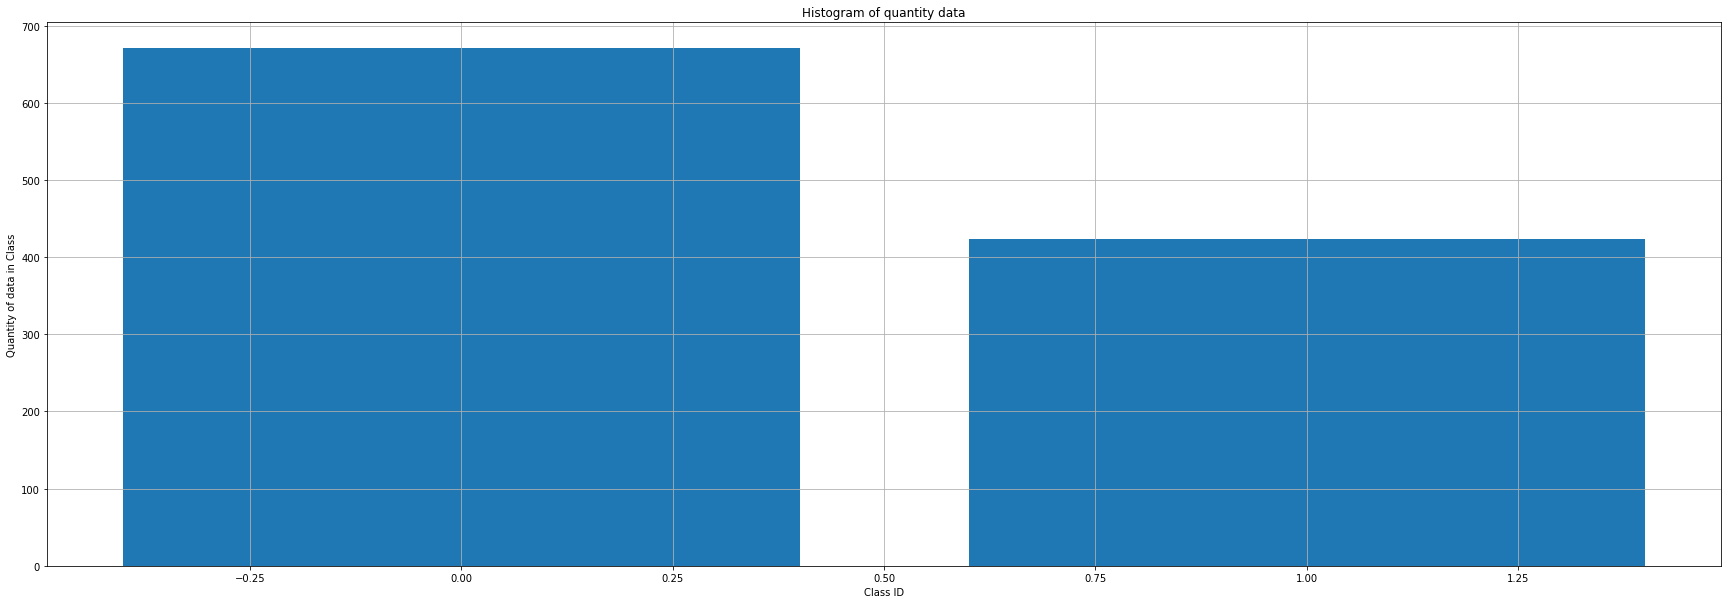

In [89]:
plt.figure(figsize=[30,10])
plt.bar([0,1], [sum(train['y'] == 1), sum(train['y'] == 0)])
plt.title(f'Histogram of quantity data')
plt.xlabel('Class ID')
plt.ylabel(f'Quantity of data in Class')
plt.grid(True)
plt.show()

Нельзя назвать данные несбалансированными, поэтому в дальнейшем балансировать их не будем

In [4]:
train = train.drop(['sample_id'], axis=1)
test_samp = test.drop(['sample_id'], axis=1)

Есть предикторы, которые принимают целочисленные значния, но при этом выгрузились, как значения с плавующей точкой. Перенесем те предикторы, в которых только целочисленные значения в int 

In [5]:
for field in train:
    train[field] = pd.to_numeric(train[field], downcast='integer')
for field in test_samp:
     test_samp[field] = pd.to_numeric(test_samp[field], downcast='integer')

Посчитаем количество nan и inf элементов

In [6]:
def nan_calculating(df, key=None):
    """
    Function for calculating nans and infs.
    Also this function plots this values as a bar plots.  
    """
    if not key:
        key = np.isnan
        name = 'NaN'
    else:
        name = 'Inf'
    df = df.iloc[:, 1:]
    result_nan = {}
    for field in df:
        result_nan[field] = np.sum(key(df[field]))
    keys = list(result_nan.keys())
    values = list(result_nan.values())
    for i in range(0,len(keys), 50):
        plt.figure(figsize=[30,10])
        plt.bar(list(result_nan.keys())[i:i + 50], list(result_nan.values())[i:i + 50])
        plt.title(f'Histogram of {name} values from {i} to {i+50}')
        plt.xlabel('Feature ID')
        plt.ylabel(f'Quantity of {name}s')
        plt.grid(True)
        plt.show()
    return result_nan

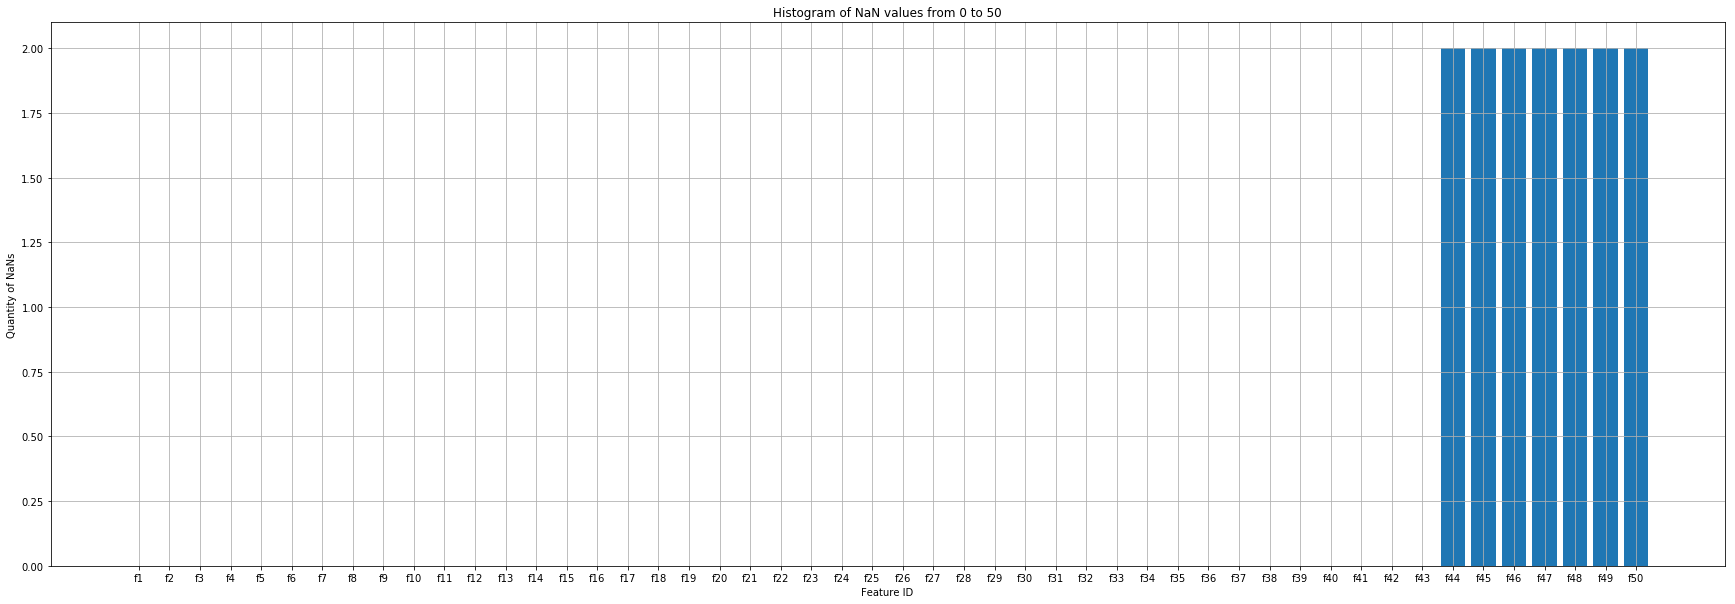

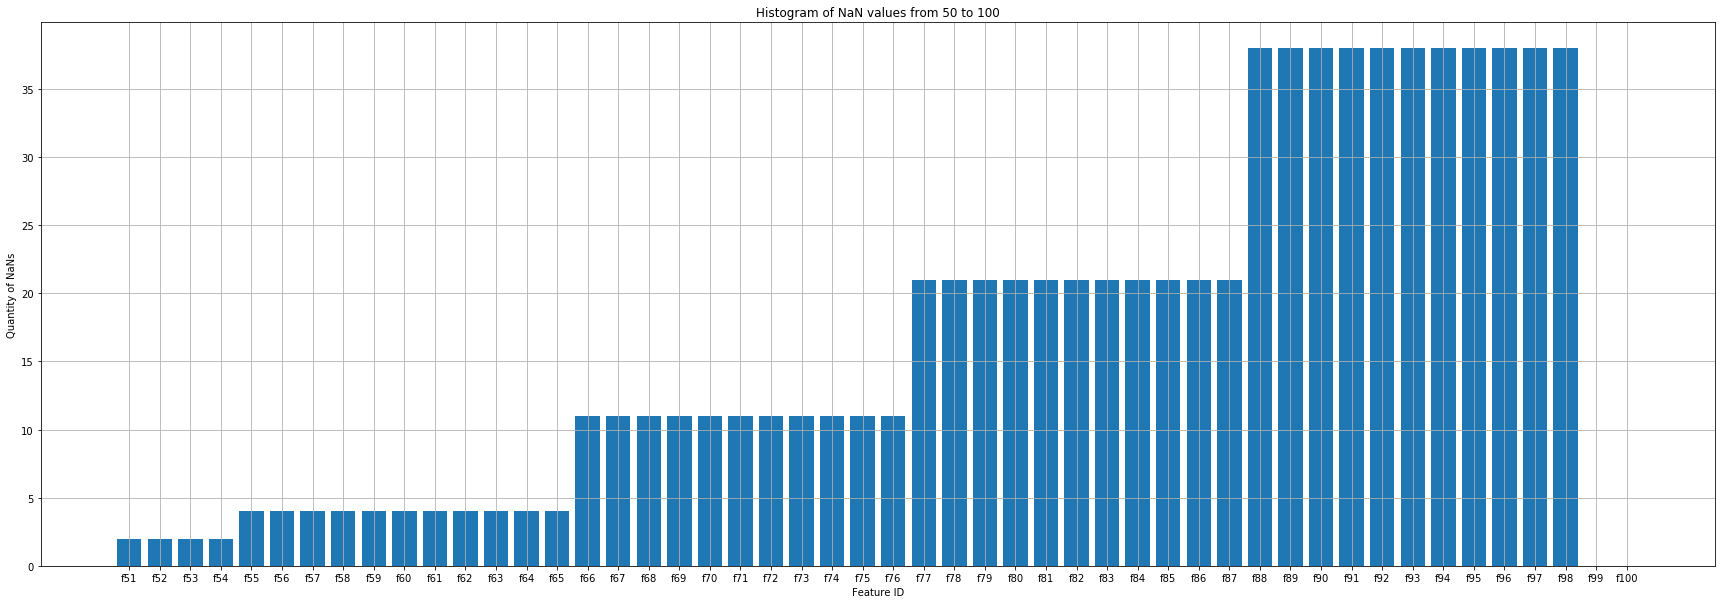

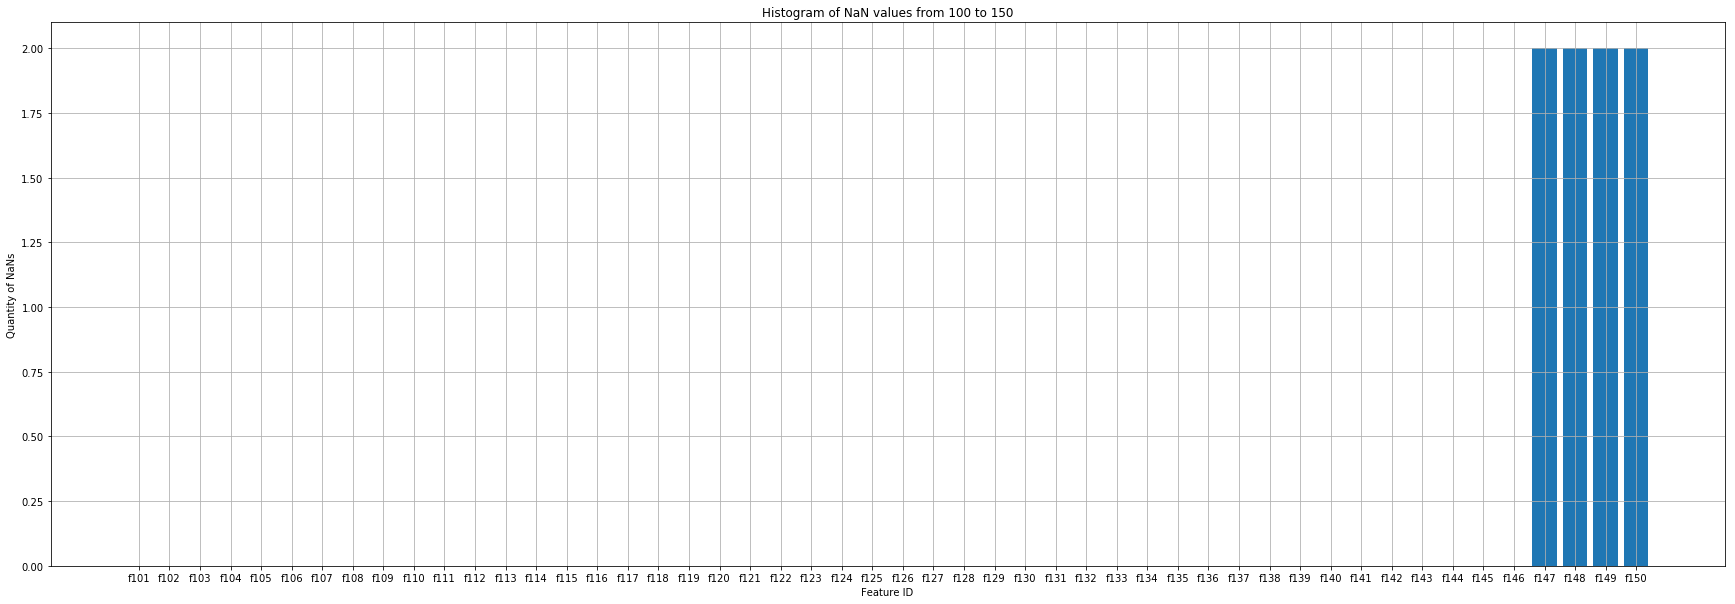

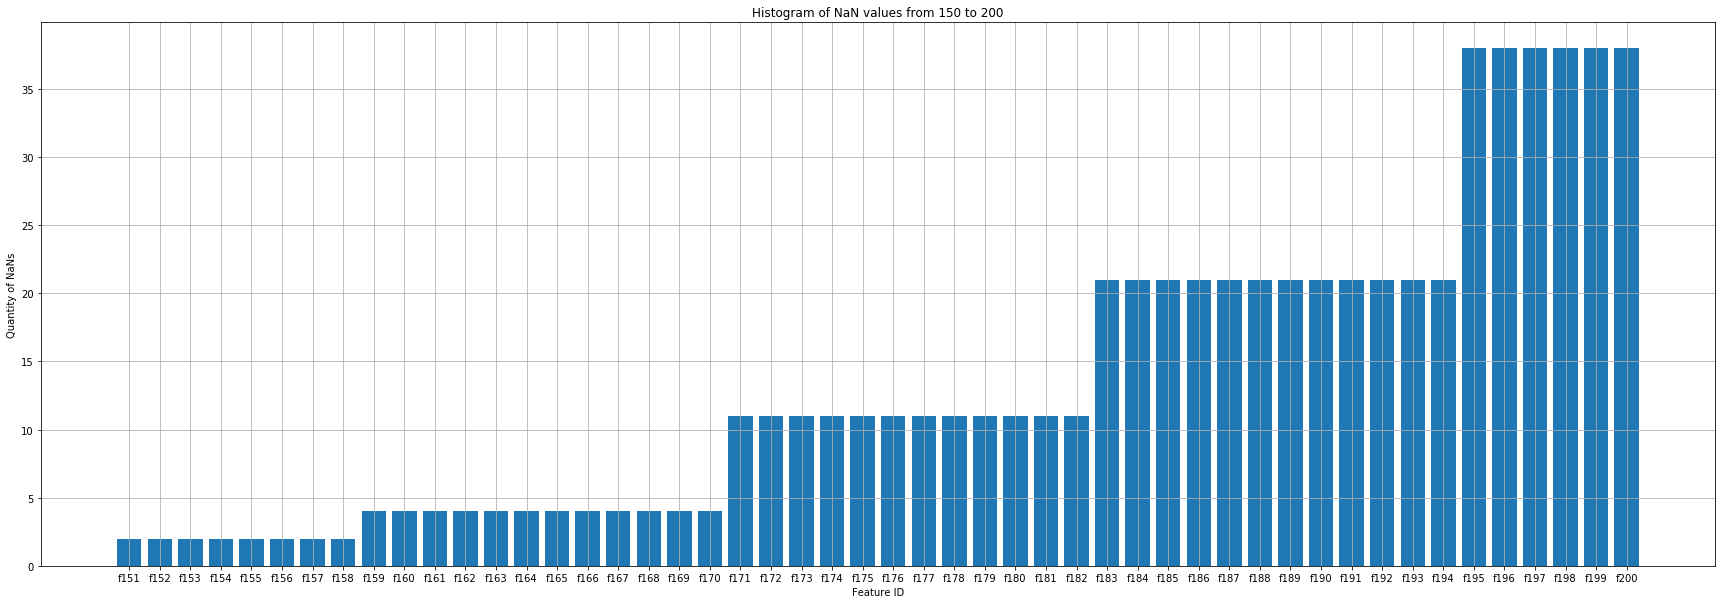

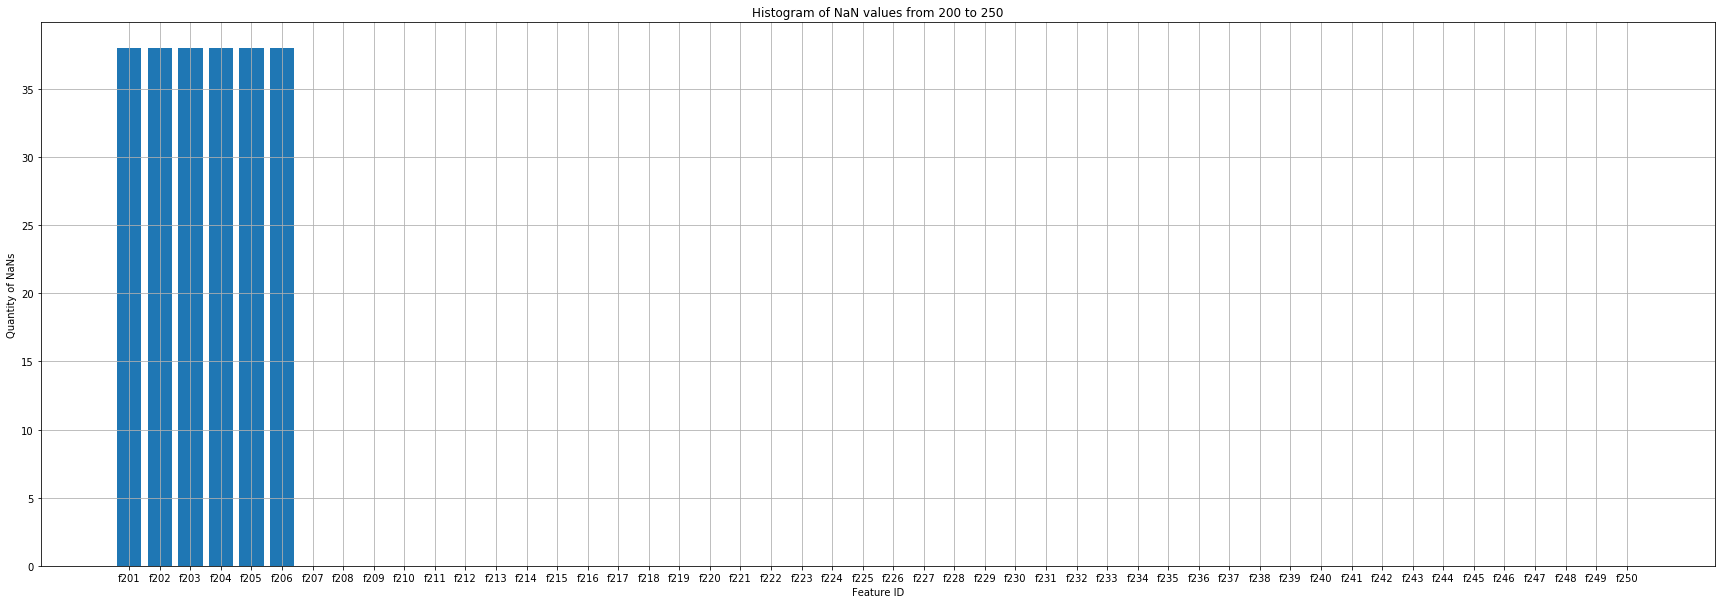

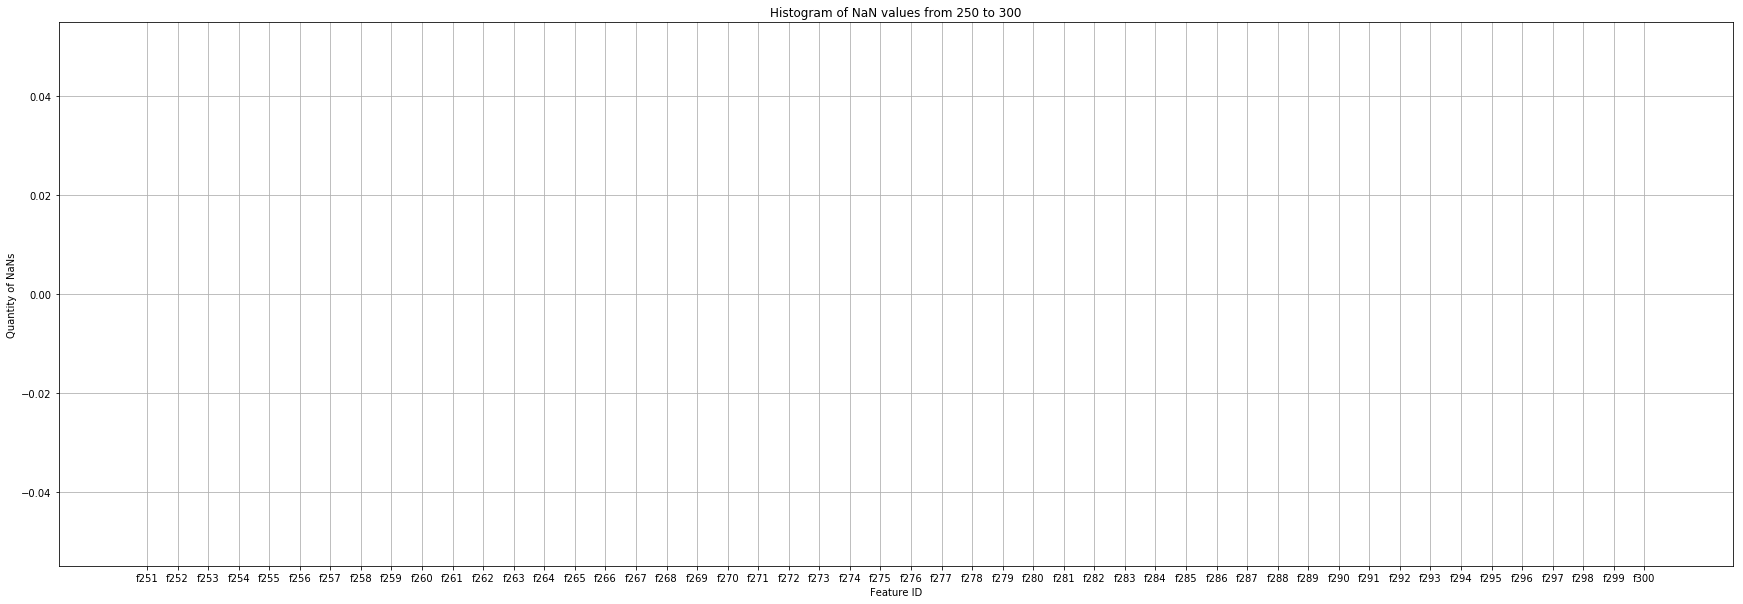

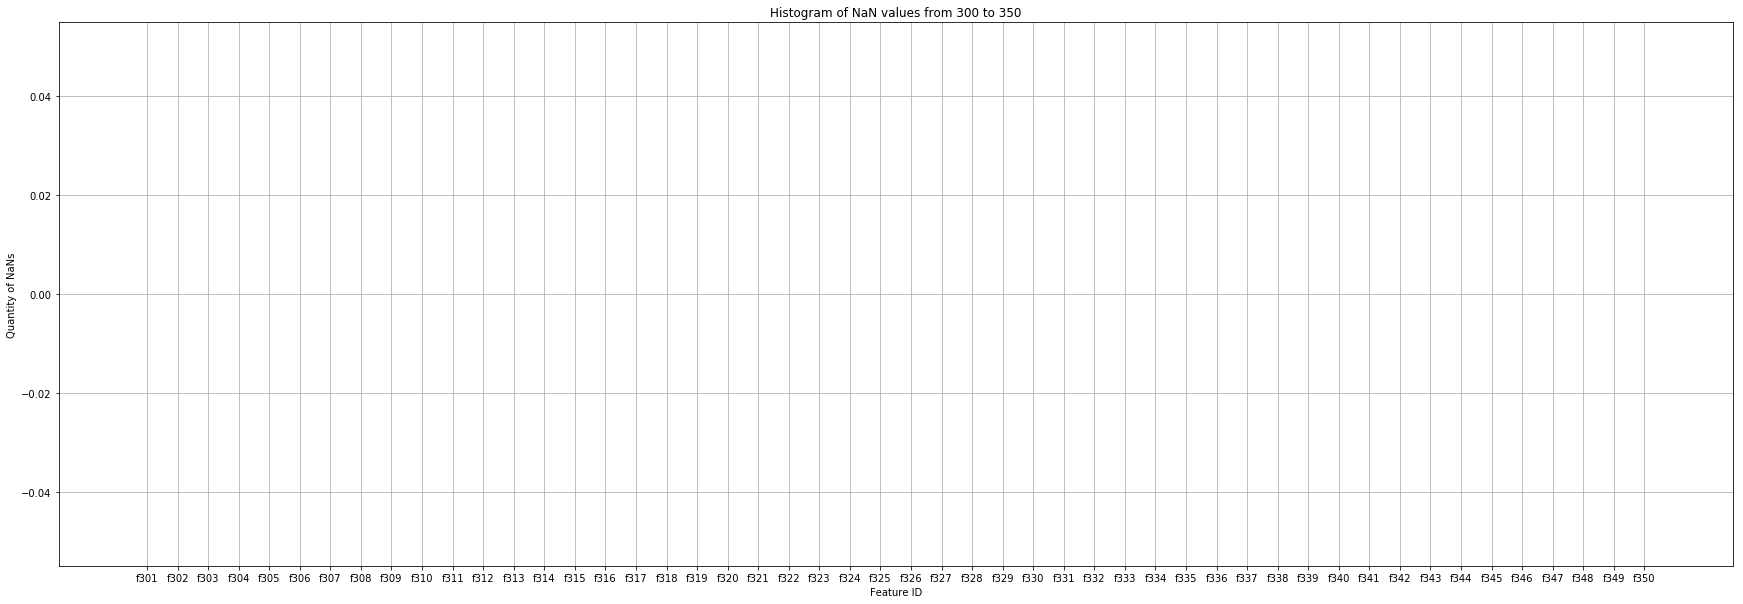

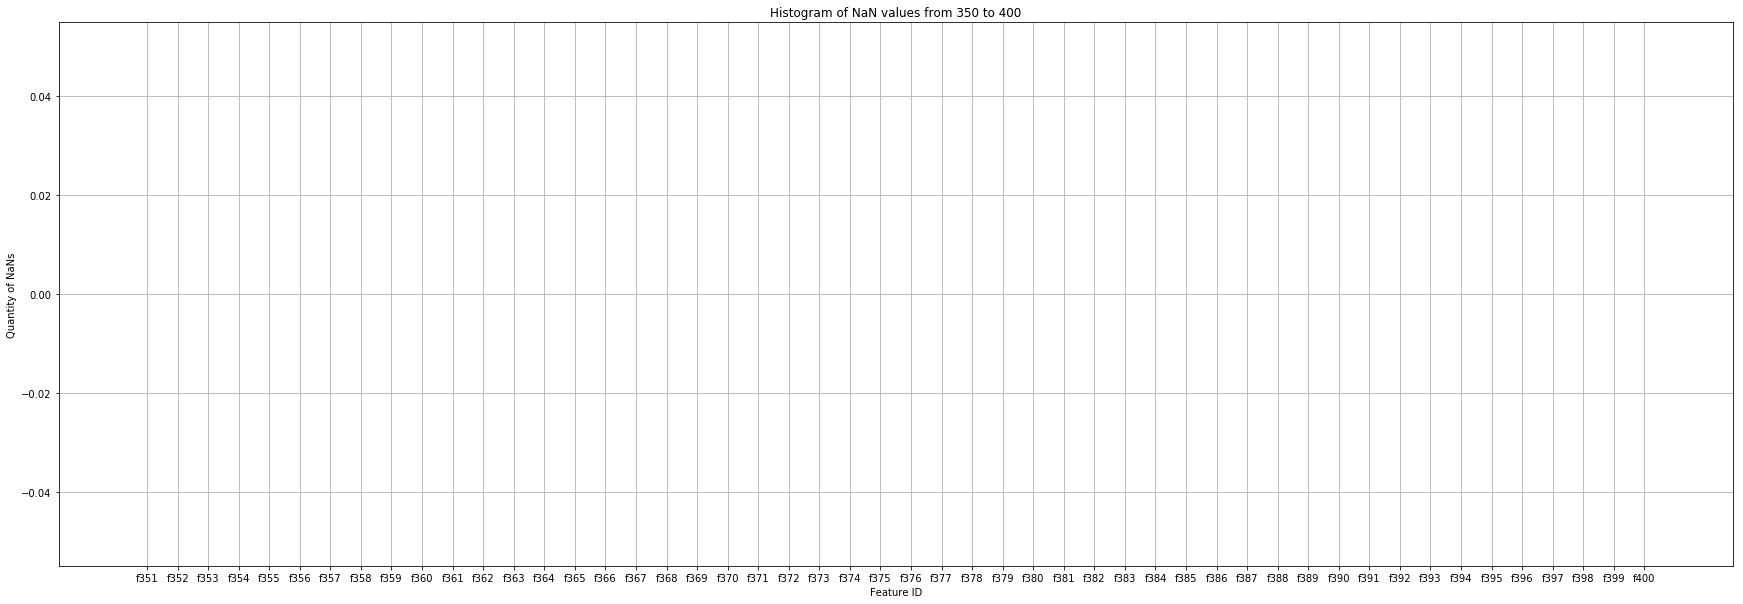

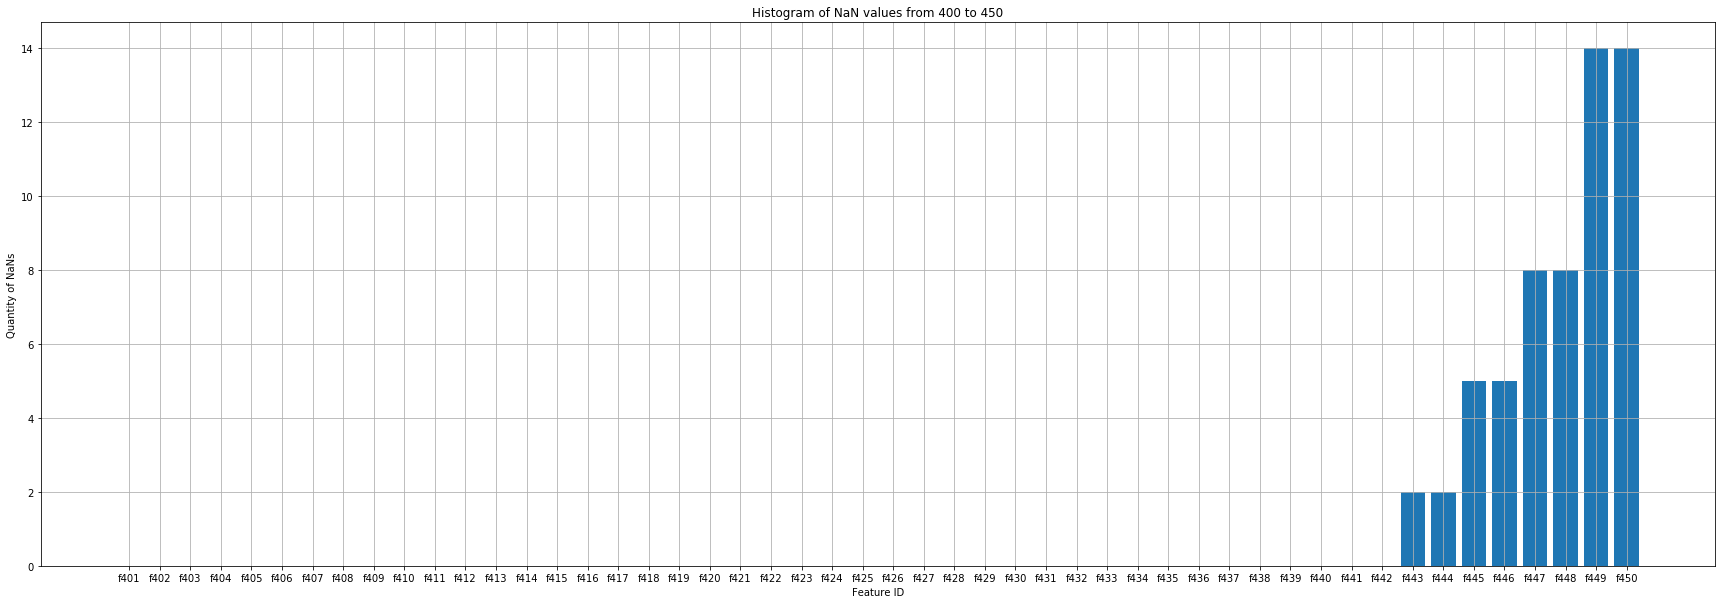

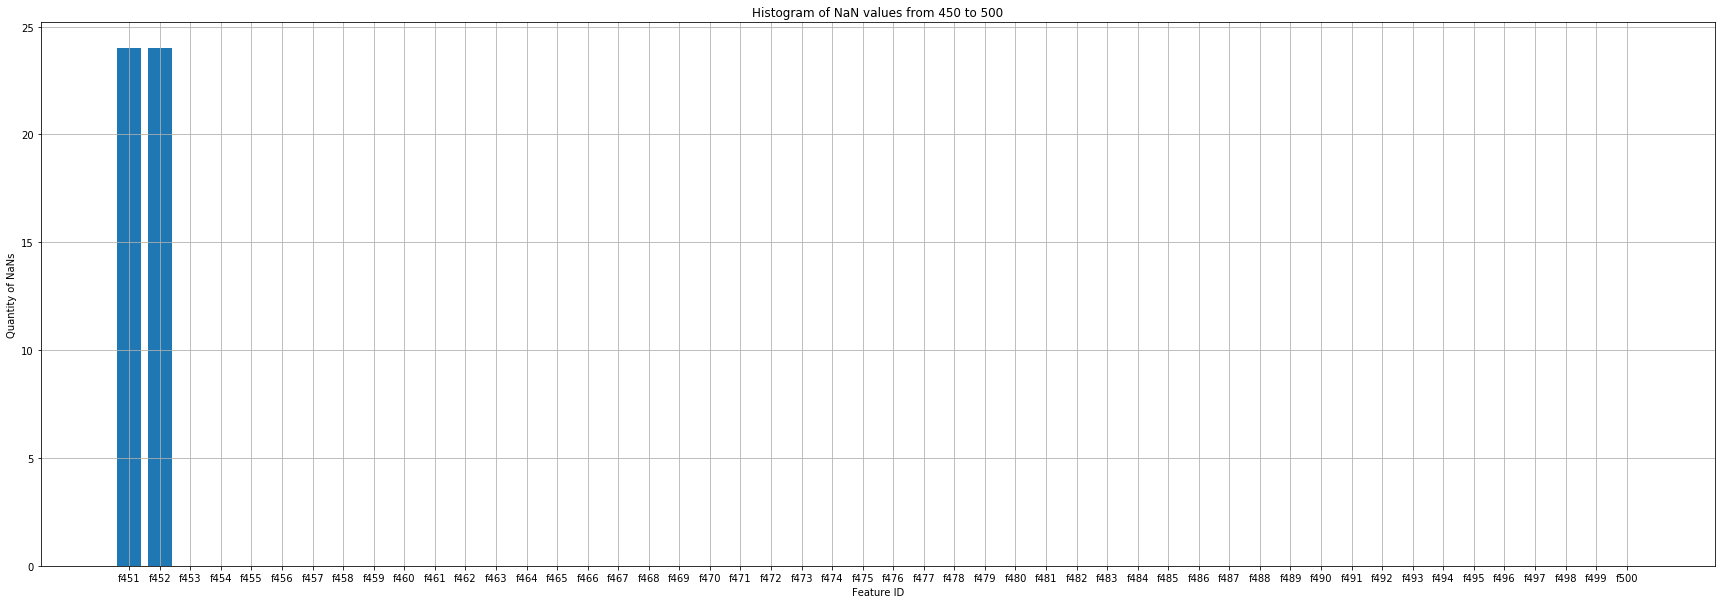

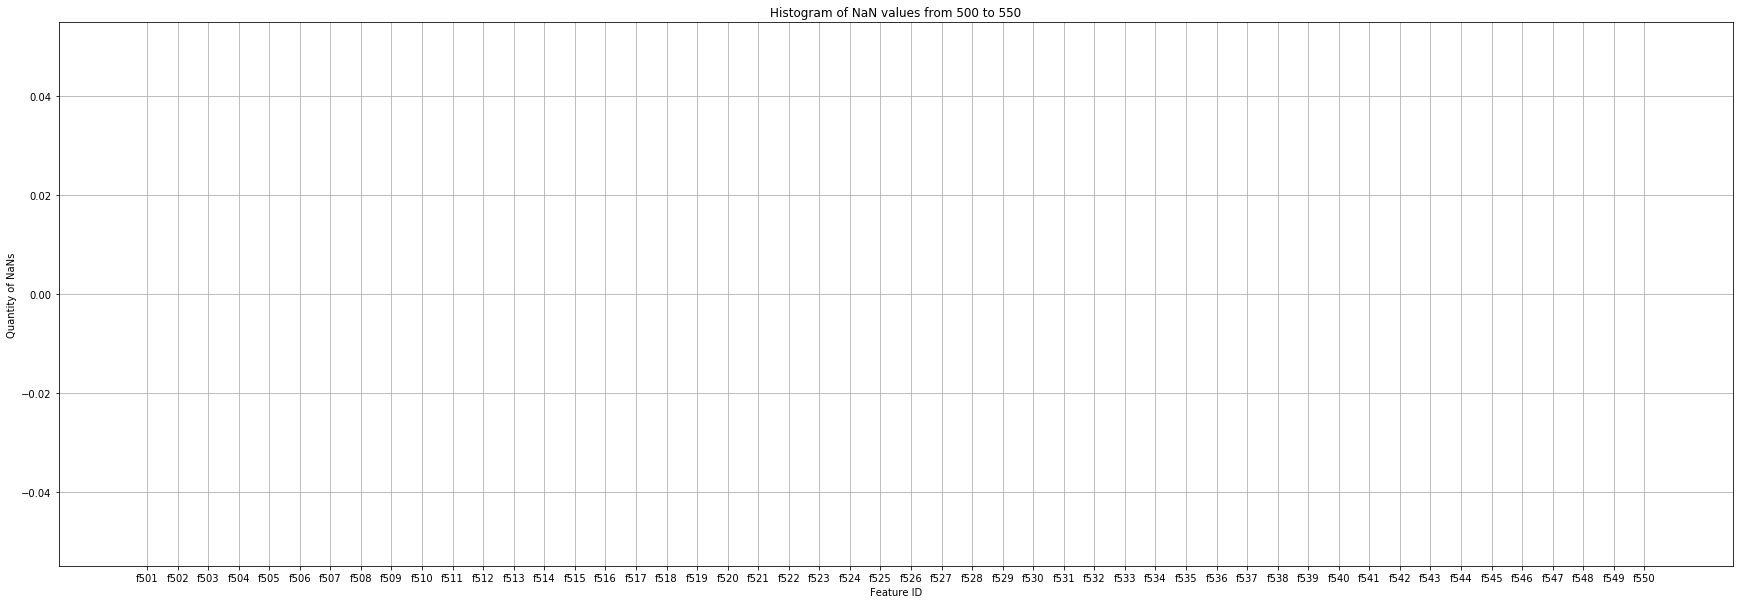

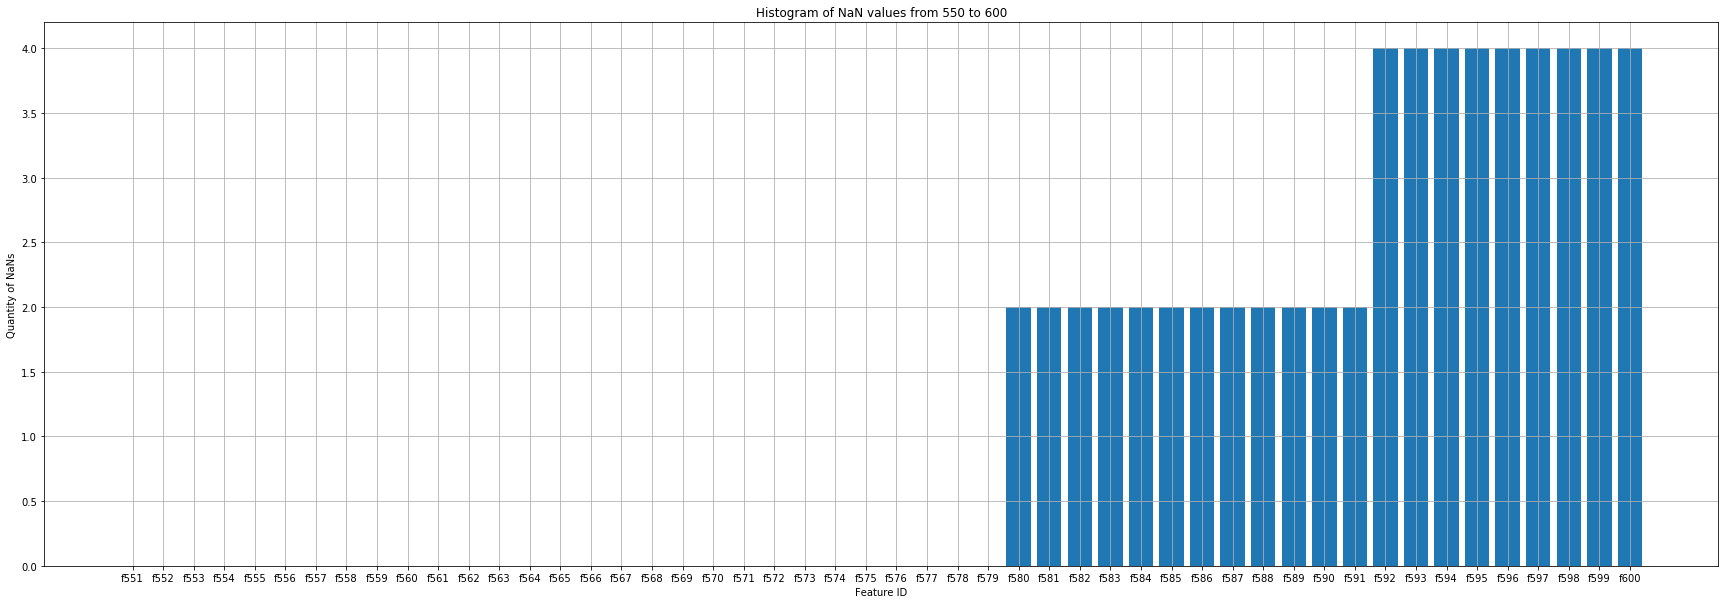

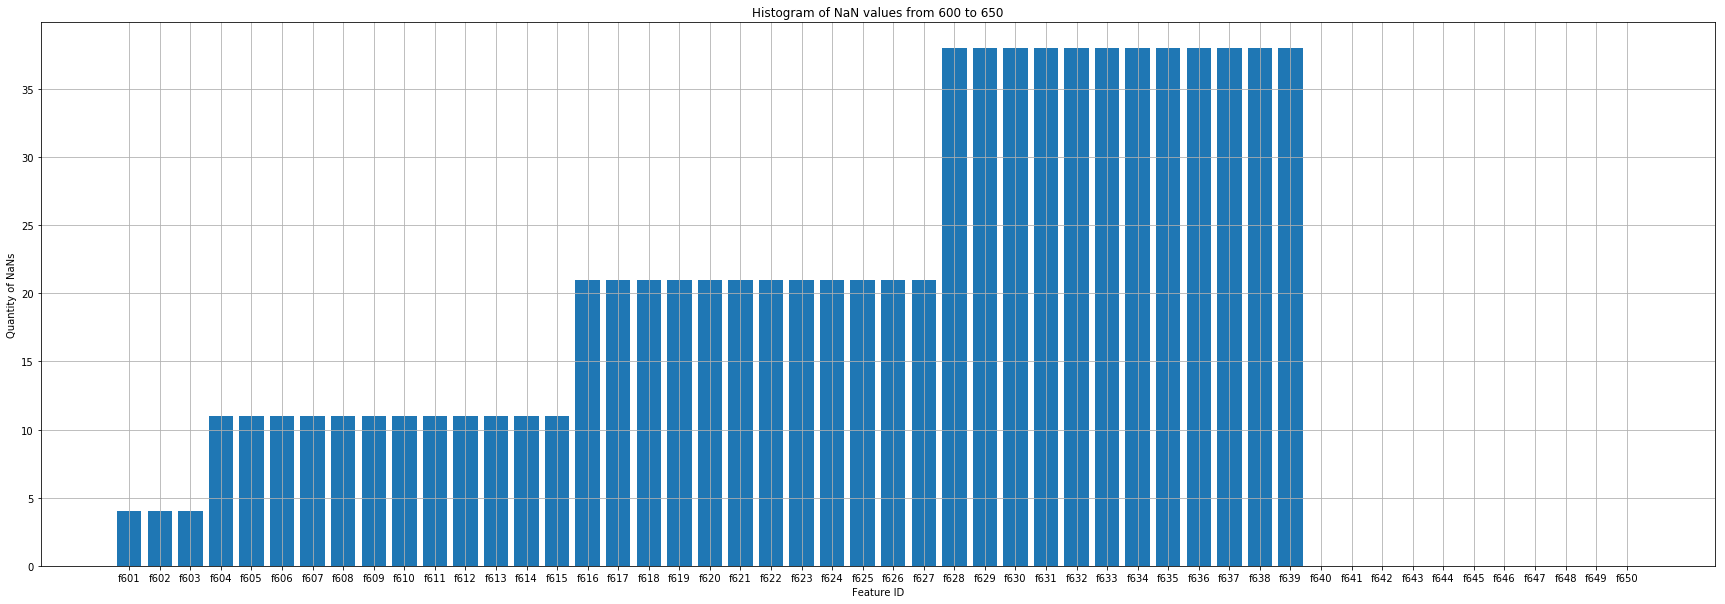

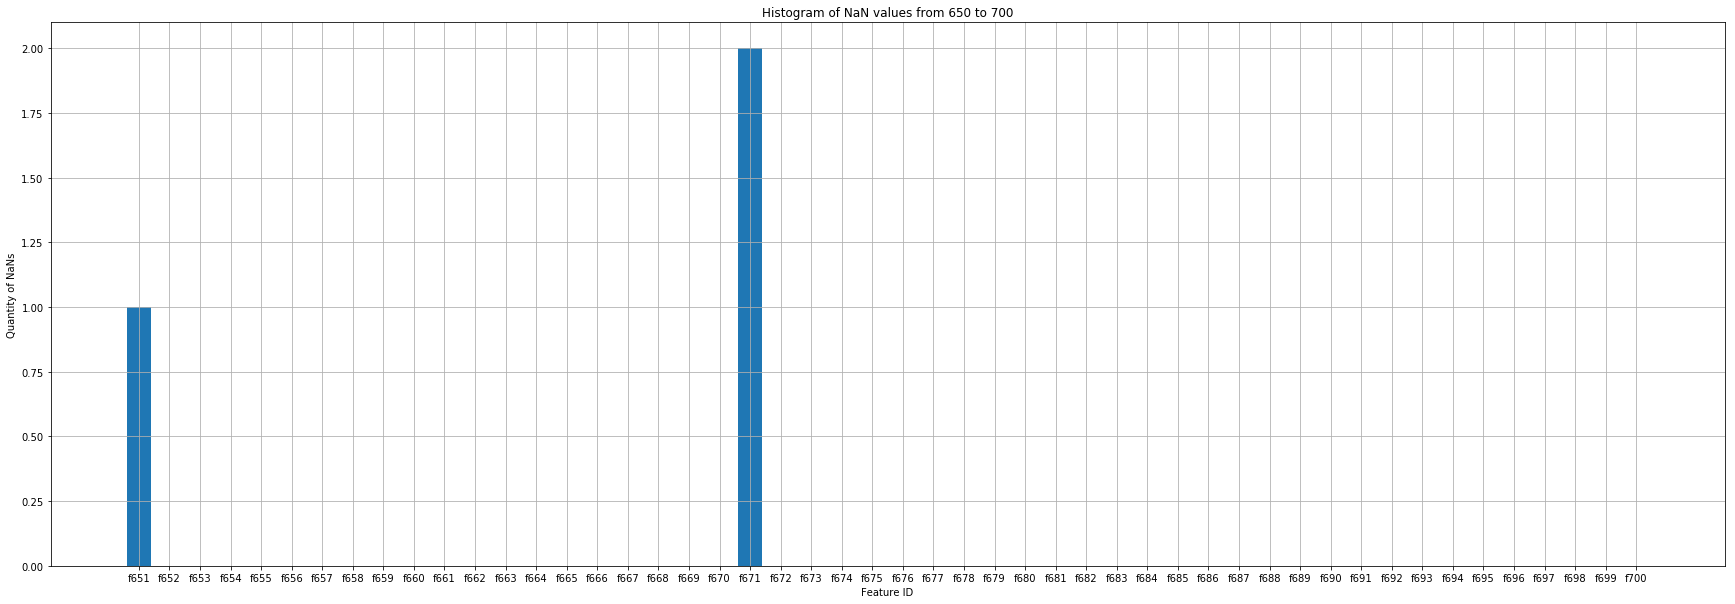

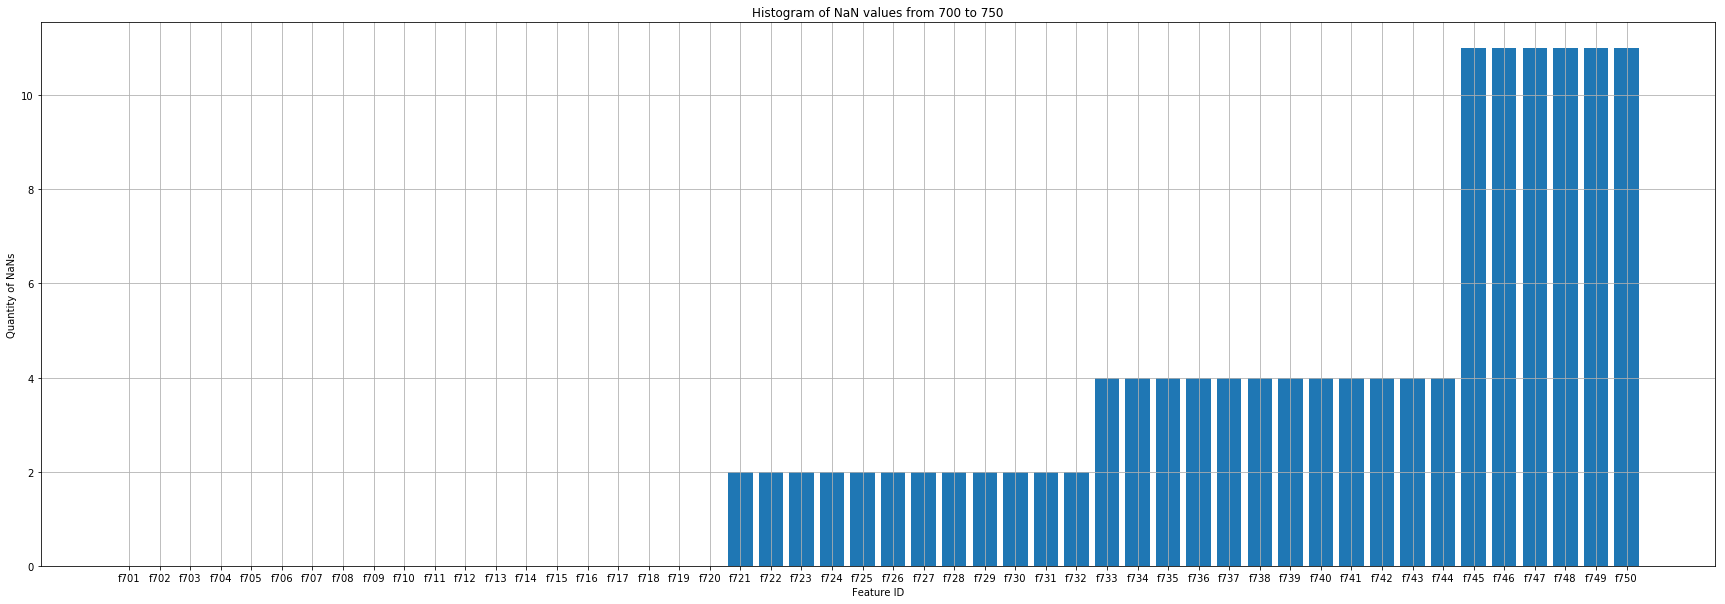

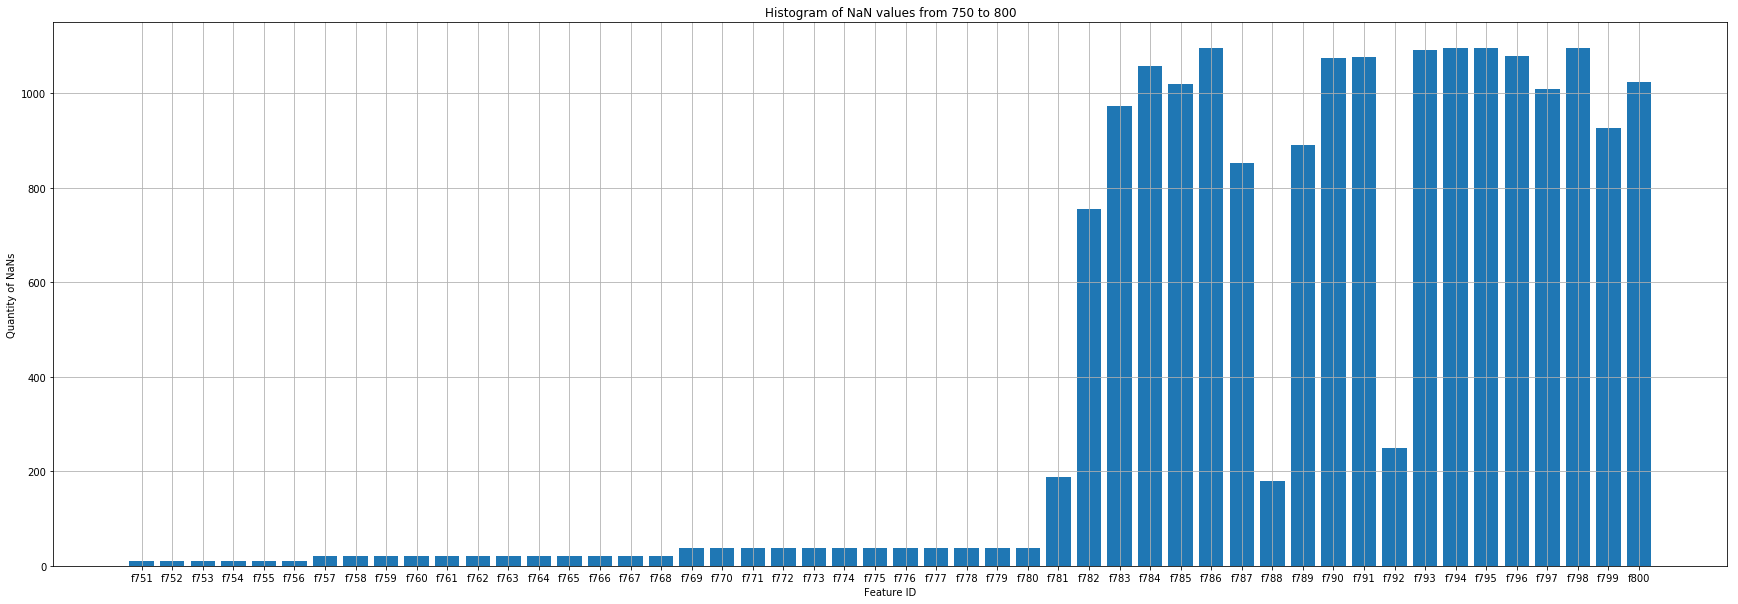

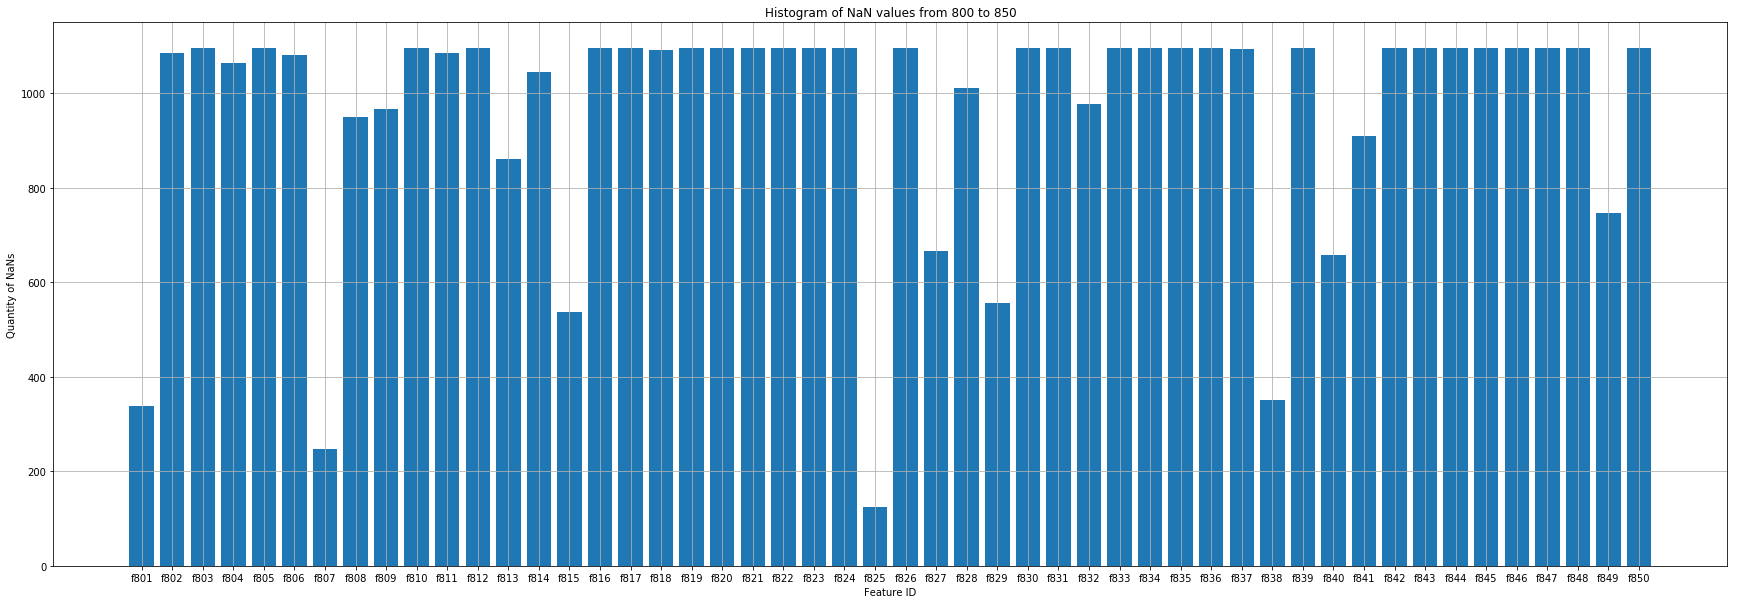

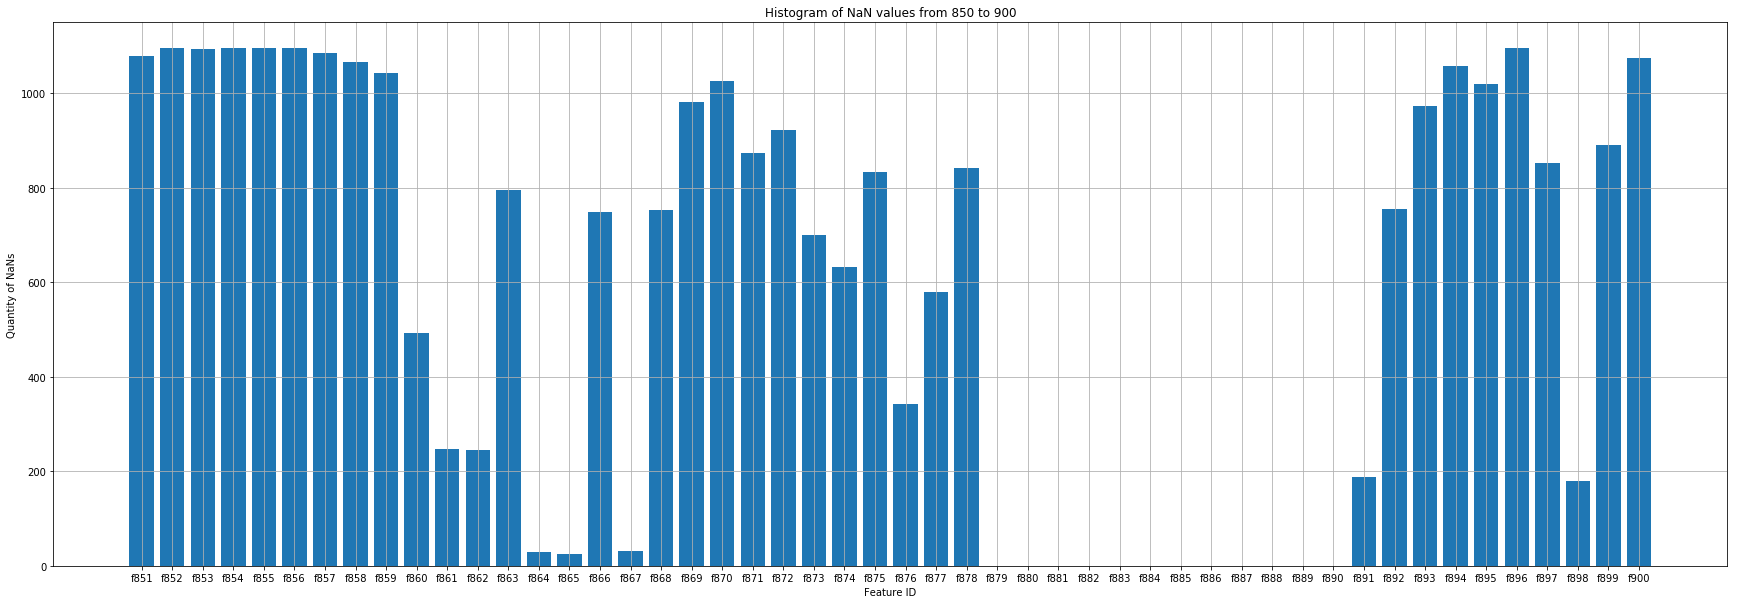

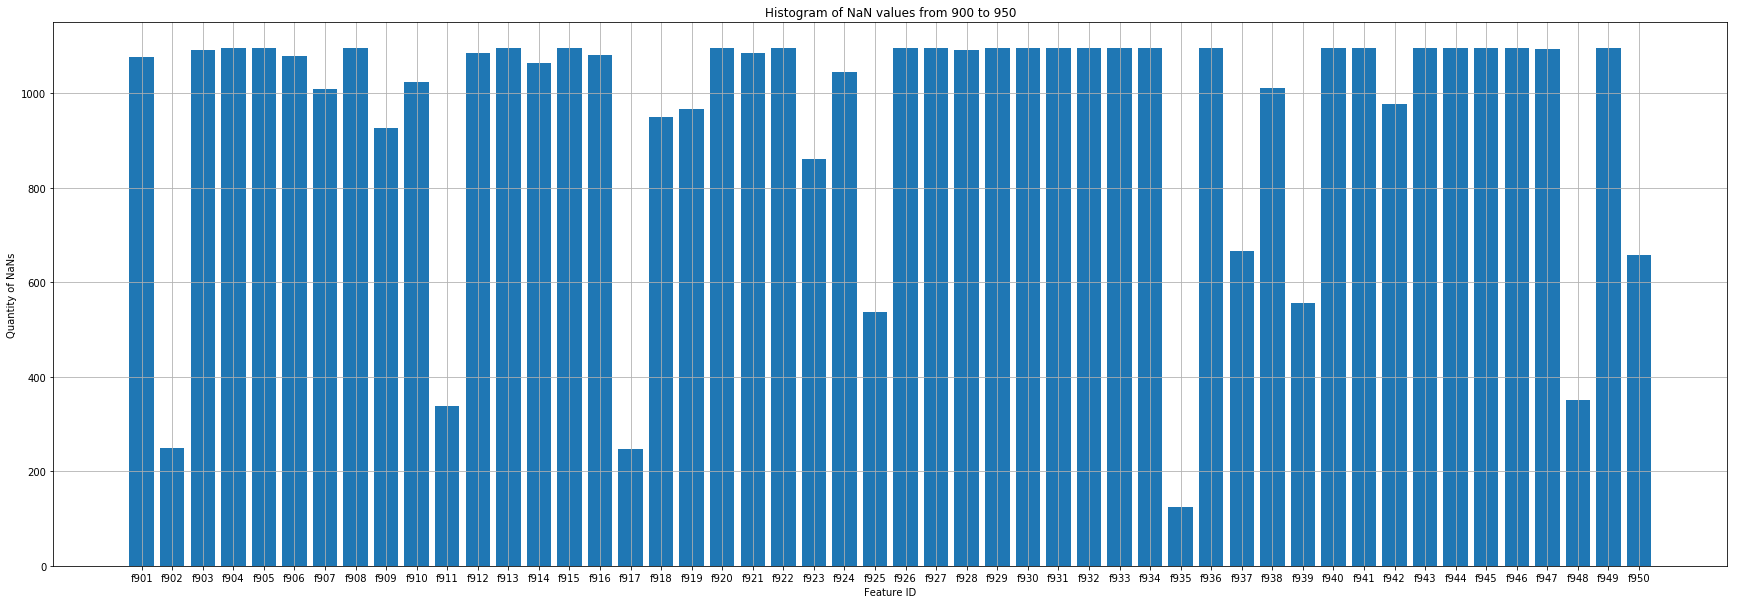

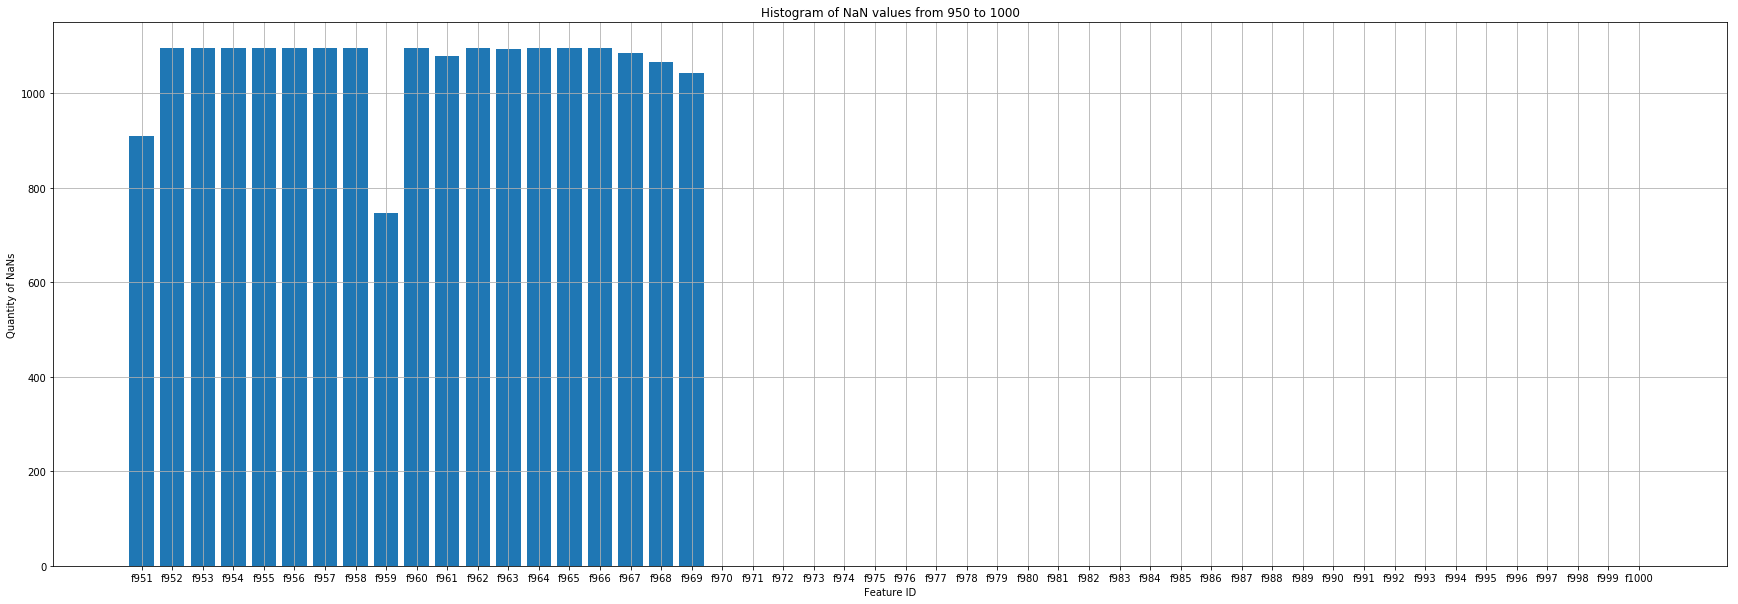

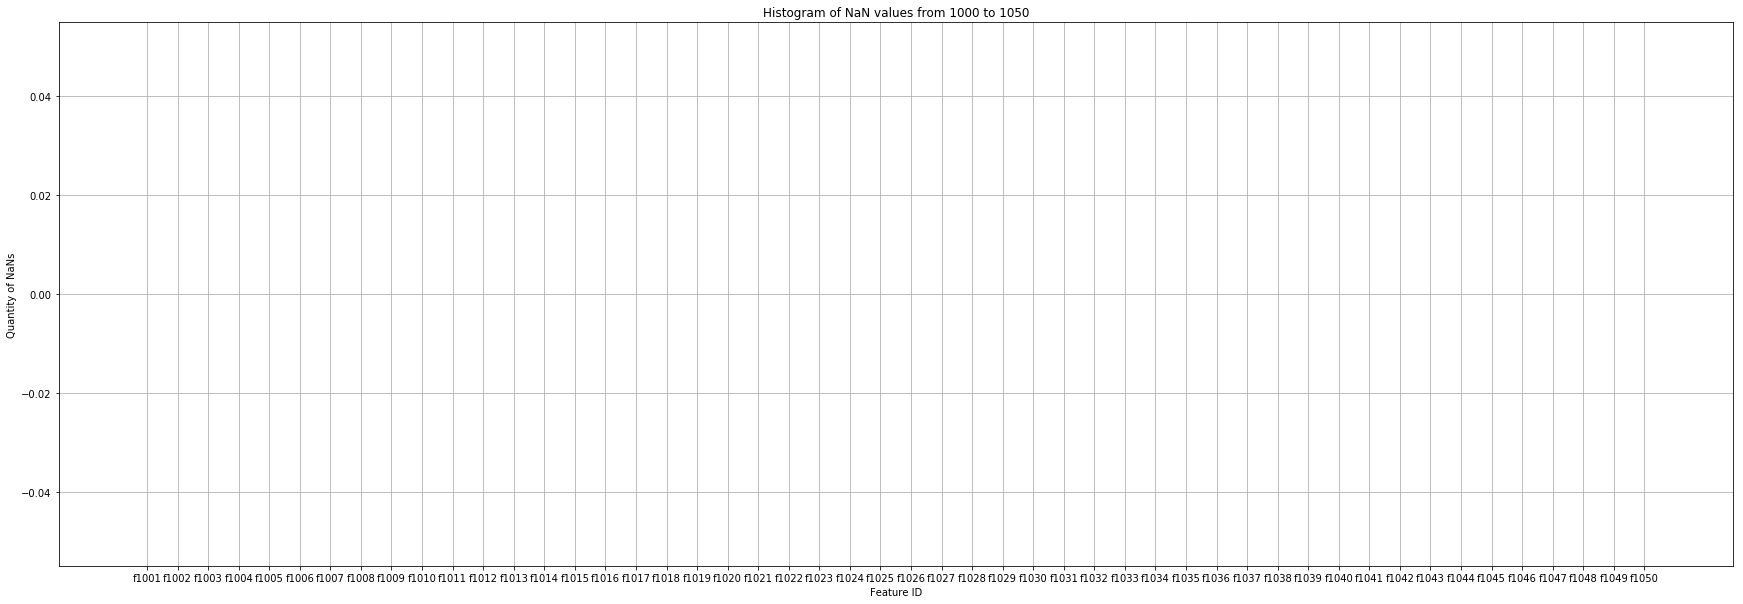

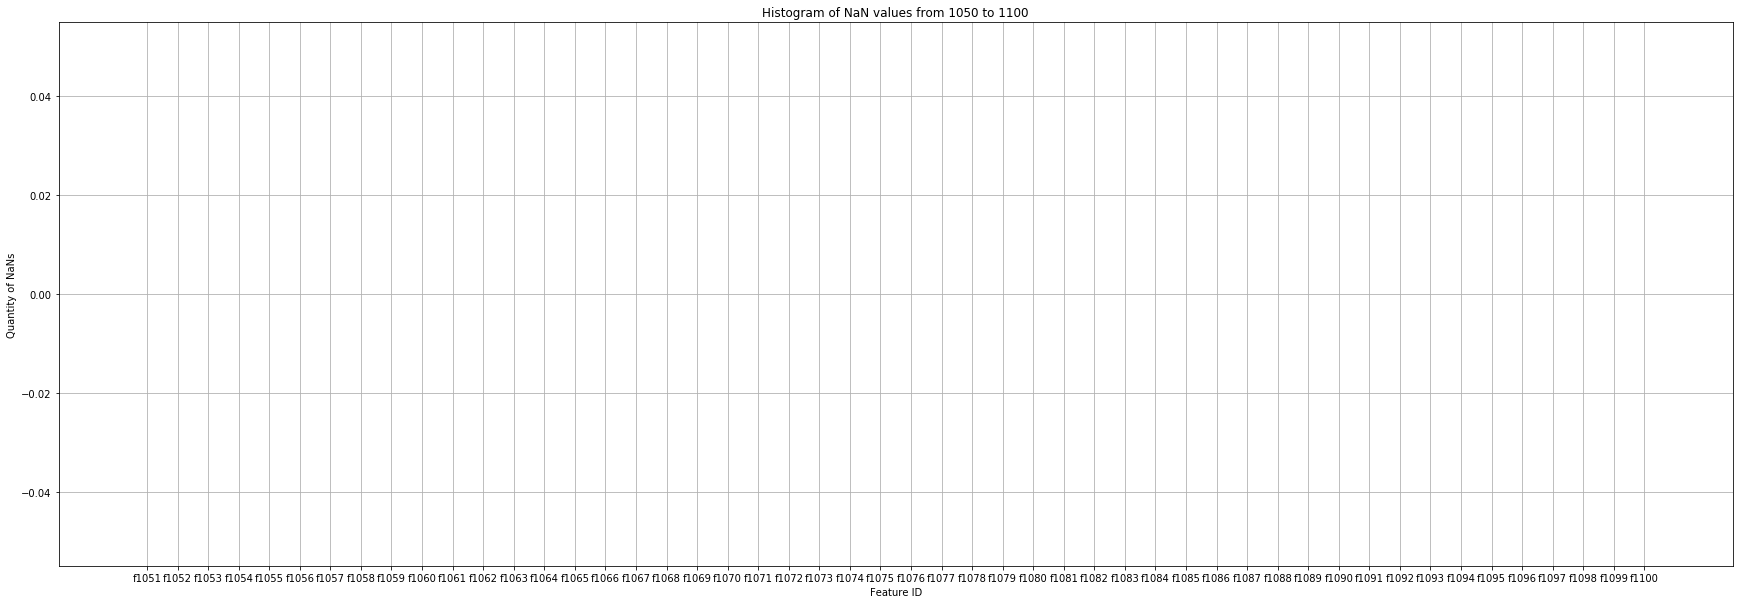

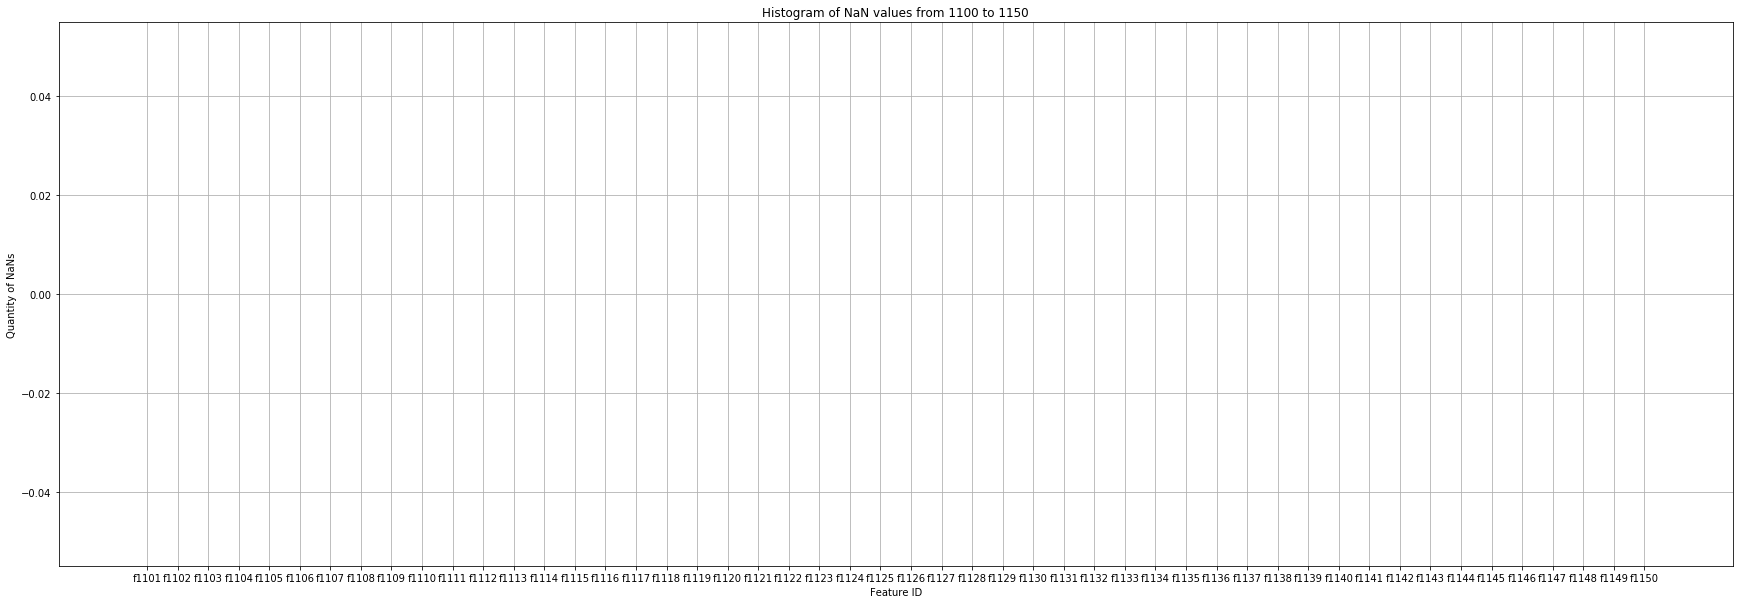

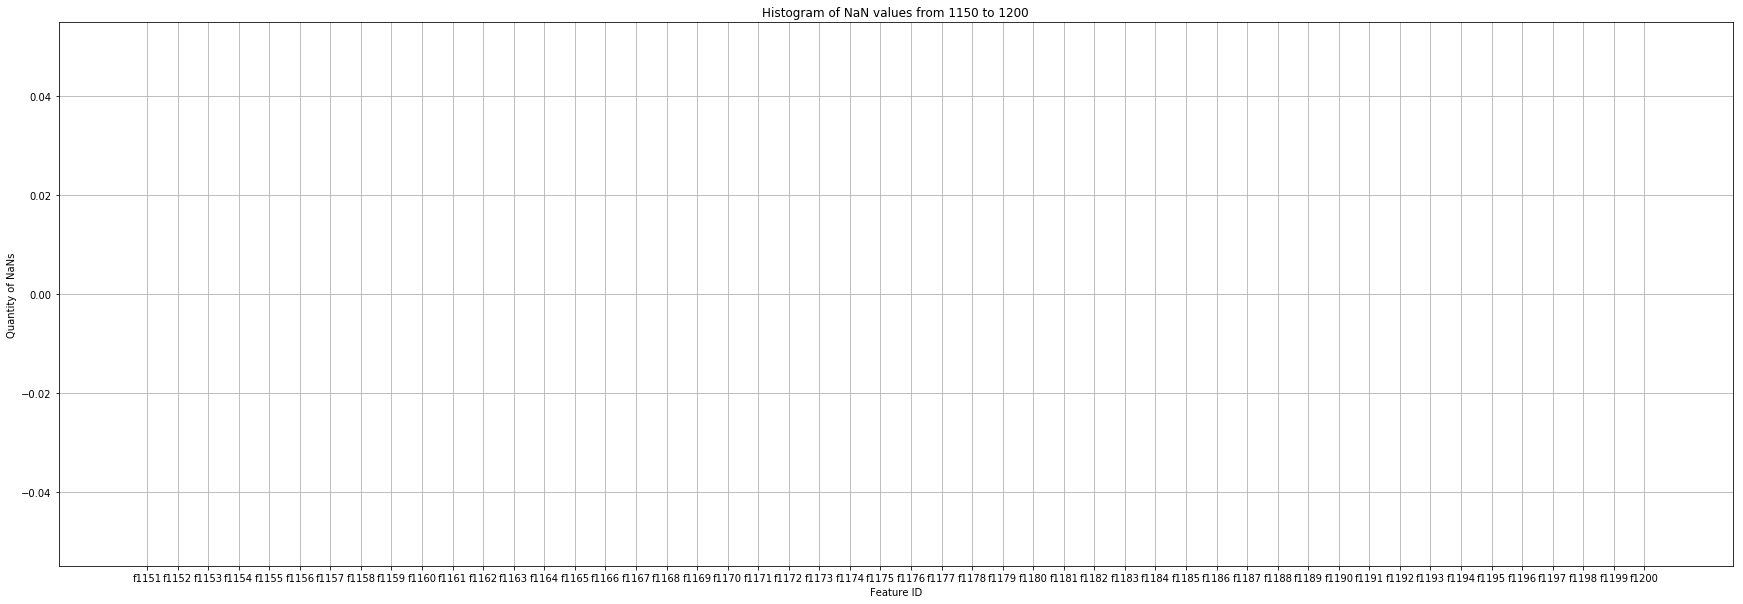

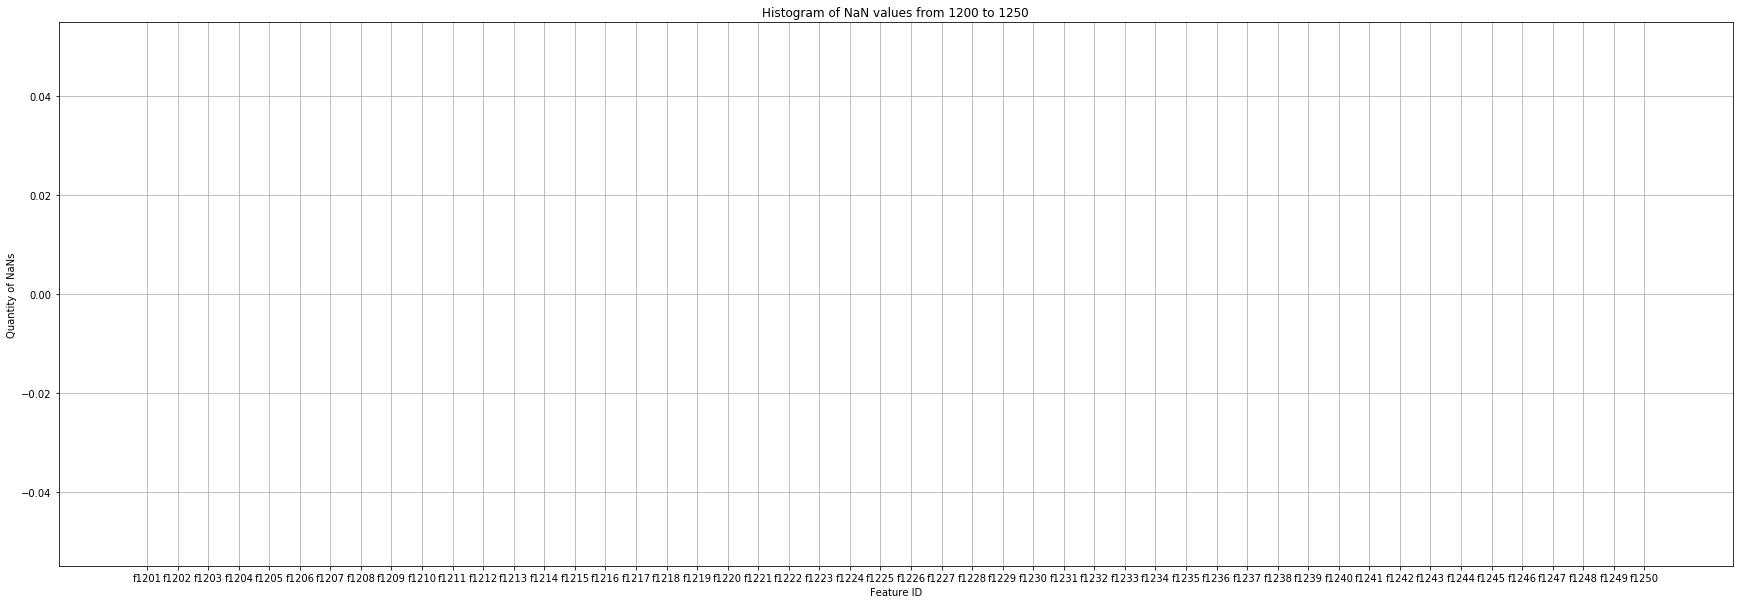

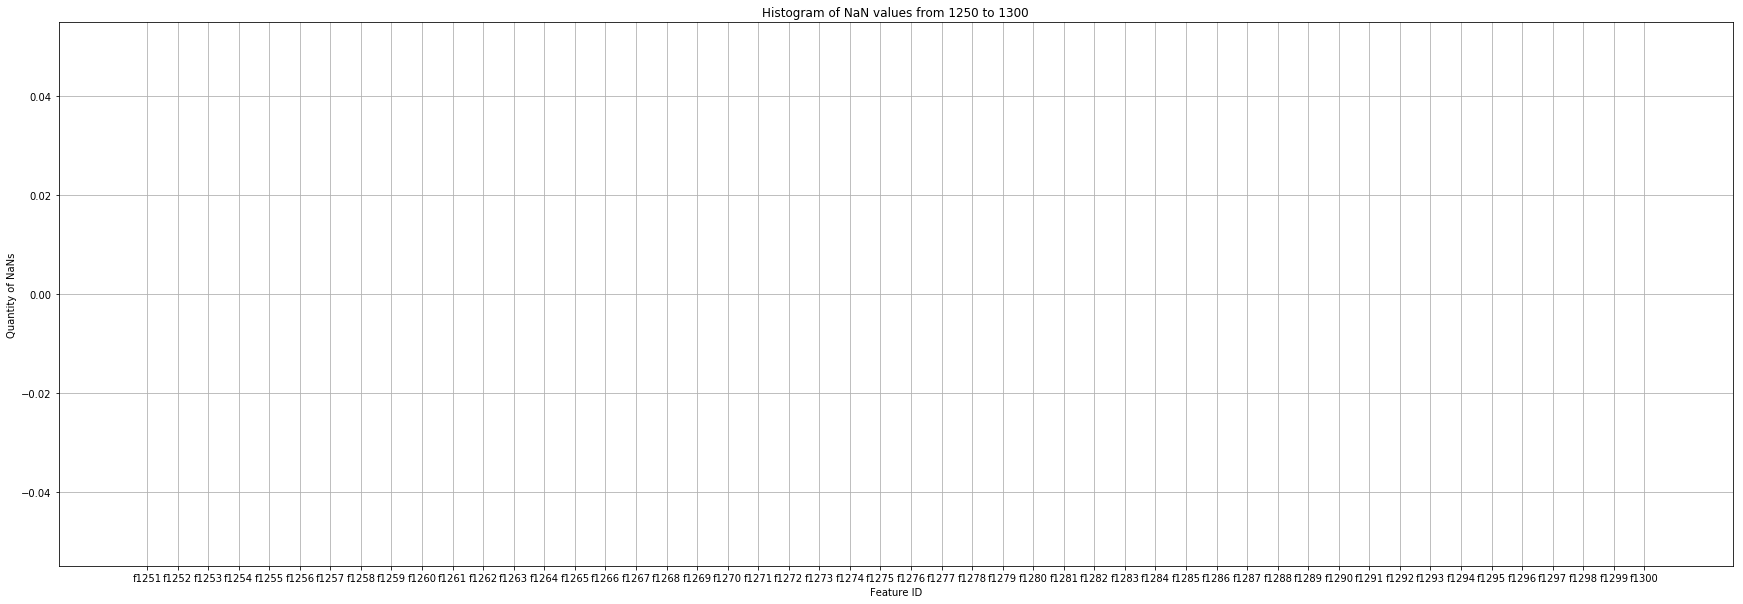

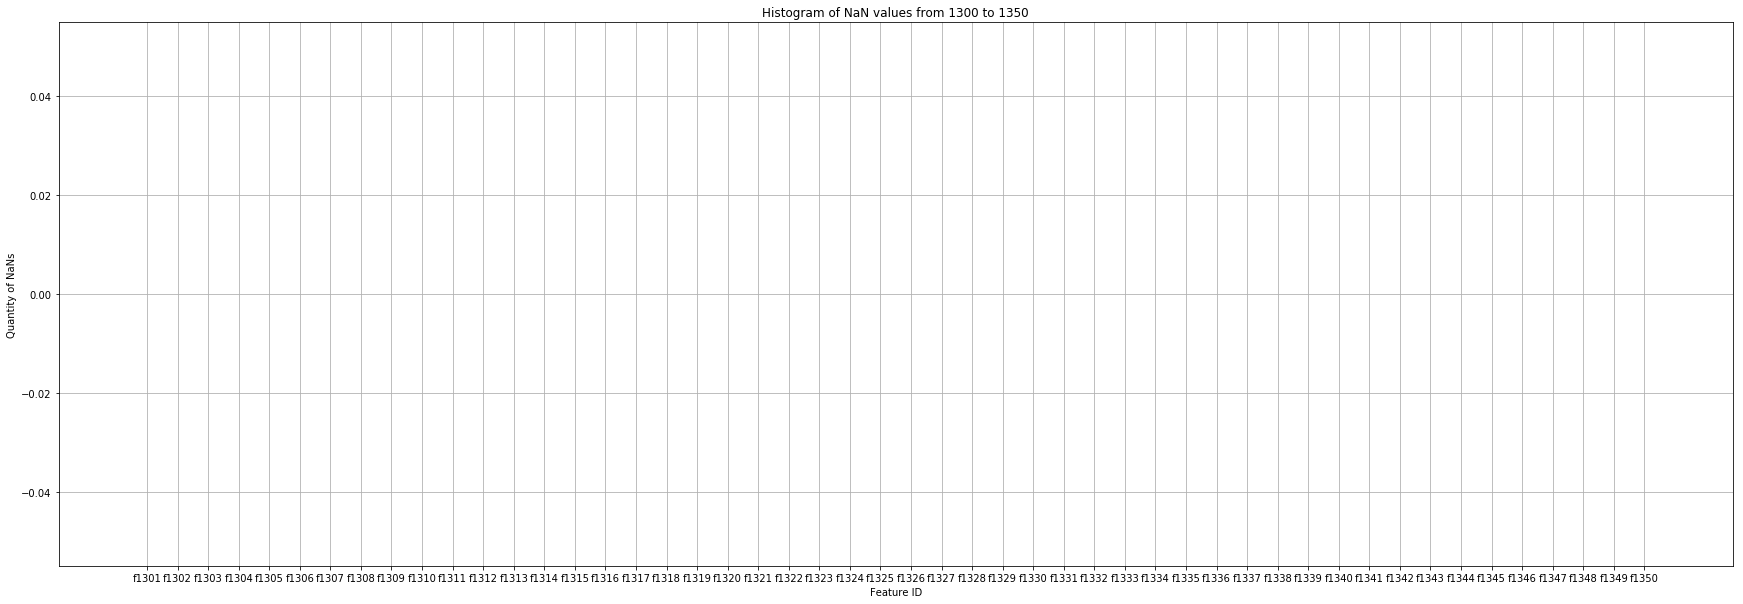

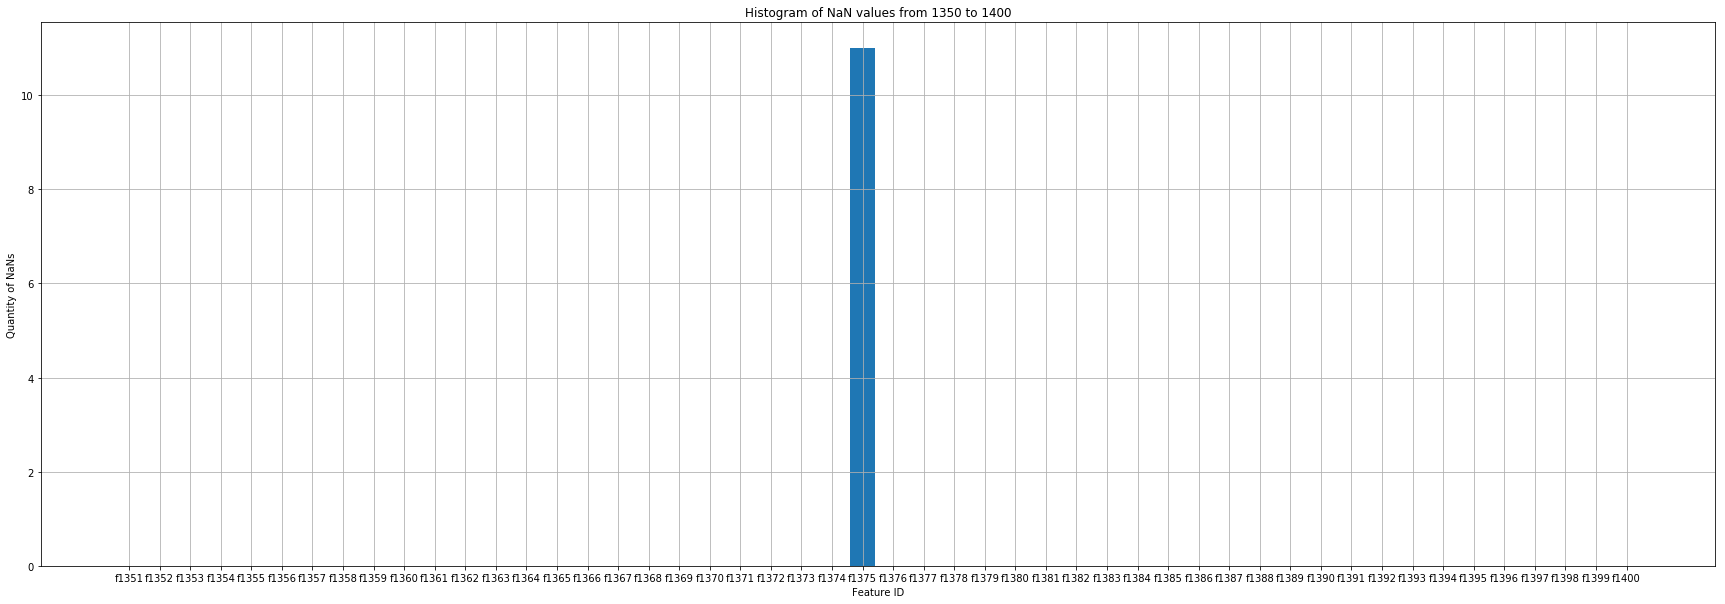

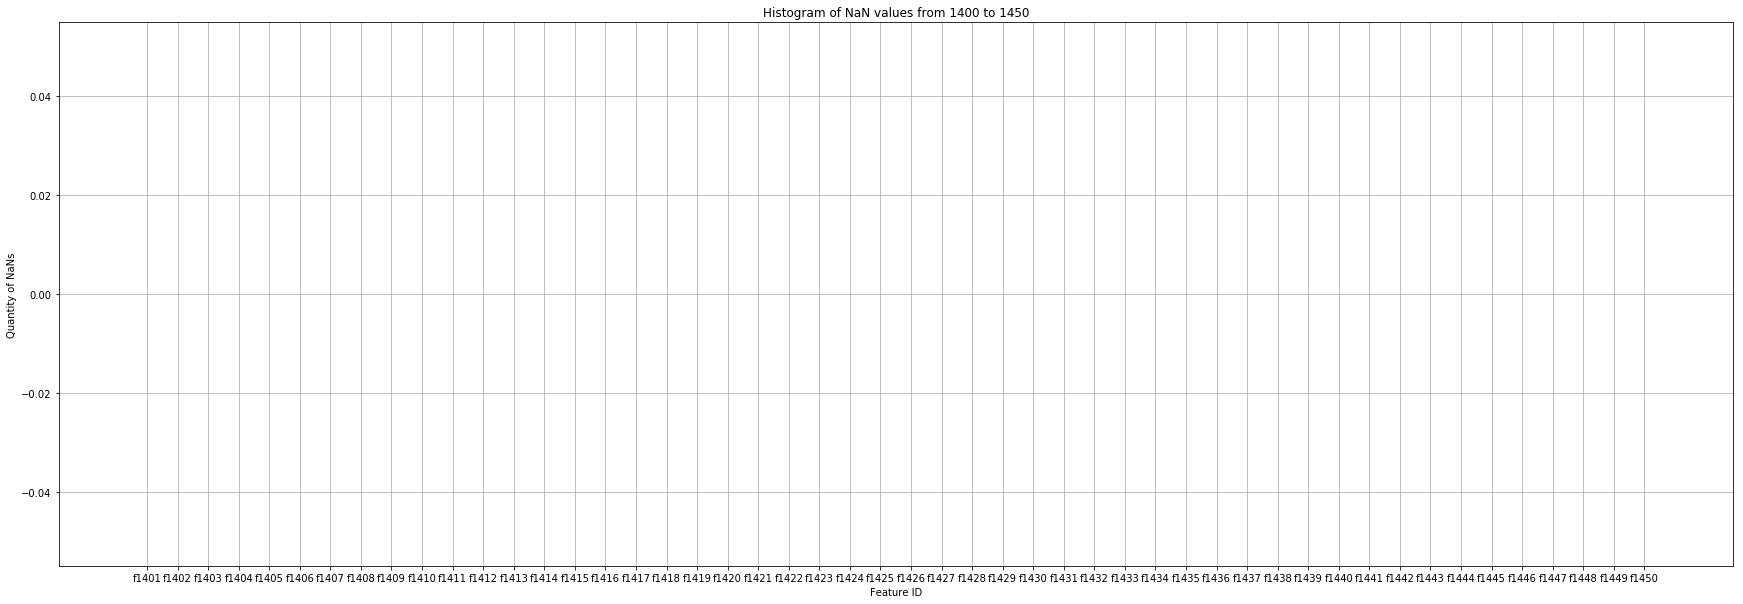

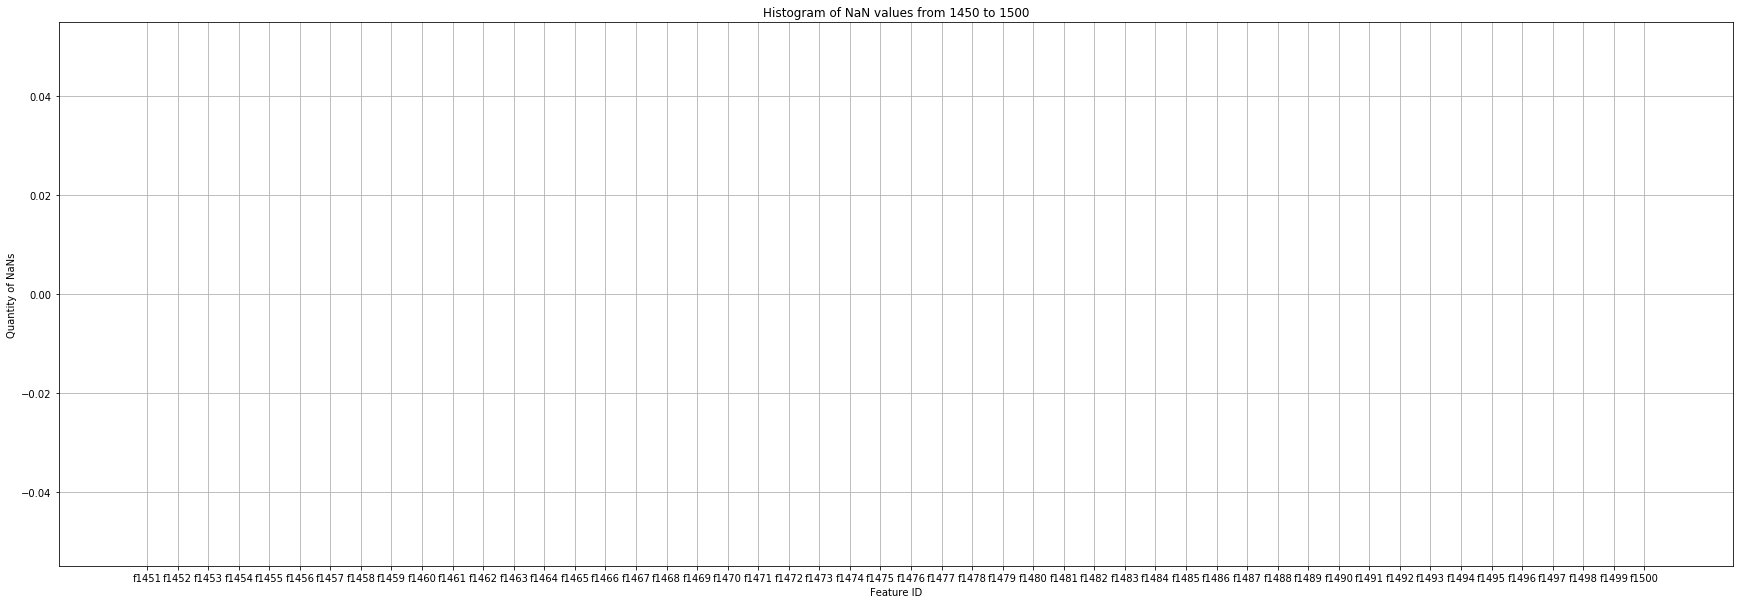

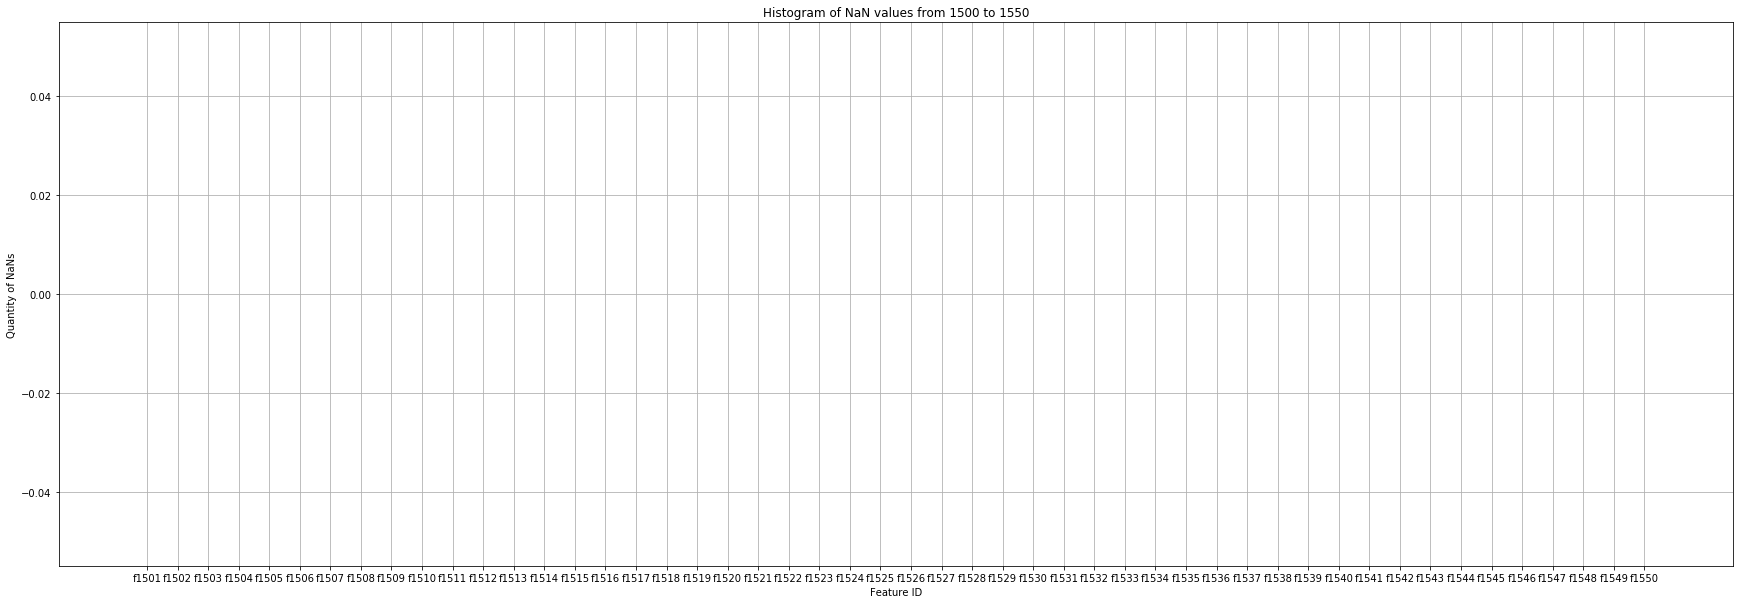

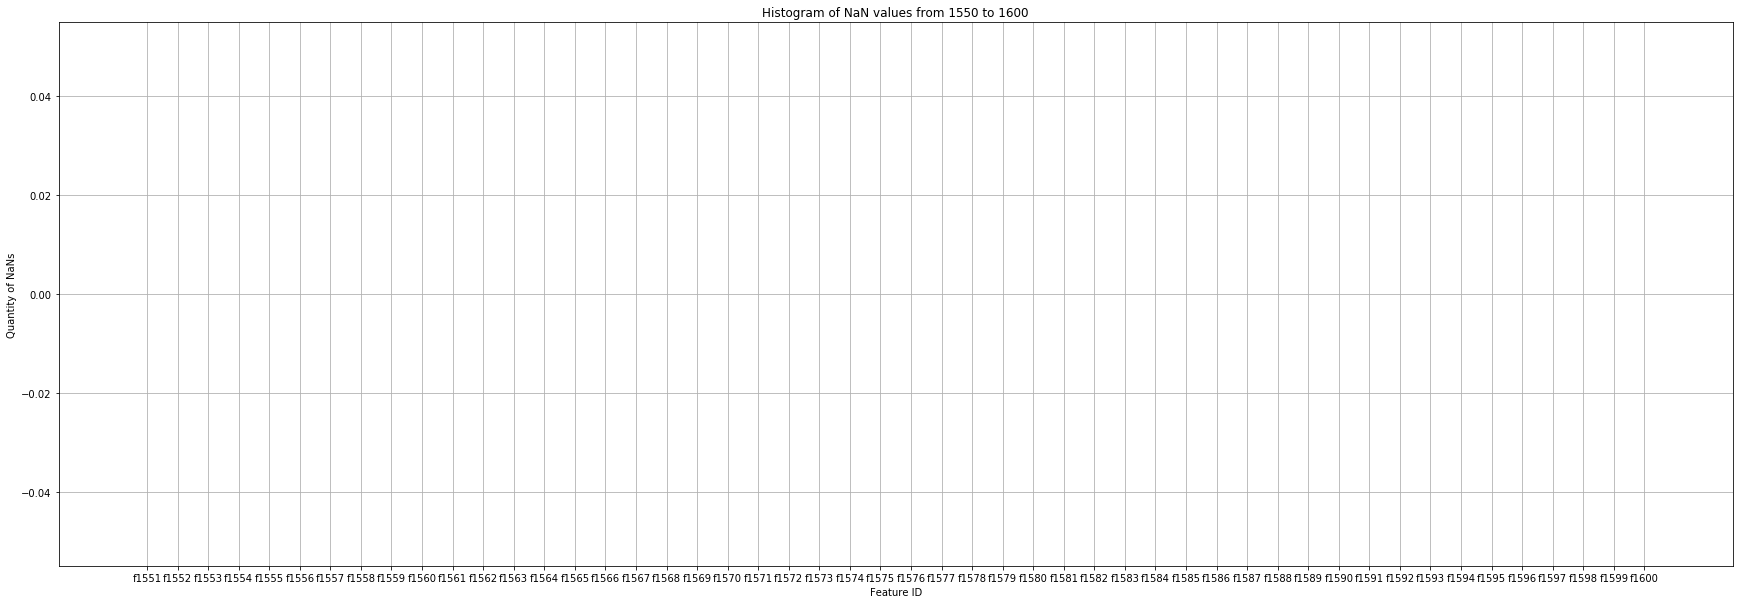

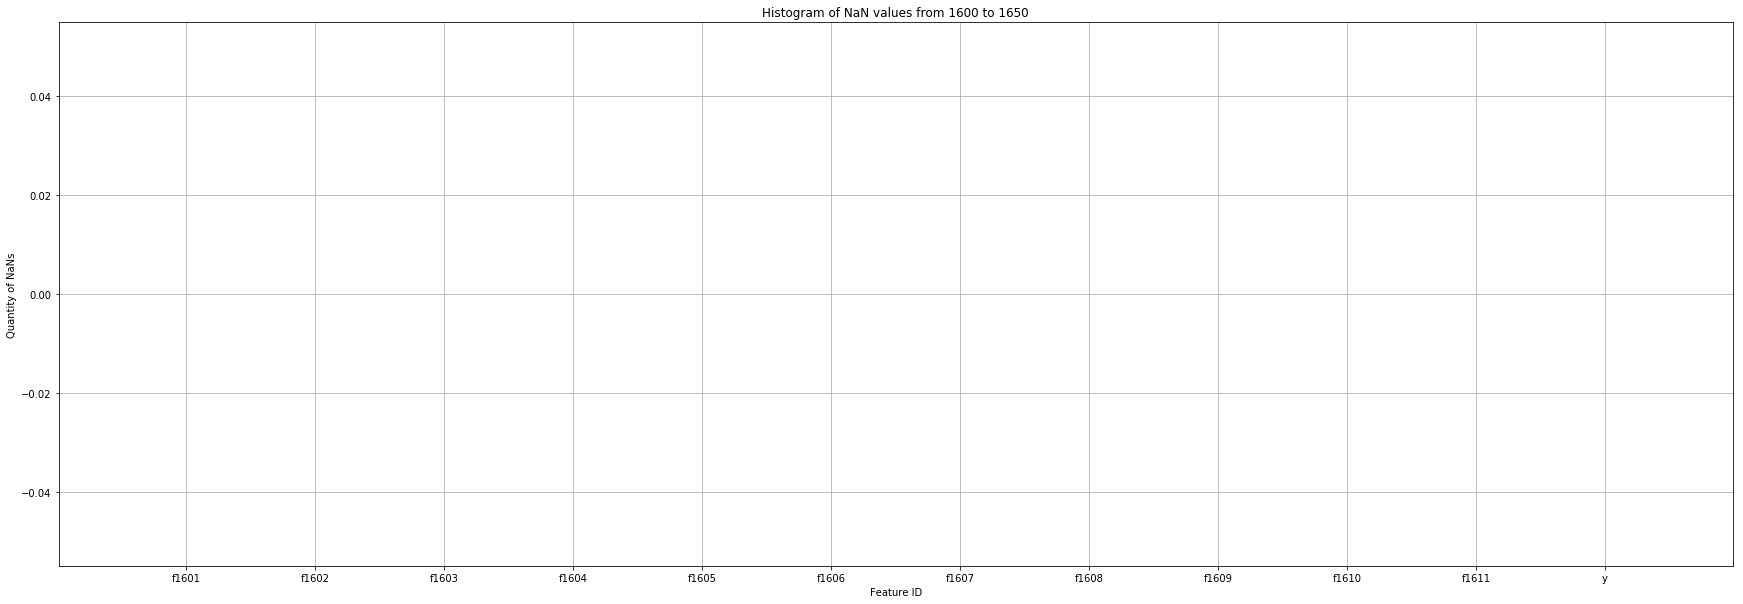

In [7]:
res = nan_calculating(train)

Как видно из распределений пропущенных данных, у некоторых предикторов пропущеных данных в разы больше, чем заполненных данных. Посмотрим, у каких предикторов пропусков больше всего.

In [8]:
def nan_proccessing(res, rang=(0,0)):
    """
    This function return name of predictors, 
    which nan or inf values are in specific range 
    """
    ans = 0
    predictors = []
    for key,value in res.items():
        if value >= rang[0] and value <= rang[1]:
            ans += 1
            predictors.append(key)
    return ans, predictors      

Выберем предикторы, у которых пропусков больше, чем 10

In [9]:
num, emptys = nan_proccessing(res, (10,10000))

Посчитаем количество inf-элементов

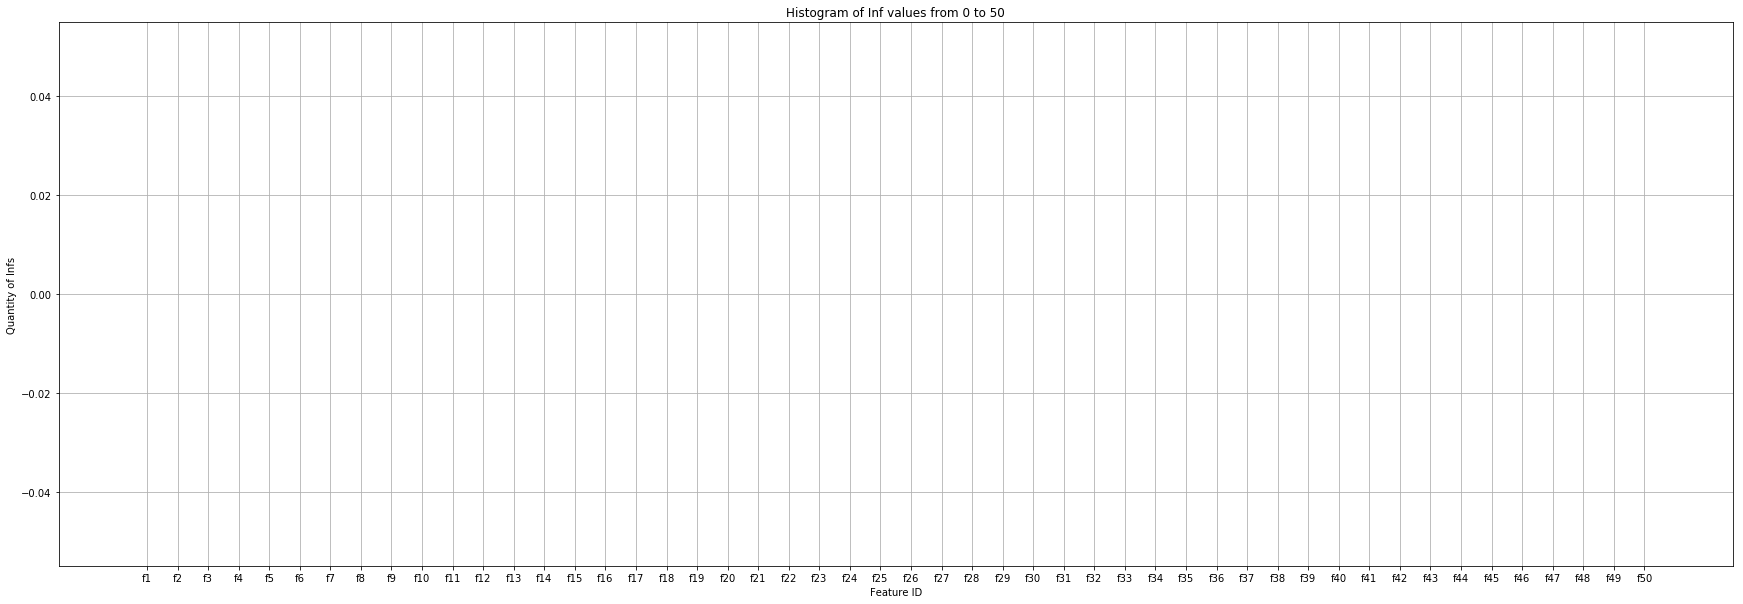

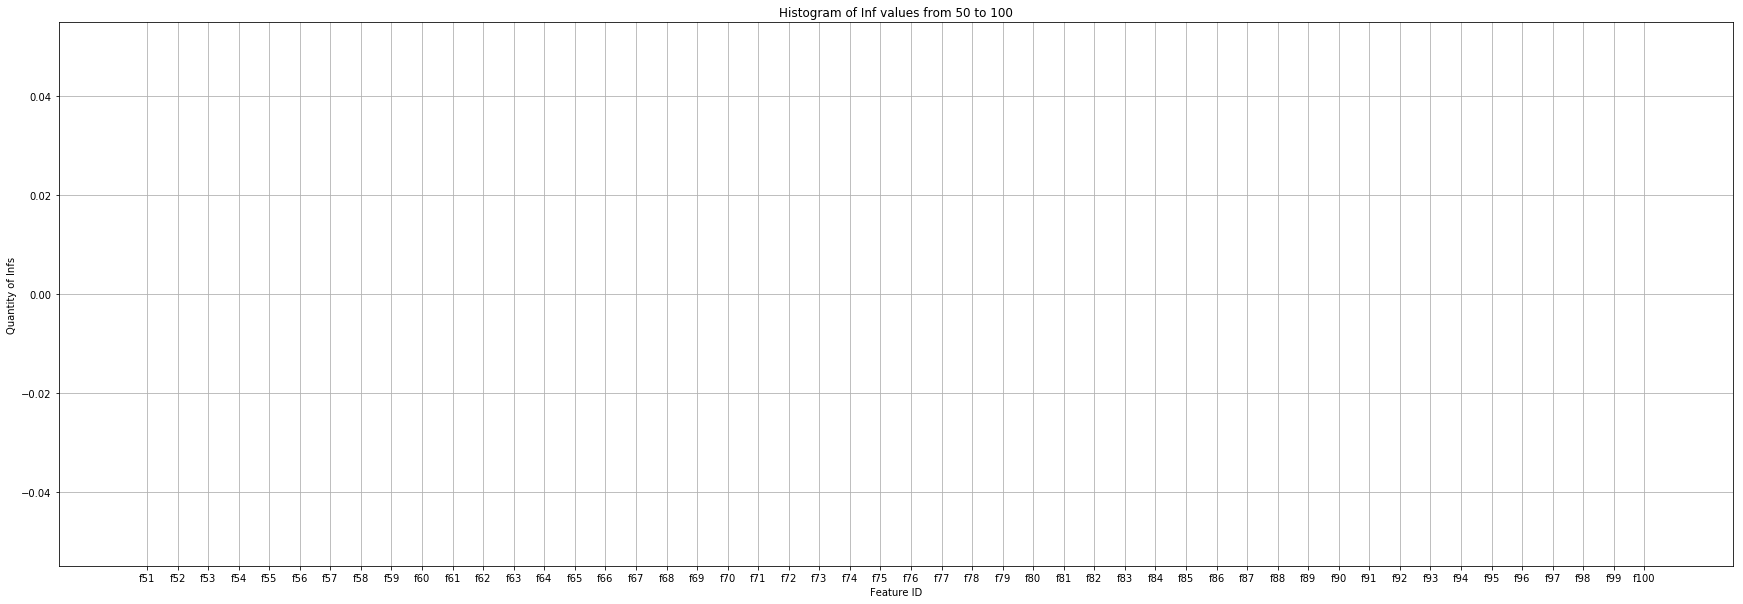

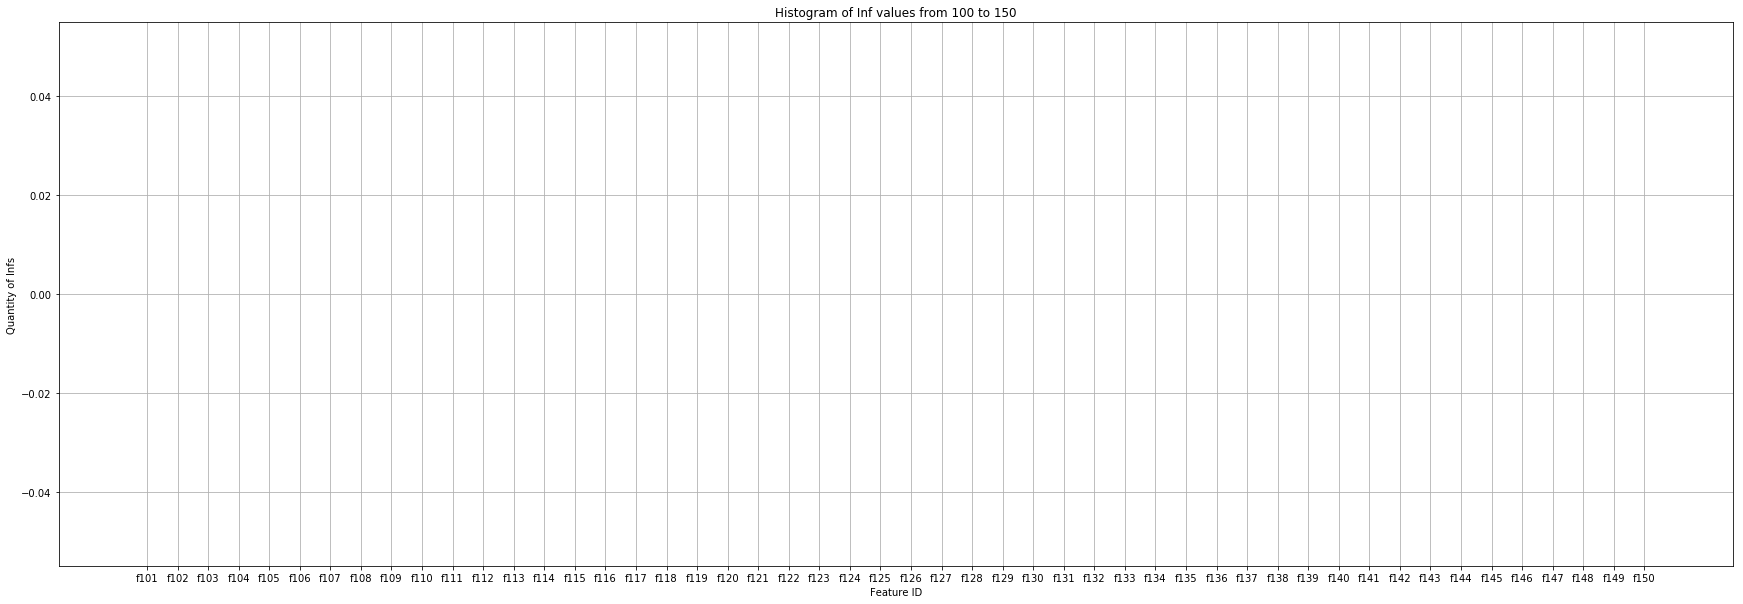

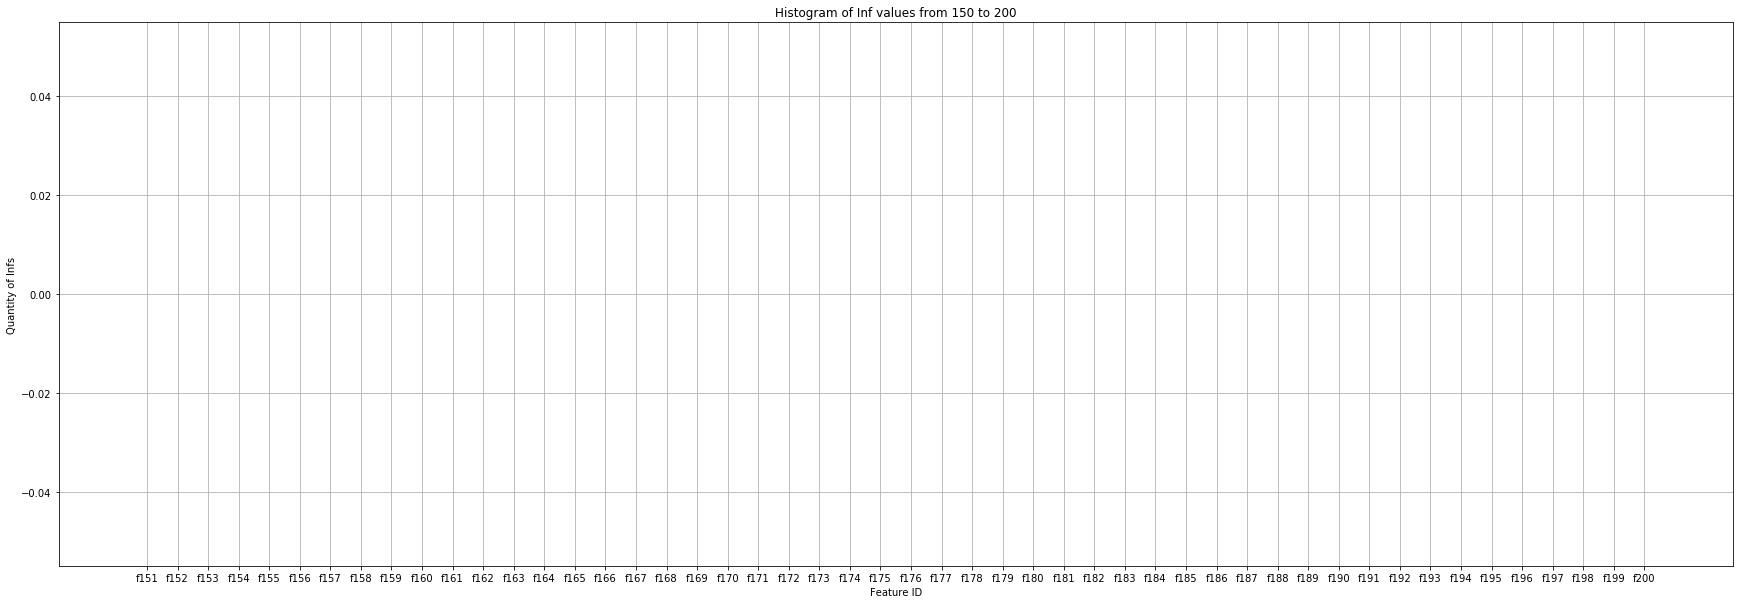

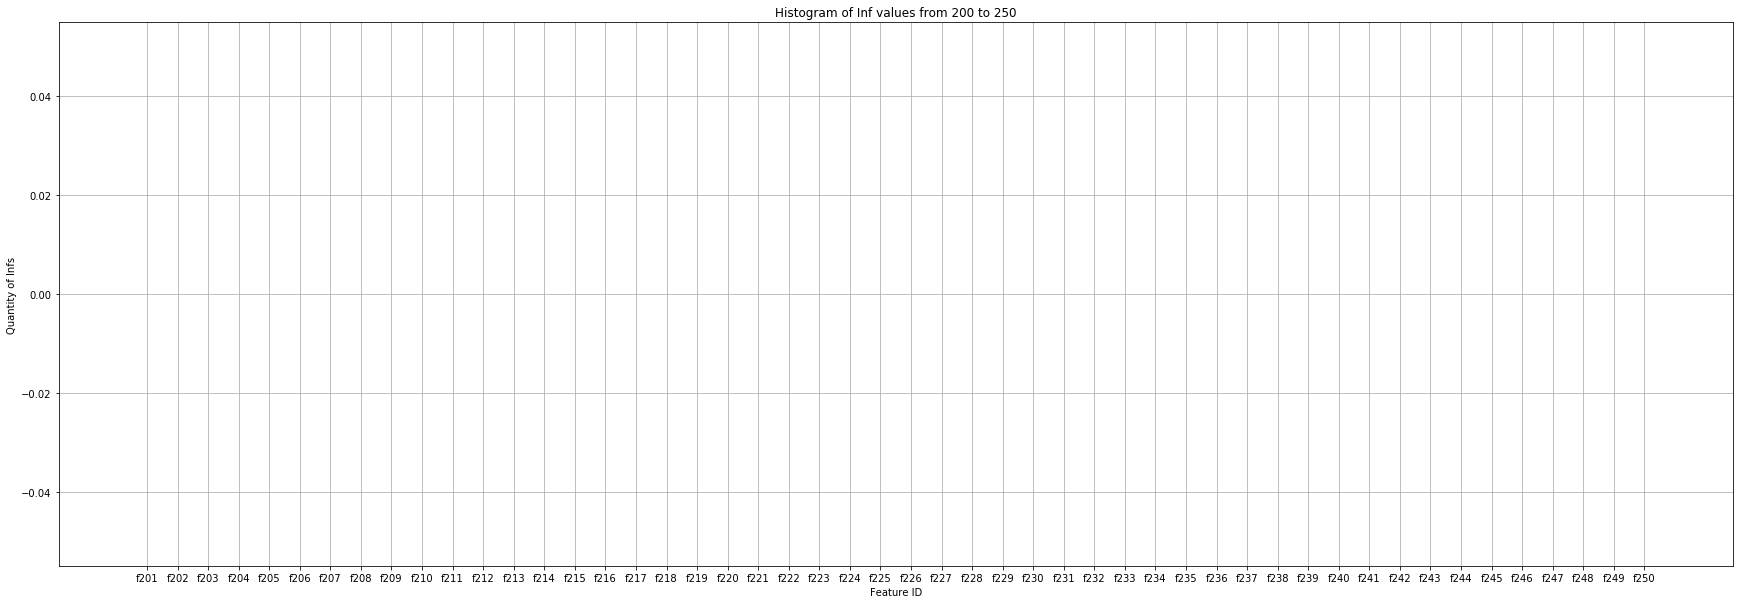

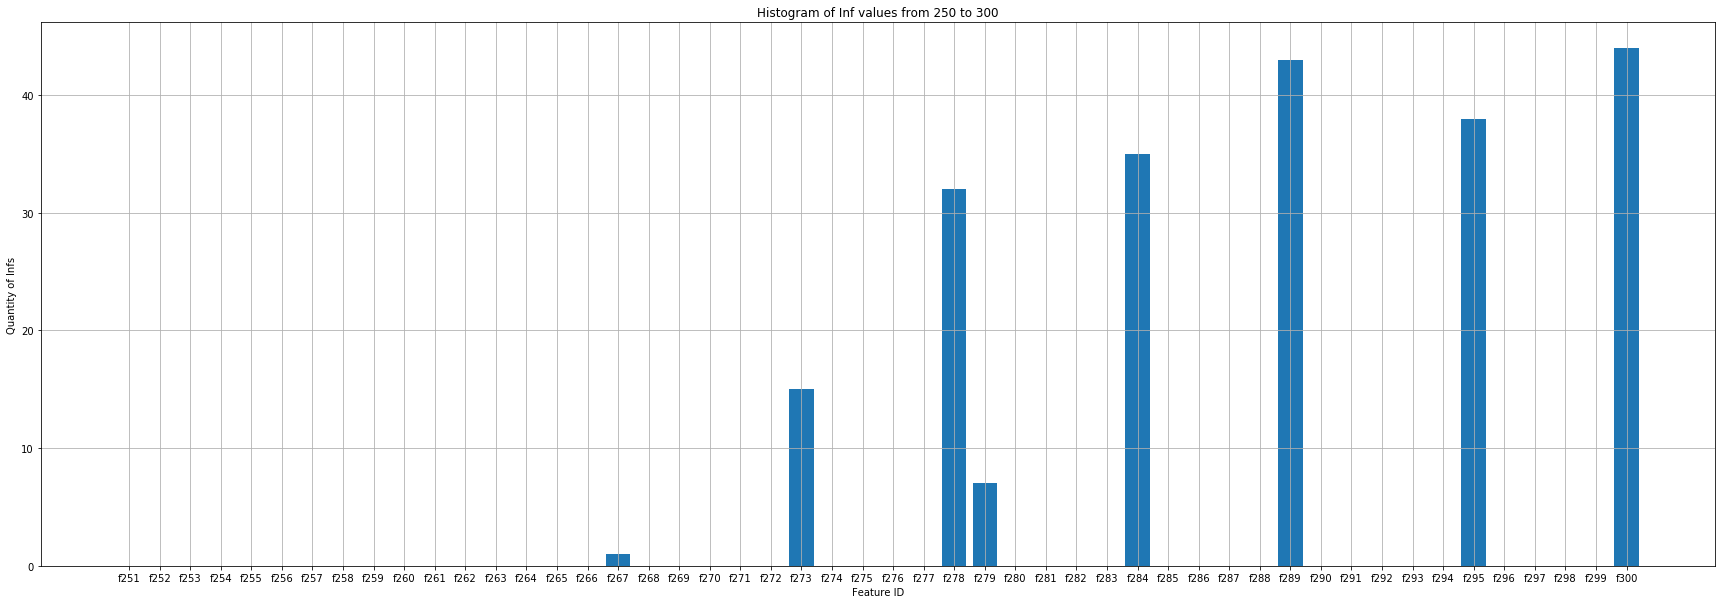

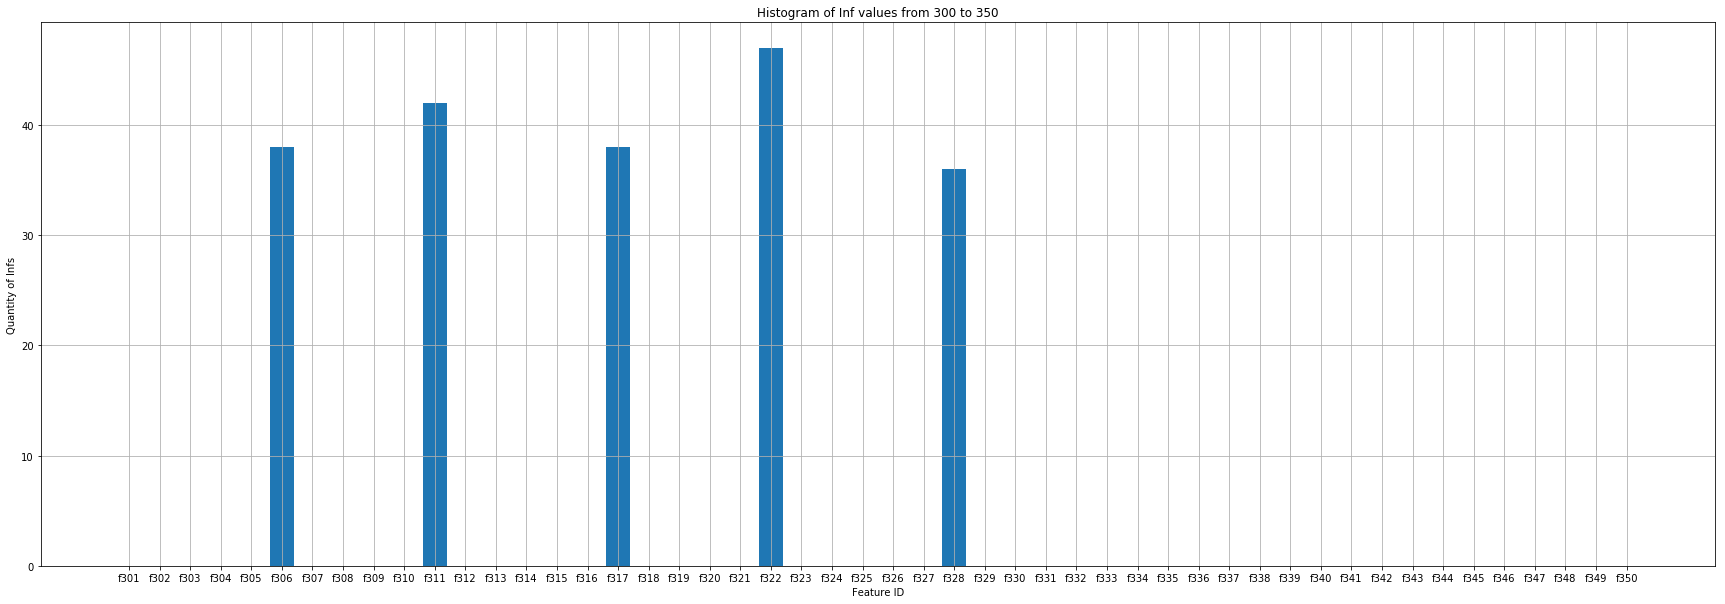

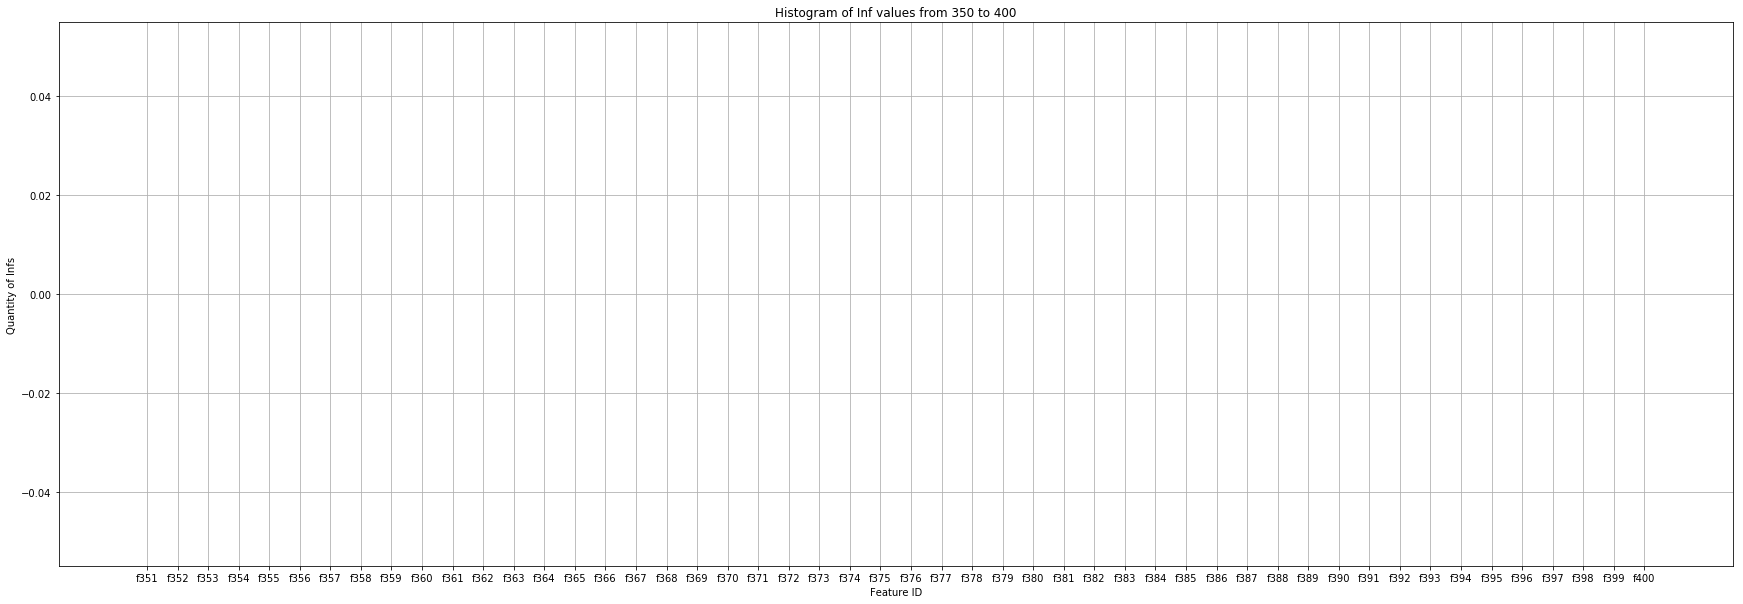

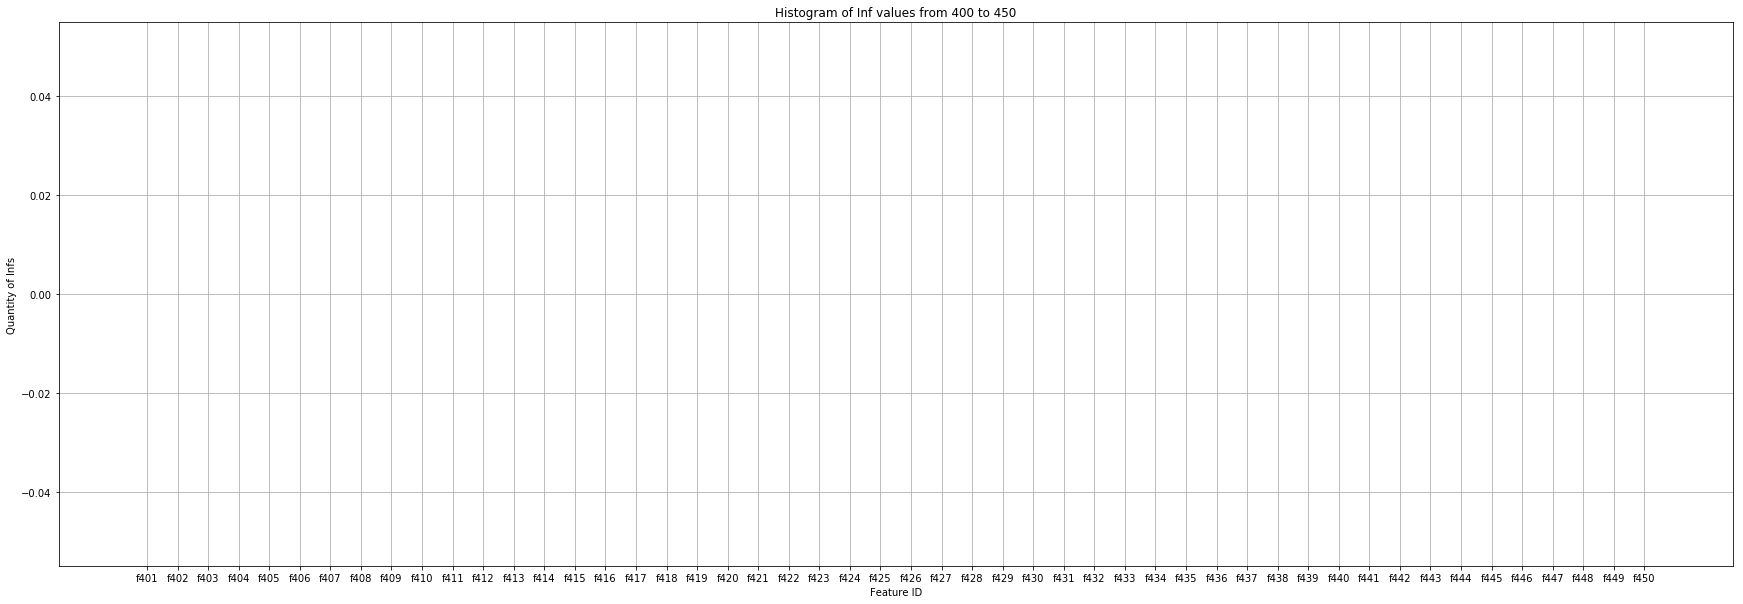

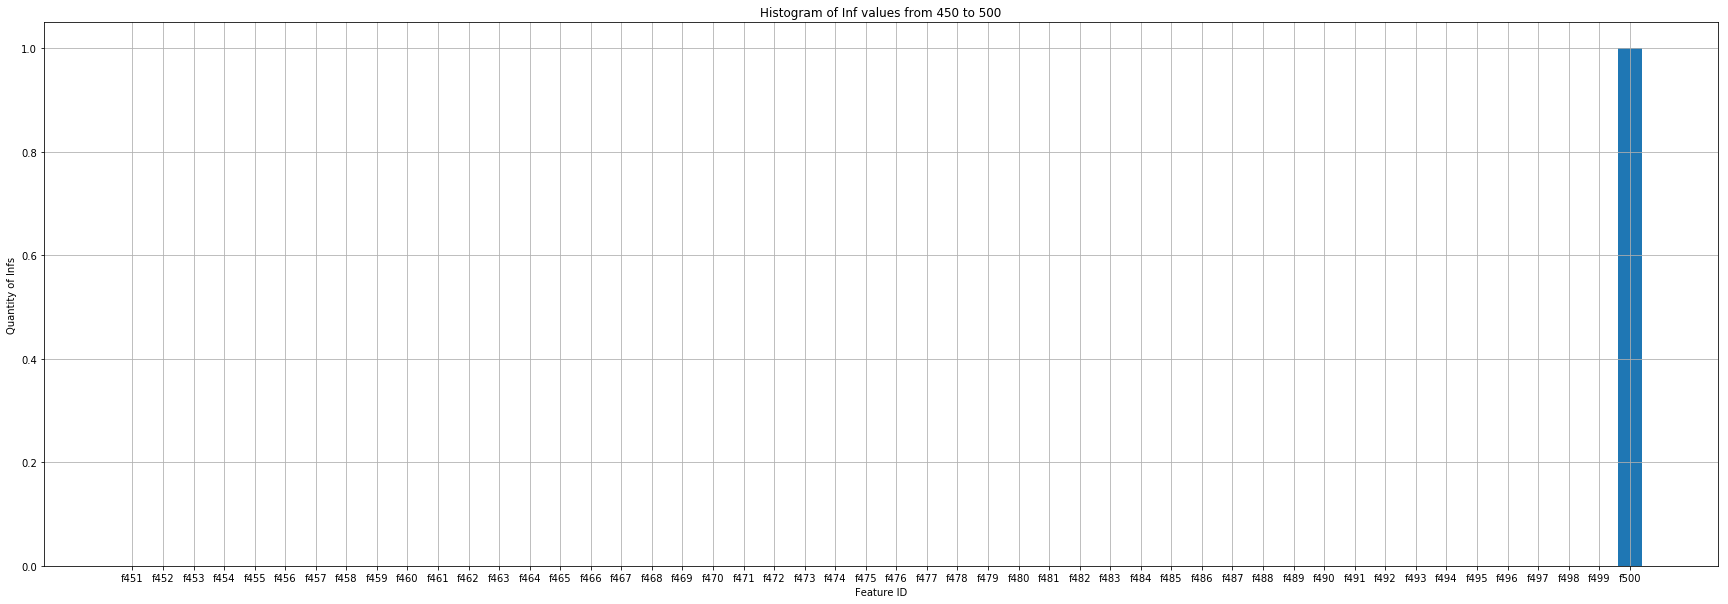

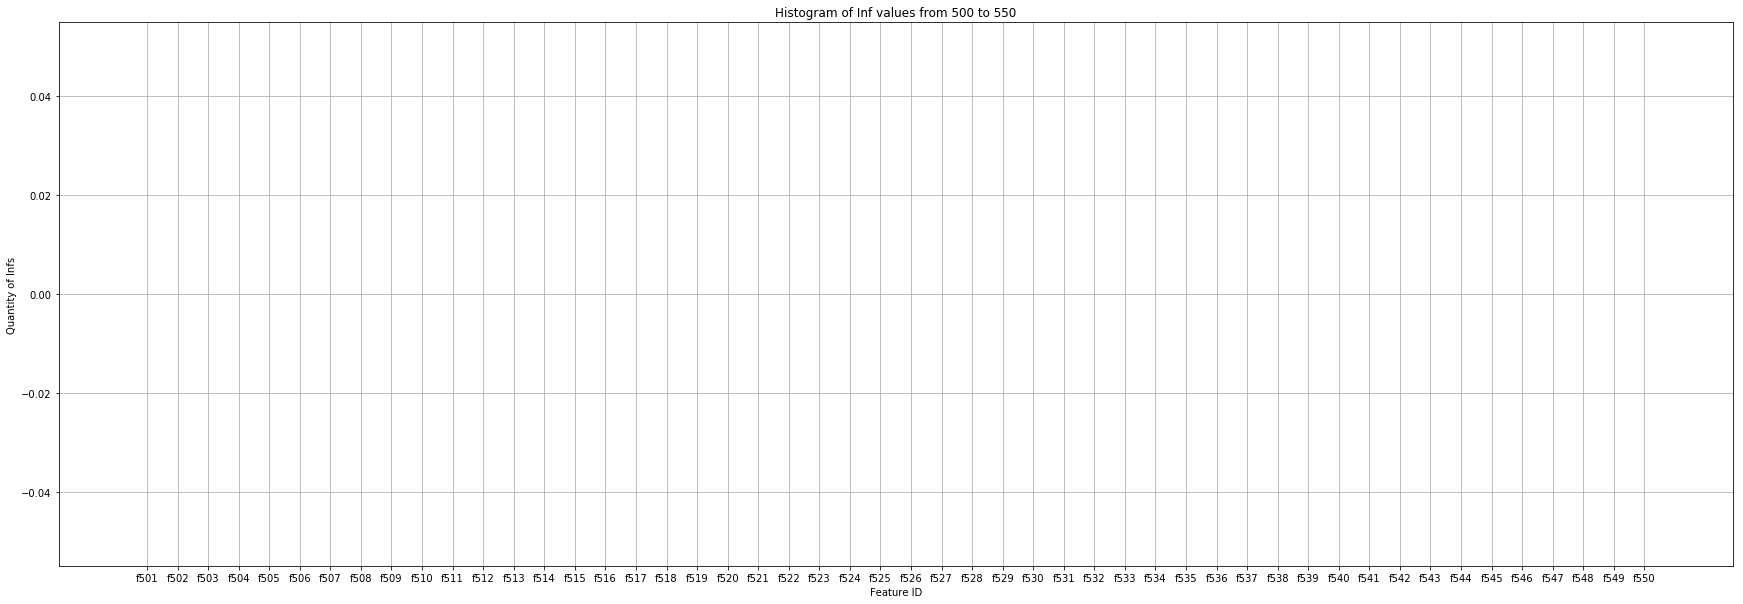

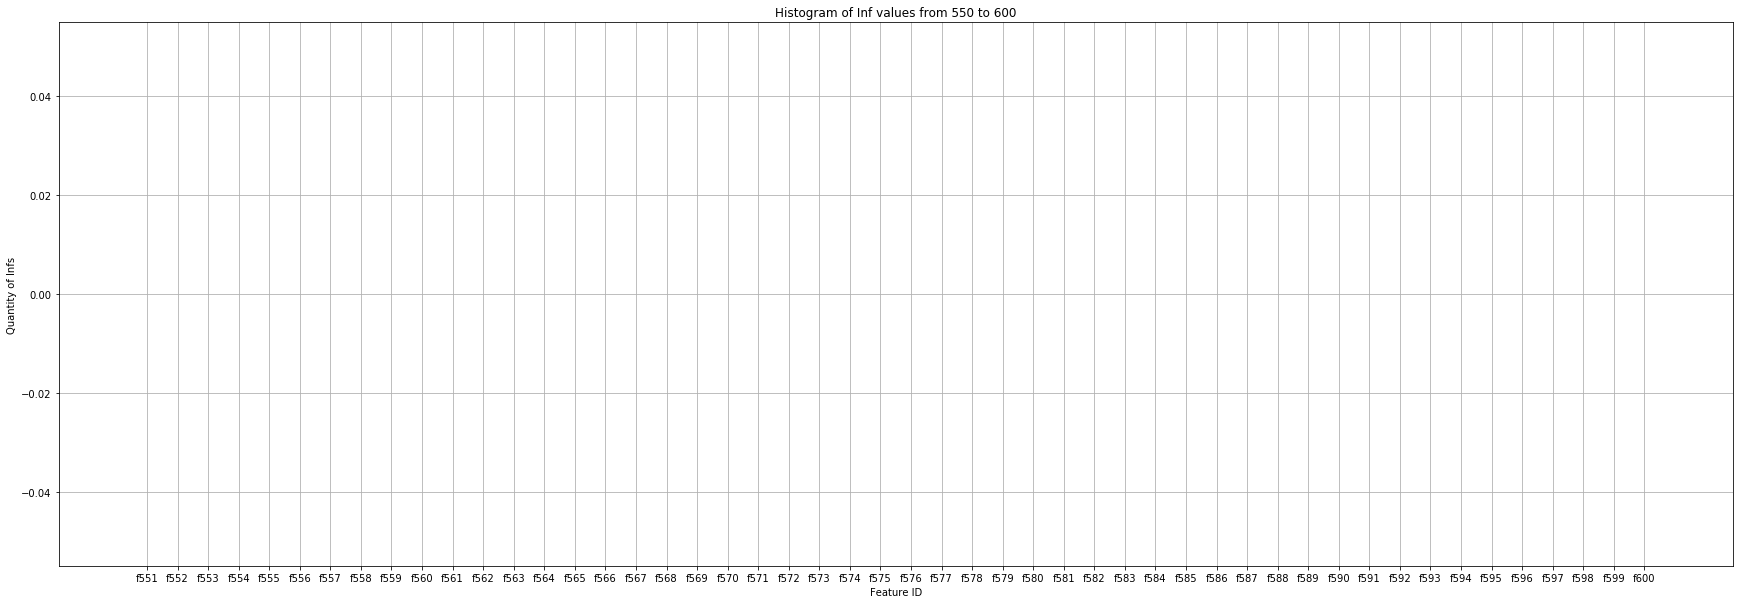

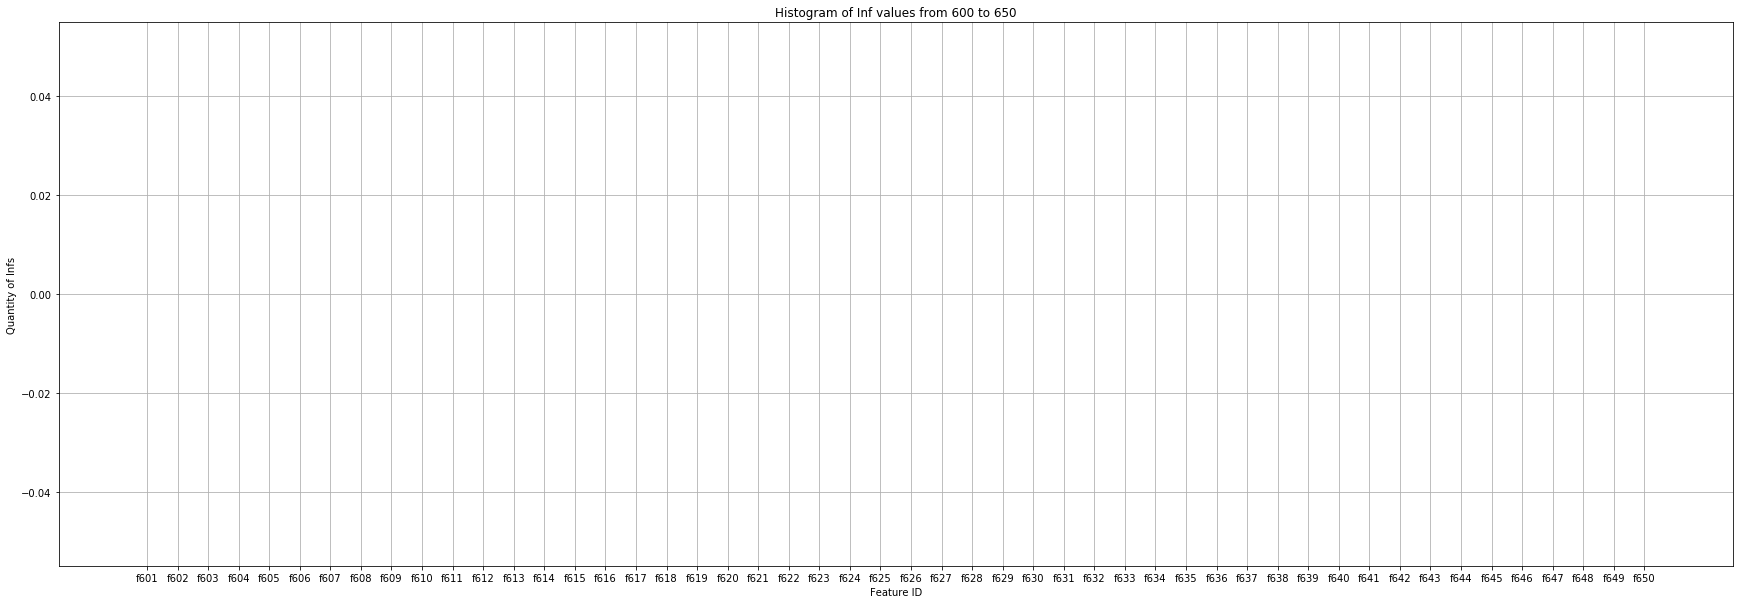

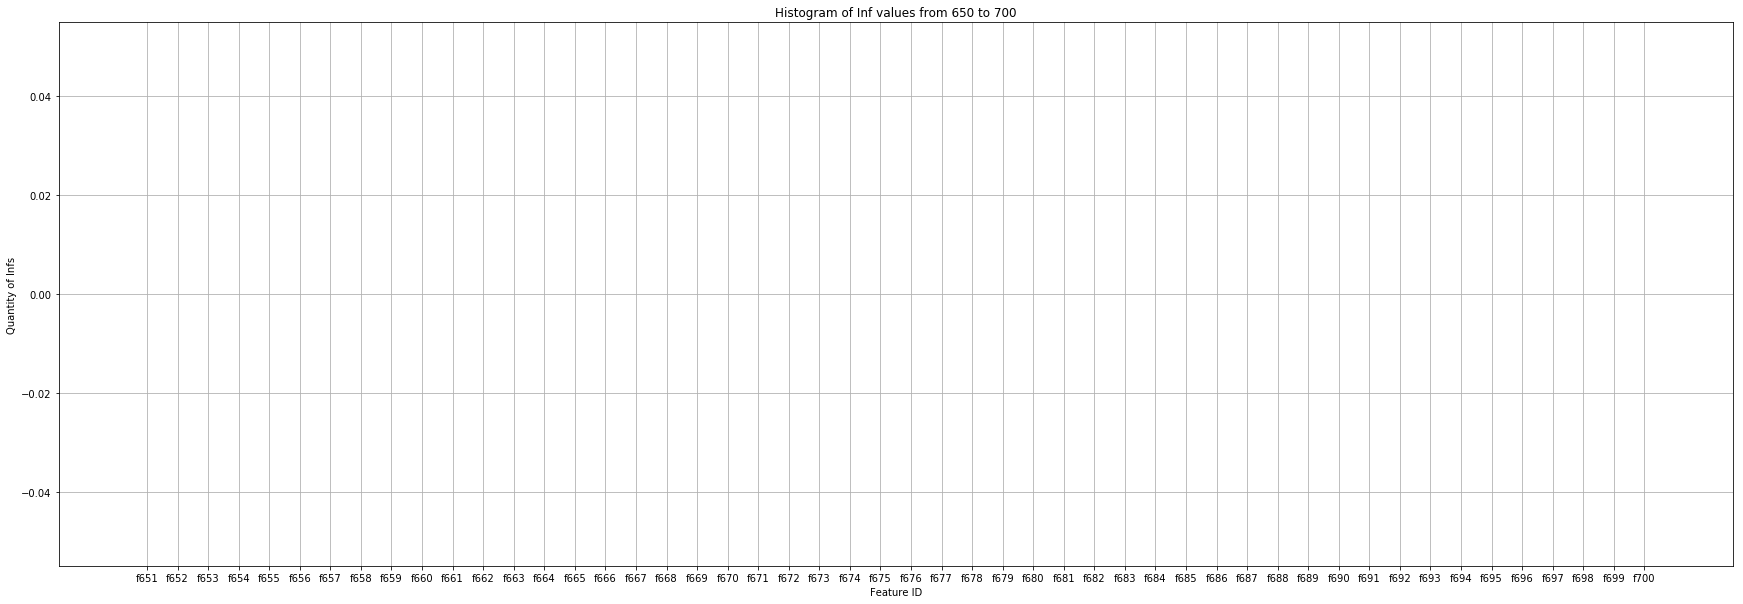

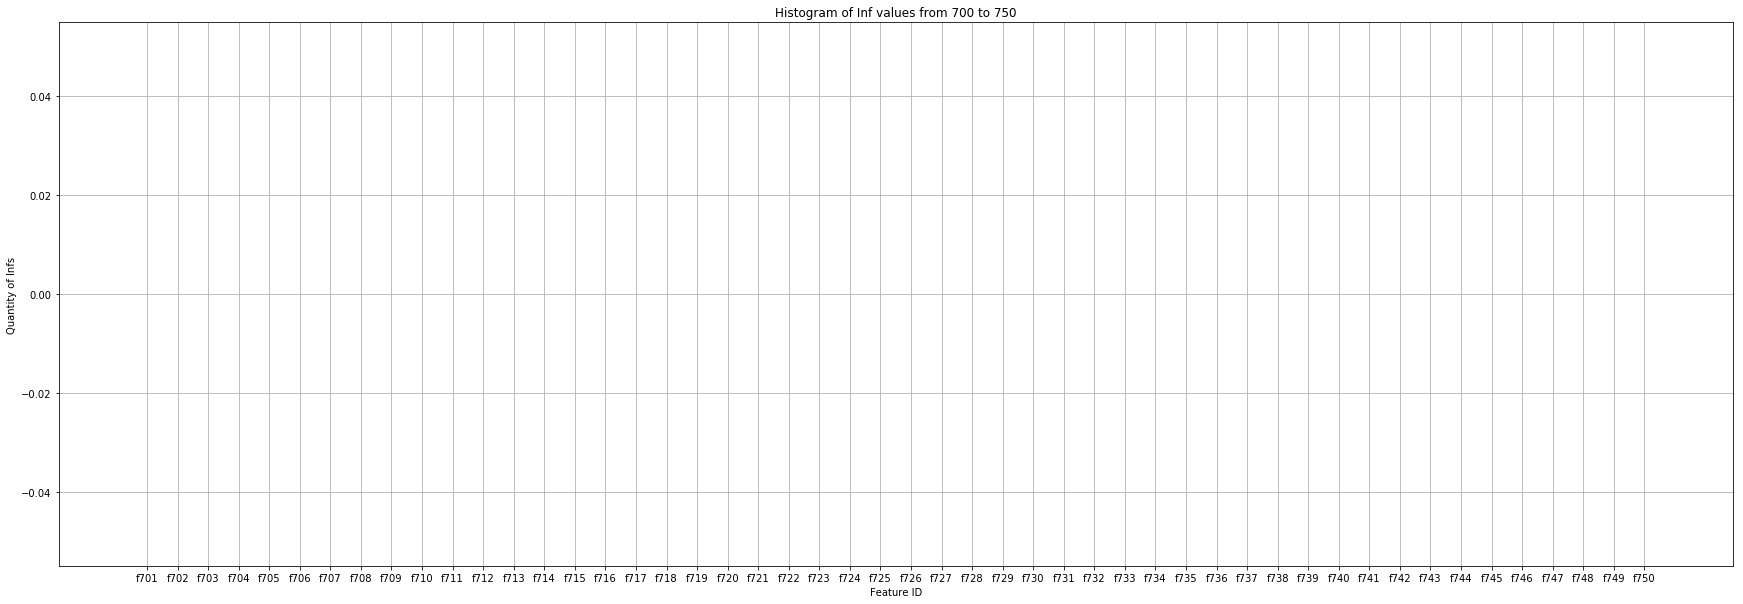

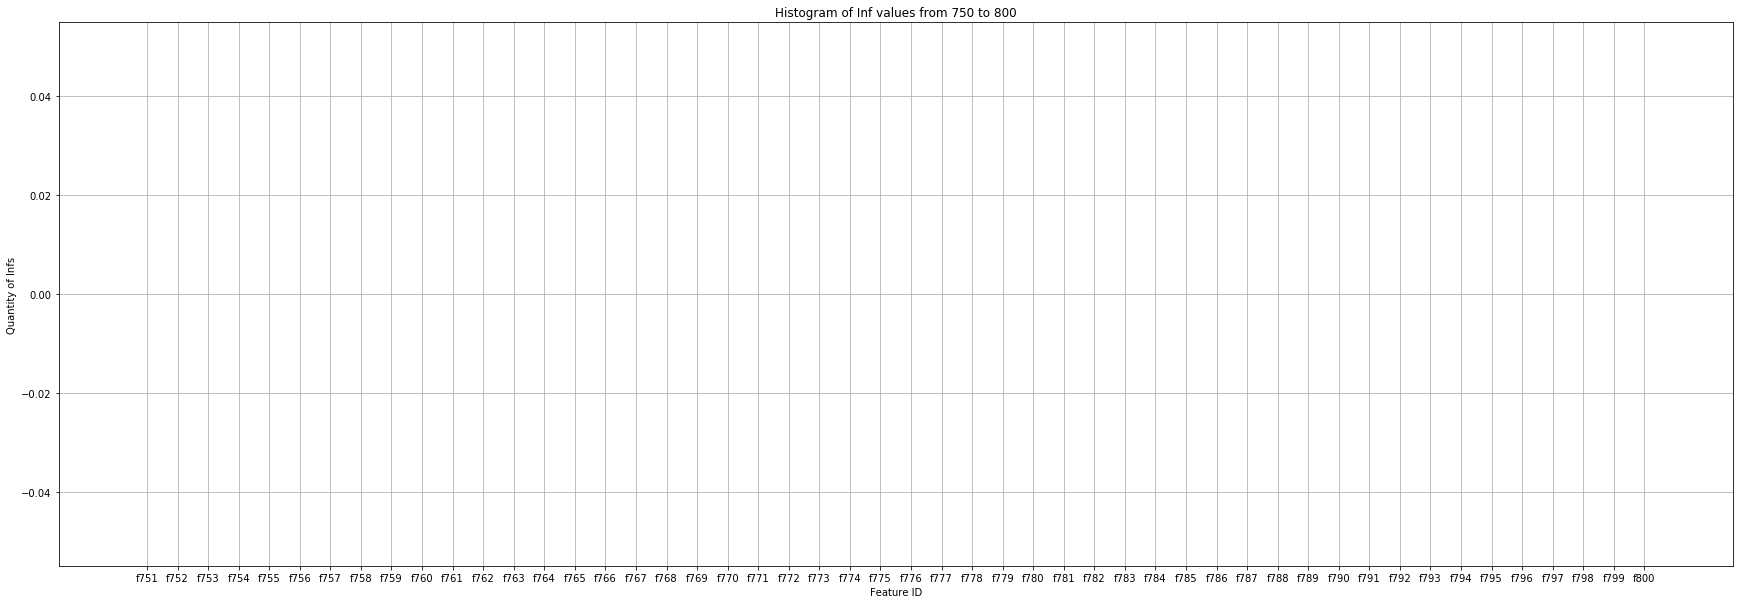

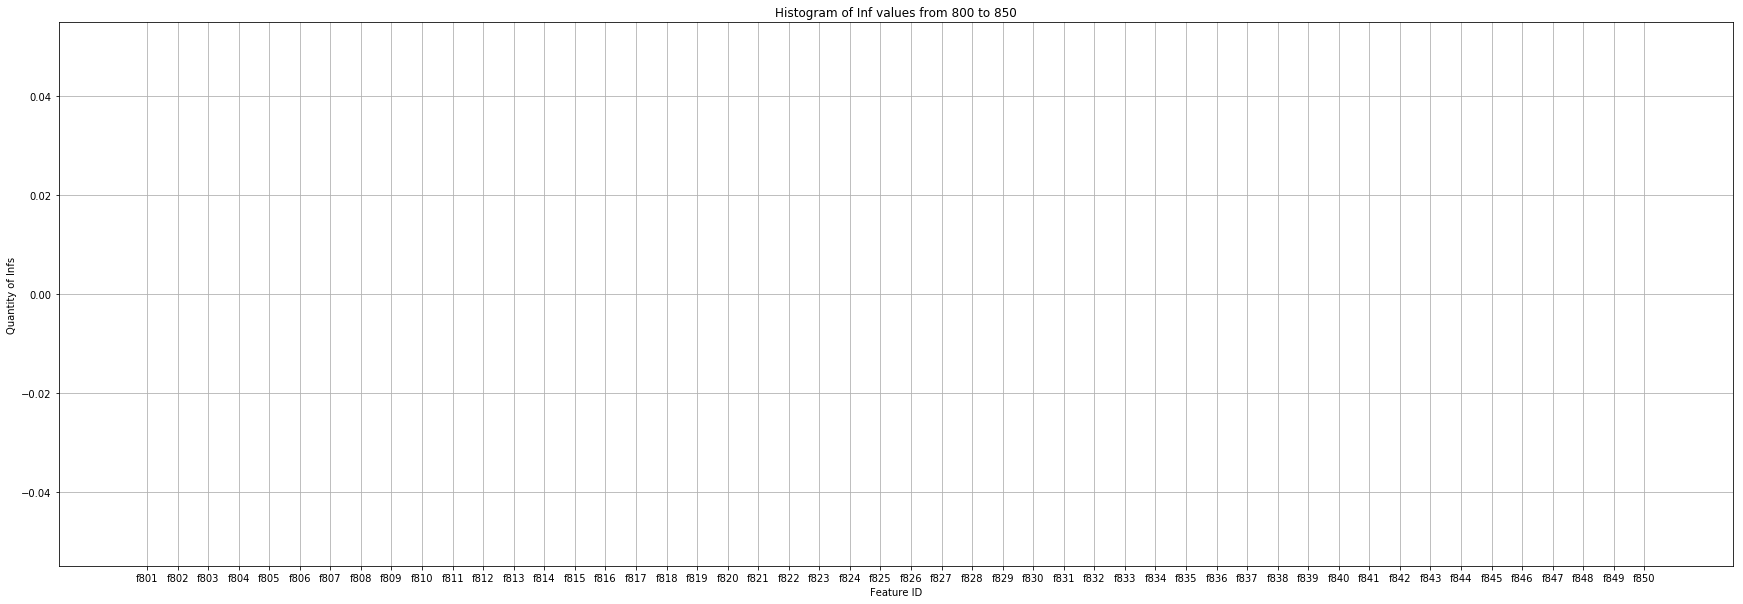

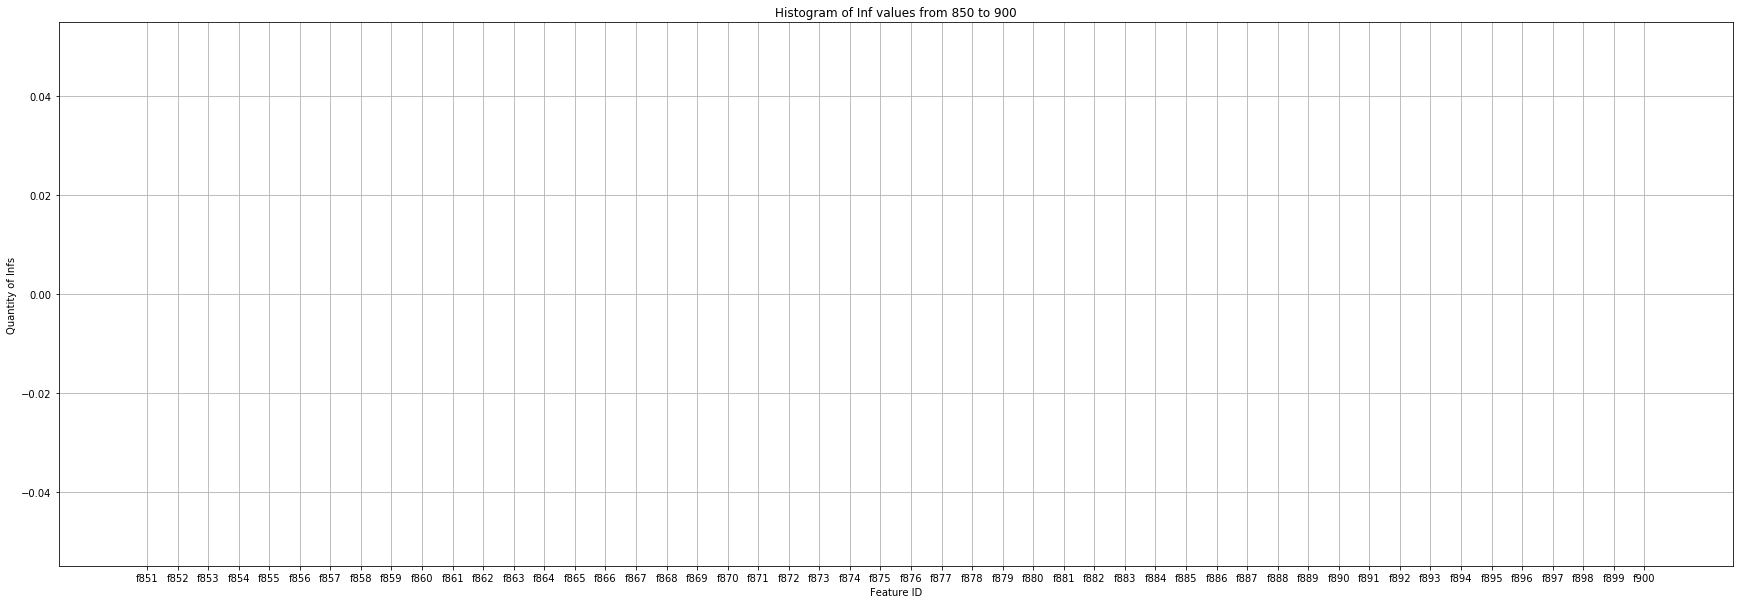

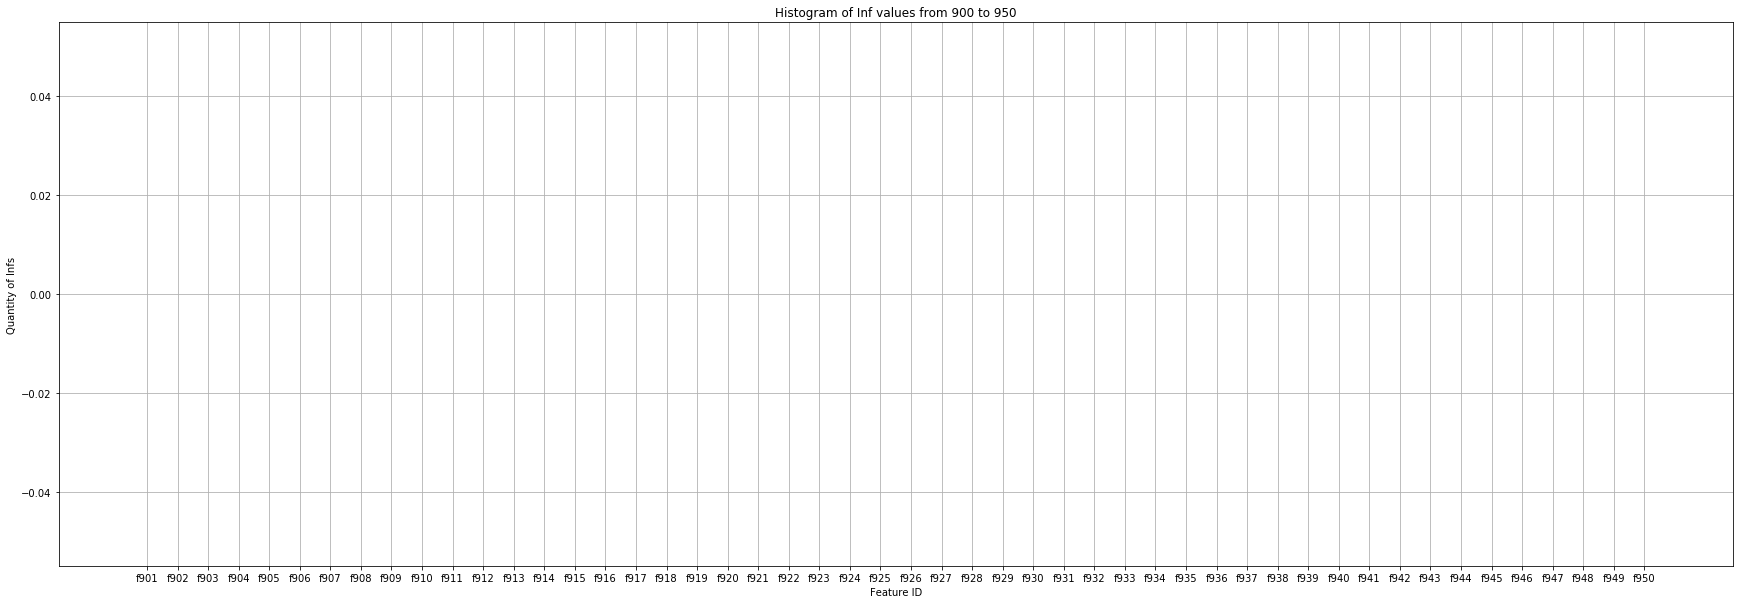

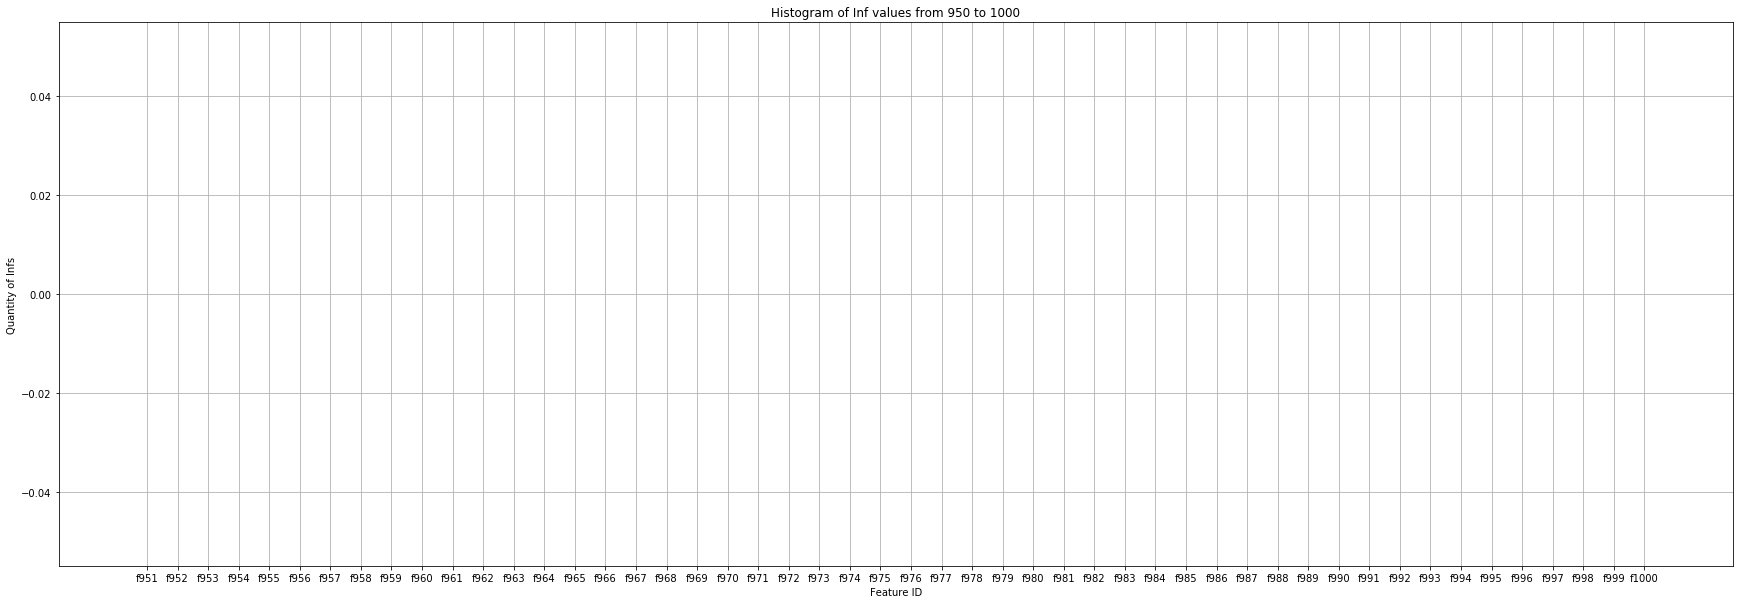

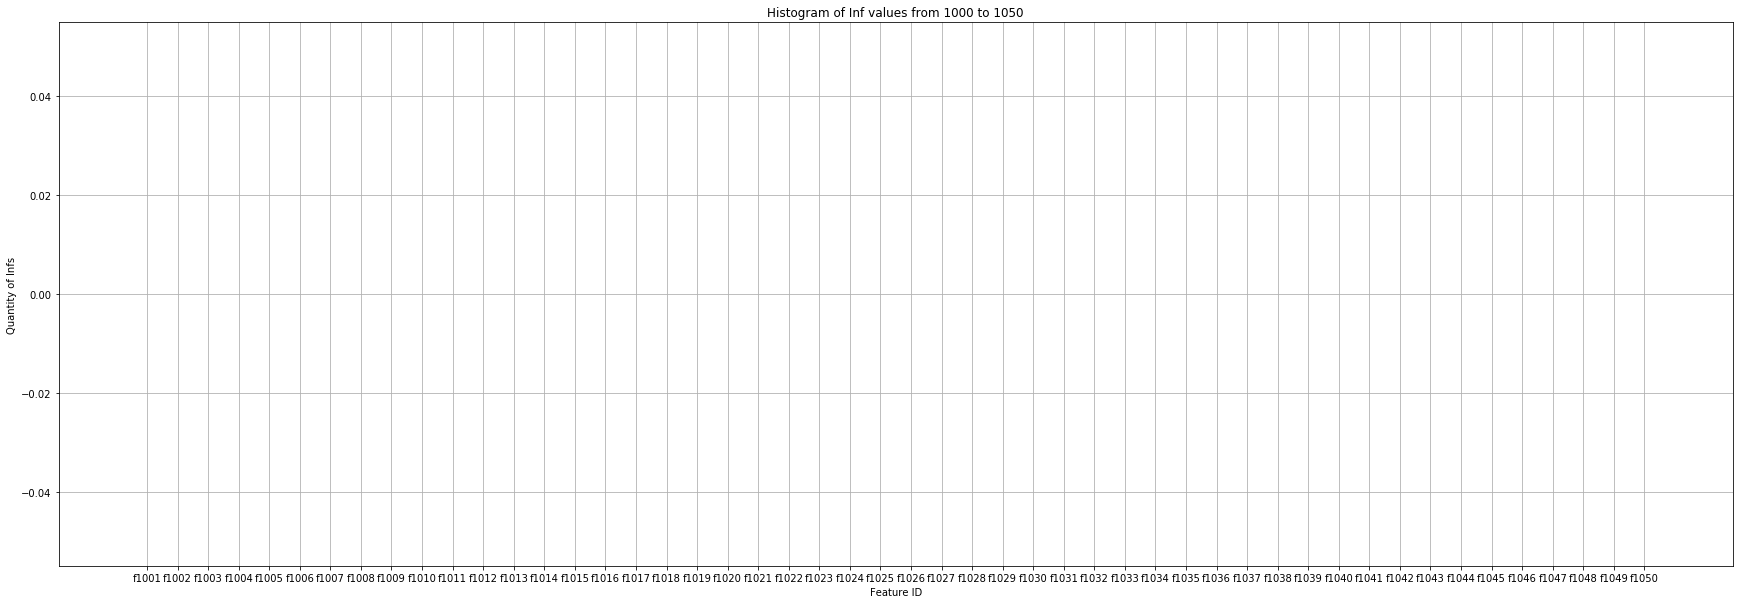

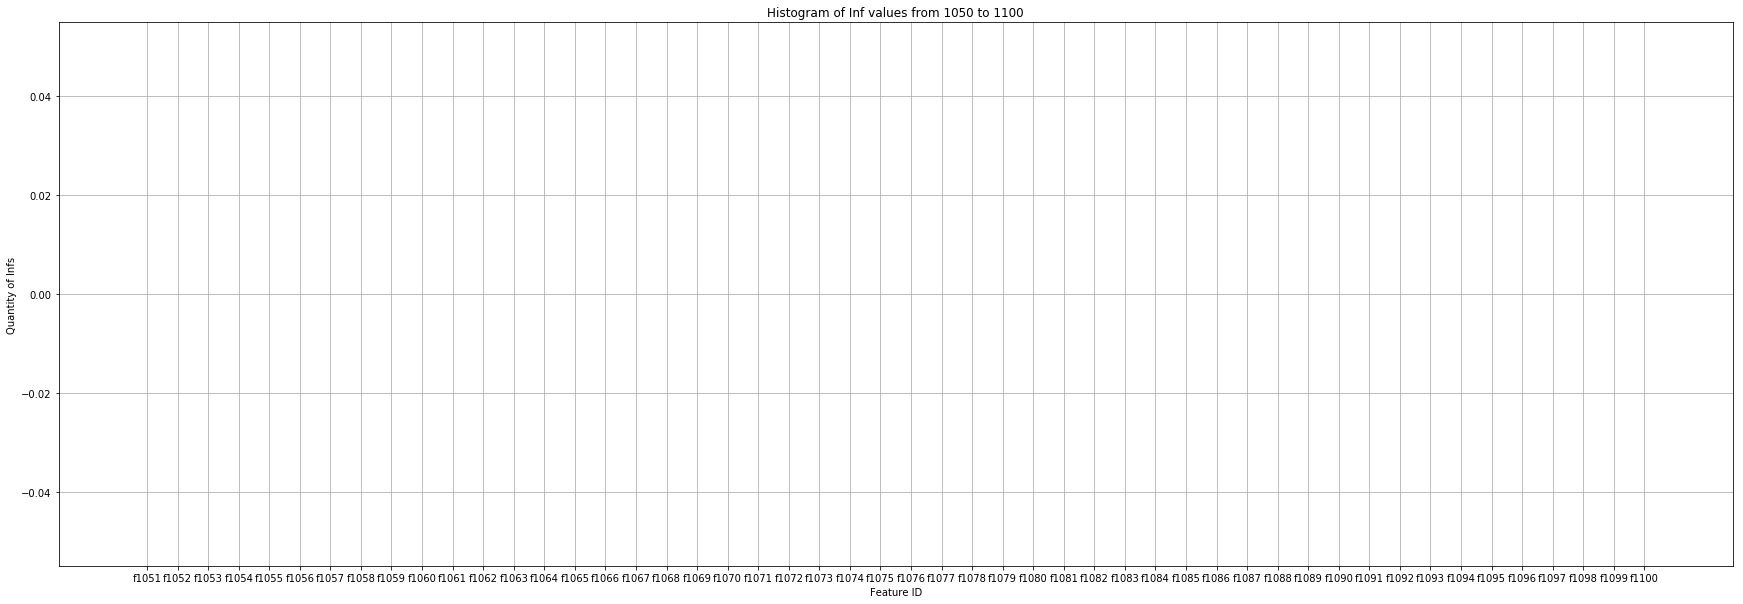

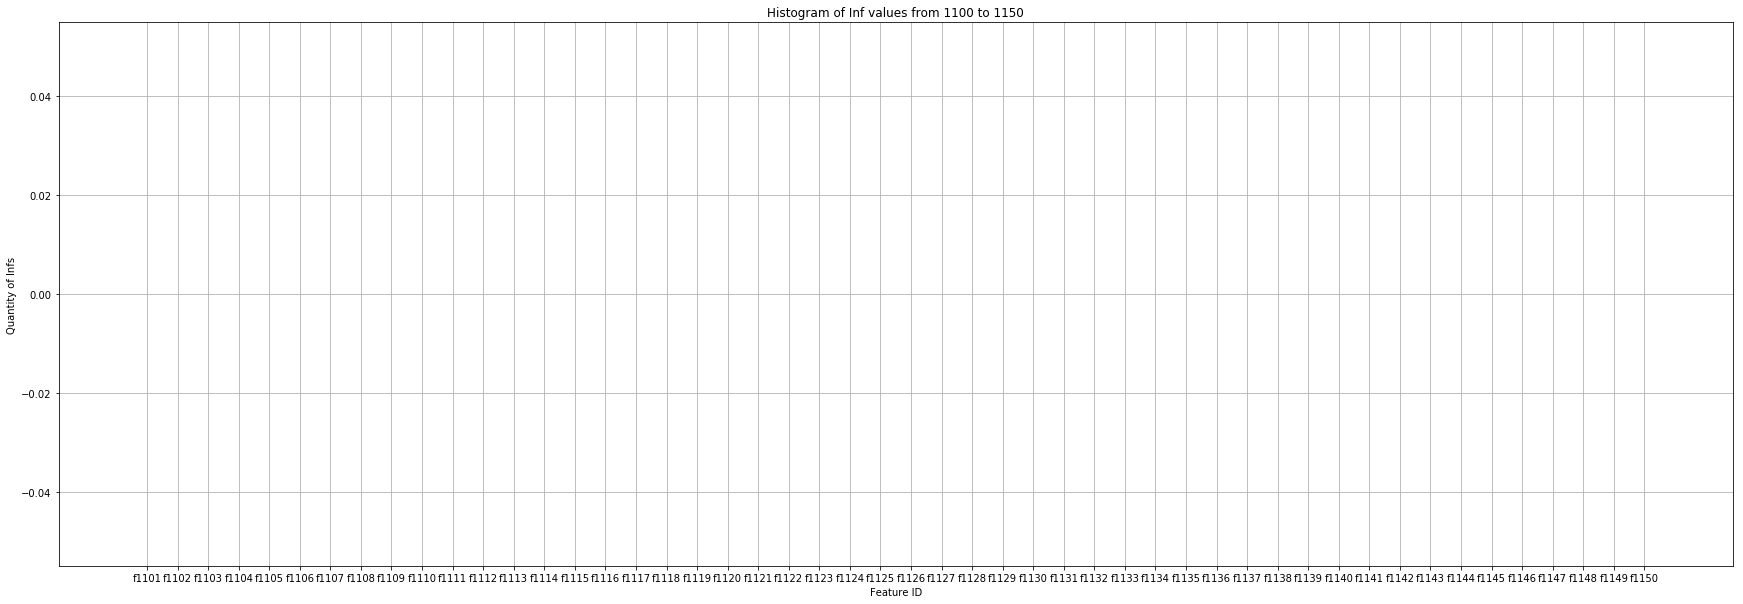

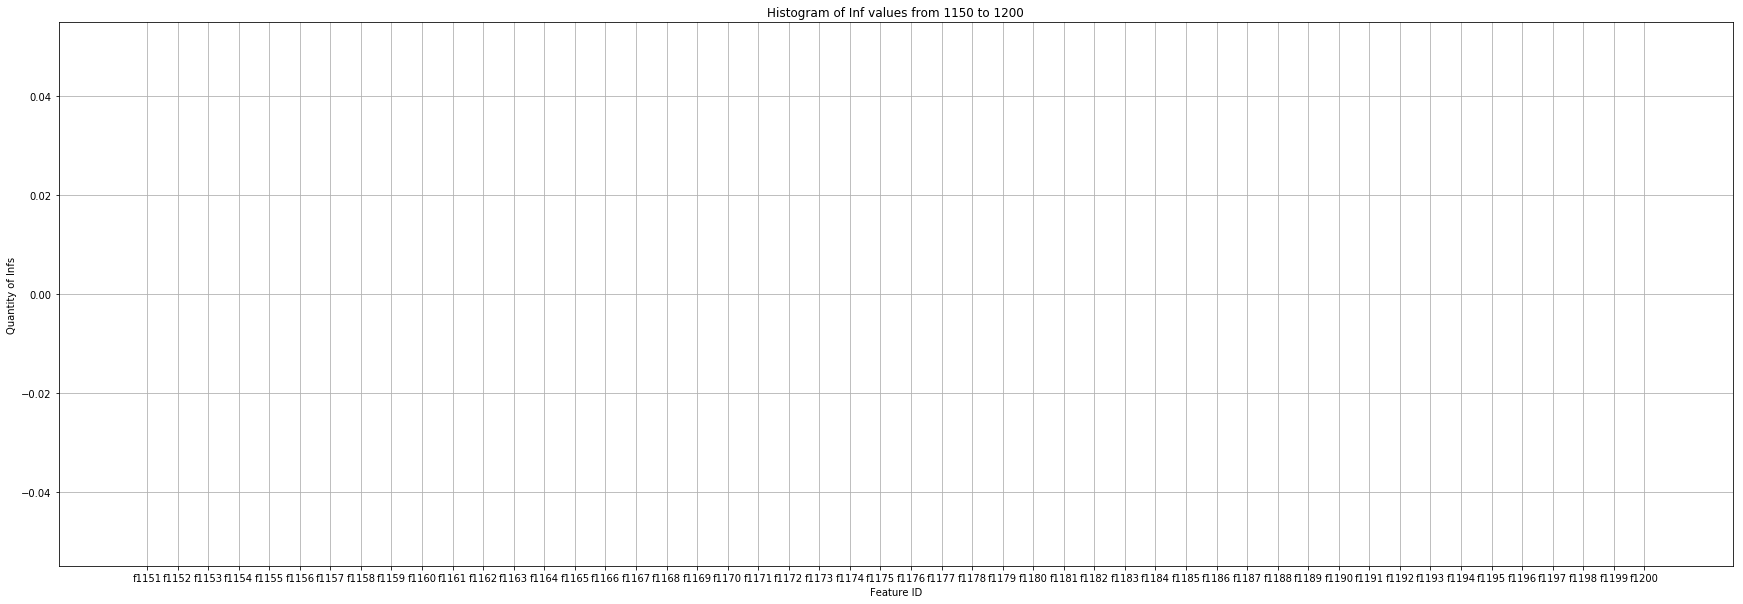

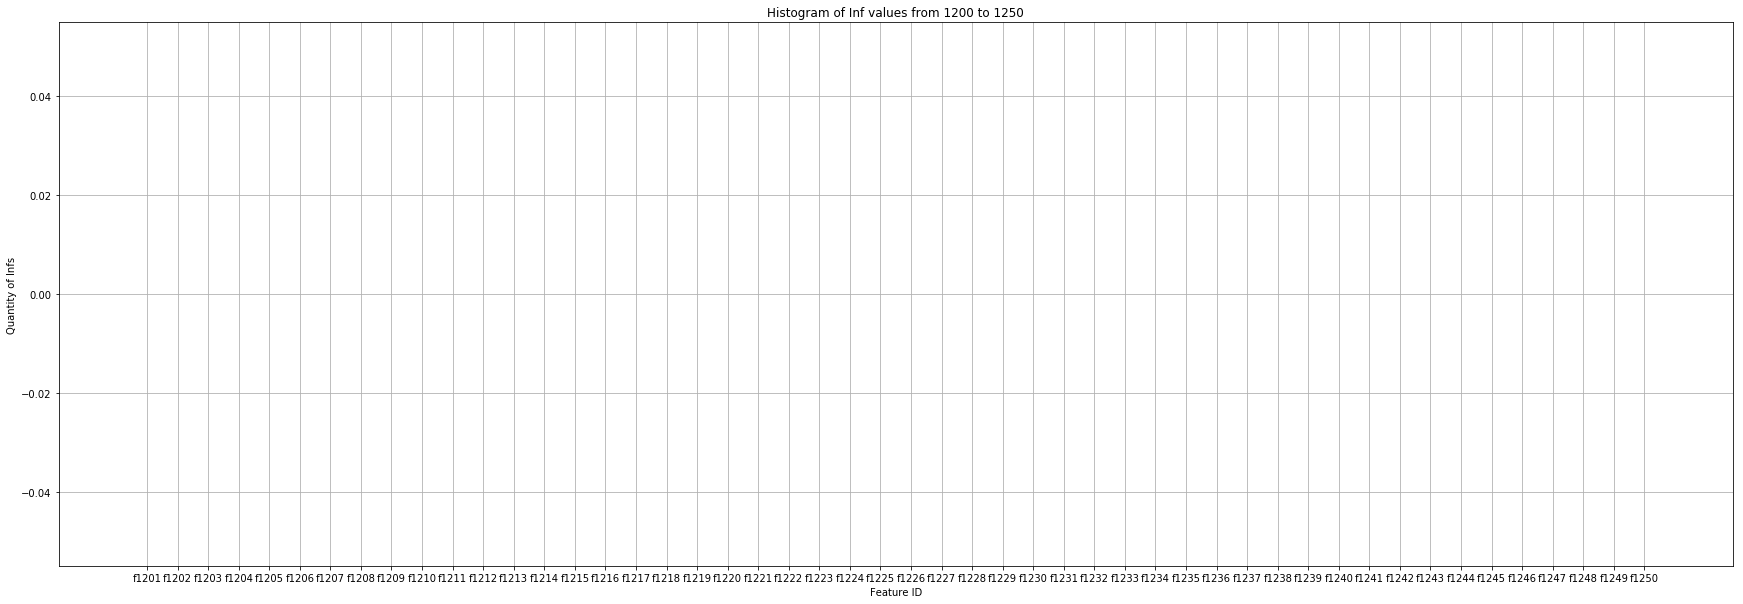

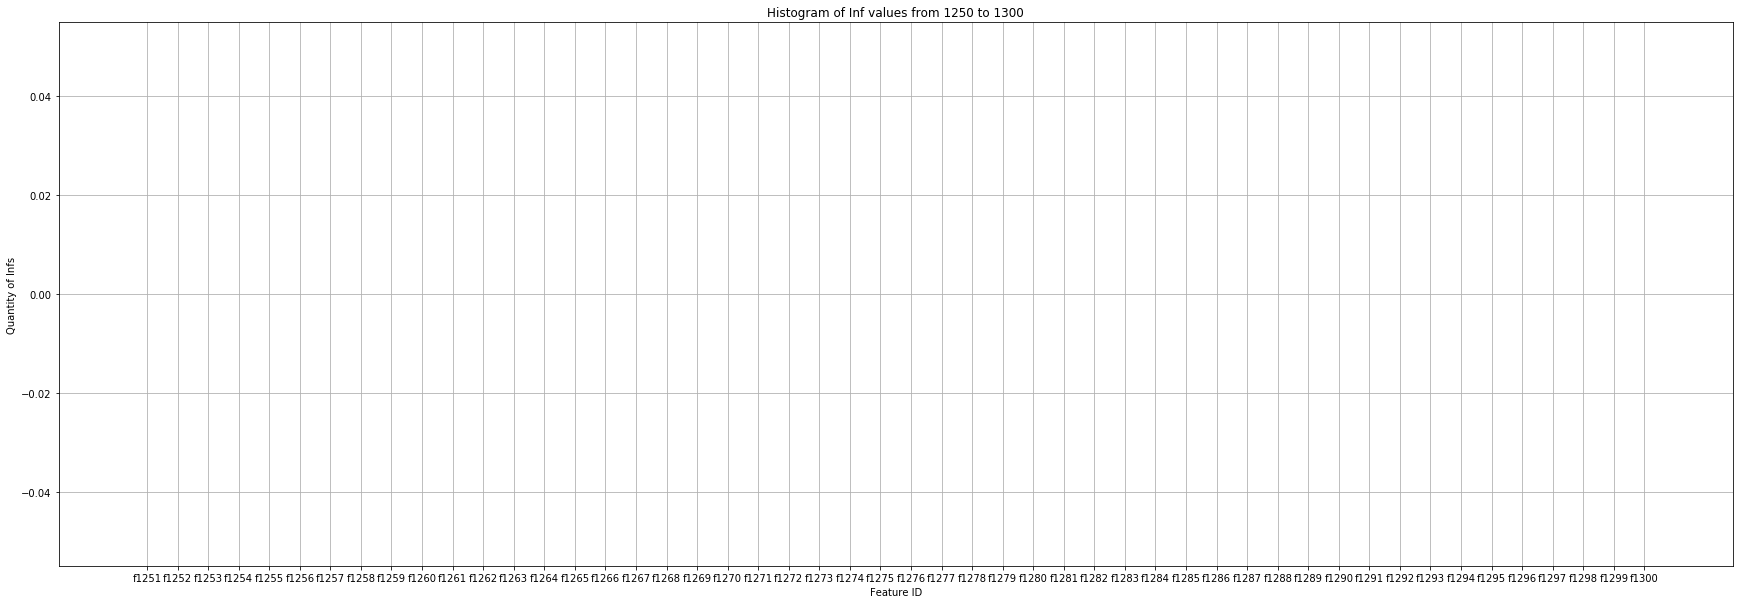

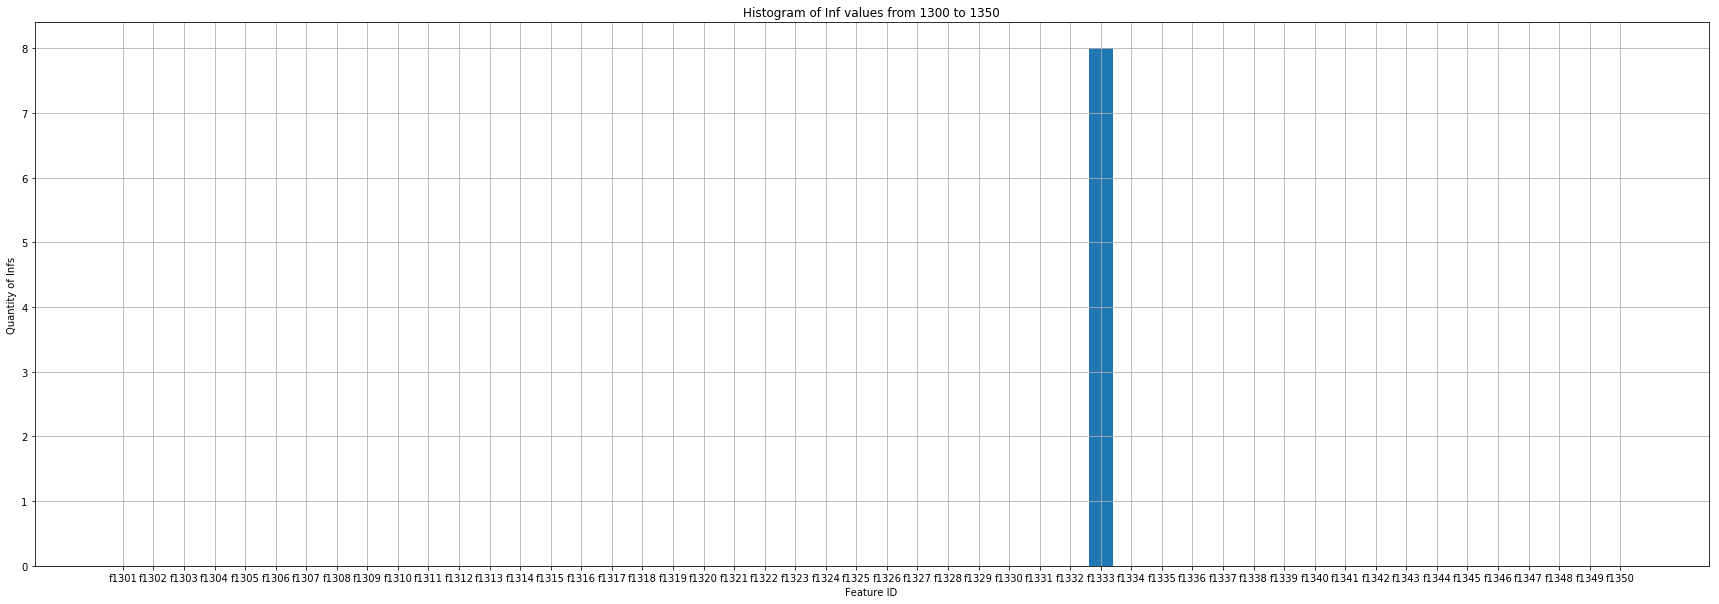

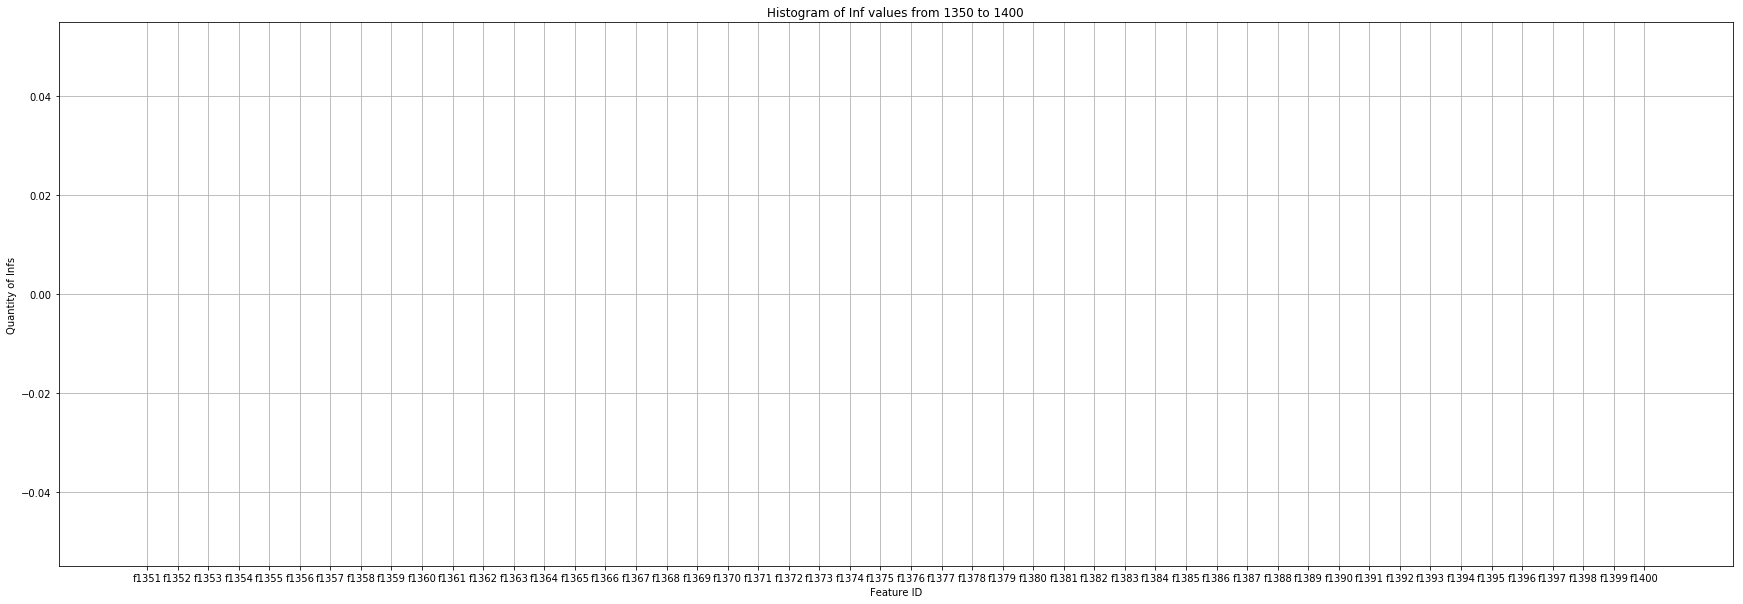

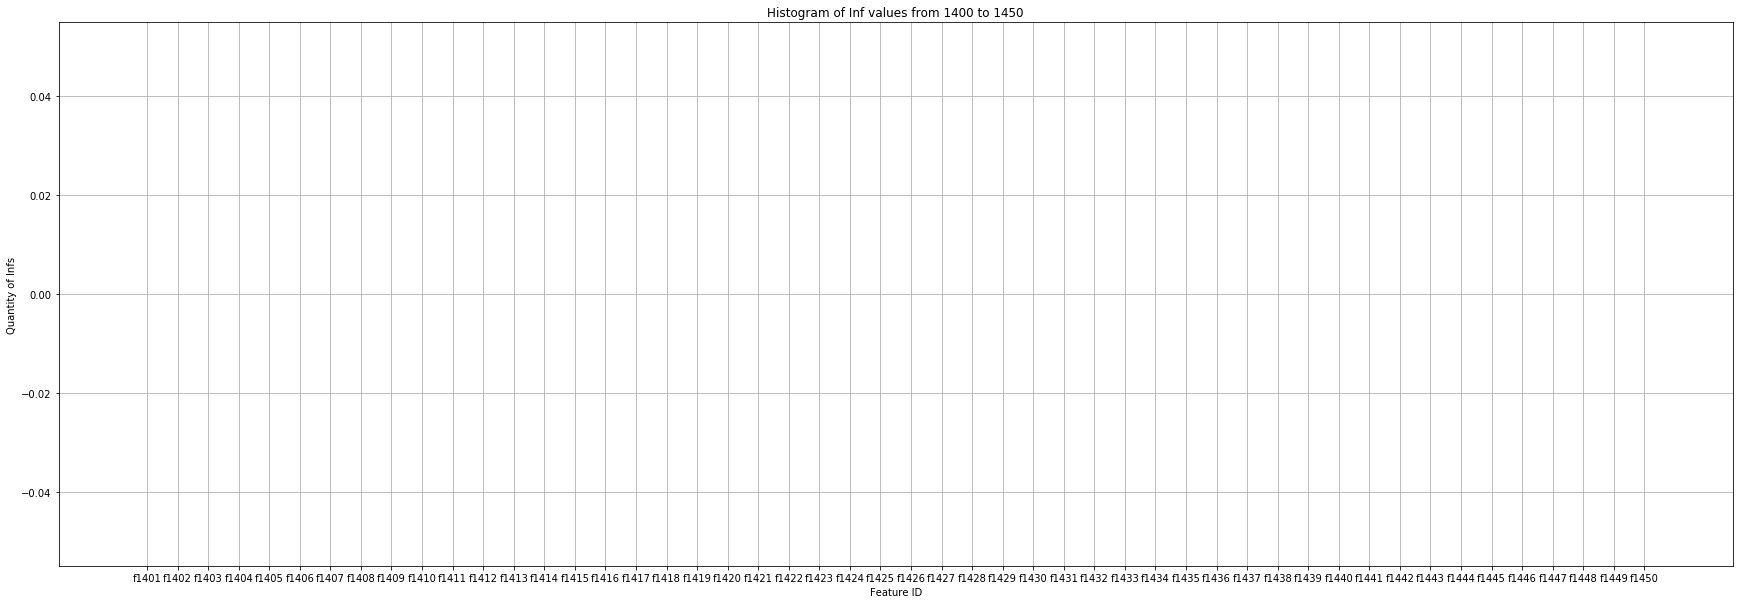

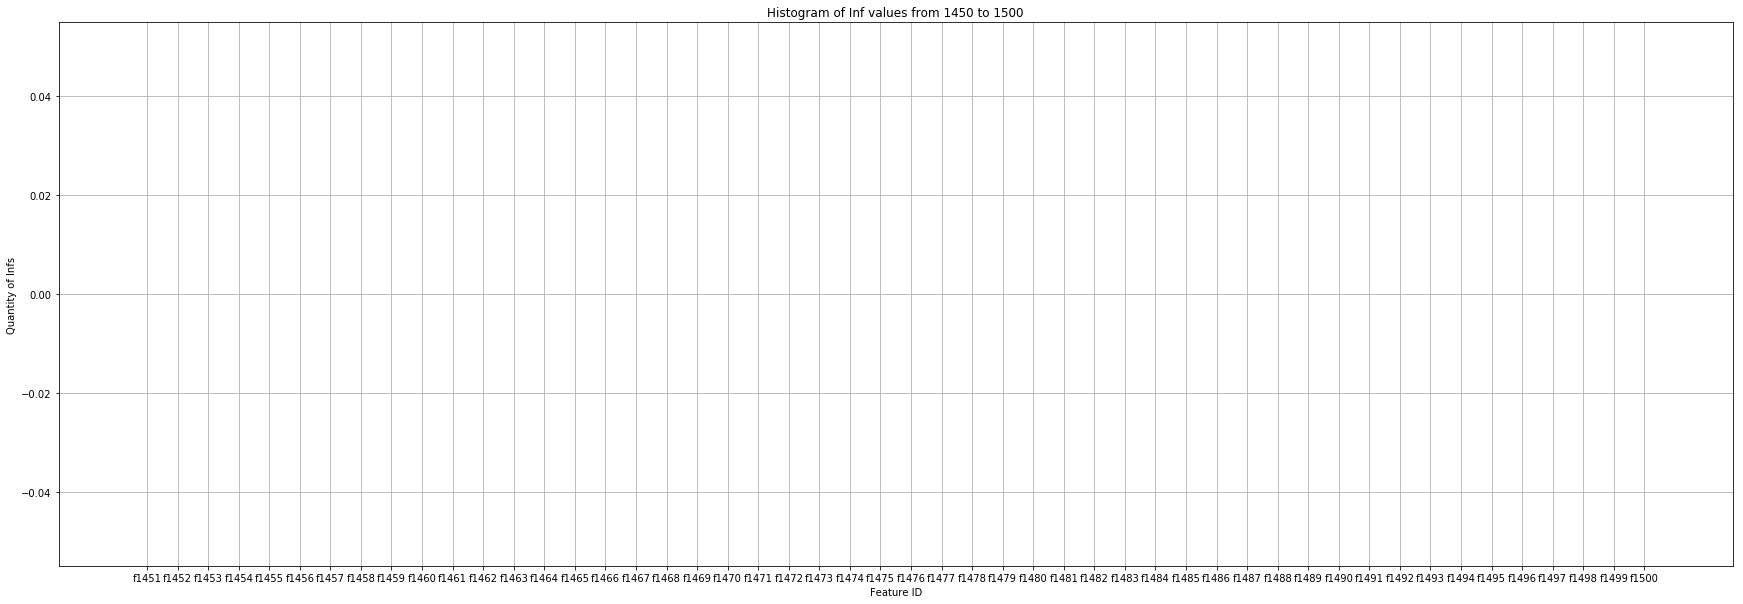

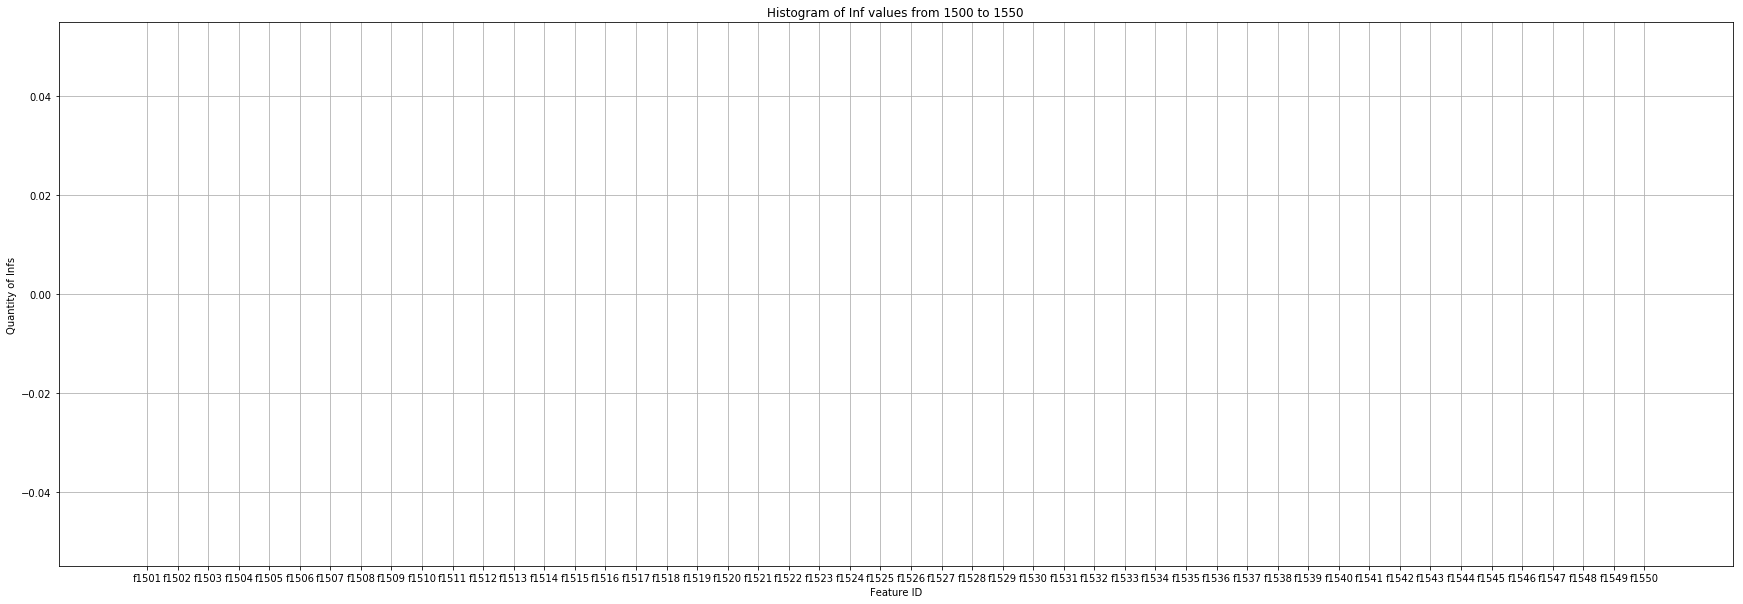

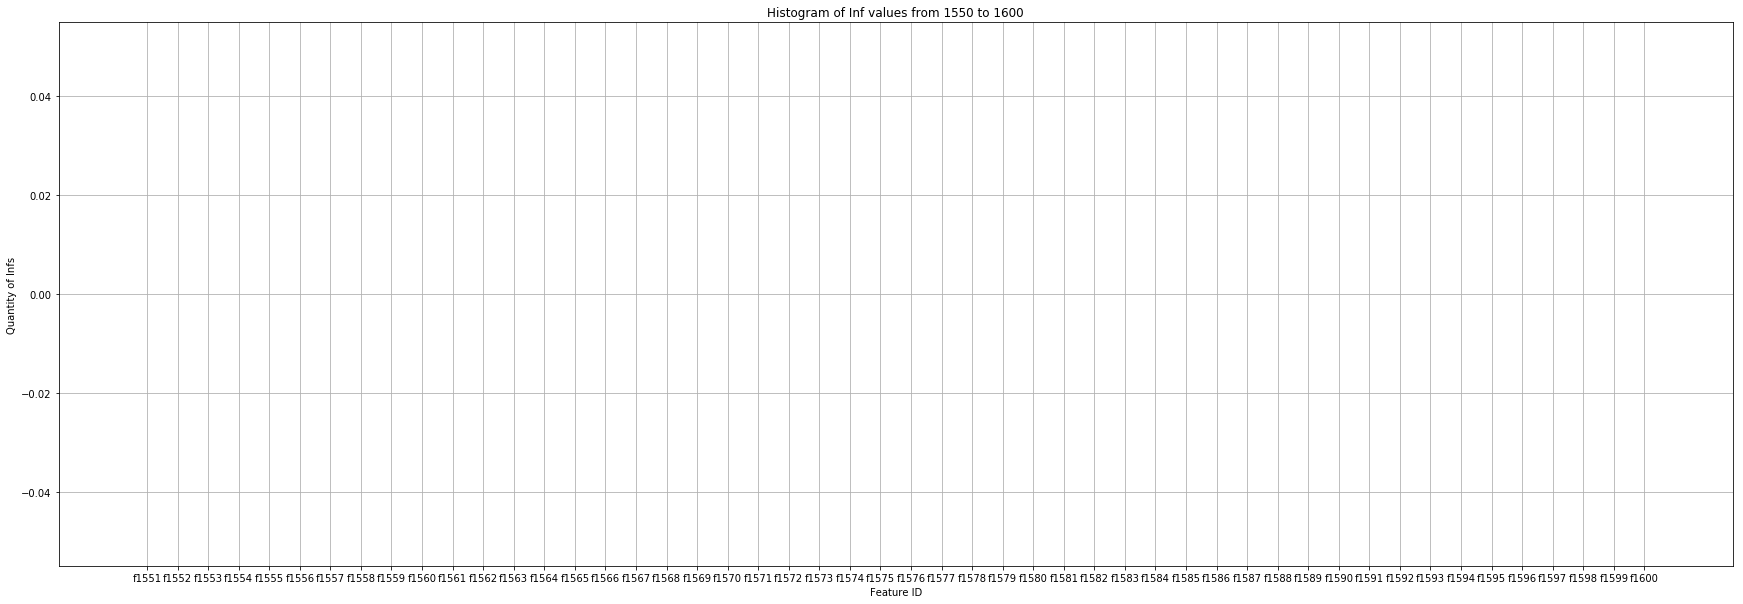

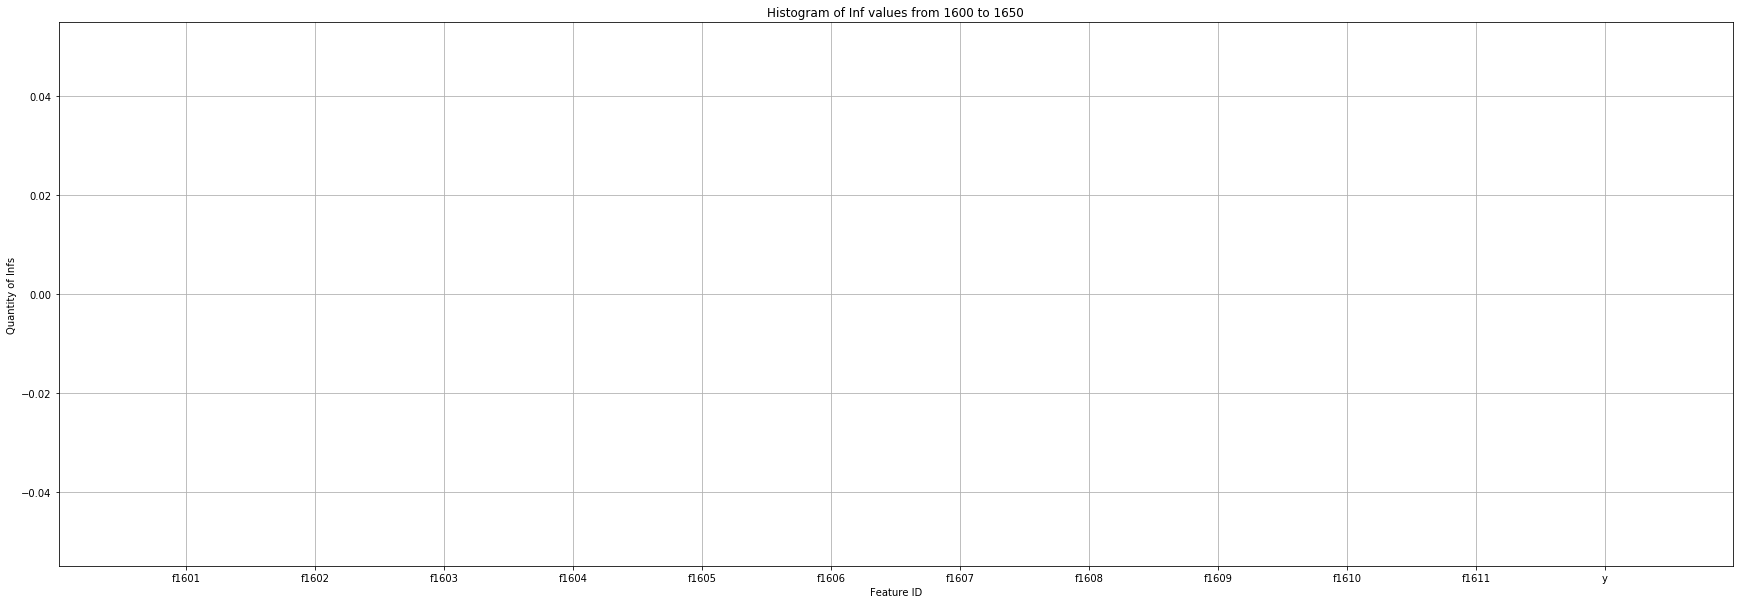

In [10]:
res = nan_calculating(train, key=np.isinf)

In [11]:
num, infs = nan_proccessing(res, (1,10000))

Из распределений видно, что inf-элементов в предикторах не так много, как пропущенных данных. Максимальное количество inf-элементов не превосходит 45.

In [12]:
def outlayer_calculation(df):
    result = {}
    df = df.iloc[:,1:]
    for field in df:
        q1 = df[field].quantile(0.25)
        q3 = df[field].quantile(0.75)
        iqr = q3 - q1
        df_out = np.sum((df[field] < q1 - 1.5*iqr) | (df[field] > q3 + 1.5*iqr))
        result[field] = df_out
    keys = list(result.keys())
    values = list(result.values())
    for i in range(0,len(keys), 50):
        plt.figure(figsize=[30,10])
        plt.bar(list(result.keys())[i:i + 50], list(result.values())[i:i + 50])
        plt.title(f'Histogram of Outlayers values from {i} to {i+50}')
        plt.xlabel('Feature ID')
        plt.ylabel(f'Quantity of Outlayers')
        plt.grid(True)
        plt.show()

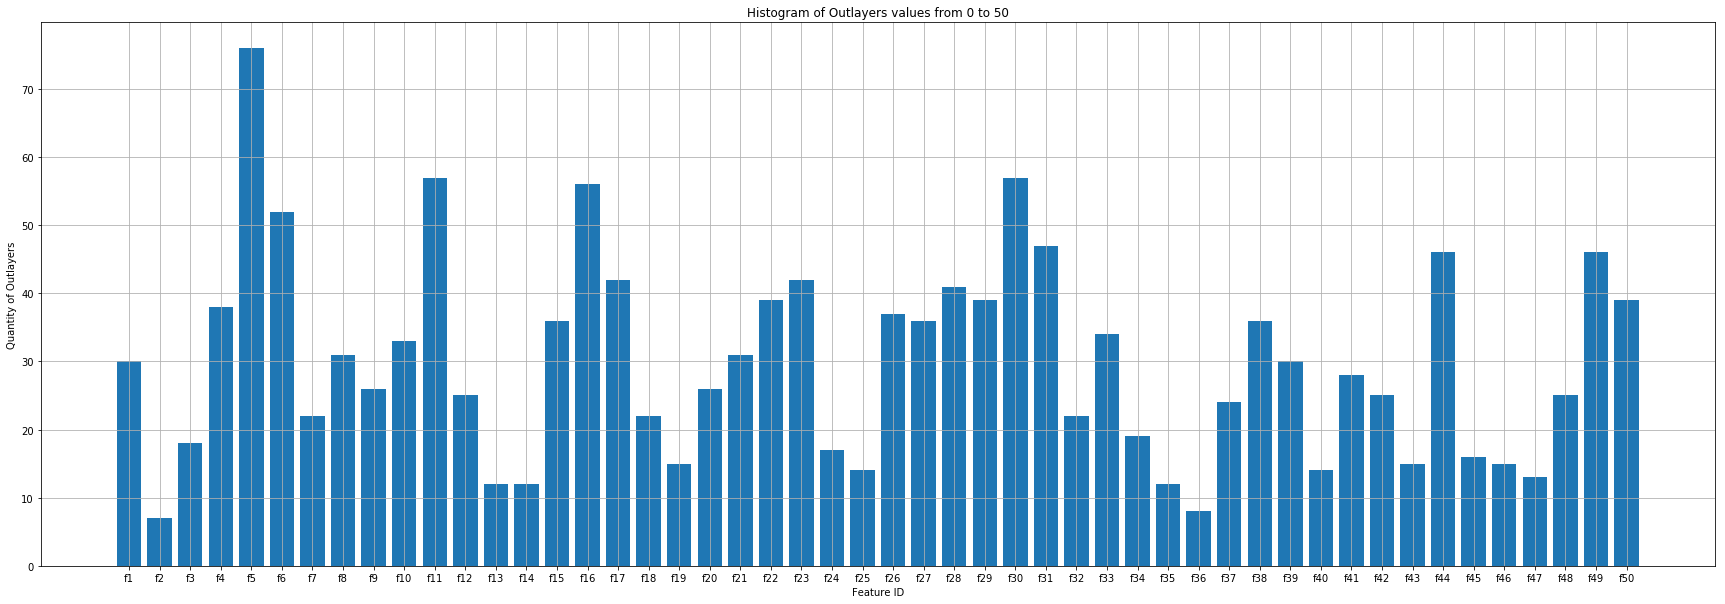

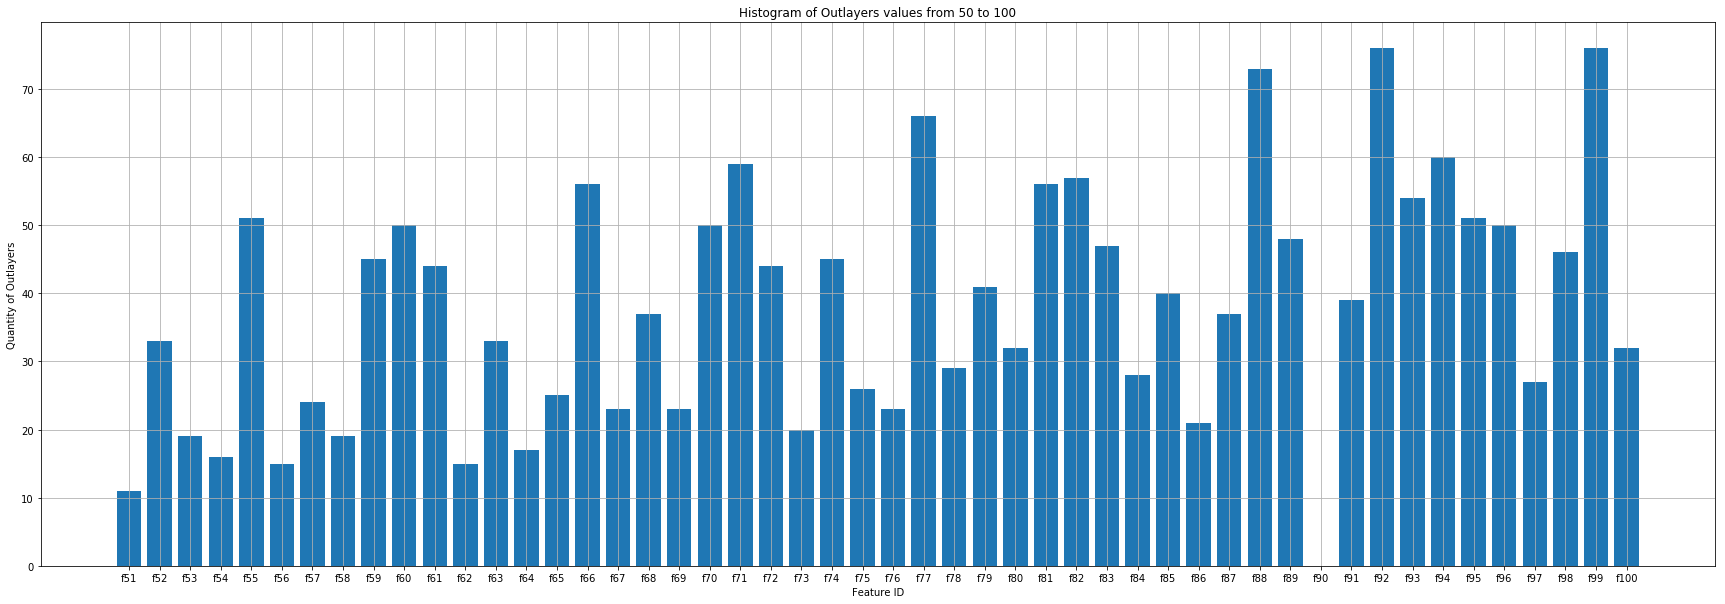

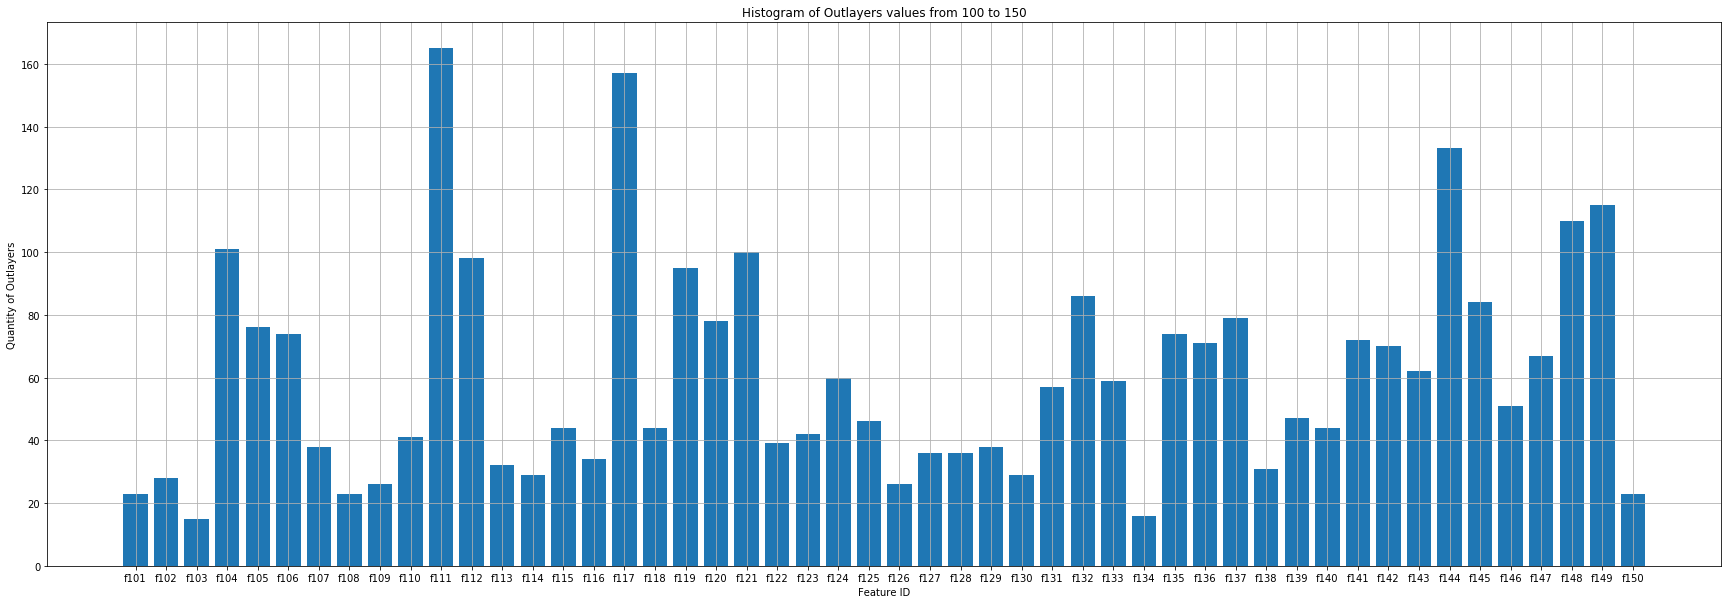

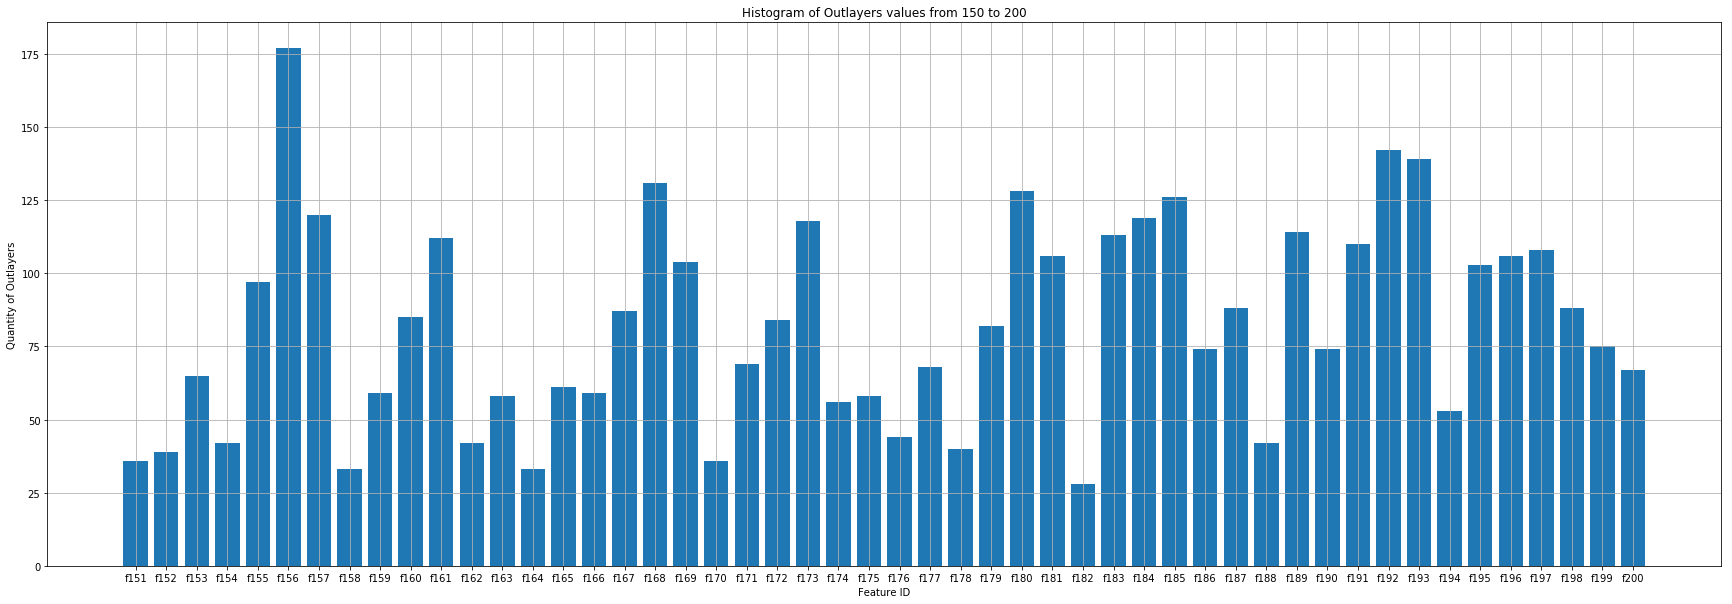

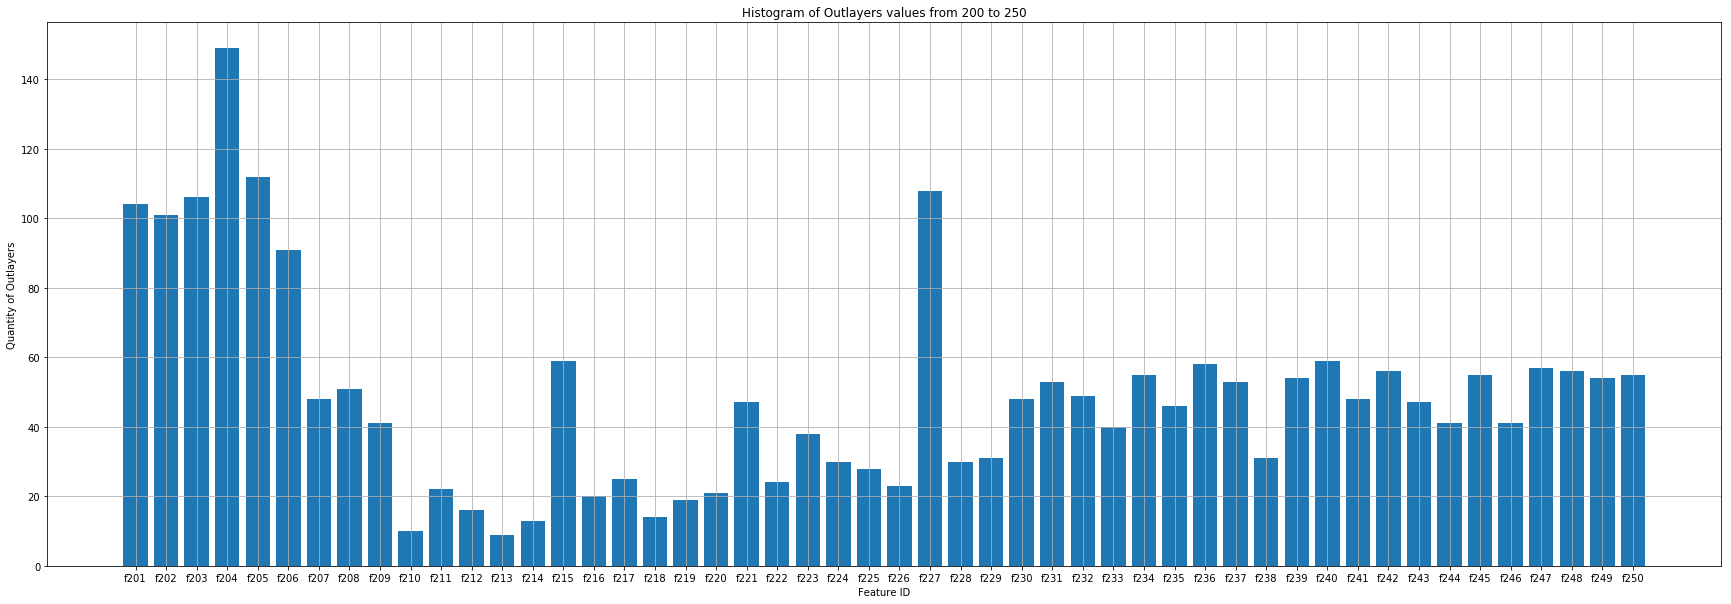

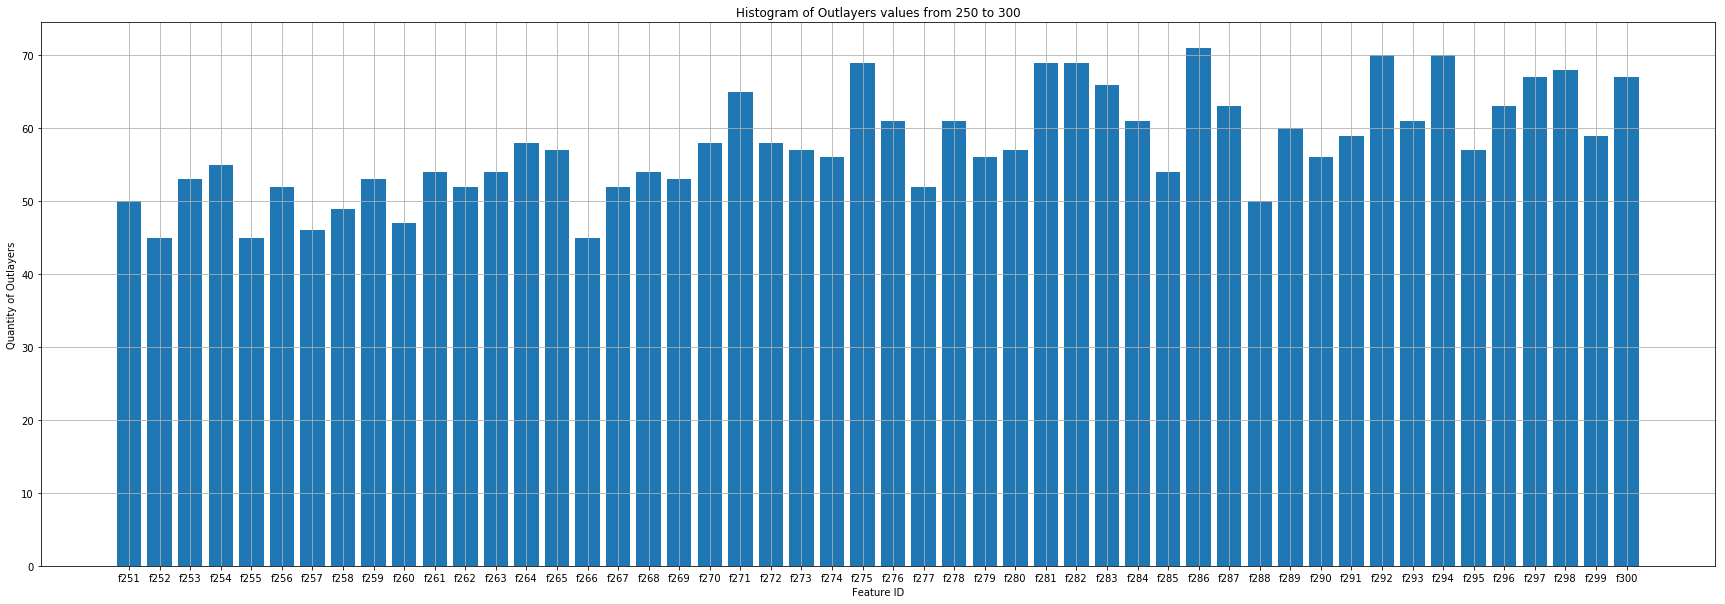

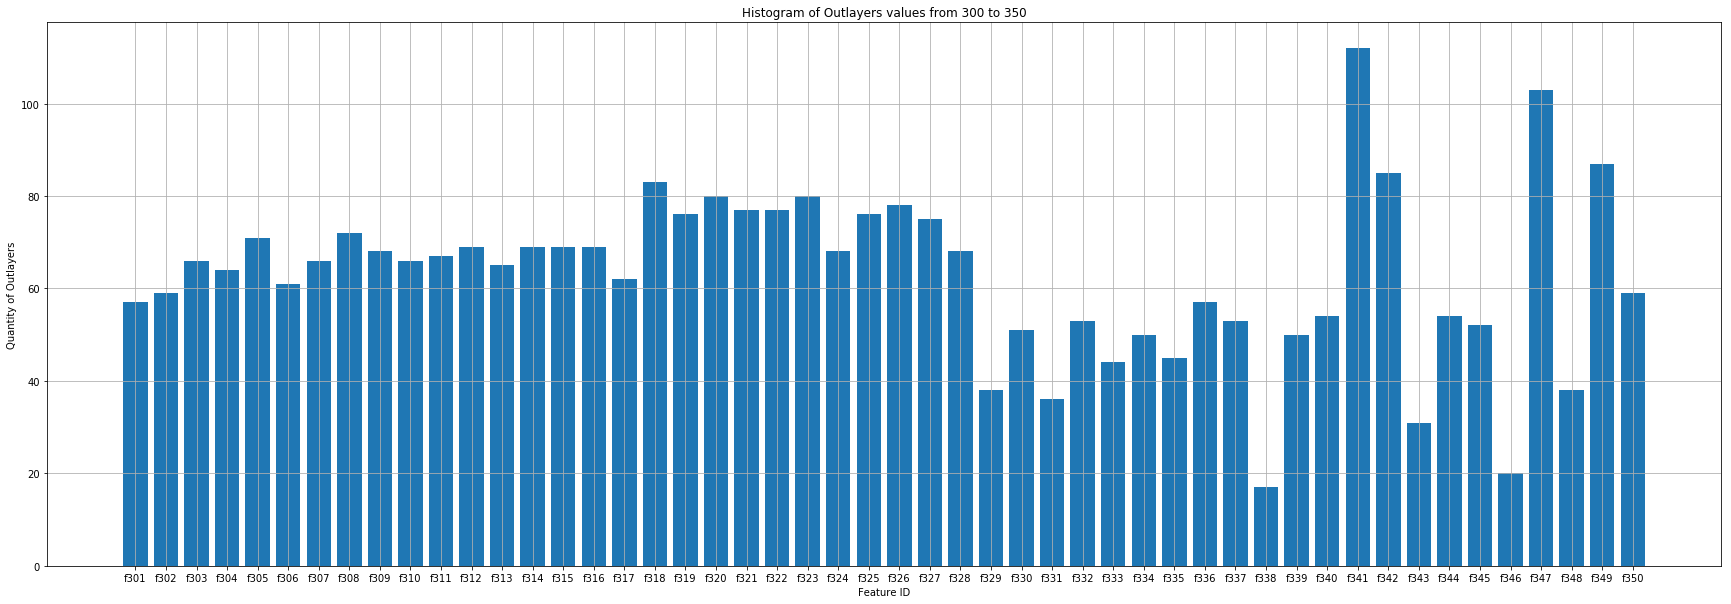

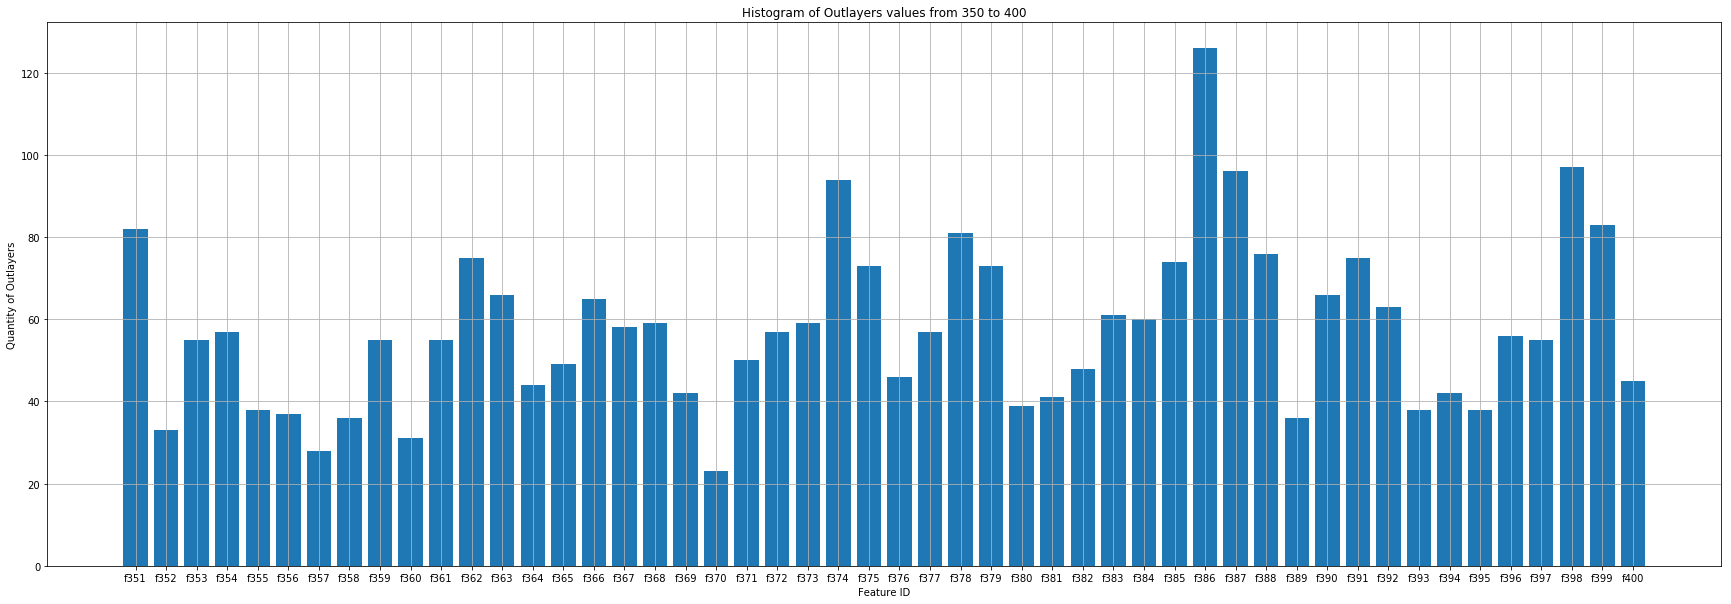

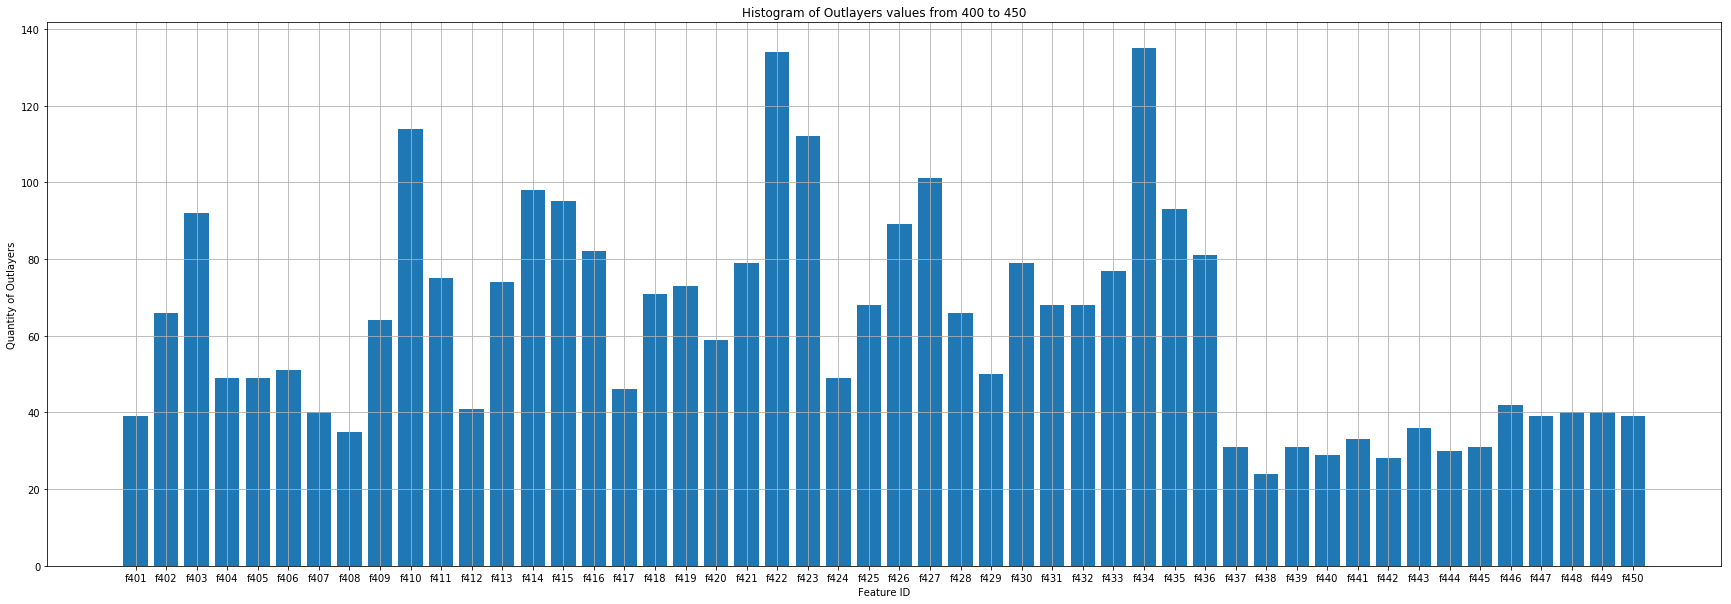

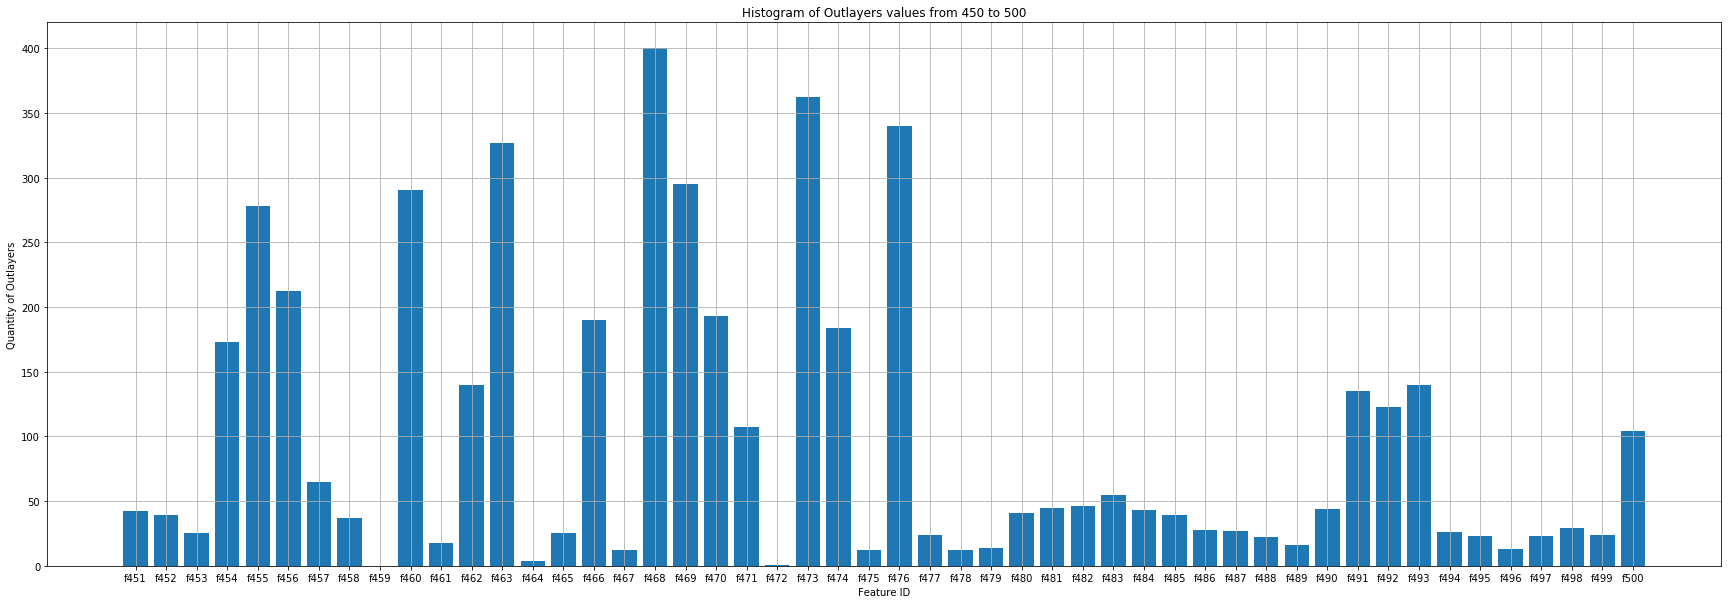

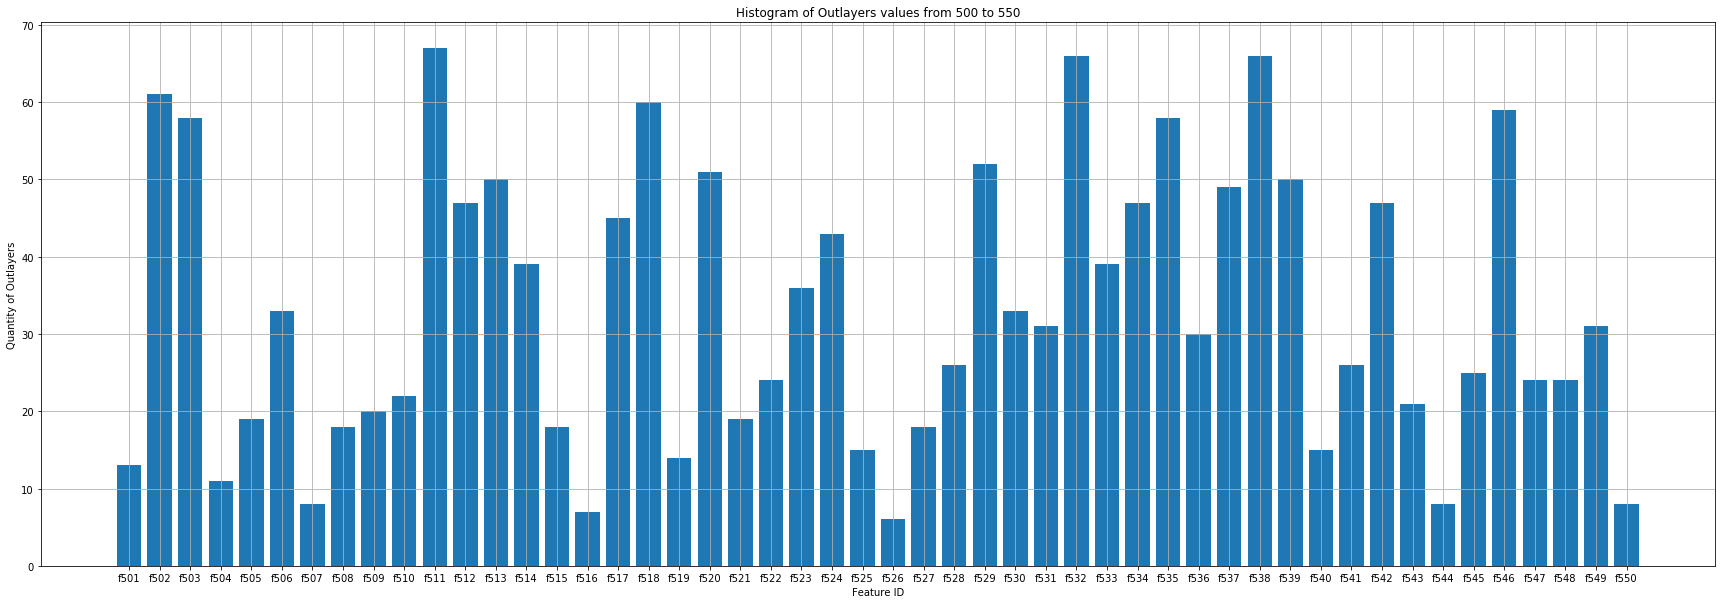

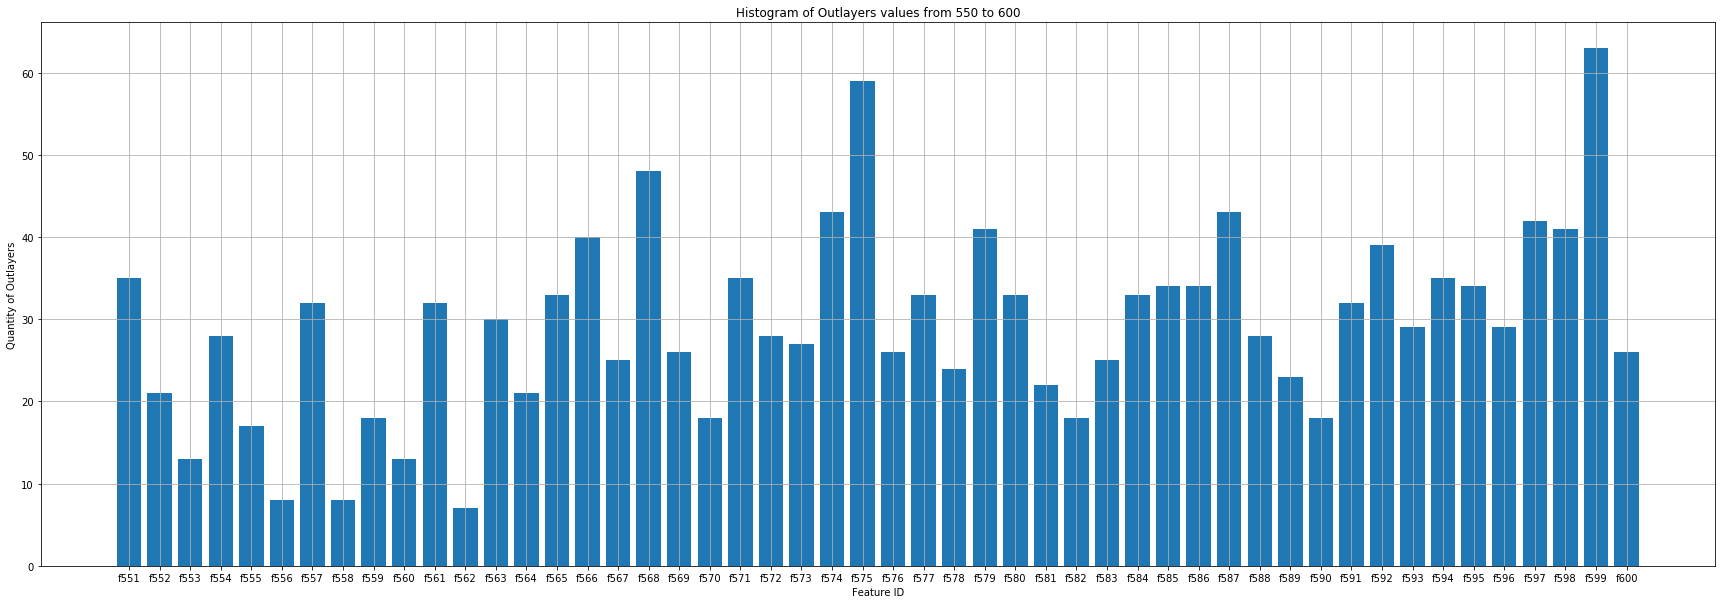

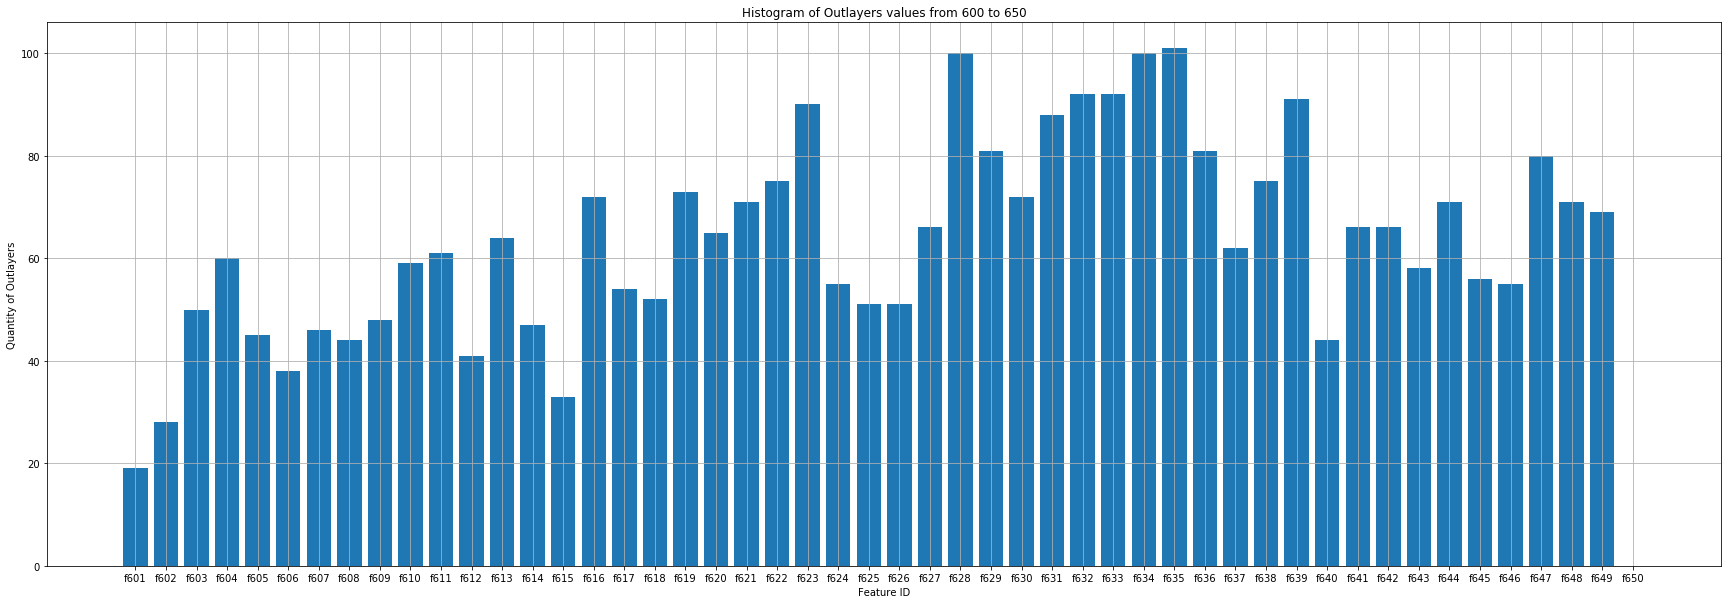

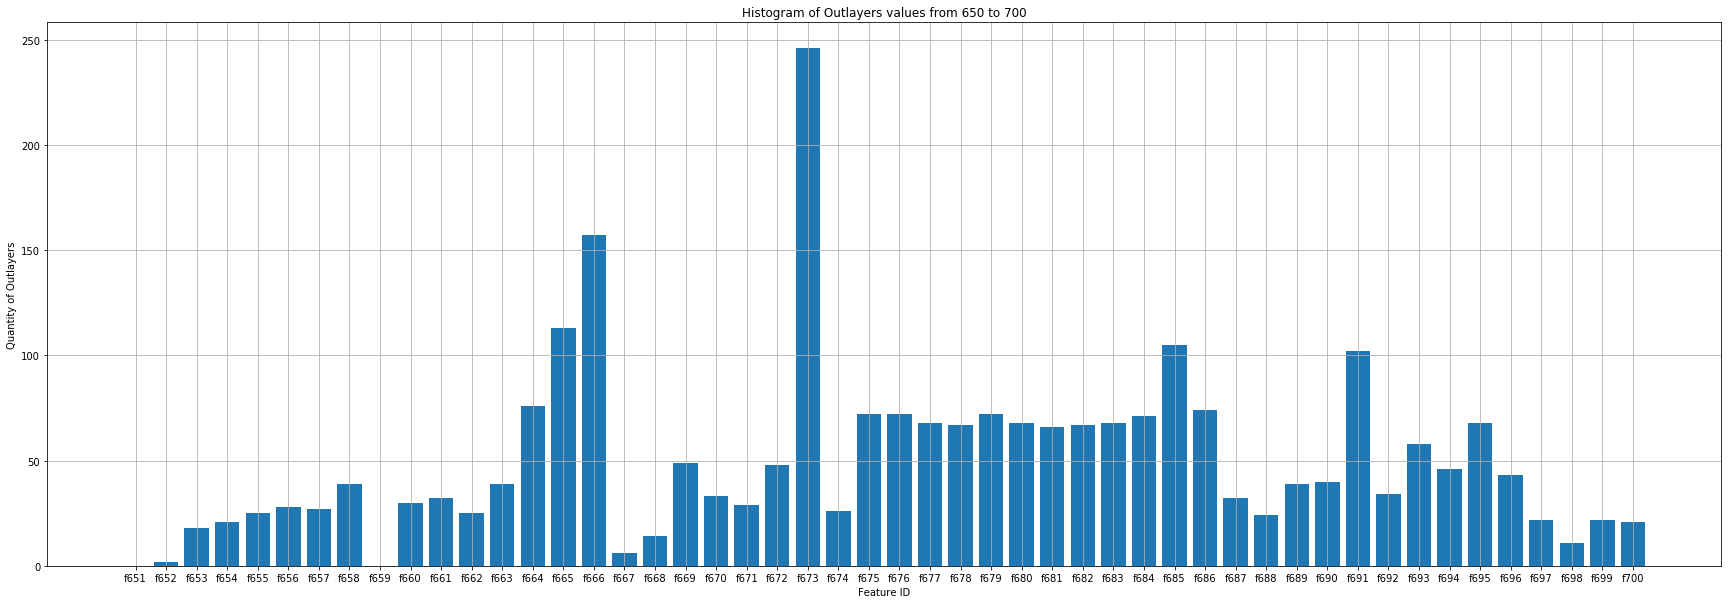

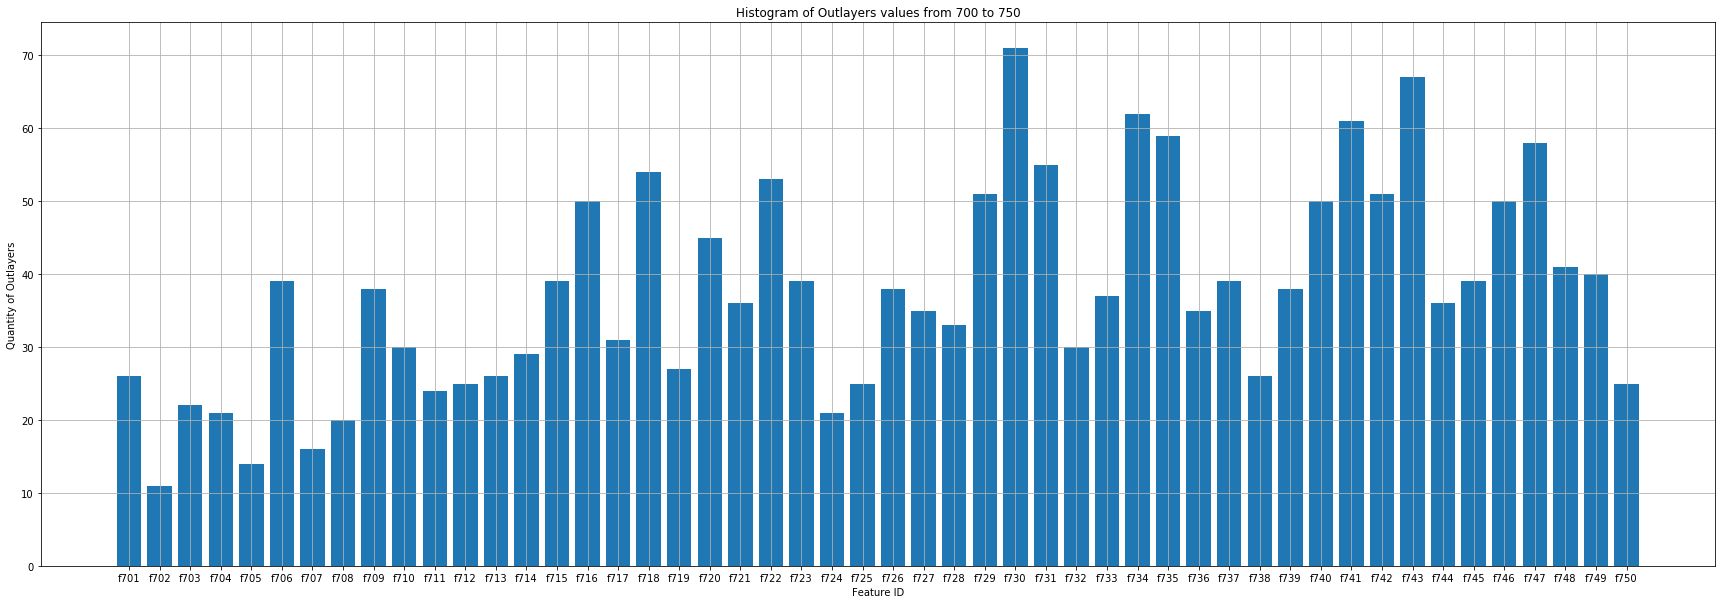

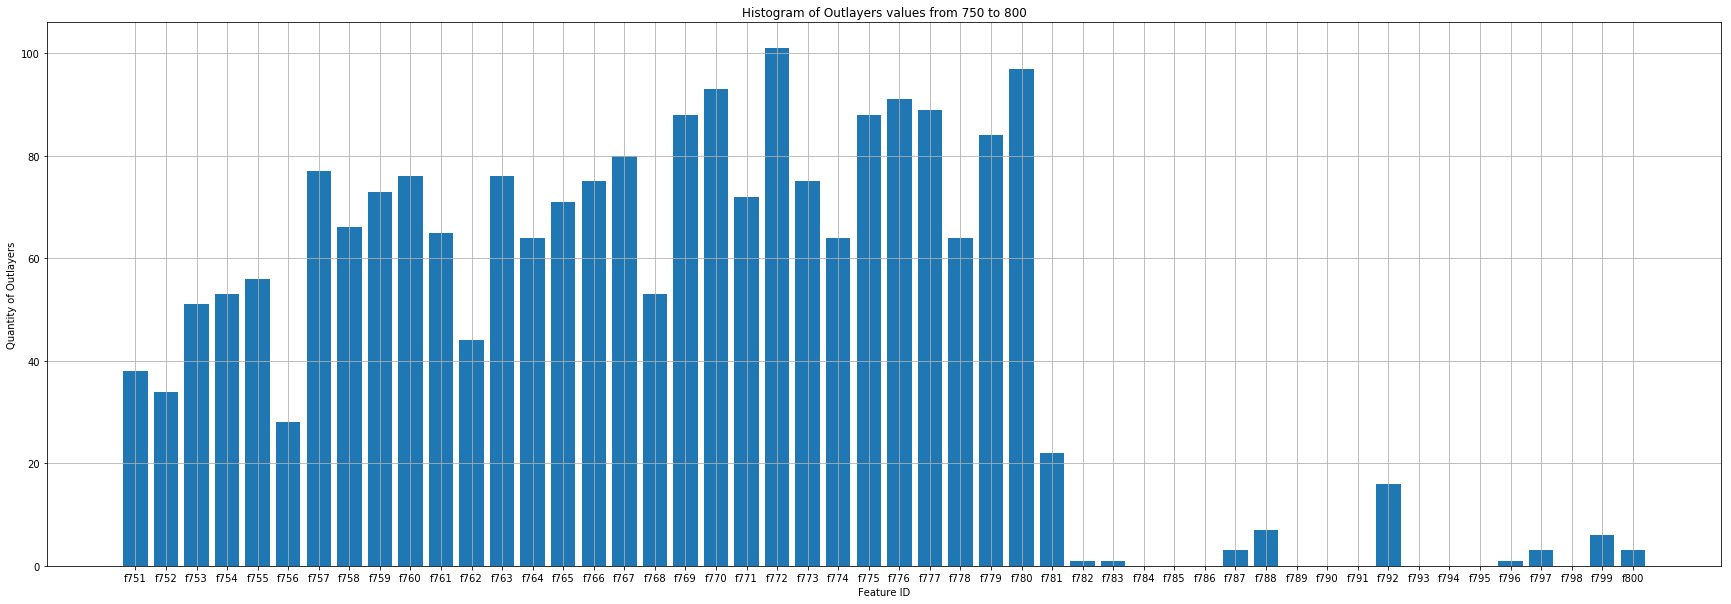

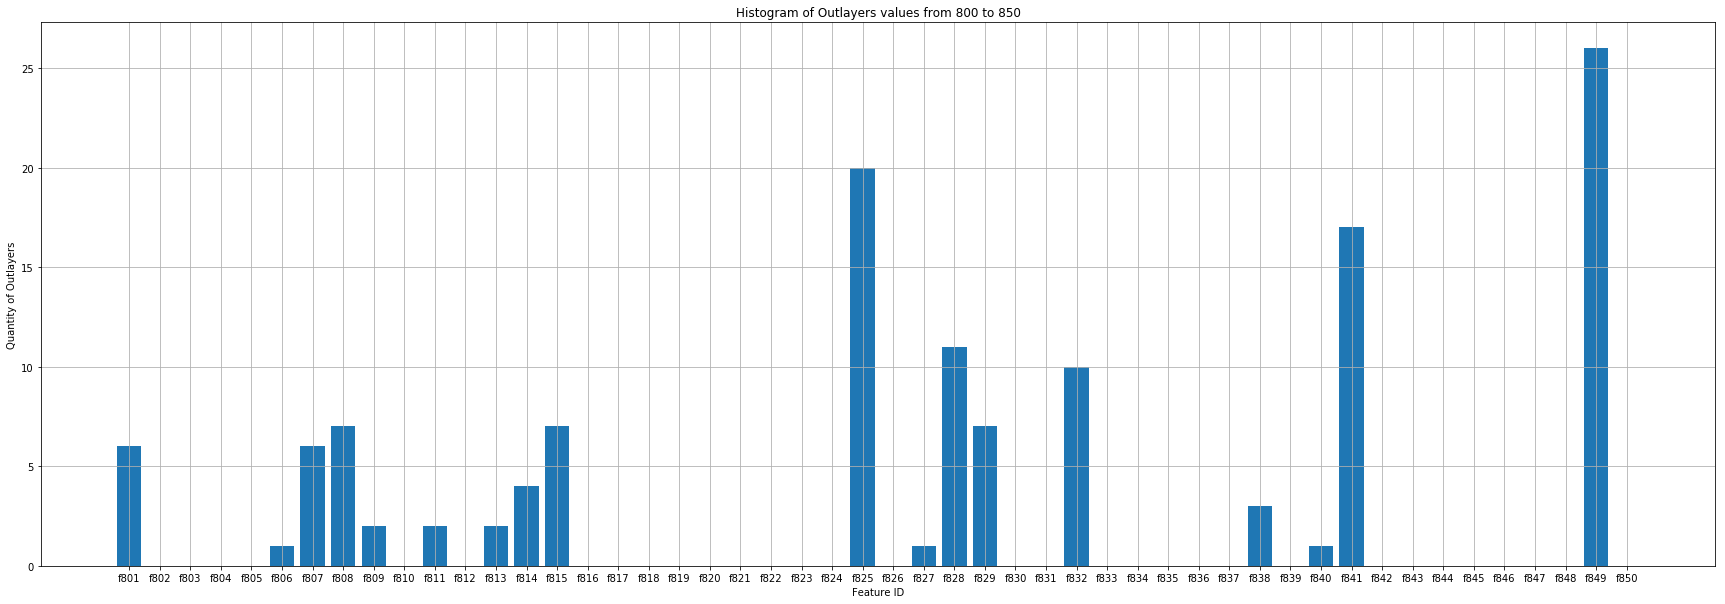

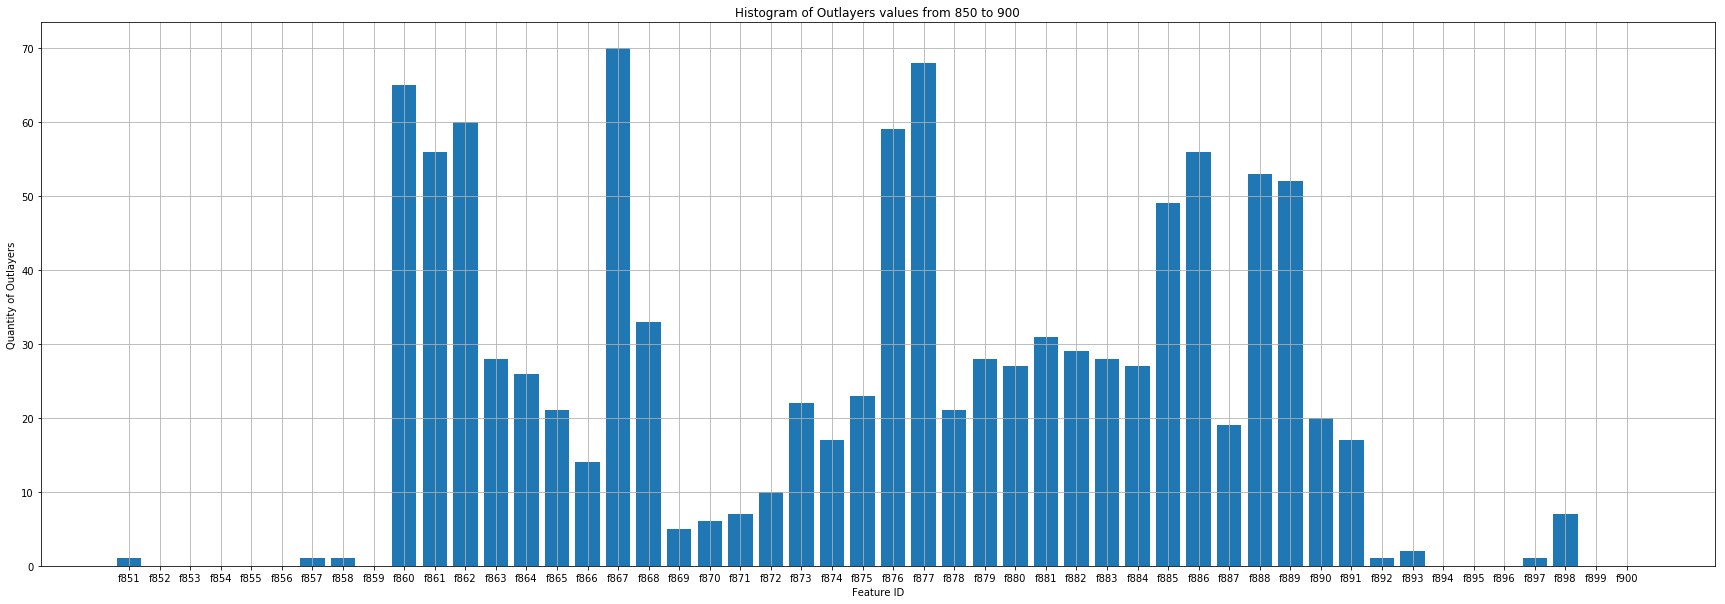

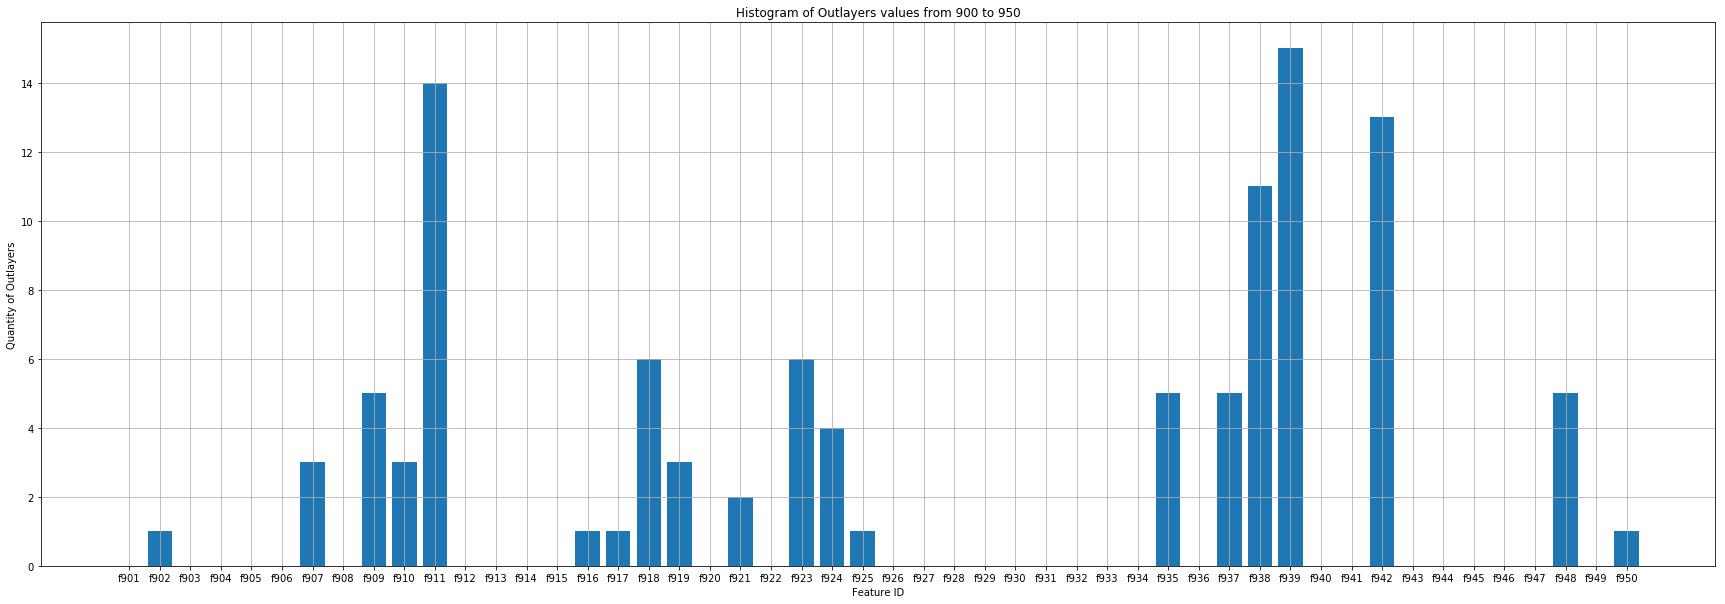

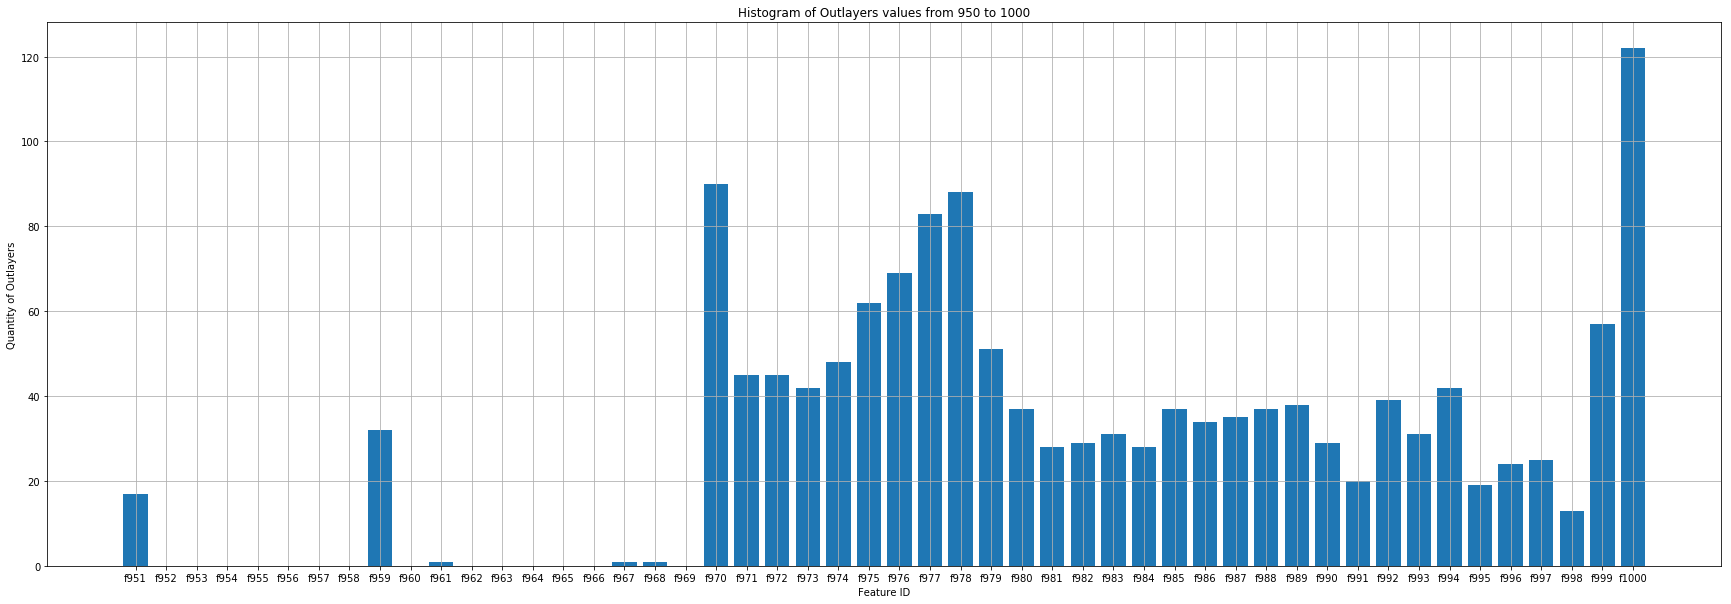

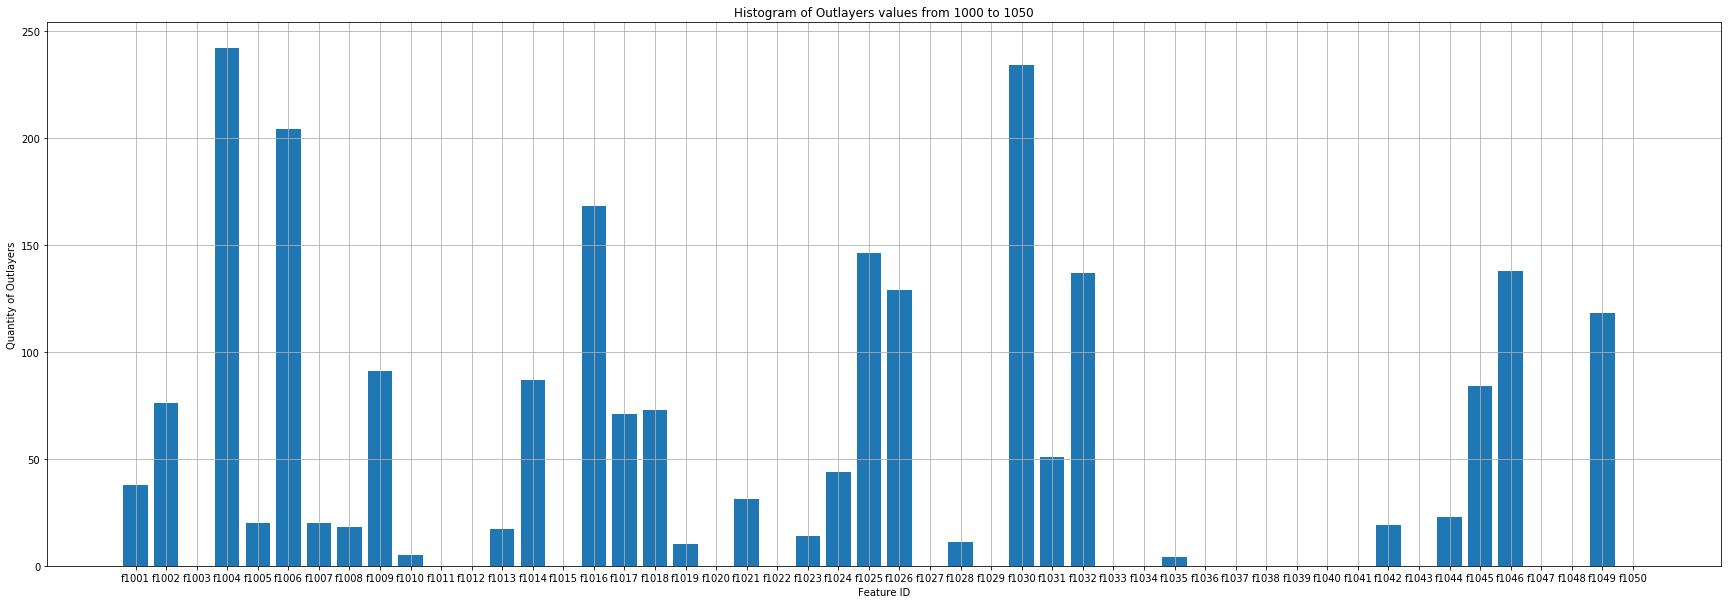

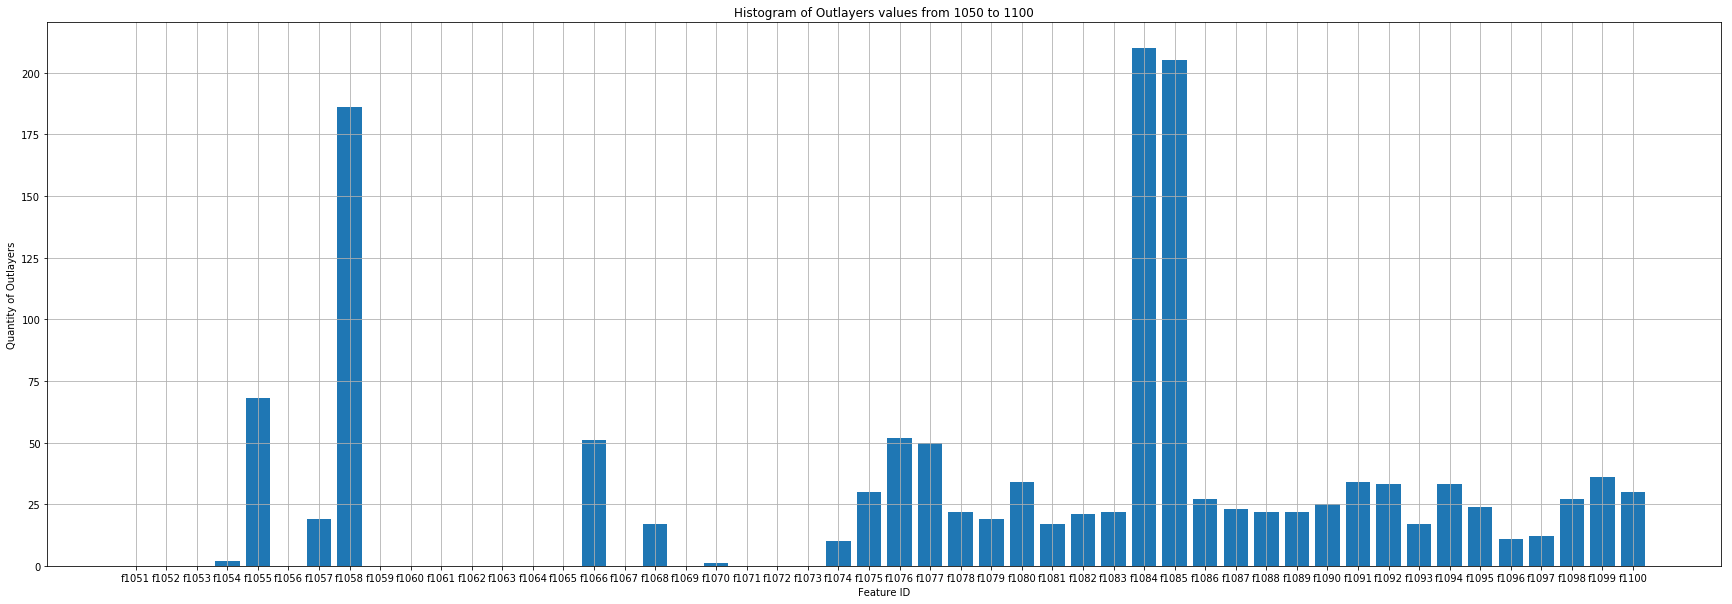

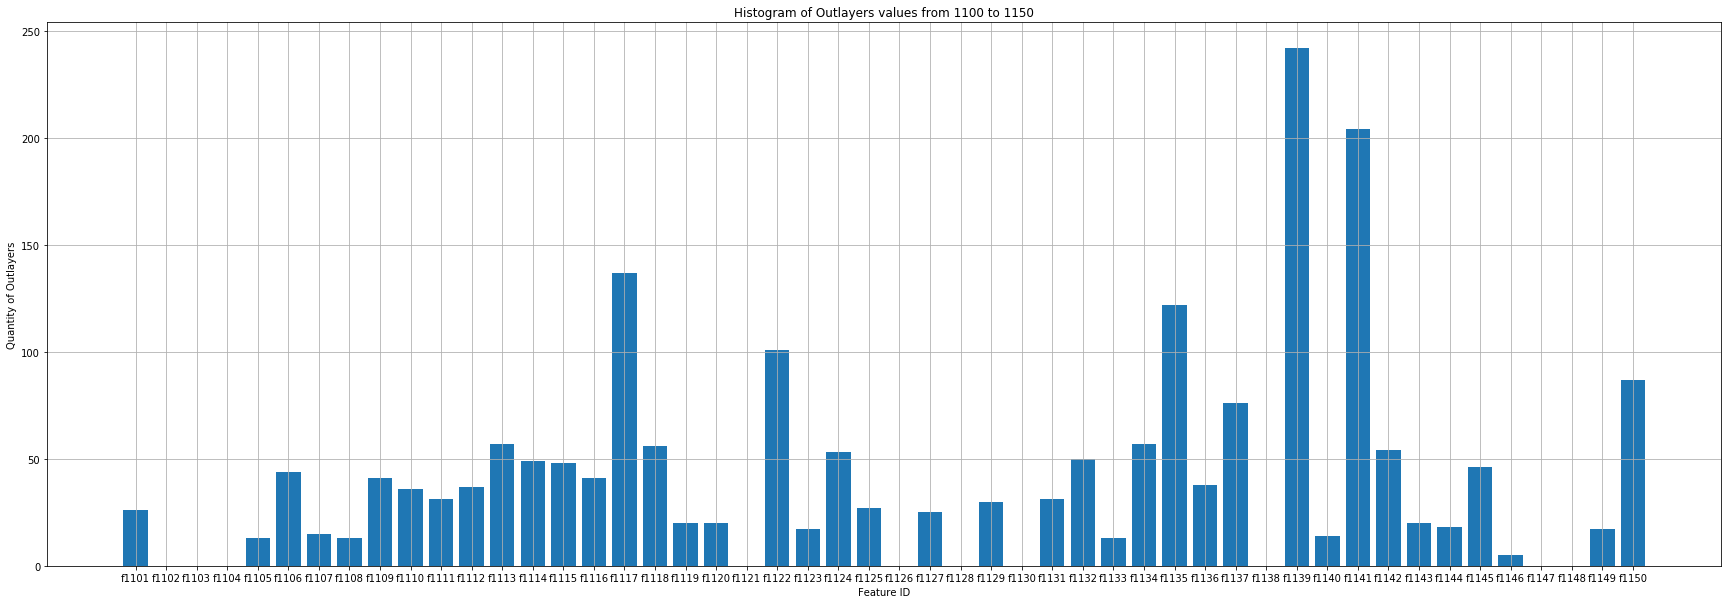

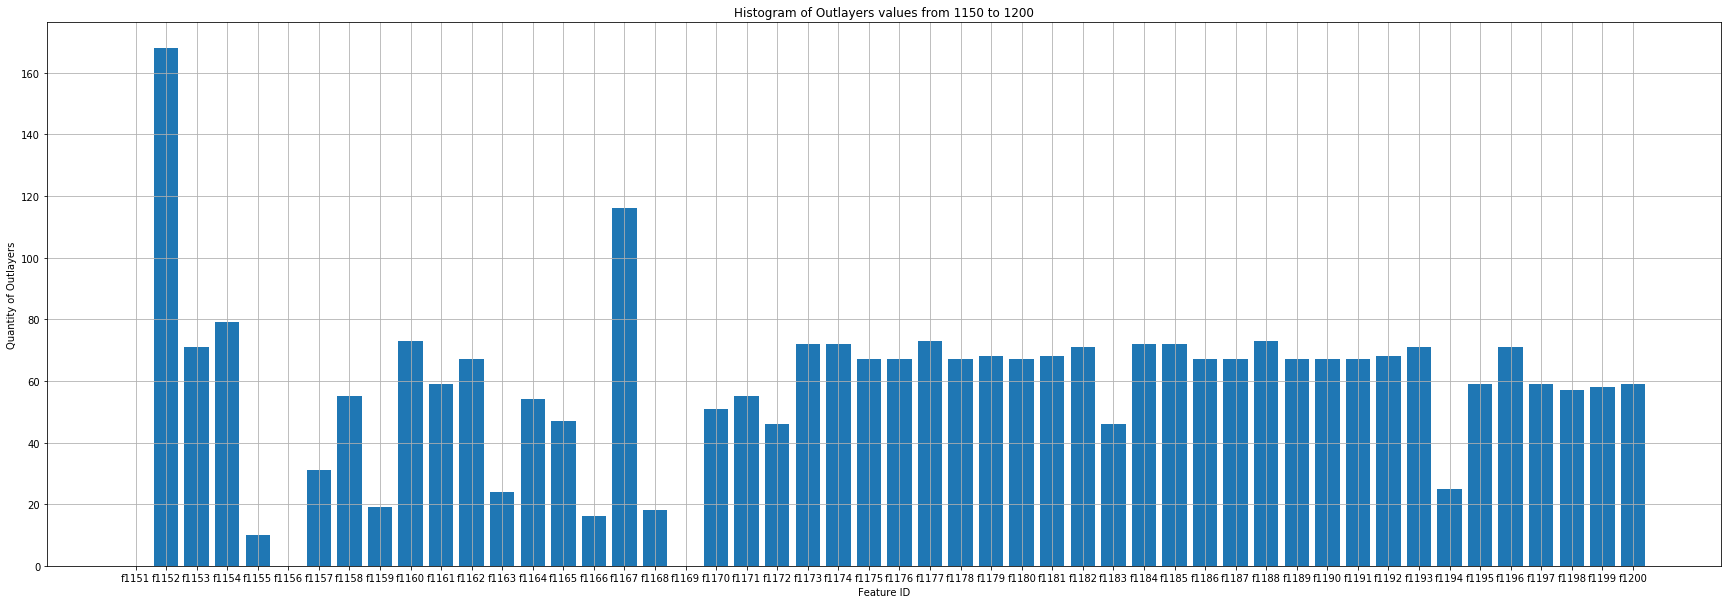

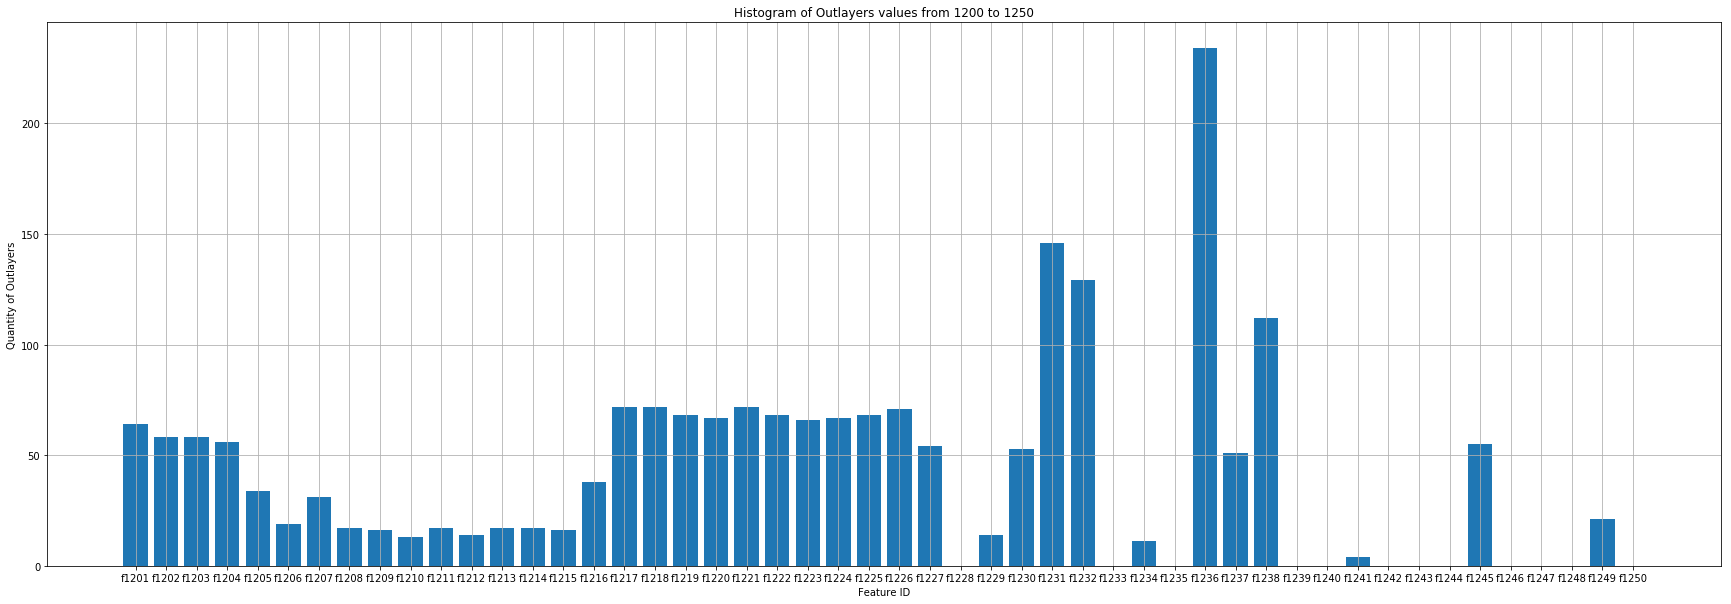

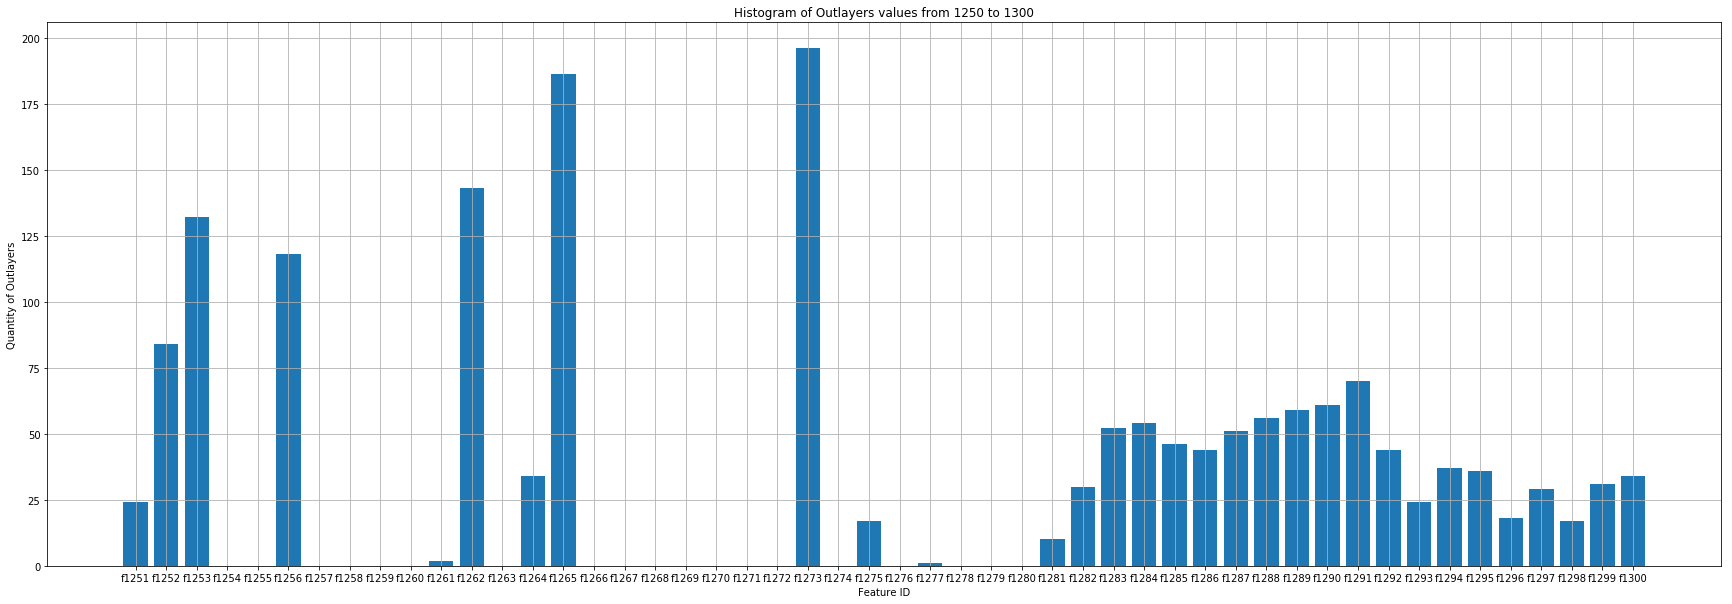

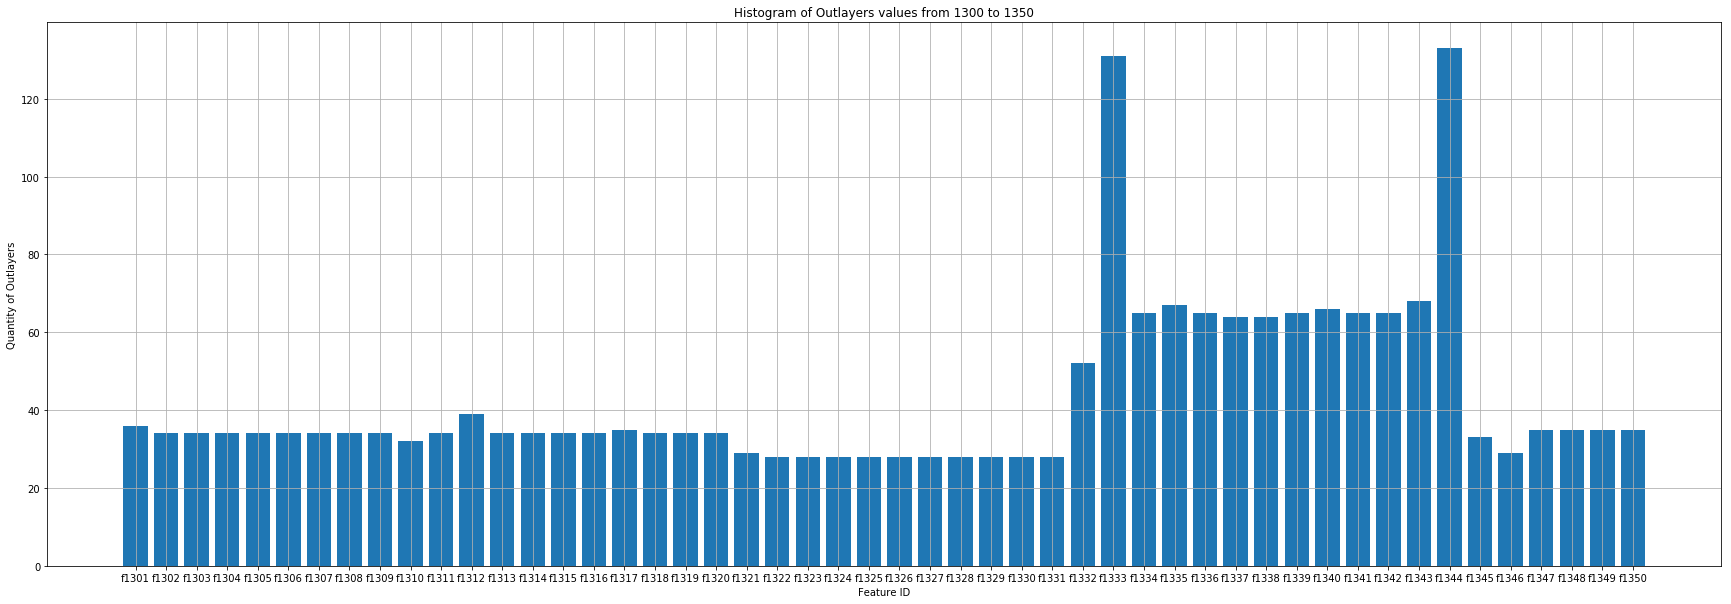

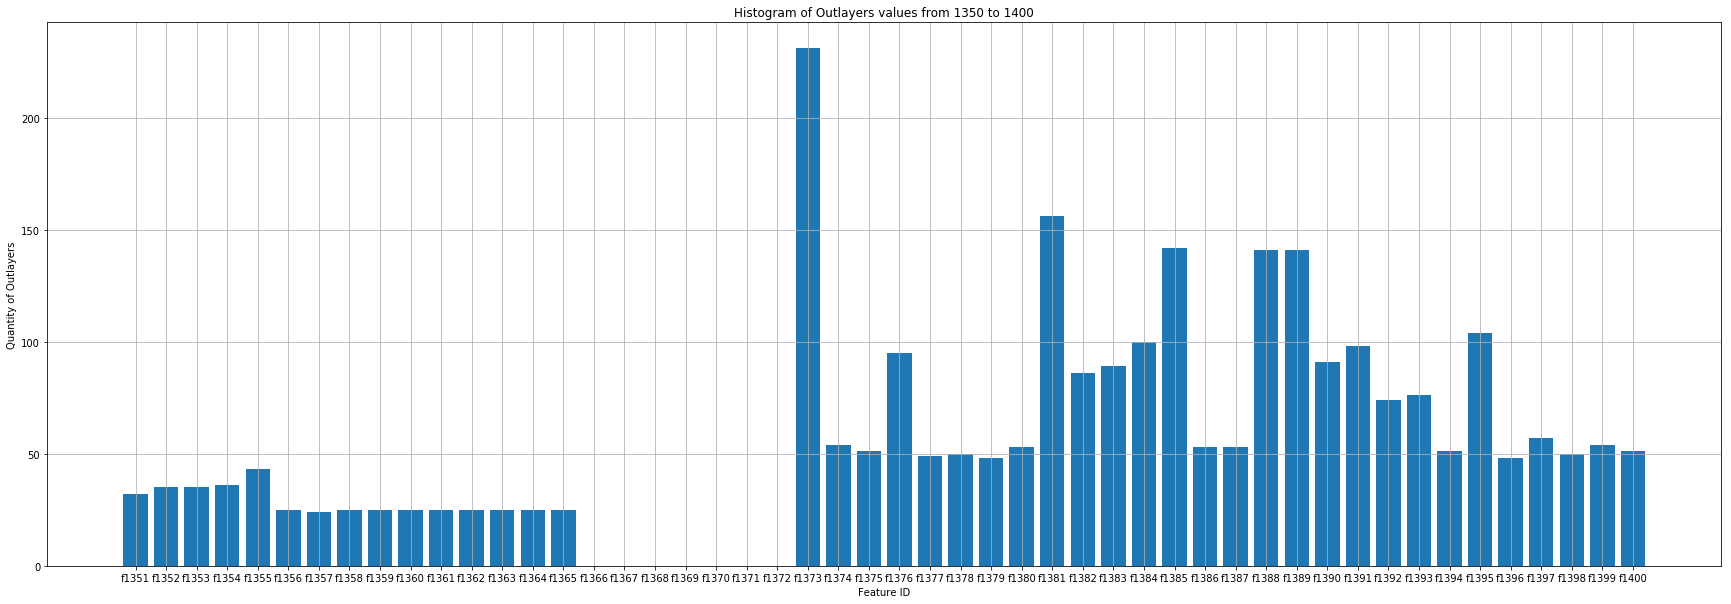

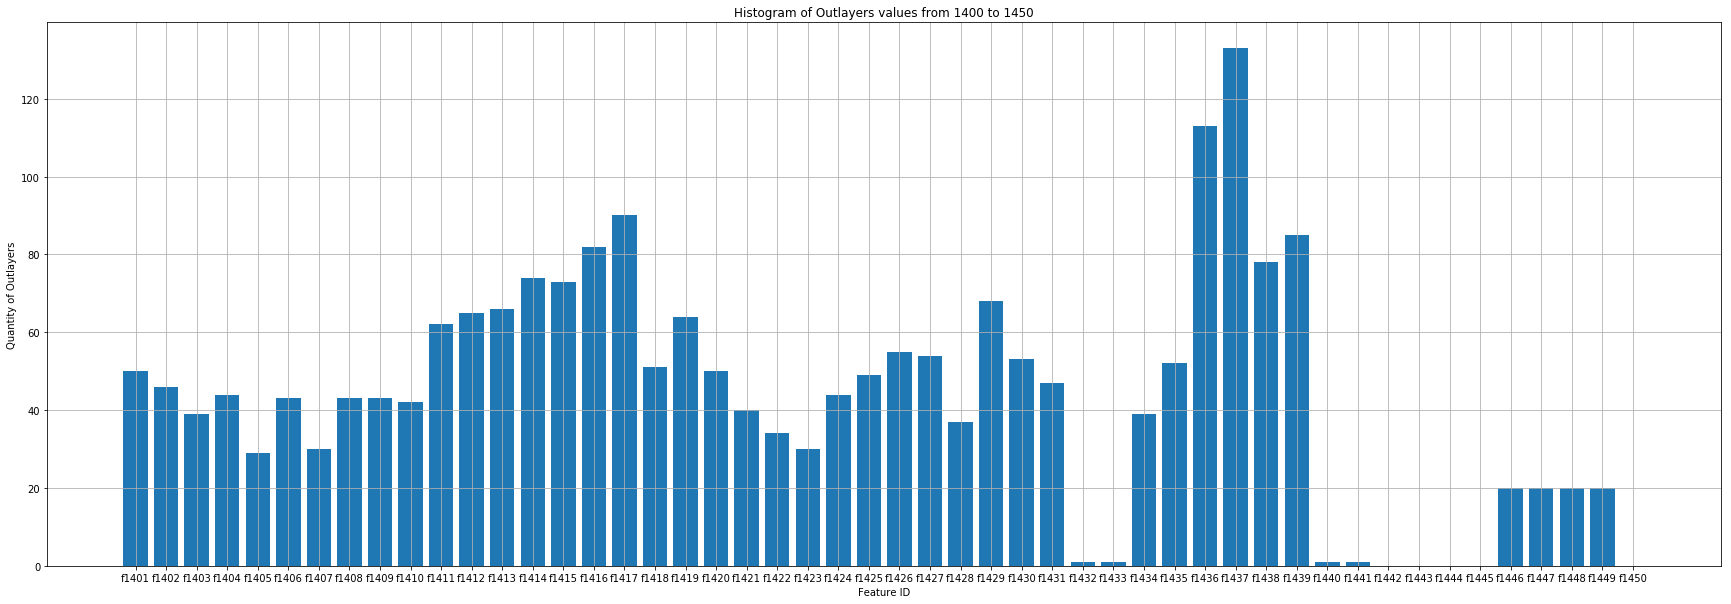

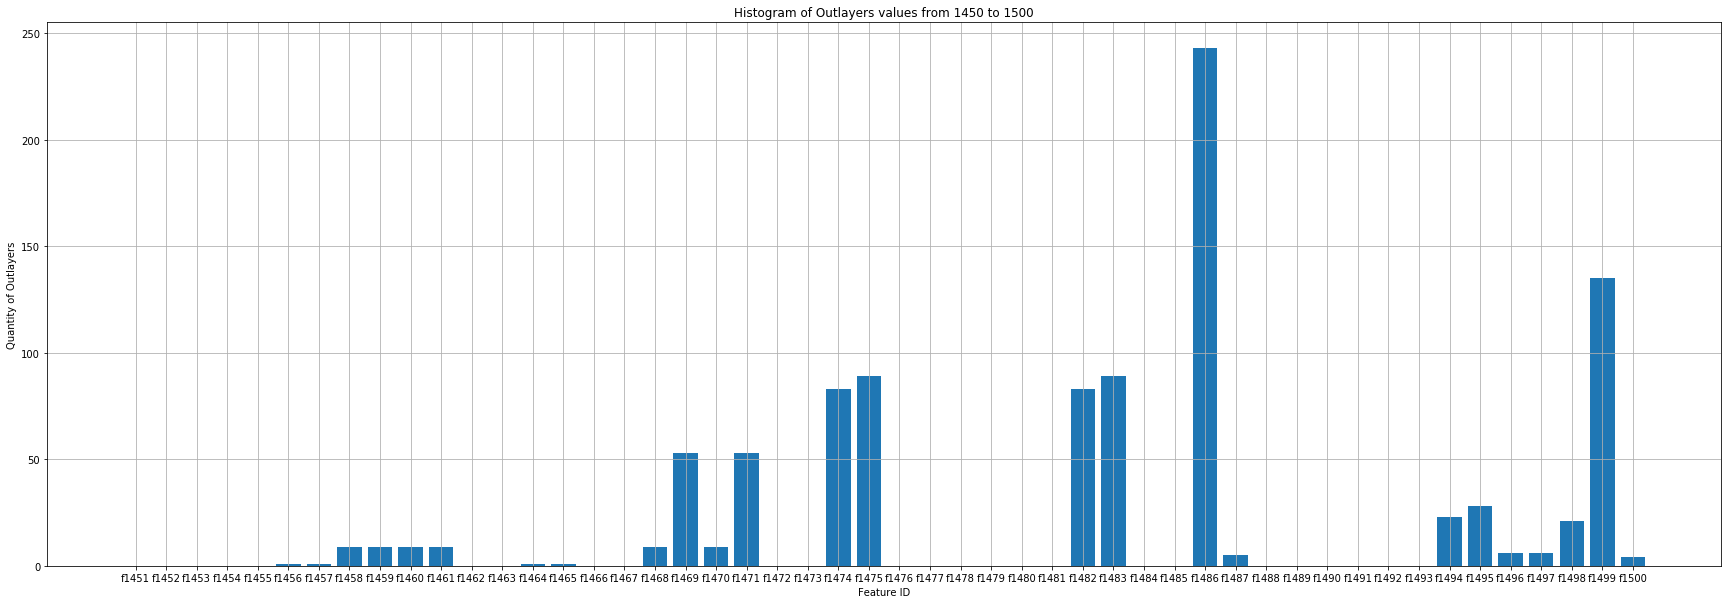

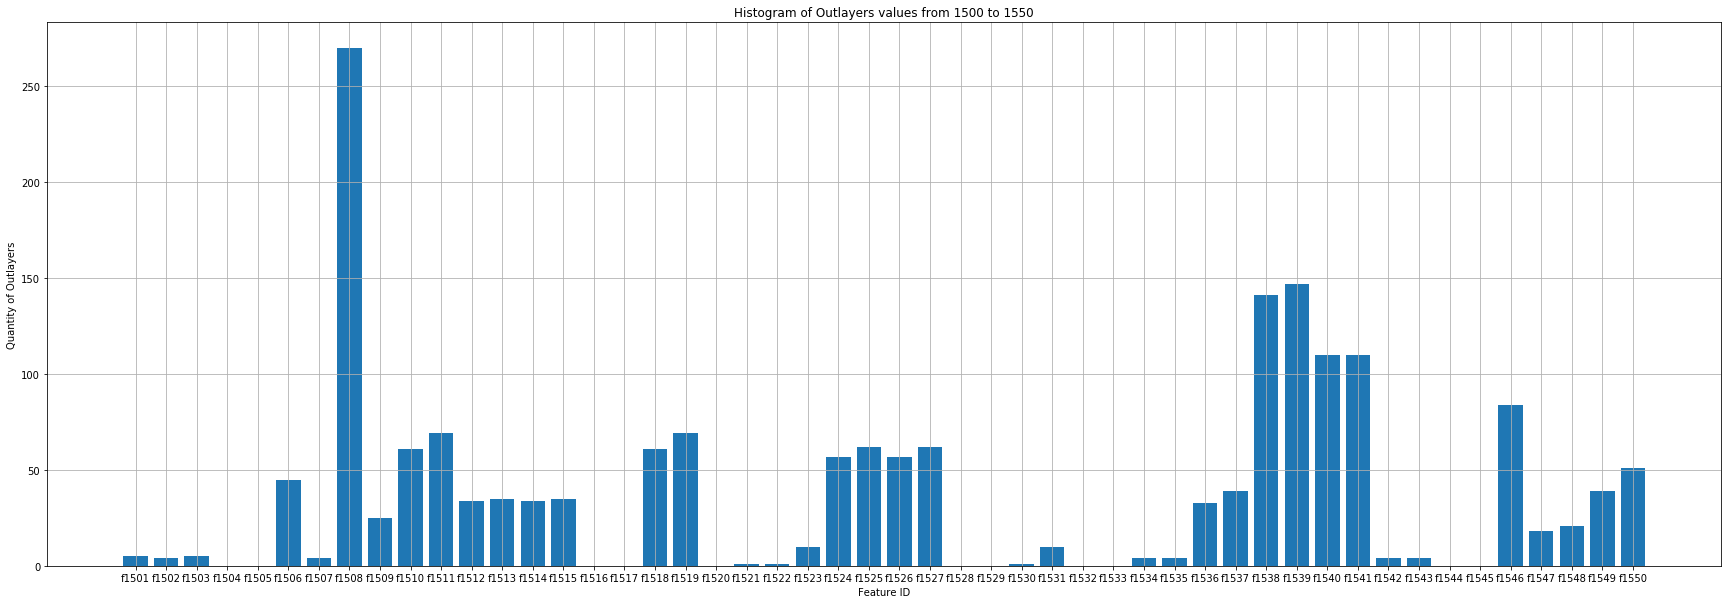

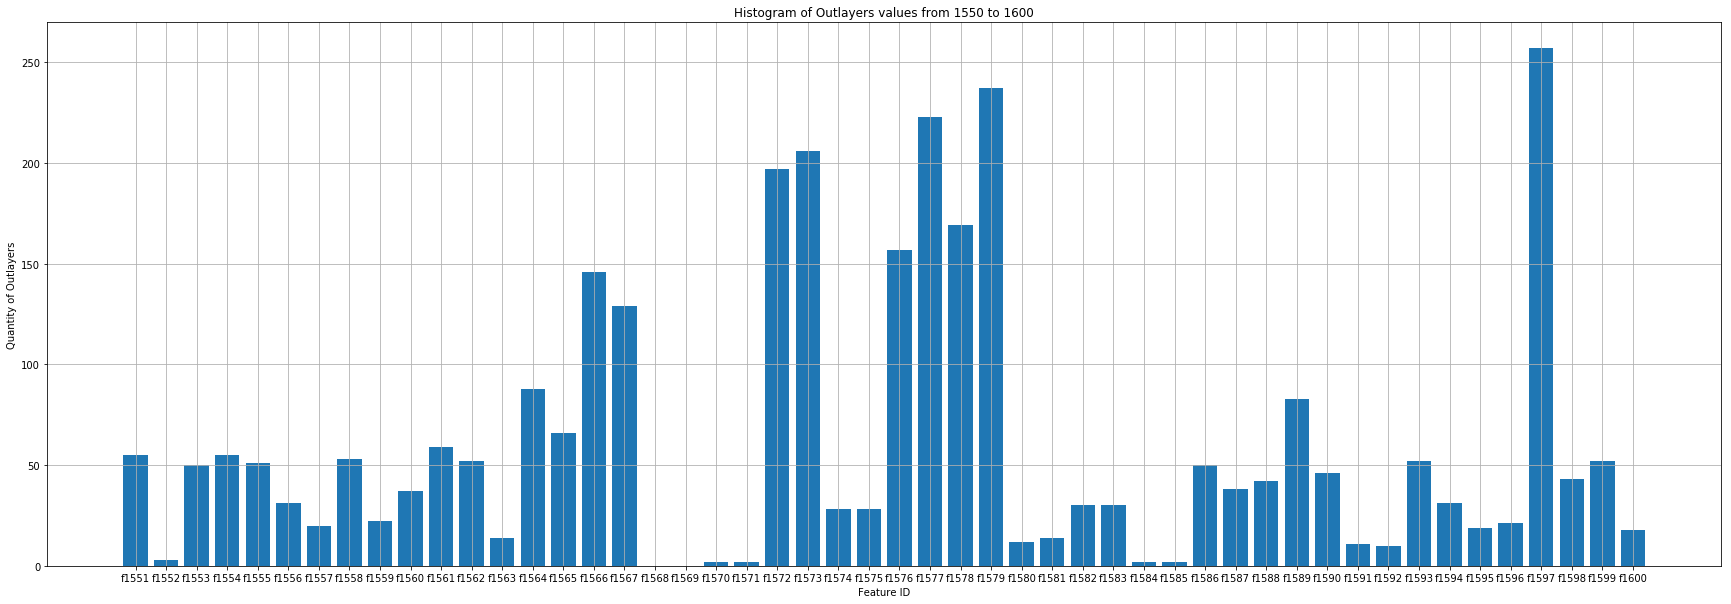

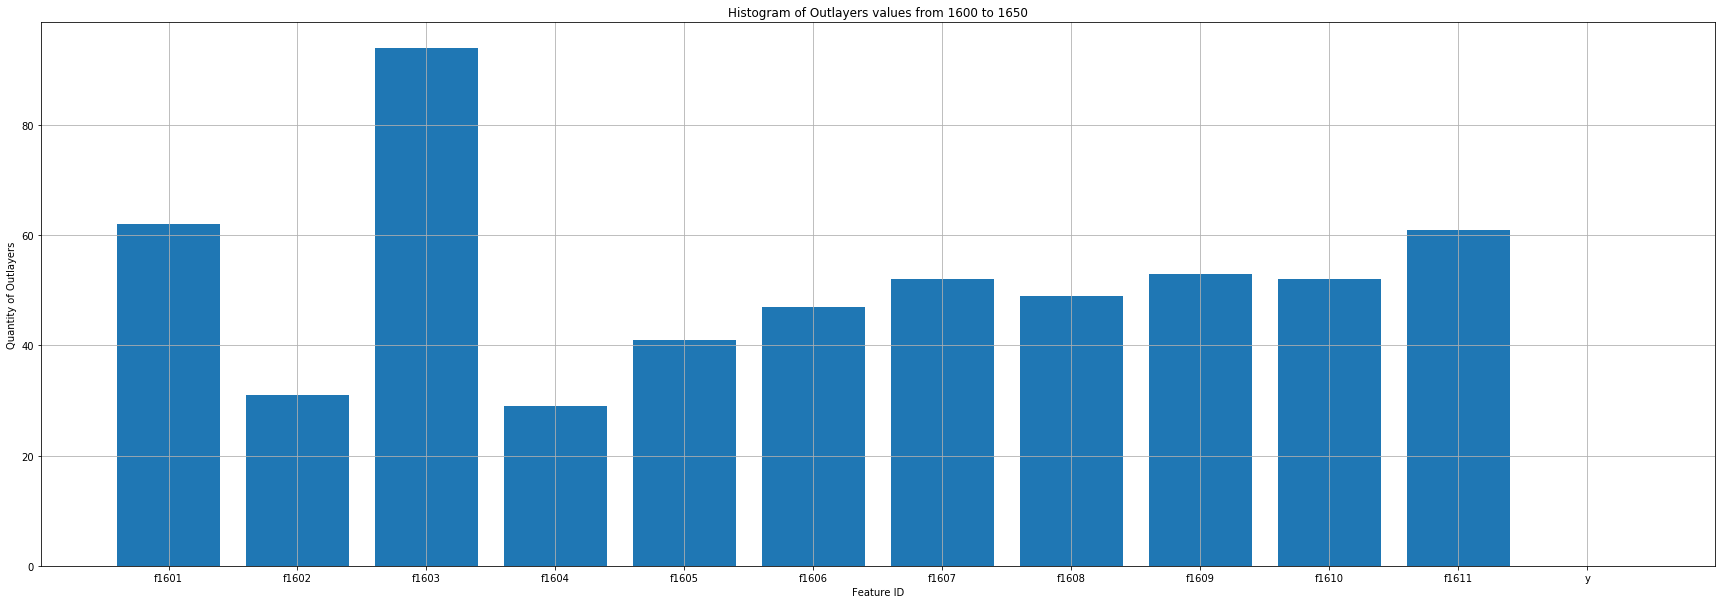

In [13]:
outlayer_calculation(train)

Удалим столбцы, в которых пустых значения больше 10

In [14]:
train = train.drop(emptys, axis = 1)
train.head()

f0        f1        f2         f3       f4        f5        f6  \
0  25.609375  6.703125  3.652344  10.039062  169.375  102.8125  1.422852   
1  18.343750  5.824219  2.966797   4.902344  164.625   71.8125  1.357422   
2  28.562500  6.230469  3.583984   7.882812  159.500  113.1875  1.696289   
3  28.062500  6.132812  2.726562   6.378906  169.750  111.0000  1.535156   
4  20.109375  6.144531  3.203125   6.035156  164.750   78.8750  1.281250   

         f7        f8        f9 ...     f1603     f1604     f1605     f1606  \
0  6.722656  8.015625  8.109375 ...  8.070312  4.363281  5.019531  5.710938   
1  5.894531  2.753906  7.406250 ...  7.359375  4.195312  4.808594  5.425781   
2  6.316406  4.605469  7.753906 ...  8.562500  4.523438  5.097656  5.789062   
3  6.199219  3.712891  7.664062 ...  4.558594  3.533203  3.900391  4.261719   
4  6.187500  4.003906  7.734375 ...  6.613281  4.625000  4.996094  5.328125   

      f1607     f1608     f1609     f1610     f1611  y  
0  6.343750  6.843750  7.289062  7.617188  7.980469  1  
1  5.949219  6.339844  6.730469  7.074219  7.175781  1  
2  6.457031  6.871094  7.386719  7.878906  8.328125  1  
3  4.042969  3.869141  3.890625  4.042969  4.273438  1  
4  5.593750  5.800781  6.027344  6.242188  6.449219  0  

[5 rows x 1290 columns]

In [15]:
test = test.drop(emptys, axis = 1)

In [16]:
test_samp = test_samp.drop(emptys, axis = 1)

Заменим inf-ы максимальными значениями в каждом столбце

In [17]:
for field in infs:
    m = train.loc[train[field] != np.inf, field].max()
    train[field].replace(np.inf, m, inplace=True)
    test_samp[field].replace(np.inf, m, inplace=True)

Выбросим все столбцы, которые имеют одни и те же значения

In [18]:
constant_columns = train.columns[train.nunique()==1]
train = train.drop(constant_columns, axis = 1)
test_samp = test_samp.drop(constant_columns, axis = 1)

In [19]:
train.head()

f0        f1        f2         f3       f4        f5        f6  \
0  25.609375  6.703125  3.652344  10.039062  169.375  102.8125  1.422852   
1  18.343750  5.824219  2.966797   4.902344  164.625   71.8125  1.357422   
2  28.562500  6.230469  3.583984   7.882812  159.500  113.1875  1.696289   
3  28.062500  6.132812  2.726562   6.378906  169.750  111.0000  1.535156   
4  20.109375  6.144531  3.203125   6.035156  164.750   78.8750  1.281250   

         f7        f8        f9 ...     f1603     f1604     f1605     f1606  \
0  6.722656  8.015625  8.109375 ...  8.070312  4.363281  5.019531  5.710938   
1  5.894531  2.753906  7.406250 ...  7.359375  4.195312  4.808594  5.425781   
2  6.316406  4.605469  7.753906 ...  8.562500  4.523438  5.097656  5.789062   
3  6.199219  3.712891  7.664062 ...  4.558594  3.533203  3.900391  4.261719   
4  6.187500  4.003906  7.734375 ...  6.613281  4.625000  4.996094  5.328125   

      f1607     f1608     f1609     f1610     f1611  y  
0  6.343750  6.843750  7.289062  7.617188  7.980469  1  
1  5.949219  6.339844  6.730469  7.074219  7.175781  1  
2  6.457031  6.871094  7.386719  7.878906  8.328125  1  
3  4.042969  3.869141  3.890625  4.042969  4.273438  1  
4  5.593750  5.800781  6.027344  6.242188  6.449219  0  

[5 rows x 1165 columns]

In [20]:
def level_calculating(df):
    """
    Function which calculate and plot level value of predictor
    """
    levels = df.drop(['y'], axis=1).nunique()
    keys = list(levels.keys())
    for i in range(0,len(keys), 50):
        plt.figure(figsize=[30,10])
        plt.bar(keys[i:i + 50], list(levels.values)[i:i + 50])
        plt.title(f'Histogram of Levels values from {i} to {i+50}')
        plt.xlabel('Feature ID')
        plt.ylabel(f'Quantity of Levels')
        plt.grid(True)
        plt.show()
    return levels

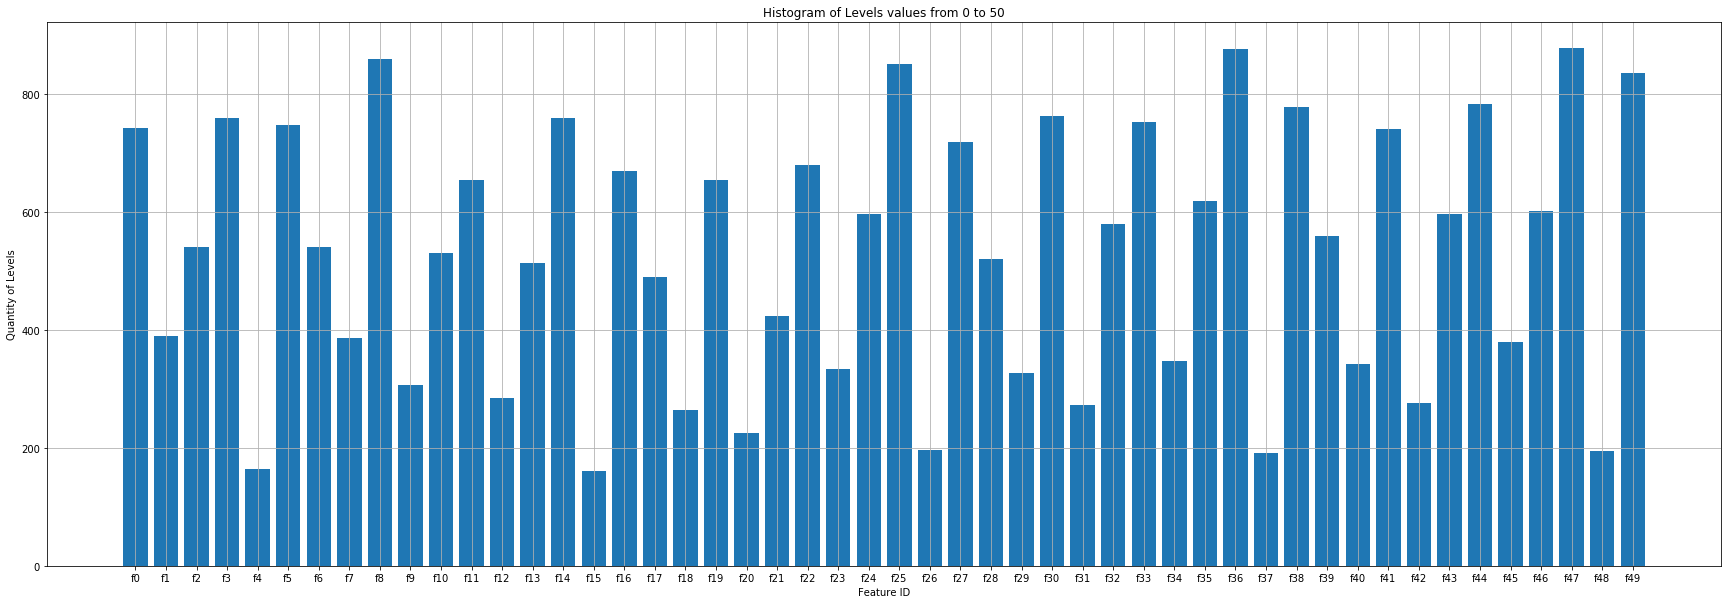

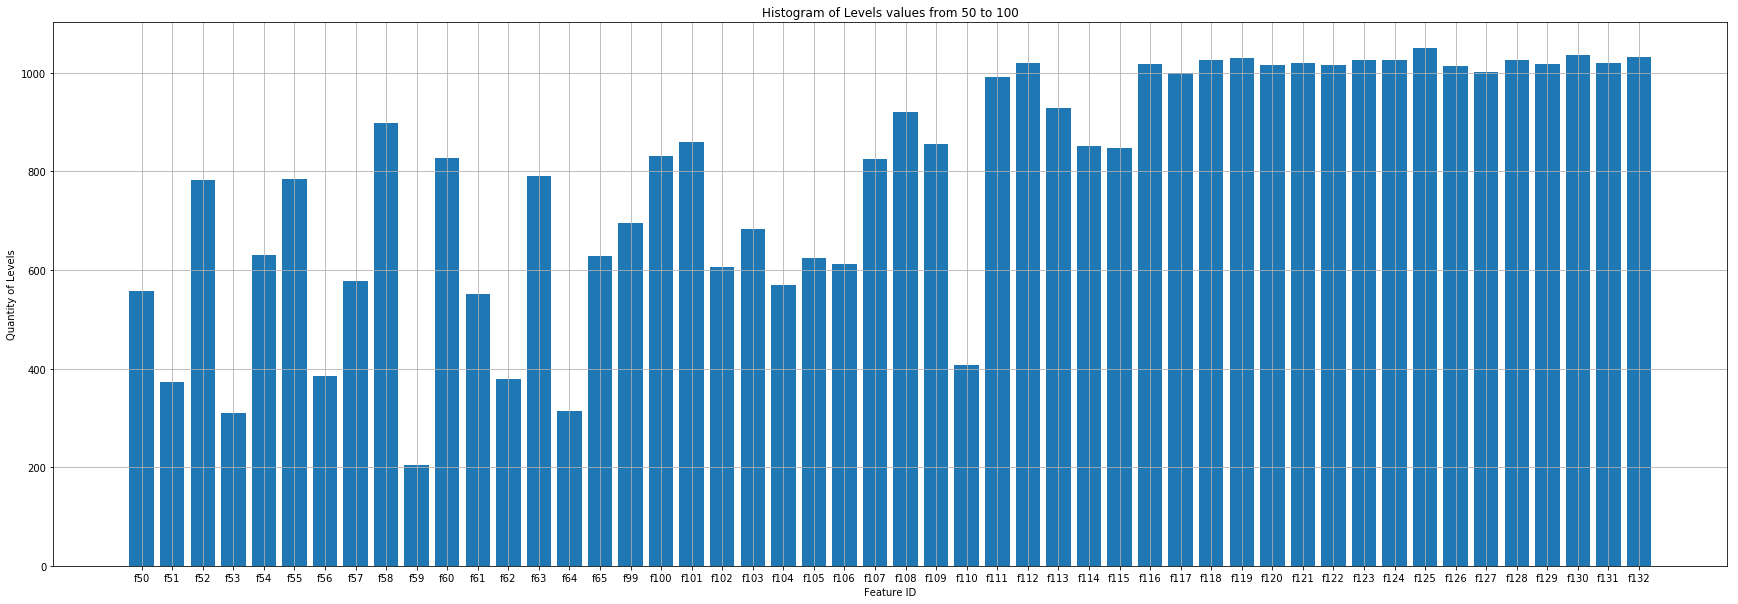

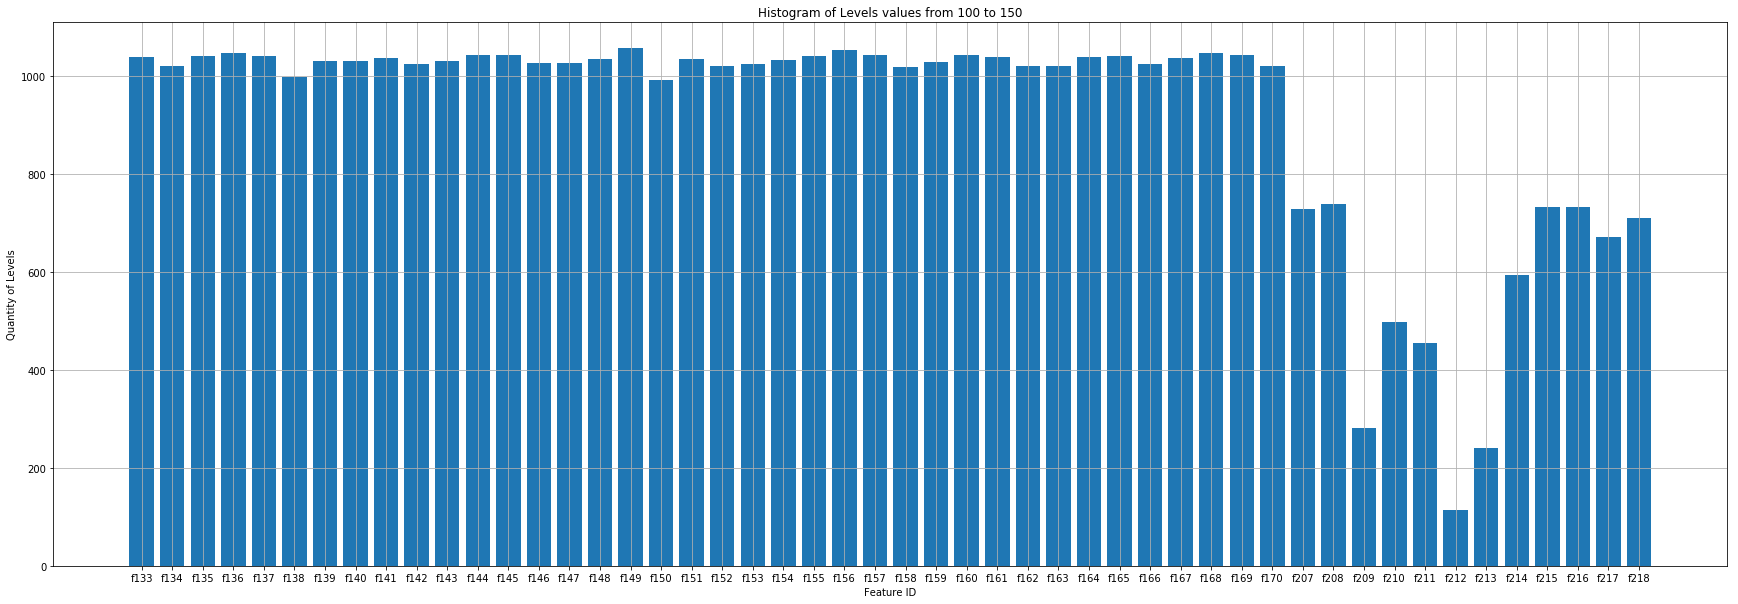

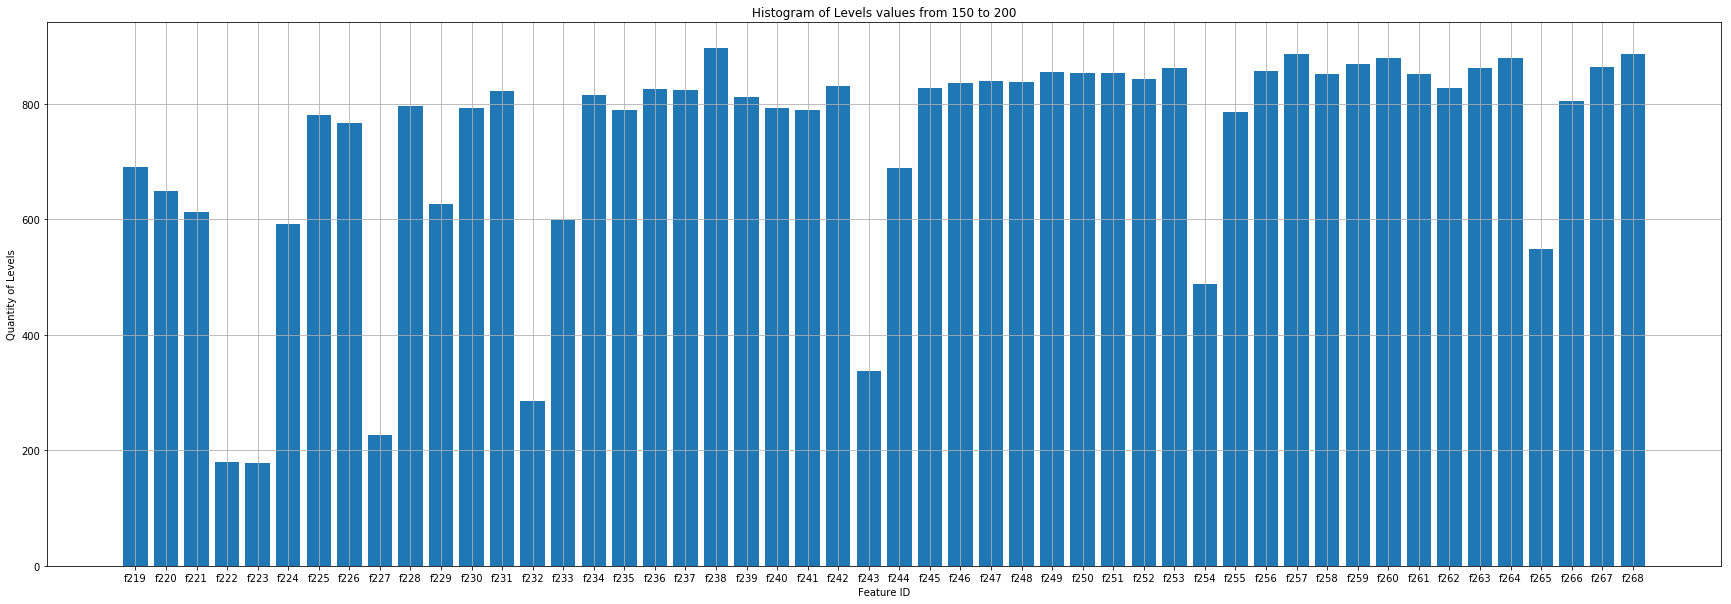

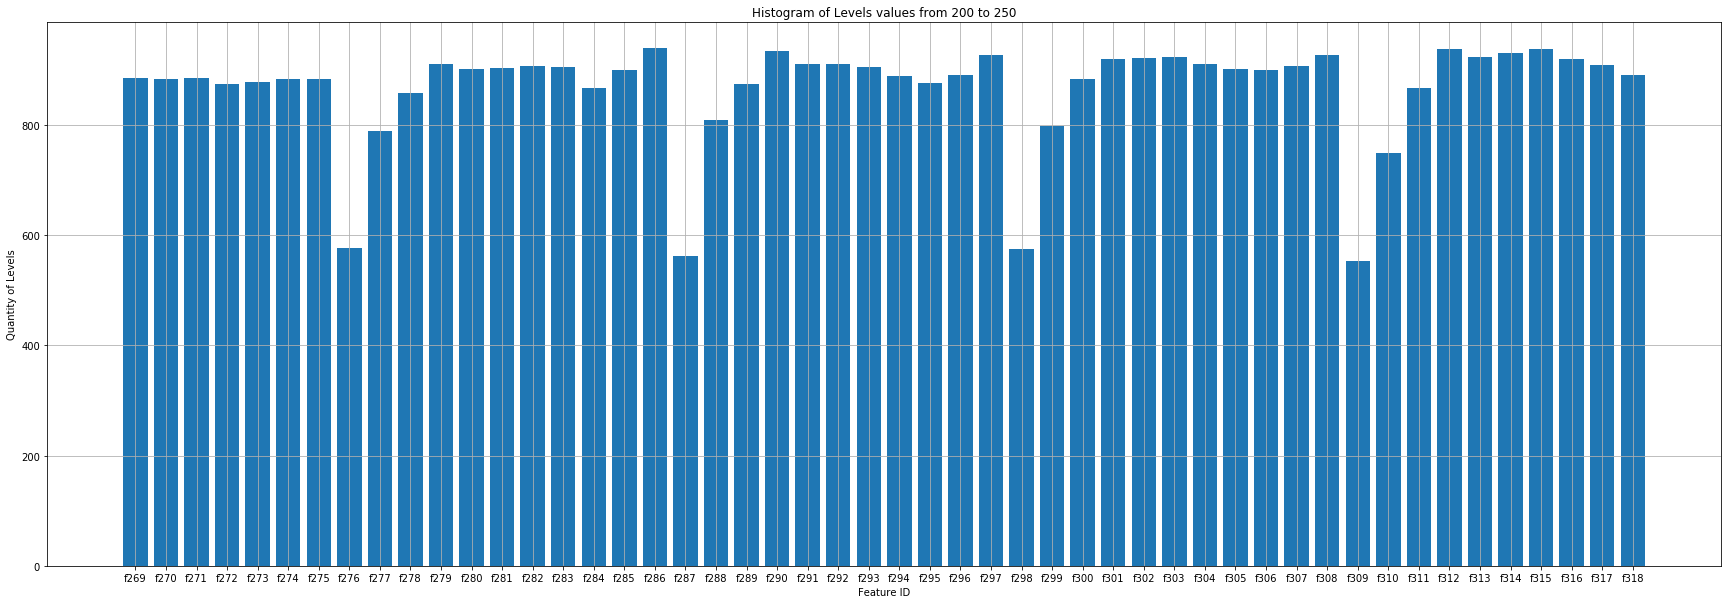

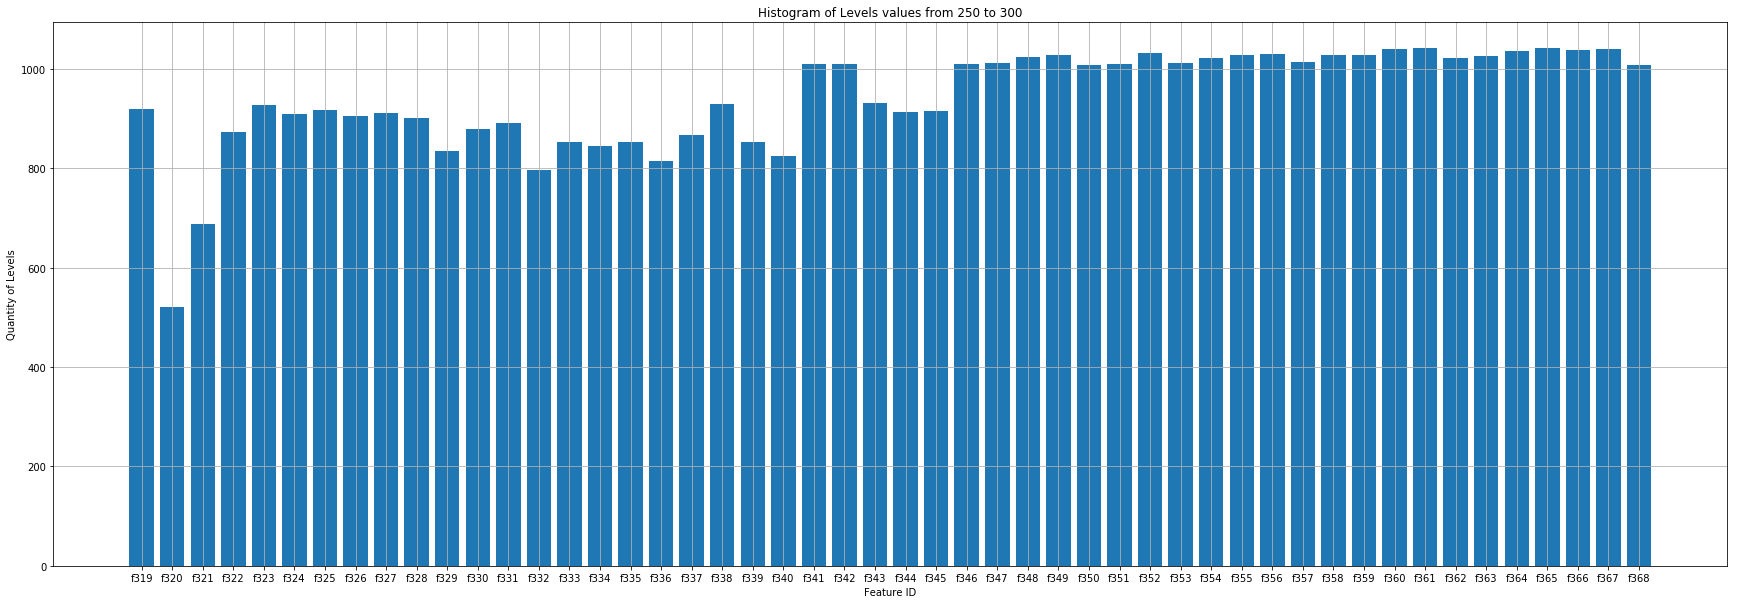

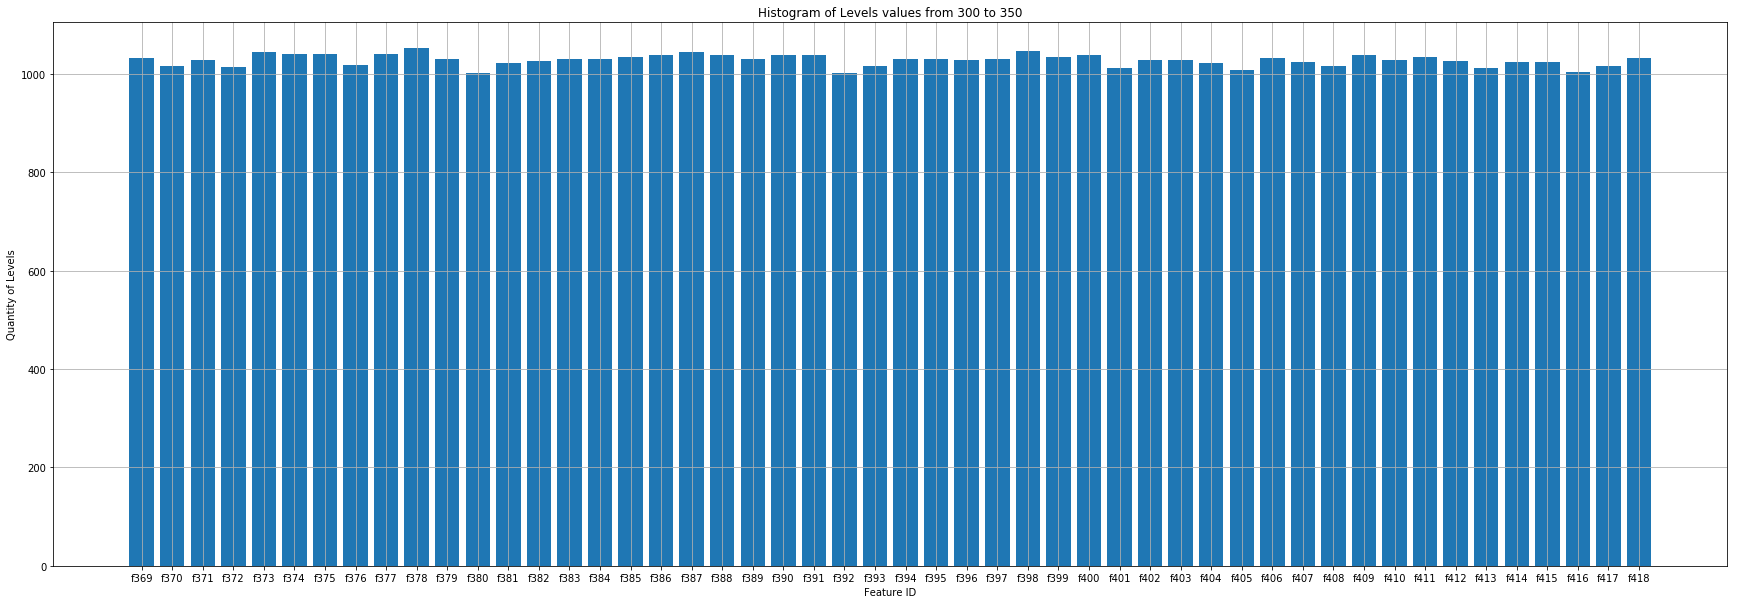

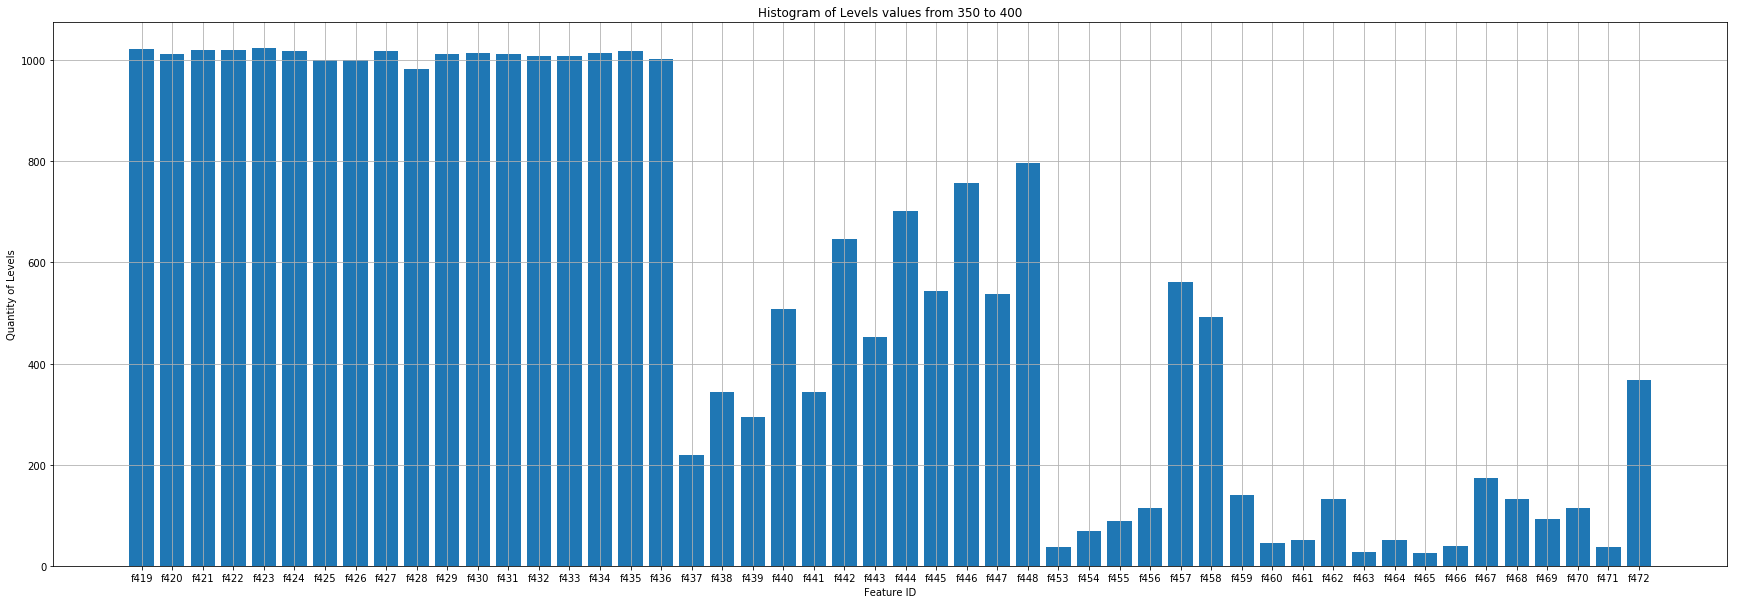

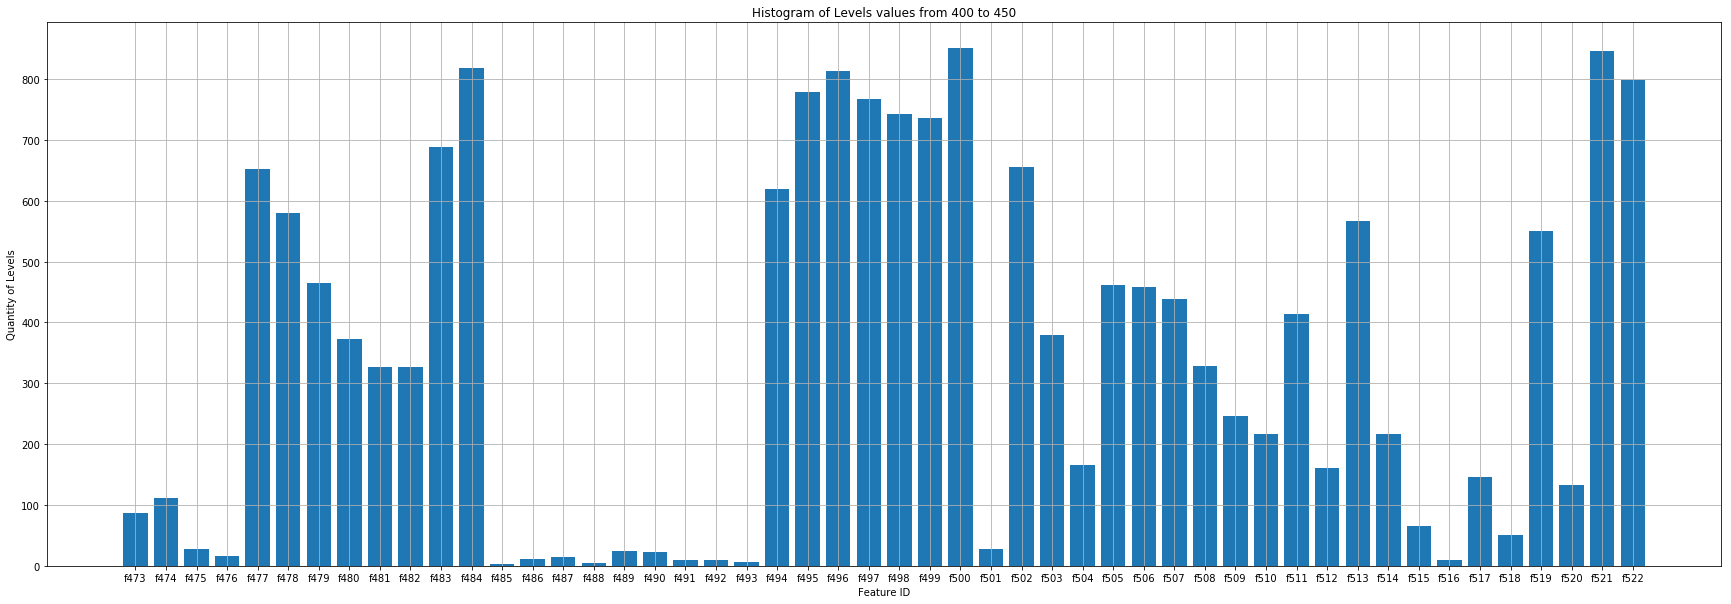

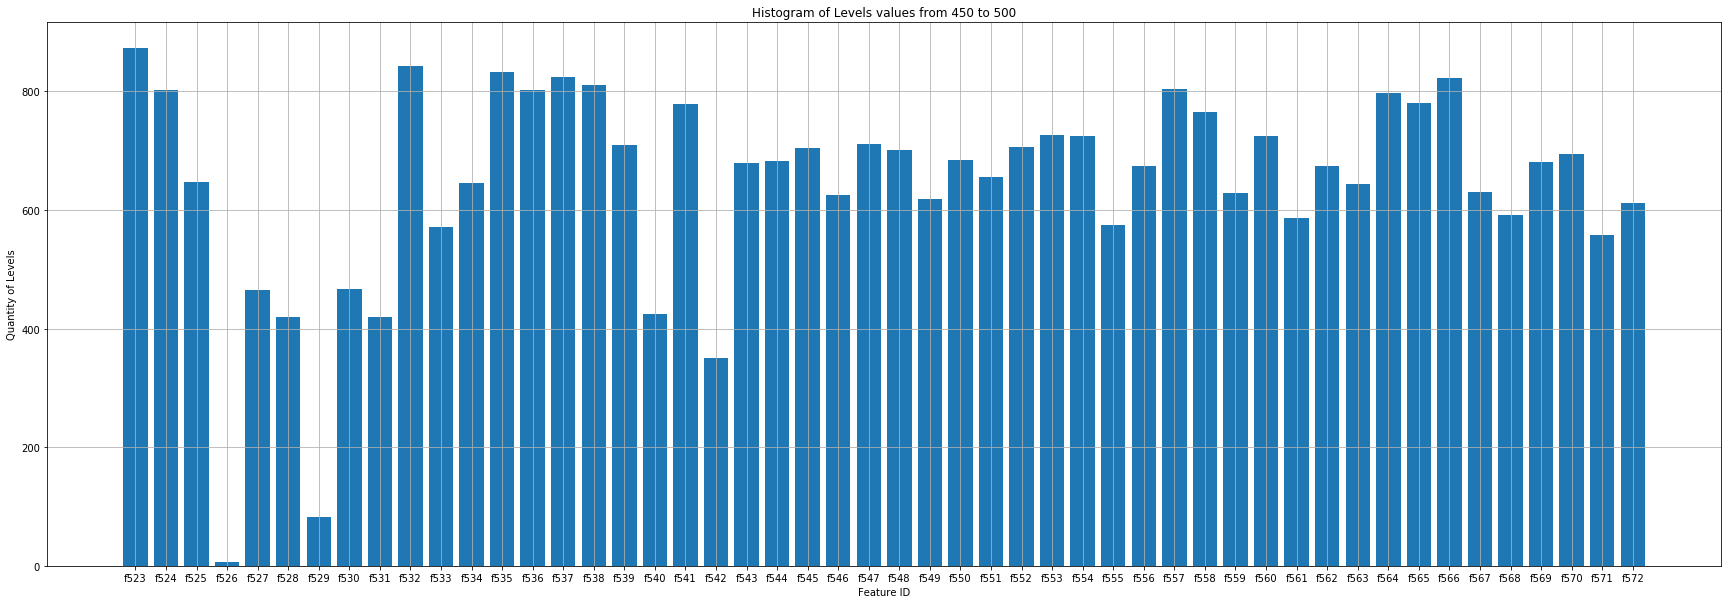

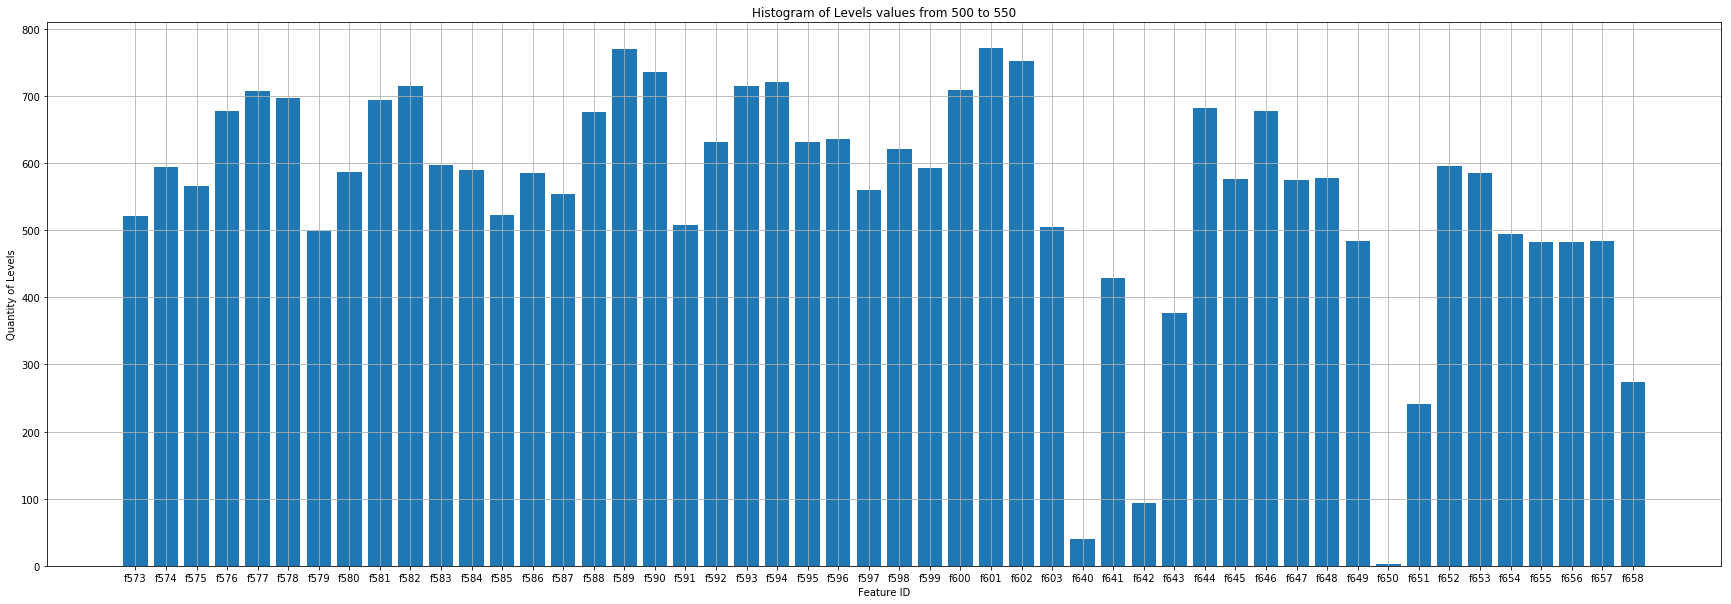

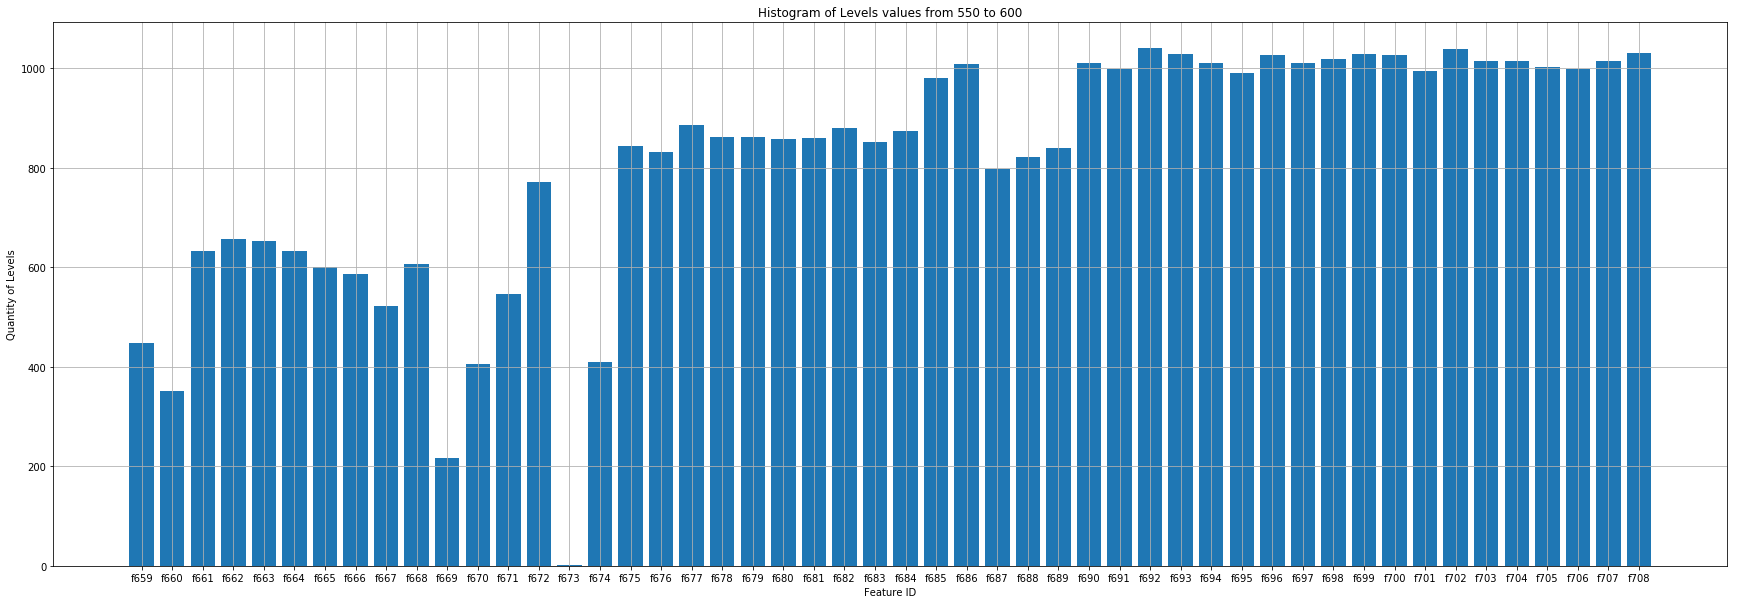

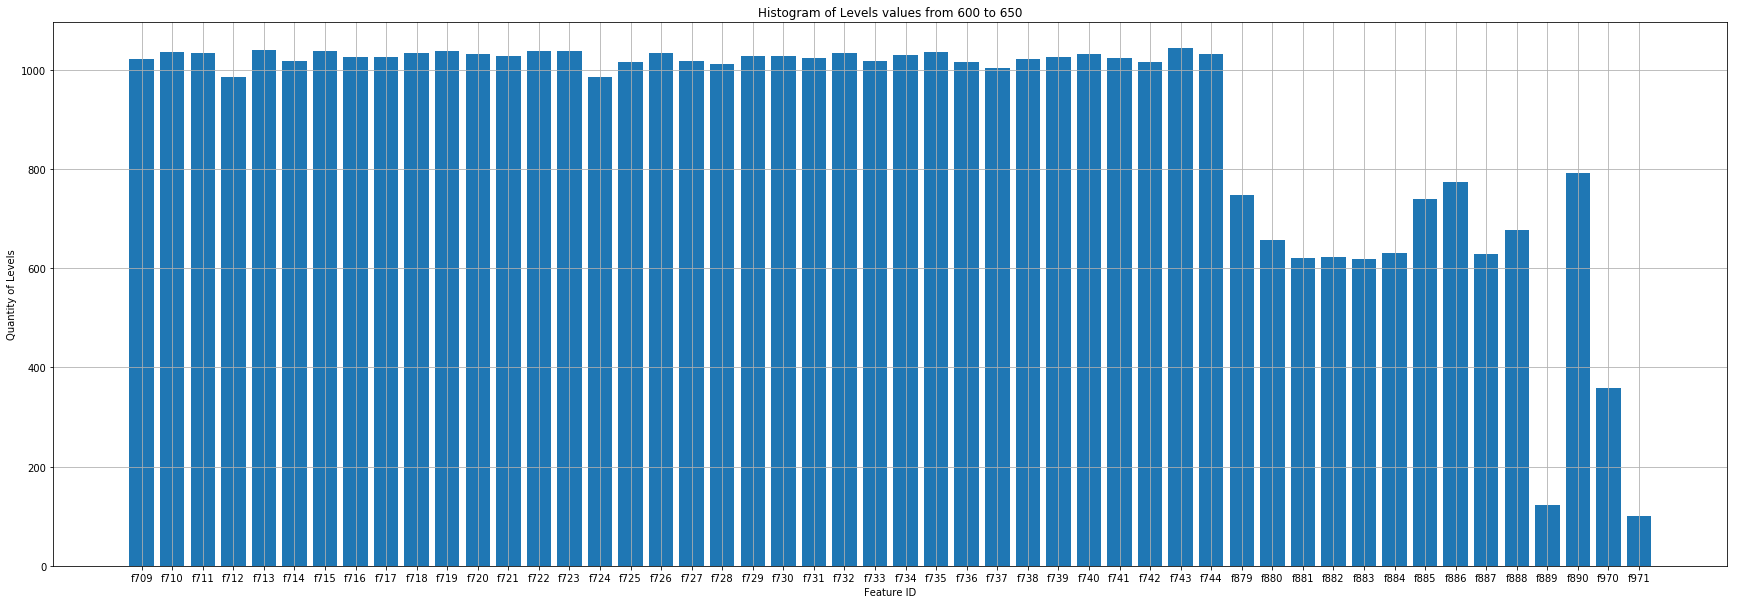

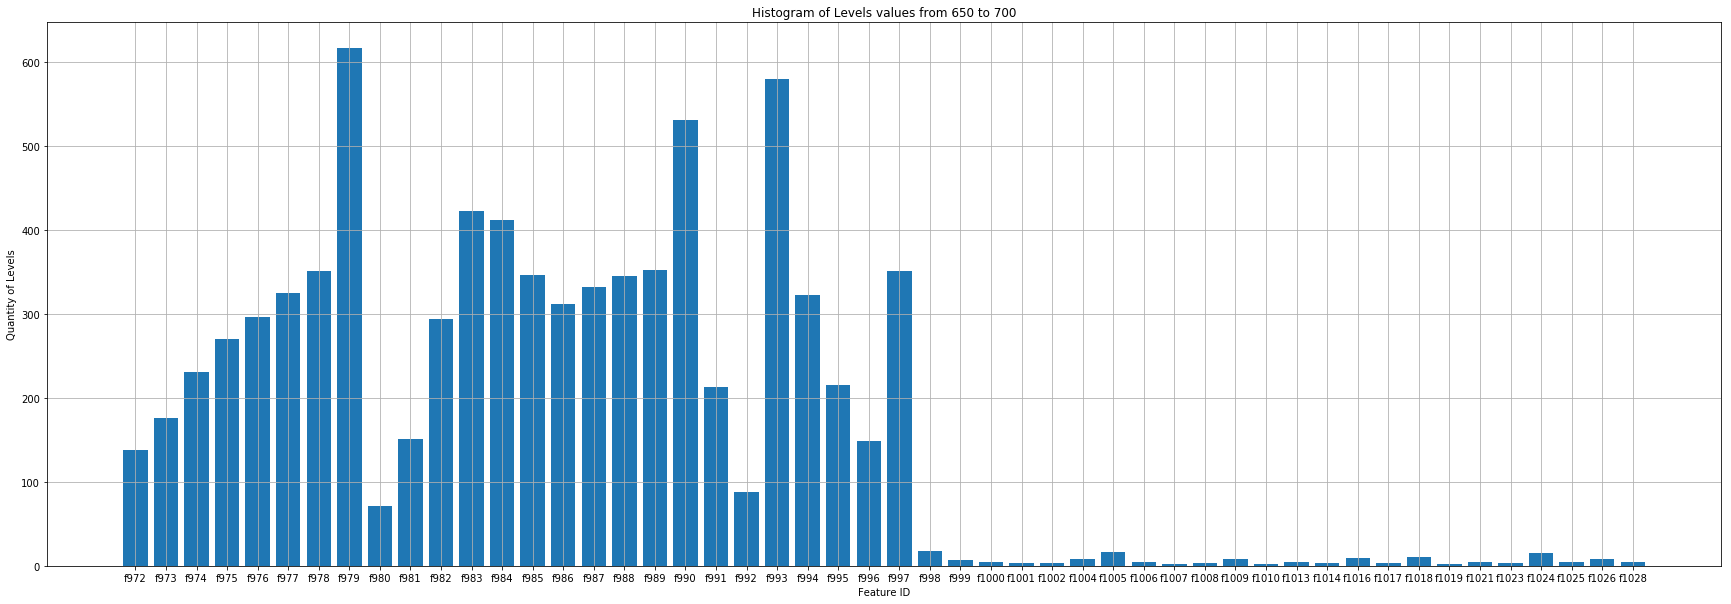

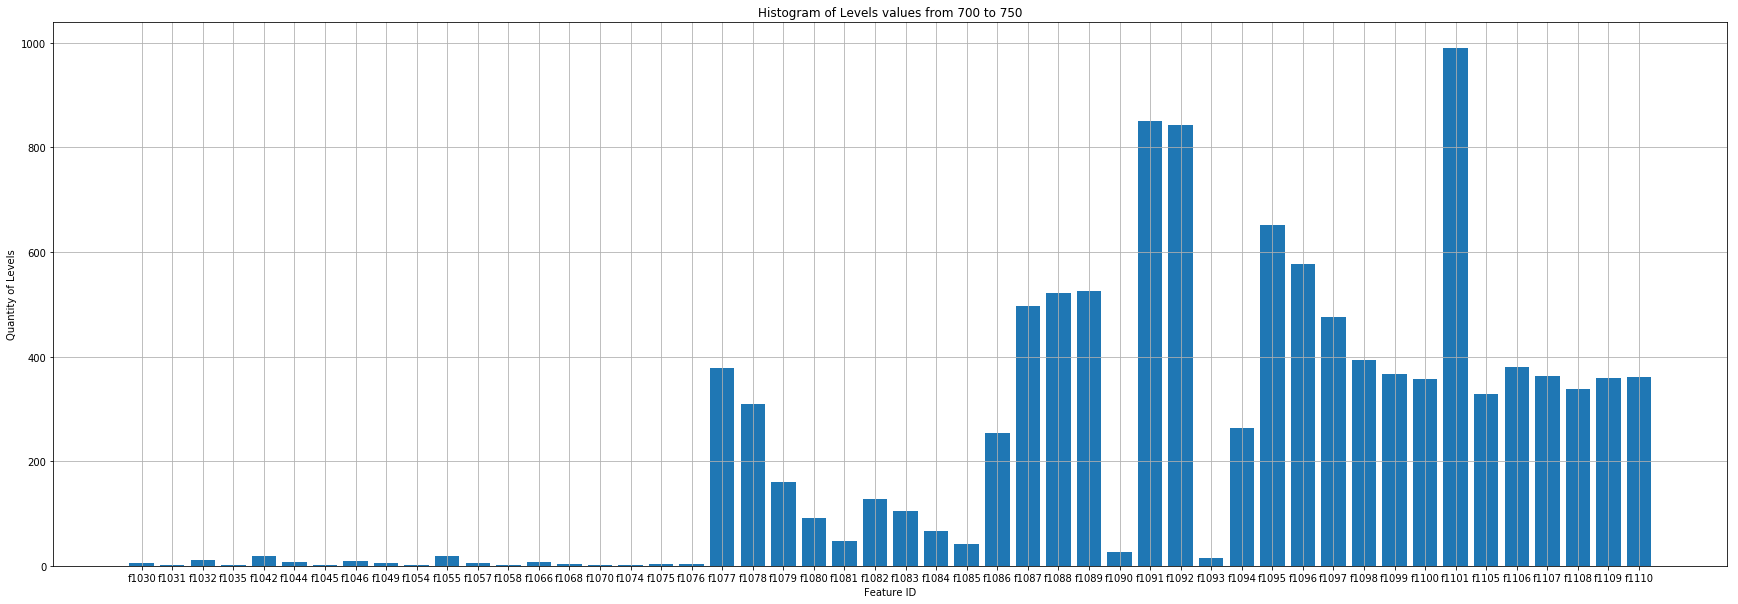

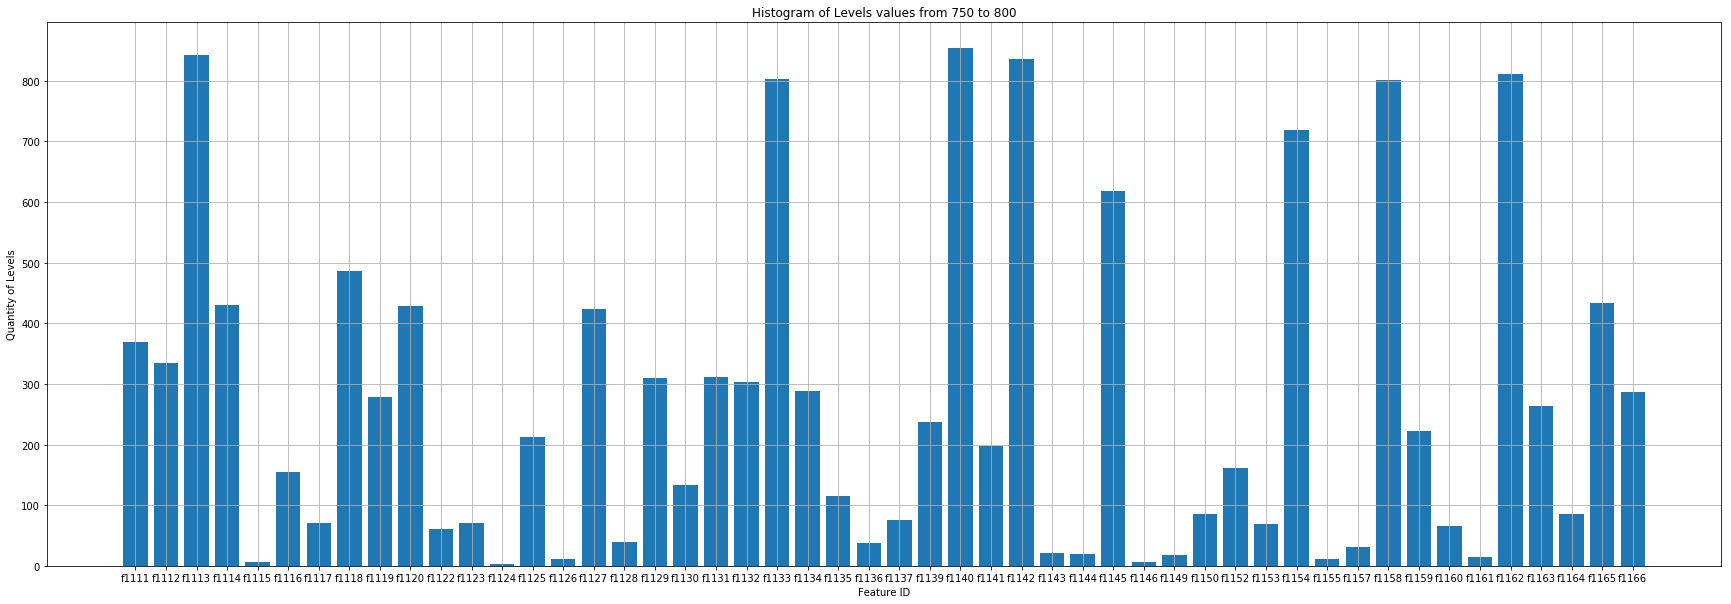

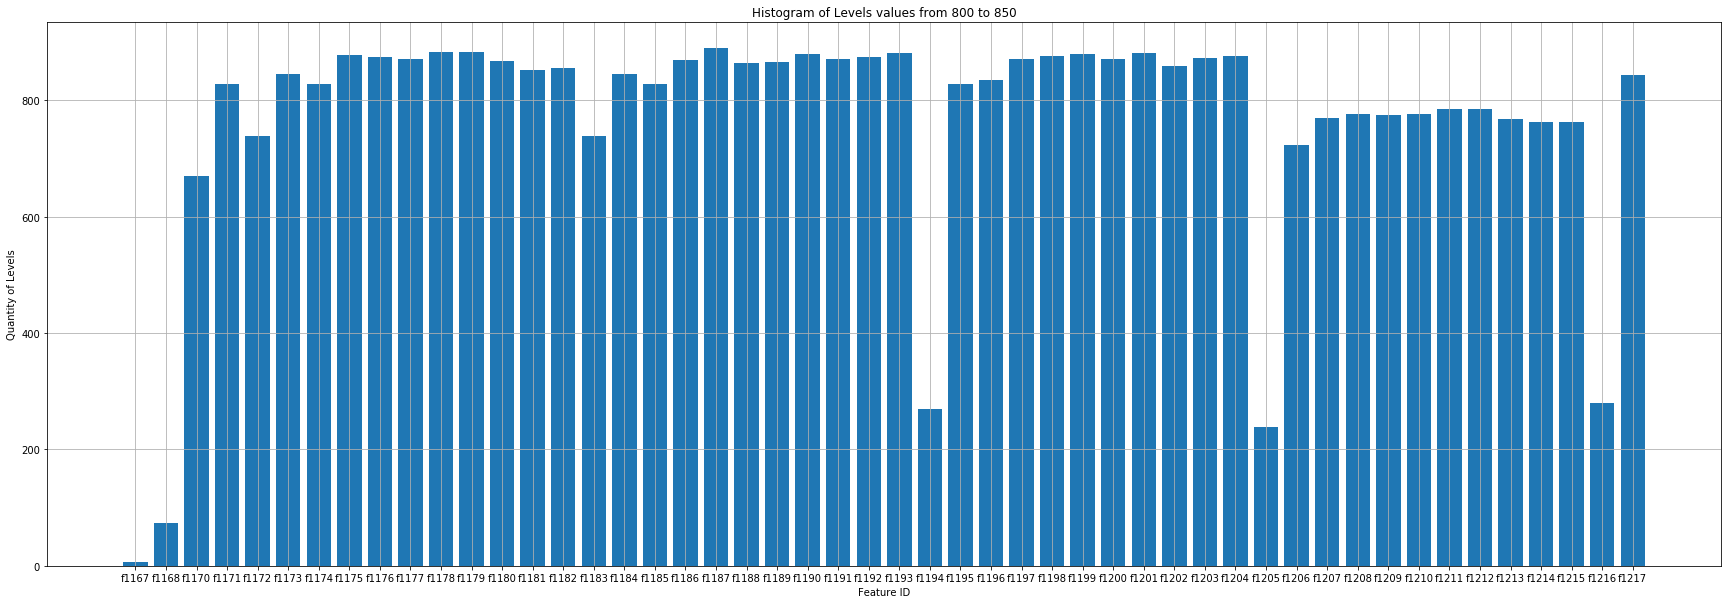

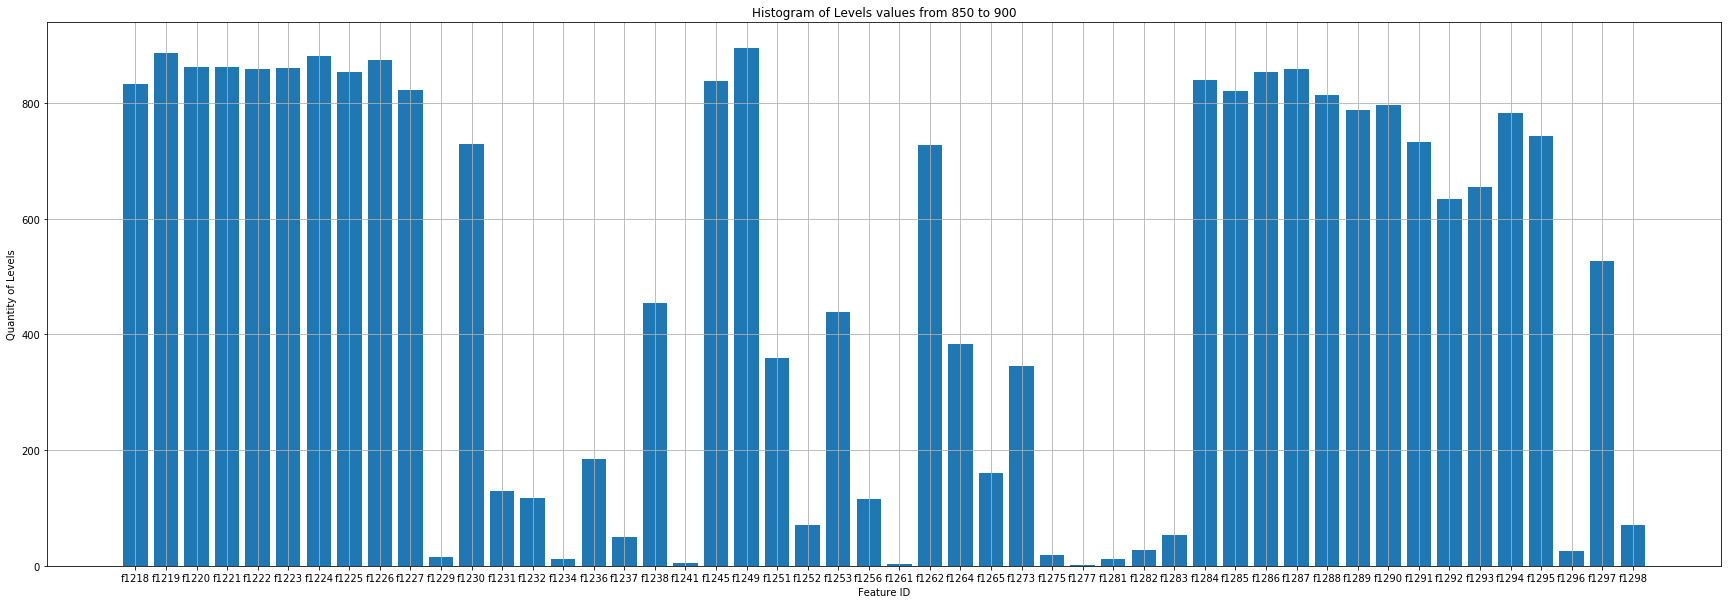

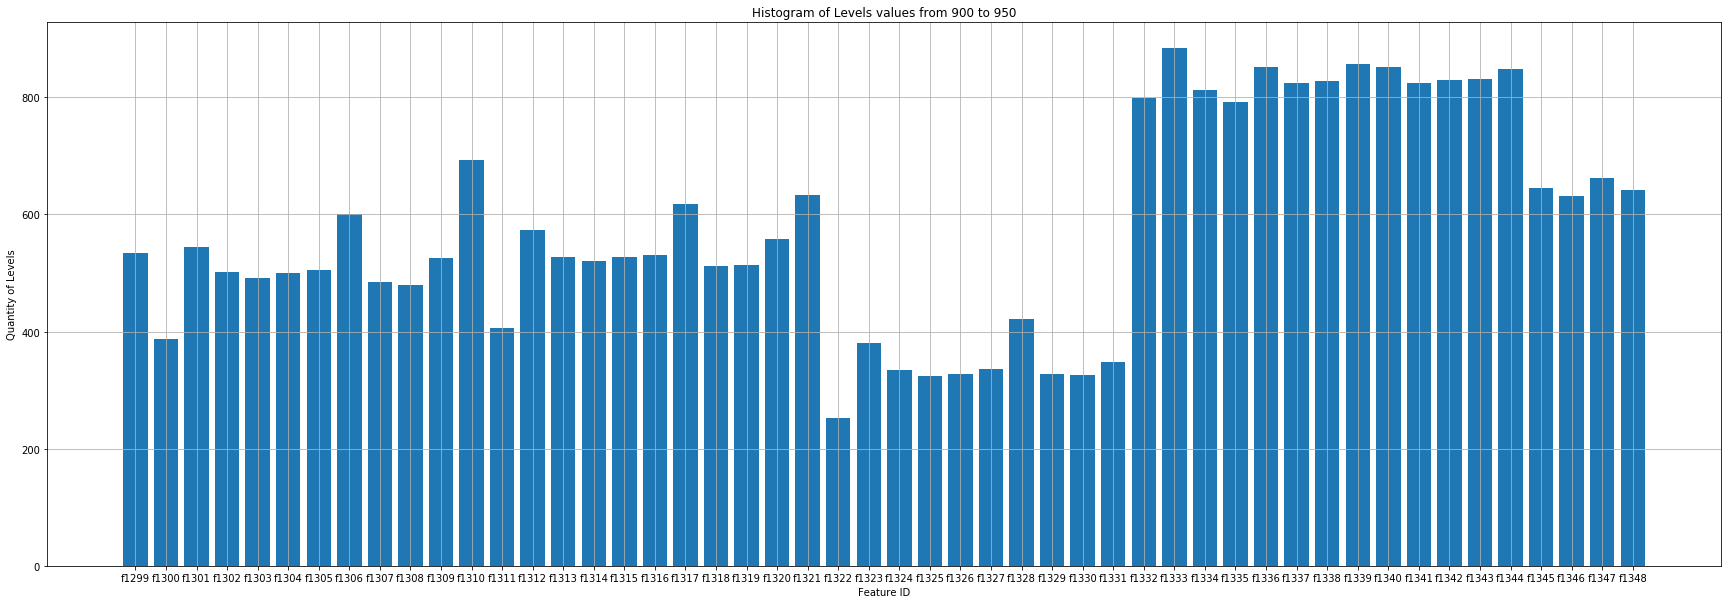

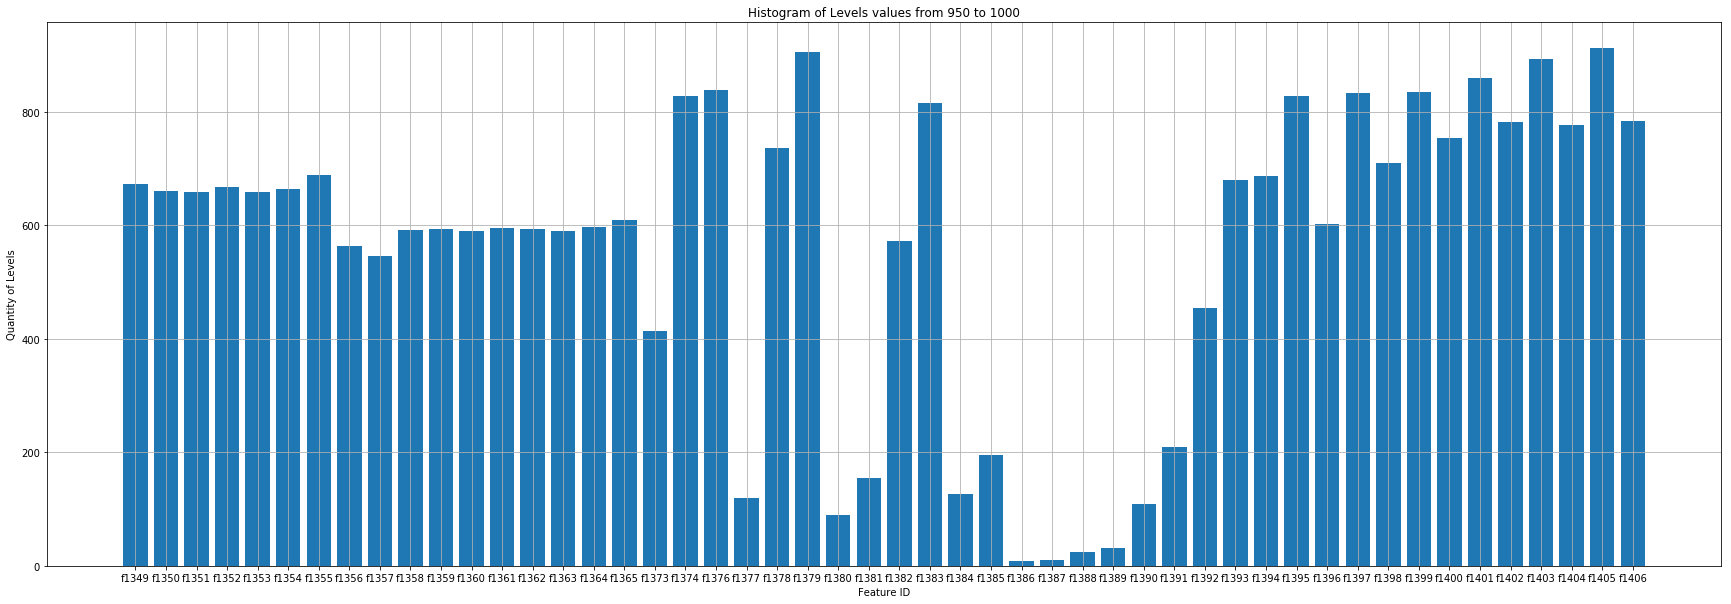

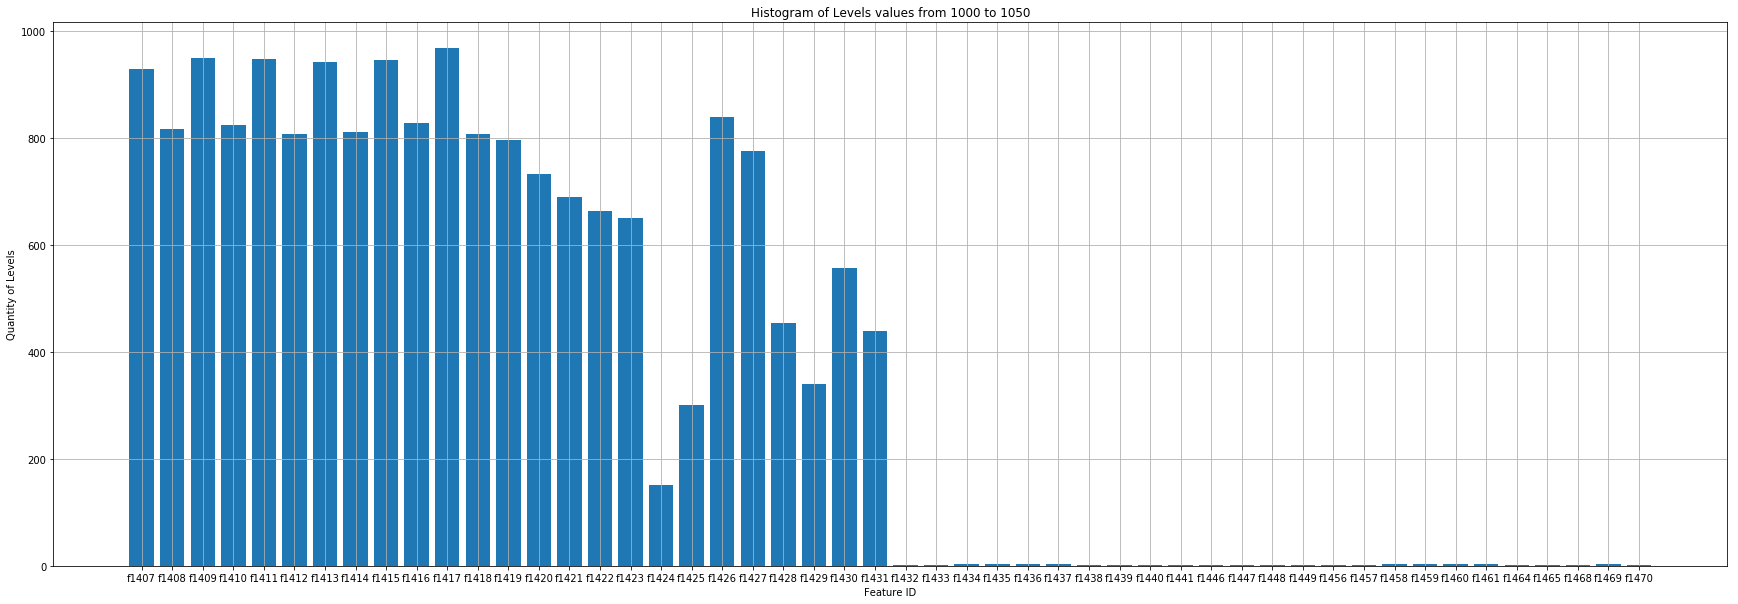

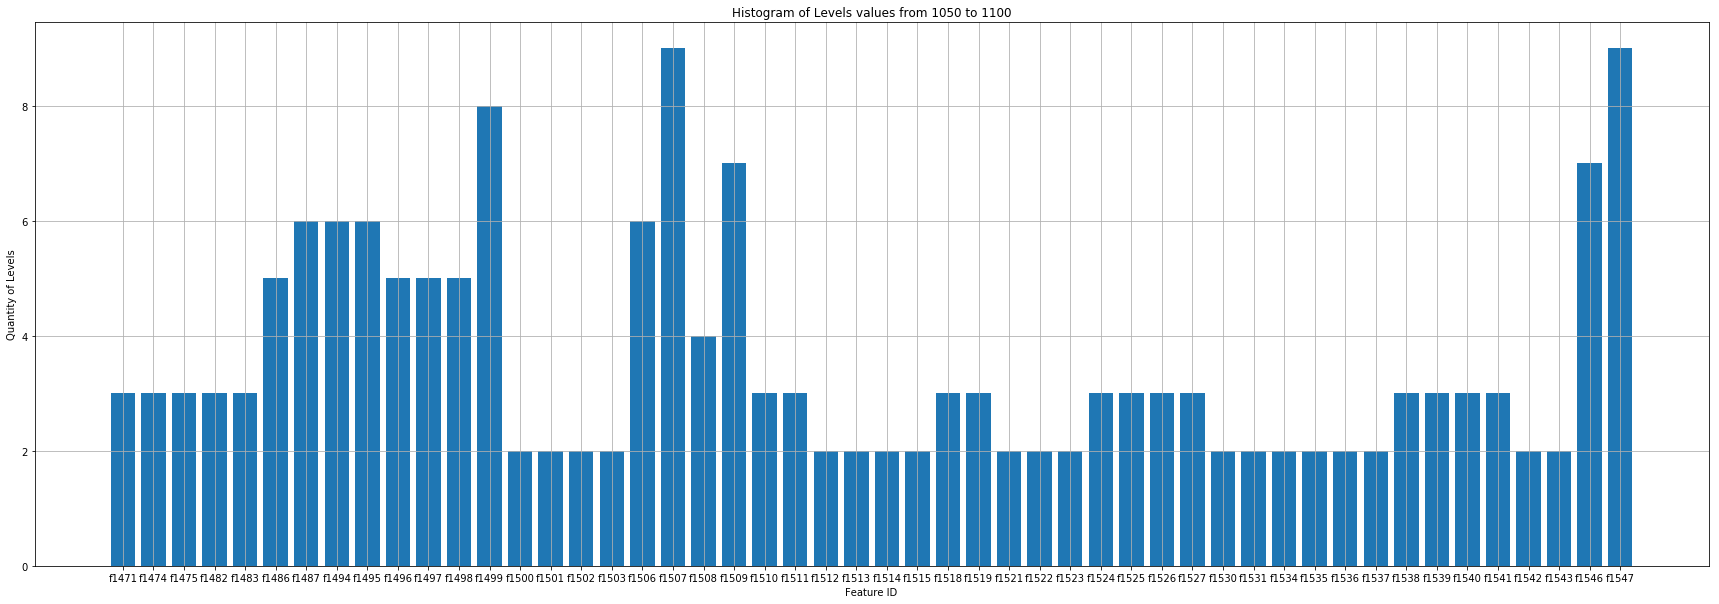

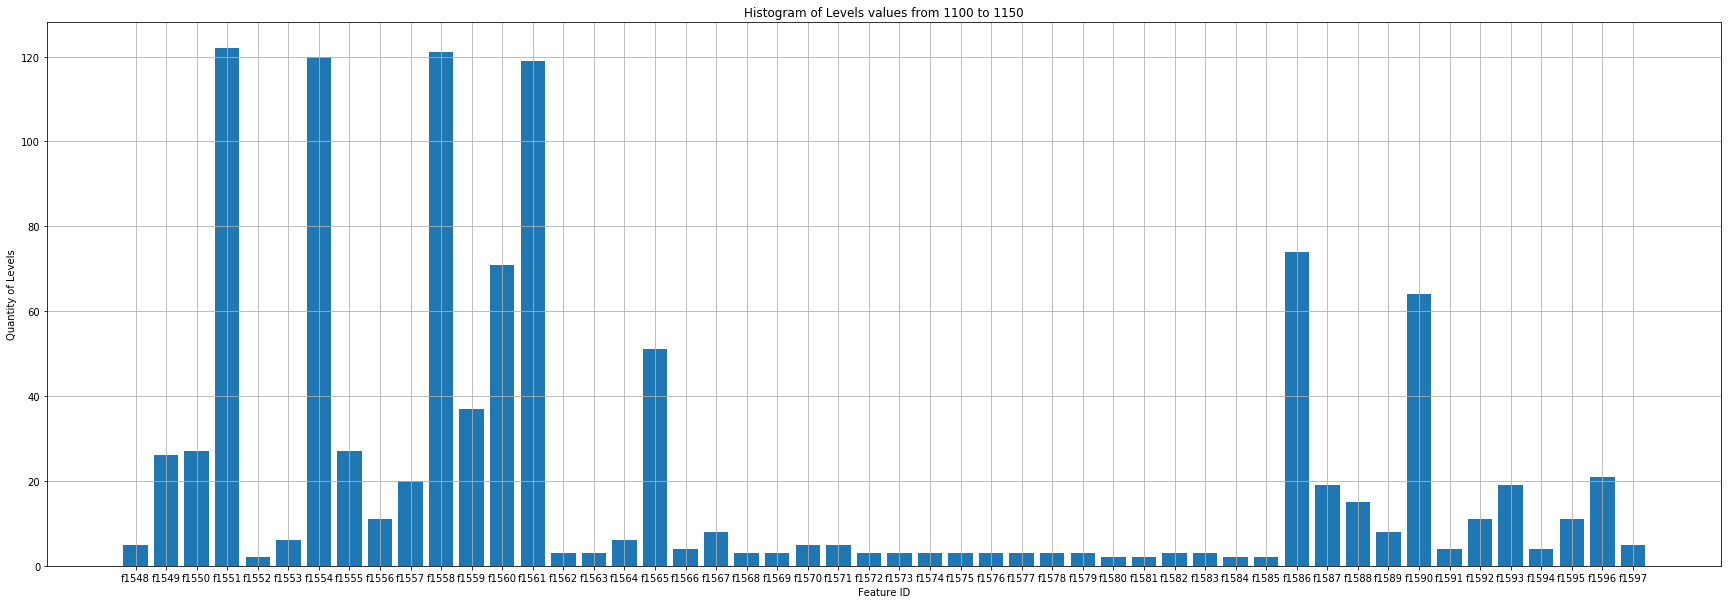

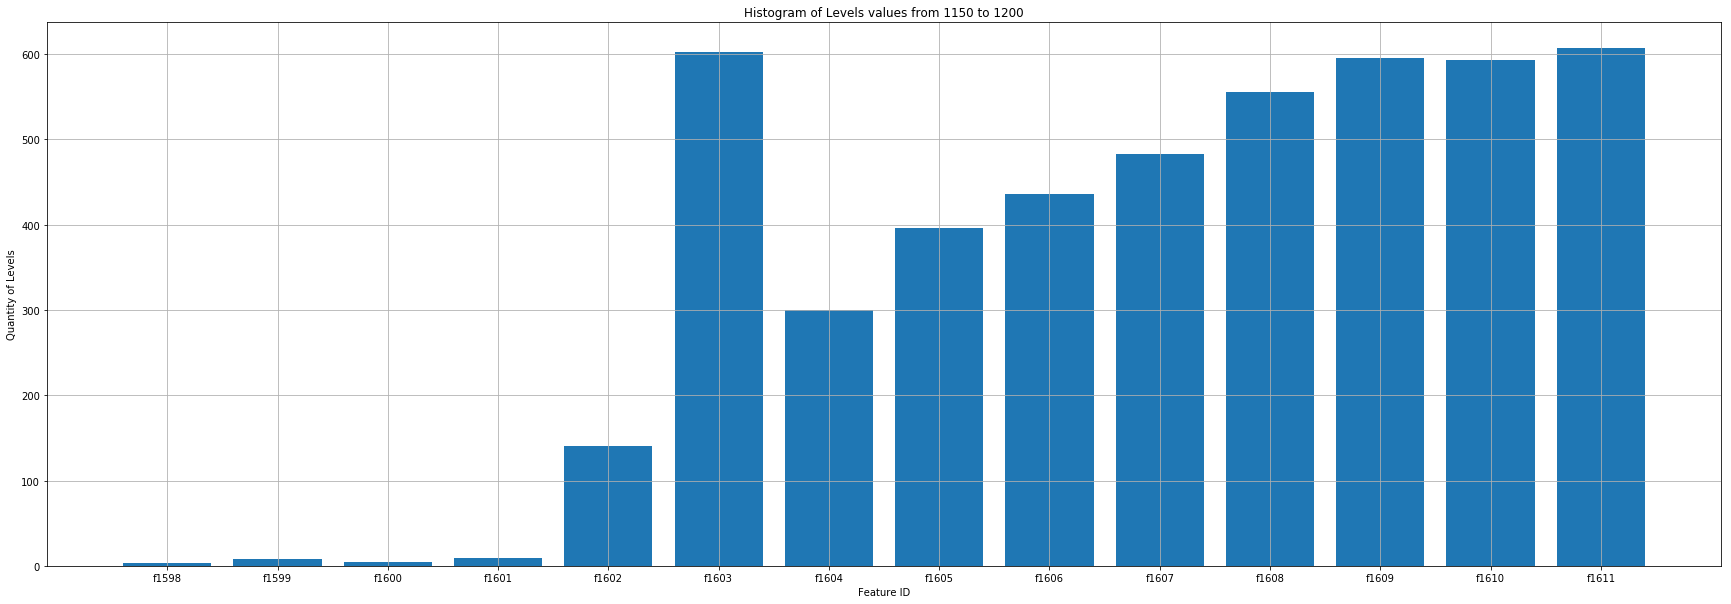

In [21]:
levels = level_calculating(train)

Будем считать категориальными те преликторы, у которых не больше 10 значений

In [22]:
categorical = list(levels[levels.values <= 10].keys())

Существует много техник для того, чтобы заполнить пропущенные данные. Классические - заполнить медианой или средним значением. Для категориальных предикторов можно заполнить наиболее часто встречаемыми значениями. 
Так как в данных много выбросов, то для заполнения количественных предикторов воспользуемся медианой. Для категориальных - наиболее встречаемыми.

In [23]:
from sklearn.impute import SimpleImputer
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = SimpleImputer(missing_values=np.nan, strategy='median')
features = train.drop(['y'], axis=1)
target = train['y']
features[categorical] = imp_cat.fit_transform(features[categorical])
test_samp[categorical] = imp_cat.transform(test_samp[categorical])
features = imp.fit_transform(features)
test_samp = imp.transform(test_samp)

Посмотрим, сможет ли PCA и t-SNE сформировать данные так, чтобы появились отдельные кластеры.

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [25]:
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(features)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=8000)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1095 samples in 0.055s...
[t-SNE] Computed neighbors for 1095 samples in 1.448s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1095
[t-SNE] Computed conditional probabilities for sample 1095 / 1095
[t-SNE] Mean sigma: 3574.930629
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.820610
[t-SNE] KL divergence after 5750 iterations: 0.606771


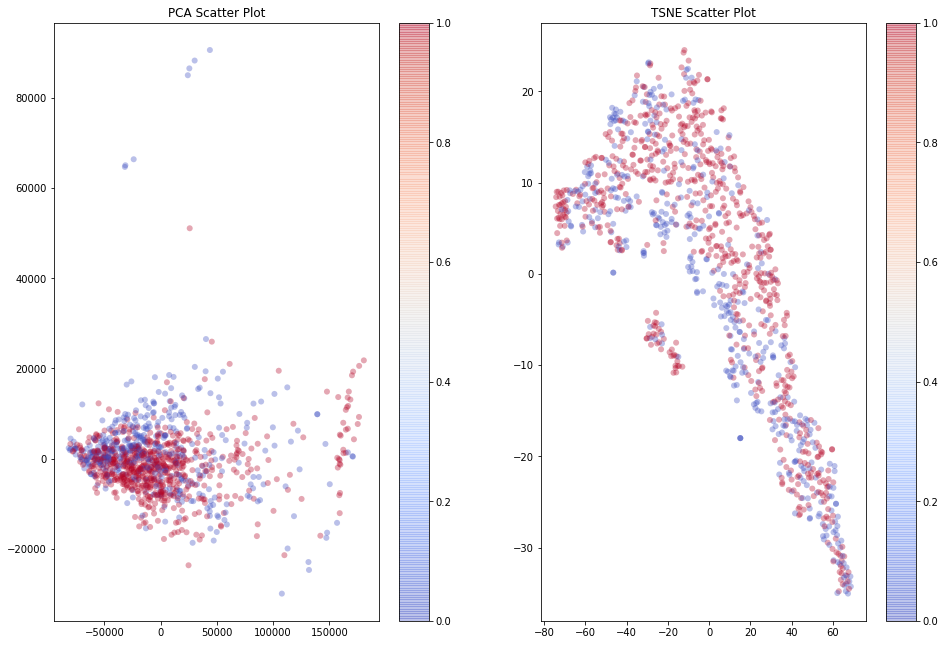

In [26]:
plt.figure(figsize = (16,11))
plt.subplot(121)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c = target, 
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('PCA Scatter Plot')
plt.subplot(122)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = target, 
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

Как видно из результатов 2D графиков, объекты, которые относятся к 1 и 0 не разделимы, но можно выделить зоны, где одних объектов больше, чем других.

In [27]:
from sklearn.preprocessing import StandardScaler
features_std = StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(features_std)

tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=15000)
tsne_results = tsne.fit_transform(features_std)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1095 samples in 0.048s...
[t-SNE] Computed neighbors for 1095 samples in 2.871s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1095
[t-SNE] Computed conditional probabilities for sample 1095 / 1095
[t-SNE] Mean sigma: 8.049062
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.471092
[t-SNE] KL divergence after 6450 iterations: 0.964189


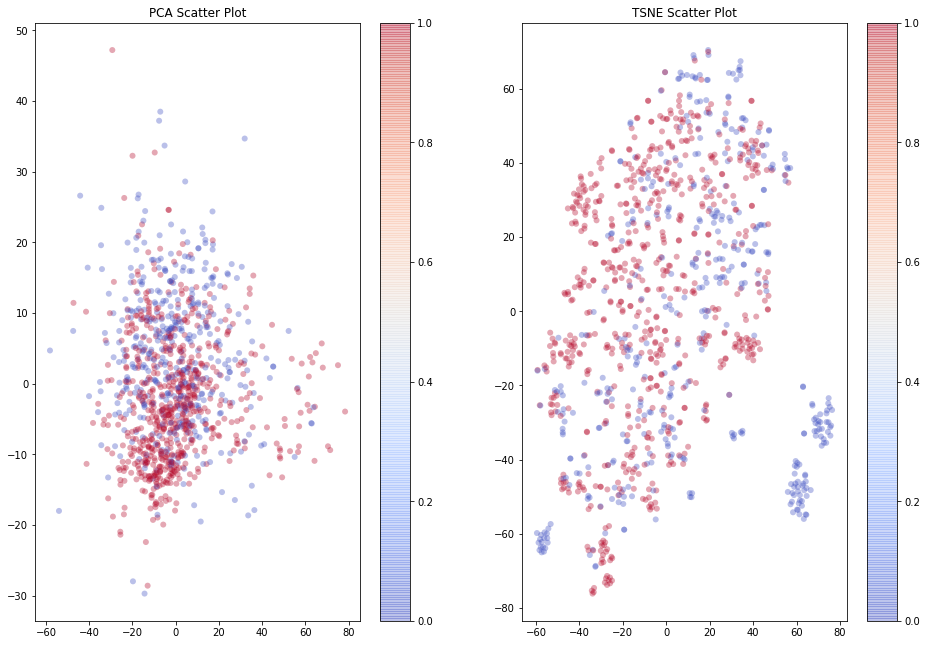

In [28]:
plt.figure(figsize = (16,11))
plt.subplot(121)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c = target, 
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('PCA Scatter Plot')
plt.subplot(122)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = target, 
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

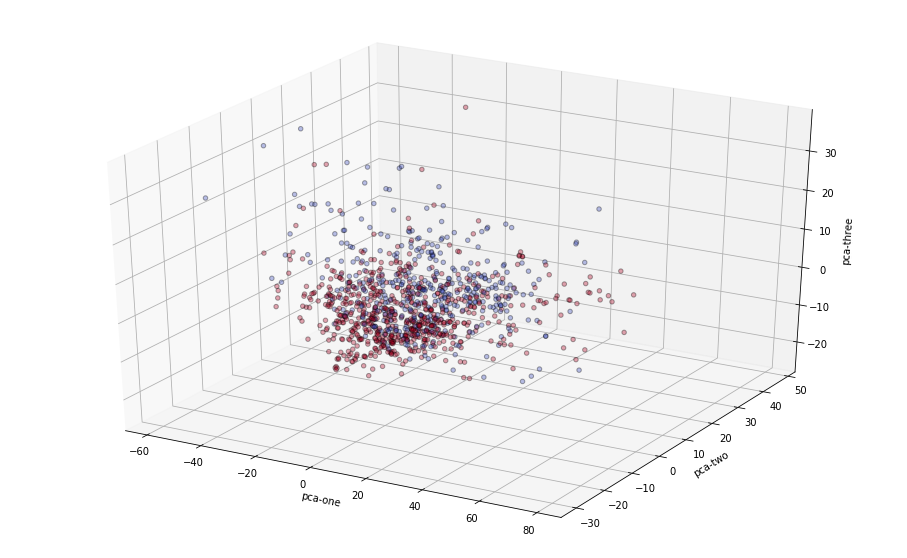

In [29]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_3d = pca.fit_transform(features_std)

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_3d[:,0], 
    ys=pca_3d[:,1], 
    zs=pca_3d[:,2], 
    c=target, 
    cmap = "coolwarm", 
    edgecolor = "None", 
    alpha=0.35
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 1095 samples in 0.033s...
[t-SNE] Computed neighbors for 1095 samples in 2.649s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1095
[t-SNE] Computed conditional probabilities for sample 1095 / 1095
[t-SNE] Mean sigma: 8.932217
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.379387
[t-SNE] KL divergence after 1200 iterations: 0.785892


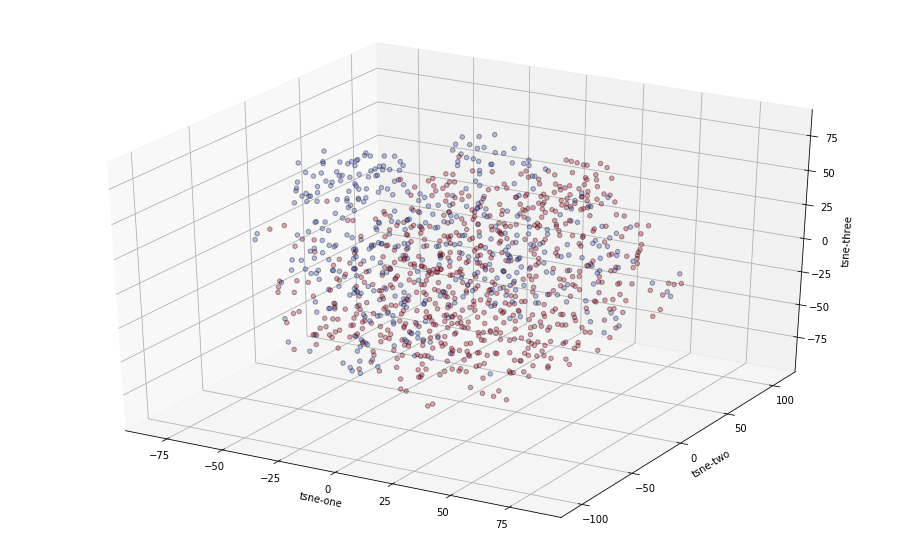

In [30]:
tsne = TSNE(n_components=3, verbose=1, perplexity=60, n_iter=8000)
tsne_3d = tsne.fit_transform(features_std)

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=tsne_3d[:,0], 
    ys=tsne_3d[:,1], 
    zs=tsne_3d[:,2], 
    c=target, 
    cmap = "coolwarm", 
    edgecolor = "None", 
    alpha=0.35
)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_zlabel('tsne-three')
plt.show()

На 3D графиках так же нельзя выделить зоны, где находятся только объекты типа 1 или 0. 

Разобьем данные на тестовую и тренировочную выборки, а так же будем использовать кросс валидацию по 3-Fold'ам

In [31]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(features, target,stratify=target, test_size=0.33, random_state=42)
kf = KFold(n_splits=3, shuffle=True)

## Модели для классификации

### Линейные модели

In [32]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [33]:
scaler =  StandardScaler()
train_X_std = scaler.fit_transform(train_X)
test_X_std = scaler.transform(test_X)
test_samp_std = scaler.transform(test_samp)

In [34]:
logreg = LogisticRegressionCV(cv = kf, scoring='roc_auc', class_weight = 'balacned', penalty='l2')
parameters_logreg = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
             'max_iter': [200, 400, 600, 800, 1000]}
gs = GridSearchCV(logreg, param_grid = parameters_logreg, scoring='roc_auc', cv=kf)
gs.fit(train_X_std, train_y)

/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.


/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached w

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegressionCV(Cs=10, class_weight='balacned',
           cv=KFold(n_splits=3, random_state=None, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'], 'max_iter': [200, 400, 600, 800, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [35]:
print(f'ЛУчший результат на обучении {gs.best_score_}')
print(f'Параметры, на которых модель достигла лучшего результата: {gs.best_params_}')

ЛУчший результат на обучении 0.8302908640715398
Параметры, на которых модель достигла лучшего результата: {'max_iter': 200, 'solver': 'lbfgs'}


In [36]:
from sklearn.metrics import roc_auc_score
logreg = gs.best_estimator_
pred = logreg.predict_proba(test_X_std)[:, 1]
print(f'ROC AUC на тесте {roc_auc_score(test_y, pred)}')

ROC AUC на тесте 0.8698198198198198


In [37]:
def submission(model, test, samp, name):
    pred_proba = model.predict_proba(test)
    result = pd.DataFrame({'sample_id': samp['sample_id'], 'y': pred_proba[:, 1]})
    result.to_csv(f'{name}.csv', index=False)

In [38]:
submission(logreg, test_samp_std, test, 'LogReg2')

Kaggle submission - 0.87047

### Нелинейные модели

#### Применение ансамблей моделей

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

#### Случайные деревья

In [40]:
rt_clf = RandomForestClassifier(verbose= 0)
parameters = {'criterion': ['entropy'], 
              'n_estimators' : [200, 300, 500, 1000, 1200, 1400, 1500, 2000], 
              'max_depth': [5, 10, 20, 40, 50, 80, 100, 120], 
              'min_samples_split': [2, 4, 8, 10],
              'min_samples_leaf': [2, 4, 8, 10],
              'class_weight': ['balanced'],
              'min_impurity_decrease': [0, 1e-6, 1e-4, 1e-2],
              'bootstrap': [False, True]}
#gs = GridSearchCV(rt_clf, param_grid = parameters, scoring='roc_auc', cv=kf)
rs = RandomizedSearchCV(rt_clf,n_iter=100, param_distributions = parameters, scoring='roc_auc', cv=kf, verbose=2)
rs.fit(train_X, train_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=True, total=   7.1s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=True, total=   6.7s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=True, total=   6.6s
[CV] n_estimators=500, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=40, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=500, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=40, criterion=entropy, class_weight=balanced, bootstrap=True, total=   2.8s
[CV] n_estimators=500, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=40, criterion=entr

[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0, max_depth=120, criterion=entropy, class_weight=balanced, bootstrap=False, total=  15.0s
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0, max_depth=120, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0, max_depth=120, criterion=entropy, class_weight=balanced, bootstrap=False, total=  14.5s
[CV] n_estimators=200, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=True, total=   1.1s
[CV] n_estimators=200, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=20, criterion=entropy, clas

[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=True, total=   5.6s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=True, total=   5.5s
[CV] n_estimators=1400, min_samples_split=4, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=120, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=4, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=120, criterion=entropy, class_weight=balanced, bootstrap=False, total=  18.8s
[CV] n_estimators=1400, min_samples_split=4, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=120, criterion

[CV]  n_estimators=1400, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=True, total=  11.3s
[CV] n_estimators=1400, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=True, total=   9.9s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=120, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=120, criterion=entropy, class_weight=balanced, bootstrap=True, total=   4.1s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=120, criterion=e

[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0.0001, max_depth=40, criterion=entropy, class_weight=balanced, bootstrap=False, total=   2.0s
[CV] n_estimators=200, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0.0001, max_depth=40, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0.0001, max_depth=40, criterion=entropy, class_weight=balanced, bootstrap=False, total=   1.9s
[CV] n_estimators=1000, min_samples_split=4, min_samples_leaf=10, min_impurity_decrease=0.0001, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=4, min_samples_leaf=10, min_impurity_decrease=0.0001, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=True, total=   5.6s
[CV] n_estimators=1000, min_samples_split=4, min_samples_leaf=10, min_impurity_decrease=0.0001, max_depth=20, crite

[CV]  n_estimators=1500, min_samples_split=4, min_samples_leaf=2, min_impurity_decrease=0.01, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=False, total=  18.9s
[CV] n_estimators=1500, min_samples_split=4, min_samples_leaf=2, min_impurity_decrease=0.01, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=1500, min_samples_split=4, min_samples_leaf=2, min_impurity_decrease=0.01, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=False, total=  18.4s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=10, min_impurity_decrease=0, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=10, min_impurity_decrease=0, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=False, total=   4.9s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=10, min_impurity_decrease=0, max_depth=10, criterion=entropy, class_we

[CV]  n_estimators=1000, min_samples_split=4, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=True, total=   7.2s
[CV] n_estimators=1000, min_samples_split=4, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=4, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=True, total=   7.0s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=True, total=   4.0s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=80, criterion=entr

[CV]  n_estimators=1200, min_samples_split=8, min_samples_leaf=8, min_impurity_decrease=1e-06, max_depth=5, criterion=entropy, class_weight=balanced, bootstrap=False, total=  10.2s
[CV] n_estimators=1200, min_samples_split=8, min_samples_leaf=8, min_impurity_decrease=1e-06, max_depth=5, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=8, min_samples_leaf=8, min_impurity_decrease=1e-06, max_depth=5, criterion=entropy, class_weight=balanced, bootstrap=False, total=  10.2s
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=2, min_impurity_decrease=0.01, max_depth=50, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=2, min_impurity_decrease=0.01, max_depth=50, criterion=entropy, class_weight=balanced, bootstrap=False, total=  17.5s
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=2, min_impurity_decrease=0.01, max_depth=50, criterion=entro

[CV]  n_estimators=2000, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=1e-06, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=False, total=  24.4s
[CV] n_estimators=2000, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=1e-06, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=1e-06, max_depth=10, criterion=entropy, class_weight=balanced, bootstrap=False, total=  23.8s
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=0, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=0, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=True, total=   7.9s
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=0, max_depth=20, criterion=entropy, c

[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=1e-06, max_depth=40, criterion=entropy, class_weight=balanced, bootstrap=True, total=   1.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=1e-06, max_depth=40, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=1e-06, max_depth=40, criterion=entropy, class_weight=balanced, bootstrap=True, total=   1.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=100, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=100, criterion=entropy, class_weight=balanced, bootstrap=False, total=  10.5s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=100, criterion

[CV]  n_estimators=1500, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=0, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=False, total=  15.0s
[CV] n_estimators=1500, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=0, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=1500, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=0, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=False, total=  14.6s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0, max_depth=50, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0, max_depth=50, criterion=entropy, class_weight=balanced, bootstrap=False, total=  21.1s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0, max_depth=50, criterion=entropy, class_we

[CV]  n_estimators=2000, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=1e-06, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=True, total=  14.4s
[CV] n_estimators=2000, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=1e-06, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=1e-06, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=True, total=  14.1s
[CV] n_estimators=1500, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=1500, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=80, criterion=entropy, class_weight=balanced, bootstrap=False, total=  18.4s
[CV] n_estimators=1500, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=80, criterion=en

[CV]  n_estimators=2000, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=False, total=  19.8s
[CV] n_estimators=2000, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=0, max_depth=20, criterion=entropy, class_weight=balanced, bootstrap=False, total=  19.6s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=100, criterion=entropy, class_weight=balanced, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=100, criterion=entropy, class_weight=balanced, bootstrap=True, total=   5.6s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=100, criterion=entropy

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 51.6min finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'criterion': ['entropy'], 'n_estimators': [200, 300, 500, 1000, 1200, 1400, 1500, 2000], 'max_depth': [5, 10, 20, 40, 50, 80, 100, 120], 'min_samples_split': [2, 4, 8, 10], 'min_samples_leaf': [2, 4, 8, 10], 'class_weight': ['balanced'], 'min_impurity_decrease': [0, 1e-06, 0.0001, 0.01], 'bootstrap': [False, True]},
          pre_dispatc

In [41]:
print(f'ЛУчший результат на обучении {rs.best_score_}')
print(f'Параметры, на которых модель достигла лучшего результата: {rs.best_params_}')

ЛУчший результат на обучении 0.8468786551992903
Параметры, на которых модель достигла лучшего результата: {'n_estimators': 1200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'min_impurity_decrease': 1e-06, 'max_depth': 50, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': False}


In [42]:
rt = rs.best_estimator_
pred = rt.predict_proba(test_X)[:, 1]
print(f'ROC AUC на тесте {roc_auc_score(test_y, pred)}')

ROC AUC на тесте 0.8606821106821108


In [43]:
submission(rt, test_samp, test, 'RT2')

Kaggle Submission - 0.88134

#### GBM

In [44]:
gb_clf = GradientBoostingClassifier()
parameters_gb = {'loss': ['deviance', 'exponential'],
                'learning_rate': [1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
                'n_estimators': [200, 300, 400, 600, 800, 1000, 1200, 1400, 1600, 1800],
                'max_depth': [5, 10, 20, 100, 200, 400, 500], 
                'min_samples_split': [2, 4, 8, 10, 20],
                'min_impurity_decrease': [0, 1e-6, 1e-4, 1e-2],
                'min_samples_leaf': [2, 4, 8, 10, 20]}
rs = RandomizedSearchCV(gb_clf,n_iter=100, param_distributions = parameters_gb, scoring='roc_auc', cv=kf, verbose=2)
rs.fit(train_X, train_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=400, loss=exponential, learning_rate=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=400, loss=exponential, learning_rate=0.1, total=   9.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=400, loss=exponential, learning_rate=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=400, loss=exponential, learning_rate=0.1, total=   9.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=400, loss=exponential, learning_rate=0.1 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=400, loss=exponential, learning_rate=0.1, total=  10.4s
[CV] n_estimators=400, min_samples_split=20, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=20, loss=exponential, learning_rate=0.5 
[CV]  n_estimators=400, min_samples_split=20, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=20, loss=exponential, learning_rate=0.5, total=   4.9s
[CV] n_estimators=400, min_samples_split=20, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=20, loss=exponential, learning_rate=0.5 
[CV]  n_estimators=400, min_samples_split=20, min_samples_leaf=8, min_impuri

[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=1e-06, max_depth=500, loss=deviance, learning_rate=0.005, total=  29.9s
[CV] n_estimators=200, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=1e-06, max_depth=500, loss=deviance, learning_rate=0.005 
[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=4, min_impurity_decrease=1e-06, max_depth=500, loss=deviance, learning_rate=0.005, total=  34.0s
[CV] n_estimators=200, min_samples_split=8, min_samples_leaf=20, min_impurity_decrease=0.01, max_depth=500, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=20, min_impurity_decrease=0.01, max_depth=500, loss=exponential, learning_rate=0.001, total=  11.6s
[CV] n_estimators=200, min_samples_split=8, min_samples_leaf=20, min_impurity_decrease=0.01, max_depth=500, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=20, min_impurity_dec

[CV]  n_estimators=1800, min_samples_split=4, min_samples_leaf=8, min_impurity_decrease=1e-06, max_depth=100, loss=exponential, learning_rate=0.0005, total= 3.4min
[CV] n_estimators=1800, min_samples_split=4, min_samples_leaf=8, min_impurity_decrease=1e-06, max_depth=100, loss=exponential, learning_rate=0.0005 
[CV]  n_estimators=1800, min_samples_split=4, min_samples_leaf=8, min_impurity_decrease=1e-06, max_depth=100, loss=exponential, learning_rate=0.0005, total= 3.5min
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=5, loss=exponential, learning_rate=0.0005 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=5, loss=exponential, learning_rate=0.0005, total= 1.2min
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=5, loss=exponential, learning_rate=0.0005 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_le

[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=5, loss=deviance, learning_rate=0.01, total= 1.2min
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=5, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=5, loss=deviance, learning_rate=0.01, total= 1.2min
[CV] n_estimators=800, min_samples_split=8, min_samples_leaf=20, min_impurity_decrease=1e-06, max_depth=5, loss=exponential, learning_rate=0.1 
[CV]  n_estimators=800, min_samples_split=8, min_samples_leaf=20, min_impurity_decrease=1e-06, max_depth=5, loss=exponential, learning_rate=0.1, total=  16.4s
[CV] n_estimators=800, min_samples_split=8, min_samples_leaf=20, min_impurity_decrease=1e-06, max_depth=5, loss=exponential, learning_rate=0.1 
[CV]  n_estimators=800, min_samples_split=8, min_samples_leaf=20, min_impurity_decrease=1e-06,

[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=8, min_impurity_decrease=0.01, max_depth=20, loss=exponential, learning_rate=0.01, total=  51.7s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=8, min_impurity_decrease=0.01, max_depth=20, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=8, min_impurity_decrease=0.01, max_depth=20, loss=exponential, learning_rate=0.01, total=  54.9s
[CV] n_estimators=1400, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=10, loss=deviance, learning_rate=0.001 
[CV]  n_estimators=1400, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=10, loss=deviance, learning_rate=0.001, total= 2.0min
[CV] n_estimators=1400, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease=1e-06, max_depth=10, loss=deviance, learning_rate=0.001 
[CV]  n_estimators=1400, min_samples_split=8, min_samples_leaf=10, min_impurity_decrease

[CV]  n_estimators=800, min_samples_split=4, min_samples_leaf=10, min_impurity_decrease=0.0001, max_depth=10, loss=exponential, learning_rate=0.05, total=  20.8s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=10, min_impurity_decrease=0.0001, max_depth=10, loss=exponential, learning_rate=0.05 
[CV]  n_estimators=800, min_samples_split=4, min_samples_leaf=10, min_impurity_decrease=0.0001, max_depth=10, loss=exponential, learning_rate=0.05, total=  21.0s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=8, min_impurity_decrease=0.01, max_depth=20, loss=deviance, learning_rate=0.0005 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=8, min_impurity_decrease=0.01, max_depth=20, loss=deviance, learning_rate=0.0005, total= 1.5min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=8, min_impurity_decrease=0.01, max_depth=20, loss=deviance, learning_rate=0.0005 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=8, min_impurity_dec

[CV]  n_estimators=200, min_samples_split=20, min_samples_leaf=4, min_impurity_decrease=0, max_depth=400, loss=exponential, learning_rate=0.5, total=   2.9s
[CV] n_estimators=200, min_samples_split=20, min_samples_leaf=4, min_impurity_decrease=0, max_depth=400, loss=exponential, learning_rate=0.5 
[CV]  n_estimators=200, min_samples_split=20, min_samples_leaf=4, min_impurity_decrease=0, max_depth=400, loss=exponential, learning_rate=0.5, total=   3.1s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, min_impurity_decrease=0, max_depth=400, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=2, min_impurity_decrease=0, max_depth=400, loss=exponential, learning_rate=0.001, total= 4.6min
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, min_impurity_decrease=0, max_depth=400, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=2, min_impurity_decrease=0, ma

[CV]  n_estimators=400, min_samples_split=4, min_samples_leaf=2, min_impurity_decrease=0.0001, max_depth=500, loss=deviance, learning_rate=0.005, total= 1.3min
[CV] n_estimators=1600, min_samples_split=4, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=200, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=1600, min_samples_split=4, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=200, loss=exponential, learning_rate=0.01, total=  57.8s
[CV] n_estimators=1600, min_samples_split=4, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=200, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=1600, min_samples_split=4, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=200, loss=exponential, learning_rate=0.01, total=  58.6s
[CV] n_estimators=1600, min_samples_split=4, min_samples_leaf=10, min_impurity_decrease=0.01, max_depth=200, loss=exponential, learning_rate=0.01 
[CV]  n_estimators=1600, min_samples_split=4, min_samples_leaf=10, min_impu

[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, min_impurity_decrease=1e-06, max_depth=5, loss=exponential, learning_rate=0.0005, total=  56.9s
[CV] n_estimators=400, min_samples_split=20, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=10, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=400, min_samples_split=20, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=10, loss=deviance, learning_rate=0.01, total=  40.5s
[CV] n_estimators=400, min_samples_split=20, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=10, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=400, min_samples_split=20, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=10, loss=deviance, learning_rate=0.01, total=  40.2s
[CV] n_estimators=400, min_samples_split=20, min_samples_leaf=4, min_impurity_decrease=0.0001, max_depth=10, loss=deviance, learning_rate=0.01 
[CV]  n_estimators=400, min_samples_split=20, min_samples_leaf=4, min_impurity_decrease

[CV]  n_estimators=1600, min_samples_split=8, min_samples_leaf=2, min_impurity_decrease=1e-06, max_depth=5, loss=deviance, learning_rate=1e-05, total= 1.6min
[CV] n_estimators=1600, min_samples_split=8, min_samples_leaf=2, min_impurity_decrease=1e-06, max_depth=5, loss=deviance, learning_rate=1e-05 
[CV]  n_estimators=1600, min_samples_split=8, min_samples_leaf=2, min_impurity_decrease=1e-06, max_depth=5, loss=deviance, learning_rate=1e-05, total= 1.5min
[CV] n_estimators=1600, min_samples_split=8, min_samples_leaf=2, min_impurity_decrease=1e-06, max_depth=5, loss=deviance, learning_rate=1e-05 
[CV]  n_estimators=1600, min_samples_split=8, min_samples_leaf=2, min_impurity_decrease=1e-06, max_depth=5, loss=deviance, learning_rate=1e-05, total= 1.5min
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=20, min_impurity_decrease=0.01, max_depth=500, loss=exponential, learning_rate=0.001 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=20, min_impurity_decrease=0.01,

[CV]  n_estimators=600, min_samples_split=20, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=500, loss=deviance, learning_rate=0.005, total=  59.2s
[CV] n_estimators=600, min_samples_split=20, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=500, loss=deviance, learning_rate=0.005 
[CV]  n_estimators=600, min_samples_split=20, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=500, loss=deviance, learning_rate=0.005, total= 1.0min
[CV] n_estimators=600, min_samples_split=20, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=500, loss=deviance, learning_rate=0.005 
[CV]  n_estimators=600, min_samples_split=20, min_samples_leaf=8, min_impurity_decrease=0.0001, max_depth=500, loss=deviance, learning_rate=0.005, total= 1.0min
[CV] n_estimators=300, min_samples_split=20, min_samples_leaf=20, min_impurity_decrease=0, max_depth=500, loss=exponential, learning_rate=1e-05 
[CV]  n_estimators=300, min_samples_split=20, min_samples_leaf=20, min_impurity_

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 281.4min finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'loss': ['deviance', 'exponential'], 'learning_rate': [1e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5], 'n_estimators': [200, 300, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_depth': [5, 10, 20, 100, 200, 400, 500], 'min_samples_split': [2, 4, 8, 10, 20], 'min_impurity_decrease': [0, 1e-06, 0.0001, 0.01], 'min_samples_leaf': [2, 4, 8, 10, 20]},
        

In [45]:
print(f'ЛУчший результат на обучении {rs.best_score_}')
print(f'Параметры, на которых модель достигла лучшего результата: {rs.best_params_}')

ЛУчший результат на обучении 0.8503451508270862
Параметры, на которых модель достигла лучшего результата: {'n_estimators': 1800, 'min_samples_split': 8, 'min_samples_leaf': 20, 'min_impurity_decrease': 0.01, 'max_depth': 400, 'loss': 'deviance', 'learning_rate': 0.05}


In [46]:
gb = rs.best_estimator_
pred = gb.predict_proba(test_X)[:, 1]
print(f'ROC AUC на тесте {roc_auc_score(test_y, pred)}')

ROC AUC на тесте 0.8745173745173745


In [47]:
submission(gb, test_samp, test, 'GB2')

Kaggle Submission 0.89960

#### XGboost

In [48]:
xb = xgb.XGBClassifier()
parameters_xgb = {'booster': ['gbtree', 'gblinear', 'dart'],
                'learning_rate': [1e-4, 5e-4, 1e-3, 1e-2, 5e-2, 1e-1],
                'gamma': [0, 1e-6, 1e-4, 1e-2, 1e-1, 1, 2],
                'n_estimators': [200, 300, 400, 600, 1000, 1400, 1600, 1800],
                'max_depth': [5, 10, 20, 100, 200, 400, 500],
                'min_child_weight': [0, 1e-4, 1e-2, 1e-1, 1, 5],
                'max_delta_step': [1e-6, 1e-4, 1e-2, 1e-1, 1, 2, 5],
                'subsample': [0, 0.2, 0.5, 1],
                'reg_lambda': [1e-6, 1e-4, 1e-2, 1e-1, 1, 2, 5]}
rs = RandomizedSearchCV(xb,n_iter=100, param_distributions = parameters_xgb, scoring='roc_auc', cv=kf, verbose=2)
rs.fit(train_X, train_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] subsample=0.2, reg_lambda=0.01, n_estimators=200, min_child_weight=5, max_depth=10, max_delta_step=0.0001, learning_rate=0.0001, gamma=1e-06, booster=gbtree 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.2, reg_lambda=0.01, n_estimators=200, min_child_weight=5, max_depth=10, max_delta_step=0.0001, learning_rate=0.0001, gamma=1e-06, booster=gbtree, total=   2.3s
[CV] subsample=0.2, reg_lambda=0.01, n_estimators=200, min_child_weight=5, max_depth=10, max_delta_step=0.0001, learning_rate=0.0001, gamma=1e-06, booster=gbtree 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  subsample=0.2, reg_lambda=0.01, n_estimators=200, min_child_weight=5, max_depth=10, max_delta_step=0.0001, learning_rate=0.0001, gamma=1e-06, booster=gbtree, total=   2.0s
[CV] subsample=0.2, reg_lambda=0.01, n_estimators=200, min_child_weight=5, max_depth=10, max_delta_step=0.0001, learning_rate=0.0001, gamma=1e-06, booster=gbtree 
[CV]  subsample=0.2, reg_lambda=0.01, n_estimators=200, min_child_weight=5, max_depth=10, max_delta_step=0.0001, learning_rate=0.0001, gamma=1e-06, booster=gbtree, total=   2.0s
[CV] subsample=0.5, reg_lambda=1e-06, n_estimators=300, min_child_weight=0, max_depth=5, max_delta_step=5, learning_rate=0.001, gamma=2, booster=gblinear 
[CV]  subsample=0.5, reg_lambda=1e-06, n_estimators=300, min_child_weight=0, max_depth=5, max_delta_step=5, learning_rate=0.001, gamma=2, booster=gblinear, total=   1.3s
[CV] subsample=0.5, reg_lambda=1e-06, n_estimators=300, min_child_weight=0, max_depth=5, max_delta_step=5, learning_rate=0.001, gamma=2, booster=gblinear 
[

[CV]  subsample=0, reg_lambda=1e-06, n_estimators=1000, min_child_weight=5, max_depth=400, max_delta_step=0.1, learning_rate=0.0005, gamma=1, booster=gblinear, total=   4.3s
[CV] subsample=0.2, reg_lambda=0.1, n_estimators=300, min_child_weight=0, max_depth=5, max_delta_step=0.1, learning_rate=0.0001, gamma=0.0001, booster=dart 
[CV]  subsample=0.2, reg_lambda=0.1, n_estimators=300, min_child_weight=0, max_depth=5, max_delta_step=0.1, learning_rate=0.0001, gamma=0.0001, booster=dart, total=   7.6s
[CV] subsample=0.2, reg_lambda=0.1, n_estimators=300, min_child_weight=0, max_depth=5, max_delta_step=0.1, learning_rate=0.0001, gamma=0.0001, booster=dart 
[CV]  subsample=0.2, reg_lambda=0.1, n_estimators=300, min_child_weight=0, max_depth=5, max_delta_step=0.1, learning_rate=0.0001, gamma=0.0001, booster=dart, total=   7.6s
[CV] subsample=0.2, reg_lambda=0.1, n_estimators=300, min_child_weight=0, max_depth=5, max_delta_step=0.1, learning_rate=0.0001, gamma=0.0001, booster=dart 
[CV]  subsa

[CV]  subsample=0.5, reg_lambda=2, n_estimators=1600, min_child_weight=0.1, max_depth=400, max_delta_step=0.0001, learning_rate=0.05, gamma=0.1, booster=dart, total= 2.6min
[CV] subsample=0.5, reg_lambda=2, n_estimators=1600, min_child_weight=0.1, max_depth=400, max_delta_step=0.0001, learning_rate=0.05, gamma=0.1, booster=dart 
[CV]  subsample=0.5, reg_lambda=2, n_estimators=1600, min_child_weight=0.1, max_depth=400, max_delta_step=0.0001, learning_rate=0.05, gamma=0.1, booster=dart, total= 2.5min
[CV] subsample=0.5, reg_lambda=2, n_estimators=1600, min_child_weight=0.1, max_depth=400, max_delta_step=0.0001, learning_rate=0.05, gamma=0.1, booster=dart 
[CV]  subsample=0.5, reg_lambda=2, n_estimators=1600, min_child_weight=0.1, max_depth=400, max_delta_step=0.0001, learning_rate=0.05, gamma=0.1, booster=dart, total= 2.5min
[CV] subsample=0.5, reg_lambda=1e-06, n_estimators=300, min_child_weight=5, max_depth=20, max_delta_step=0.0001, learning_rate=0.0001, gamma=1e-06, booster=gblinear 

[CV]  subsample=0.5, reg_lambda=0.0001, n_estimators=1400, min_child_weight=0.0001, max_depth=200, max_delta_step=0.0001, learning_rate=0.0005, gamma=2, booster=dart, total= 2.1min
[CV] subsample=0.5, reg_lambda=0.0001, n_estimators=1400, min_child_weight=0.0001, max_depth=200, max_delta_step=0.0001, learning_rate=0.0005, gamma=2, booster=dart 
[CV]  subsample=0.5, reg_lambda=0.0001, n_estimators=1400, min_child_weight=0.0001, max_depth=200, max_delta_step=0.0001, learning_rate=0.0005, gamma=2, booster=dart, total= 2.1min
[CV] subsample=0, reg_lambda=0.0001, n_estimators=1600, min_child_weight=0.0001, max_depth=20, max_delta_step=5, learning_rate=0.0005, gamma=1, booster=gbtree 
[CV]  subsample=0, reg_lambda=0.0001, n_estimators=1600, min_child_weight=0.0001, max_depth=20, max_delta_step=5, learning_rate=0.0005, gamma=1, booster=gbtree, total=   4.9s
[CV] subsample=0, reg_lambda=0.0001, n_estimators=1600, min_child_weight=0.0001, max_depth=20, max_delta_step=5, learning_rate=0.0005, ga

[CV]  subsample=1, reg_lambda=1, n_estimators=400, min_child_weight=5, max_depth=200, max_delta_step=0.0001, learning_rate=0.001, gamma=0.01, booster=gbtree, total=  19.1s
[CV] subsample=1, reg_lambda=0.0001, n_estimators=600, min_child_weight=5, max_depth=200, max_delta_step=1e-06, learning_rate=0.05, gamma=1, booster=gblinear 
[CV]  subsample=1, reg_lambda=0.0001, n_estimators=600, min_child_weight=5, max_depth=200, max_delta_step=1e-06, learning_rate=0.05, gamma=1, booster=gblinear, total=   2.6s
[CV] subsample=1, reg_lambda=0.0001, n_estimators=600, min_child_weight=5, max_depth=200, max_delta_step=1e-06, learning_rate=0.05, gamma=1, booster=gblinear 
[CV]  subsample=1, reg_lambda=0.0001, n_estimators=600, min_child_weight=5, max_depth=200, max_delta_step=1e-06, learning_rate=0.05, gamma=1, booster=gblinear, total=   2.6s
[CV] subsample=1, reg_lambda=0.0001, n_estimators=600, min_child_weight=5, max_depth=200, max_delta_step=1e-06, learning_rate=0.05, gamma=1, booster=gblinear 
[CV

[CV]  subsample=1, reg_lambda=0.01, n_estimators=600, min_child_weight=0.0001, max_depth=200, max_delta_step=0.1, learning_rate=0.0005, gamma=2, booster=dart, total= 2.2min
[CV] subsample=1, reg_lambda=0.01, n_estimators=600, min_child_weight=0.0001, max_depth=200, max_delta_step=0.1, learning_rate=0.0005, gamma=2, booster=dart 
[CV]  subsample=1, reg_lambda=0.01, n_estimators=600, min_child_weight=0.0001, max_depth=200, max_delta_step=0.1, learning_rate=0.0005, gamma=2, booster=dart, total= 2.8min
[CV] subsample=1, reg_lambda=0.01, n_estimators=600, min_child_weight=0.0001, max_depth=200, max_delta_step=0.1, learning_rate=0.0005, gamma=2, booster=dart 
[CV]  subsample=1, reg_lambda=0.01, n_estimators=600, min_child_weight=0.0001, max_depth=200, max_delta_step=0.1, learning_rate=0.0005, gamma=2, booster=dart, total= 2.4min
[CV] subsample=1, reg_lambda=2, n_estimators=200, min_child_weight=0.0001, max_depth=400, max_delta_step=1e-06, learning_rate=0.0001, gamma=1e-06, booster=dart 
[CV]

[CV]  subsample=0.5, reg_lambda=0.01, n_estimators=600, min_child_weight=0.0001, max_depth=200, max_delta_step=0.01, learning_rate=0.01, gamma=0.0001, booster=gbtree, total=  58.9s
[CV] subsample=0.5, reg_lambda=0.01, n_estimators=600, min_child_weight=0.0001, max_depth=200, max_delta_step=0.01, learning_rate=0.01, gamma=0.0001, booster=gbtree 
[CV]  subsample=0.5, reg_lambda=0.01, n_estimators=600, min_child_weight=0.0001, max_depth=200, max_delta_step=0.01, learning_rate=0.01, gamma=0.0001, booster=gbtree, total=  57.1s
[CV] subsample=0.2, reg_lambda=0.0001, n_estimators=1800, min_child_weight=0.1, max_depth=500, max_delta_step=1, learning_rate=0.0005, gamma=0.0001, booster=gblinear 
[CV]  subsample=0.2, reg_lambda=0.0001, n_estimators=1800, min_child_weight=0.1, max_depth=500, max_delta_step=1, learning_rate=0.0005, gamma=0.0001, booster=gblinear, total=   7.7s
[CV] subsample=0.2, reg_lambda=0.0001, n_estimators=1800, min_child_weight=0.1, max_depth=500, max_delta_step=1, learning_r

[CV]  subsample=1, reg_lambda=1e-06, n_estimators=200, min_child_weight=0, max_depth=500, max_delta_step=1, learning_rate=0.0001, gamma=0, booster=gbtree, total=  34.0s
[CV] subsample=1, reg_lambda=0.01, n_estimators=600, min_child_weight=0.01, max_depth=5, max_delta_step=0.1, learning_rate=0.1, gamma=2, booster=dart 
[CV]  subsample=1, reg_lambda=0.01, n_estimators=600, min_child_weight=0.01, max_depth=5, max_delta_step=0.1, learning_rate=0.1, gamma=2, booster=dart, total=  38.1s
[CV] subsample=1, reg_lambda=0.01, n_estimators=600, min_child_weight=0.01, max_depth=5, max_delta_step=0.1, learning_rate=0.1, gamma=2, booster=dart 
[CV]  subsample=1, reg_lambda=0.01, n_estimators=600, min_child_weight=0.01, max_depth=5, max_delta_step=0.1, learning_rate=0.1, gamma=2, booster=dart, total=  38.5s
[CV] subsample=1, reg_lambda=0.01, n_estimators=600, min_child_weight=0.01, max_depth=5, max_delta_step=0.1, learning_rate=0.1, gamma=2, booster=dart 
[CV]  subsample=1, reg_lambda=0.01, n_estimato

[CV]  subsample=0.2, reg_lambda=1e-06, n_estimators=600, min_child_weight=0.01, max_depth=400, max_delta_step=0.1, learning_rate=0.1, gamma=1e-06, booster=gbtree, total=  18.2s
[CV] subsample=0.2, reg_lambda=1e-06, n_estimators=600, min_child_weight=0.01, max_depth=400, max_delta_step=0.1, learning_rate=0.1, gamma=1e-06, booster=gbtree 
[CV]  subsample=0.2, reg_lambda=1e-06, n_estimators=600, min_child_weight=0.01, max_depth=400, max_delta_step=0.1, learning_rate=0.1, gamma=1e-06, booster=gbtree, total=  20.2s
[CV] subsample=0.2, reg_lambda=1e-06, n_estimators=600, min_child_weight=0.01, max_depth=400, max_delta_step=0.1, learning_rate=0.1, gamma=1e-06, booster=gbtree 
[CV]  subsample=0.2, reg_lambda=1e-06, n_estimators=600, min_child_weight=0.01, max_depth=400, max_delta_step=0.1, learning_rate=0.1, gamma=1e-06, booster=gbtree, total=  18.9s
[CV] subsample=0, reg_lambda=1, n_estimators=300, min_child_weight=0.1, max_depth=20, max_delta_step=5, learning_rate=0.0001, gamma=2, booster=gb

[CV]  subsample=0.5, reg_lambda=1e-06, n_estimators=200, min_child_weight=1, max_depth=400, max_delta_step=0.01, learning_rate=0.0005, gamma=0.0001, booster=gbtree, total=  12.3s
[CV] subsample=1, reg_lambda=5, n_estimators=1400, min_child_weight=0.01, max_depth=200, max_delta_step=1e-06, learning_rate=0.0001, gamma=0.1, booster=dart 
[CV]  subsample=1, reg_lambda=5, n_estimators=1400, min_child_weight=0.01, max_depth=200, max_delta_step=1e-06, learning_rate=0.0001, gamma=0.1, booster=dart, total= 4.7min
[CV] subsample=1, reg_lambda=5, n_estimators=1400, min_child_weight=0.01, max_depth=200, max_delta_step=1e-06, learning_rate=0.0001, gamma=0.1, booster=dart 
[CV]  subsample=1, reg_lambda=5, n_estimators=1400, min_child_weight=0.01, max_depth=200, max_delta_step=1e-06, learning_rate=0.0001, gamma=0.1, booster=dart, total= 6.0min
[CV] subsample=1, reg_lambda=5, n_estimators=1400, min_child_weight=0.01, max_depth=200, max_delta_step=1e-06, learning_rate=0.0001, gamma=0.1, booster=dart 
[

[CV]  subsample=0.2, reg_lambda=1e-06, n_estimators=600, min_child_weight=1, max_depth=500, max_delta_step=1e-06, learning_rate=0.1, gamma=0.01, booster=dart, total=  11.1s
[CV] subsample=0.2, reg_lambda=1e-06, n_estimators=600, min_child_weight=1, max_depth=500, max_delta_step=1e-06, learning_rate=0.1, gamma=0.01, booster=dart 
[CV]  subsample=0.2, reg_lambda=1e-06, n_estimators=600, min_child_weight=1, max_depth=500, max_delta_step=1e-06, learning_rate=0.1, gamma=0.01, booster=dart, total=  11.2s
[CV] subsample=0.2, reg_lambda=1e-06, n_estimators=600, min_child_weight=1, max_depth=500, max_delta_step=1e-06, learning_rate=0.1, gamma=0.01, booster=dart 
[CV]  subsample=0.2, reg_lambda=1e-06, n_estimators=600, min_child_weight=1, max_depth=500, max_delta_step=1e-06, learning_rate=0.1, gamma=0.01, booster=dart, total=  11.0s
[CV] subsample=0.2, reg_lambda=2, n_estimators=1400, min_child_weight=5, max_depth=10, max_delta_step=0.01, learning_rate=0.0001, gamma=2, booster=gblinear 
[CV]  su

[CV]  subsample=0, reg_lambda=5, n_estimators=1000, min_child_weight=0.1, max_depth=200, max_delta_step=0.1, learning_rate=0.05, gamma=2, booster=dart, total=   3.6s
[CV] subsample=0, reg_lambda=0.0001, n_estimators=600, min_child_weight=0.0001, max_depth=500, max_delta_step=2, learning_rate=0.05, gamma=0, booster=gbtree 
[CV]  subsample=0, reg_lambda=0.0001, n_estimators=600, min_child_weight=0.0001, max_depth=500, max_delta_step=2, learning_rate=0.05, gamma=0, booster=gbtree, total=   1.9s
[CV] subsample=0, reg_lambda=0.0001, n_estimators=600, min_child_weight=0.0001, max_depth=500, max_delta_step=2, learning_rate=0.05, gamma=0, booster=gbtree 
[CV]  subsample=0, reg_lambda=0.0001, n_estimators=600, min_child_weight=0.0001, max_depth=500, max_delta_step=2, learning_rate=0.05, gamma=0, booster=gbtree, total=   1.9s
[CV] subsample=0, reg_lambda=0.0001, n_estimators=600, min_child_weight=0.0001, max_depth=500, max_delta_step=2, learning_rate=0.05, gamma=0, booster=gbtree 
[CV]  subsampl

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 206.7min finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'booster': ['gbtree', 'gblinear', 'dart'], 'learning_rate': [0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1], 'gamma': [0, 1e-06, 0.0001, 0.01, 0.1, 1, 2], 'n_estimators': [200, 300, 400, 600, 1000, 1400, 1600, 1800], 'max_depth': [5, 10, 20, 100, 200, 400, 500], 'min_child_weight': [0, 0.0001, 0.01, 0.1, 1, 5], 'max_delta_step': [1e-06, 0.0001,

In [49]:
print(f'ЛУчший результат на обучении {rs.best_score_}')
print(f'Параметры, на которых модель достигла лучшего результата: {rs.best_params_}')

ЛУчший результат на обучении 0.842018711166764
Параметры, на которых модель достигла лучшего результата: {'subsample': 0.5, 'reg_lambda': 1e-06, 'n_estimators': 600, 'min_child_weight': 0.0001, 'max_depth': 500, 'max_delta_step': 2, 'learning_rate': 0.01, 'gamma': 2, 'booster': 'gbtree'}


In [50]:
xb = rs.best_estimator_
pred = xb.predict_proba(test_X)[:, 1]
print(f'ROC AUC на тесте {roc_auc_score(test_y, pred)}')

ROC AUC на тесте 0.8747425997425998


In [51]:
submission(xb, test_samp, test, 'XGB2')

Kaggle Submission 0.88336